## Pipline
### 1- Data Preprocessing & cleaning
### 2- Data analysis
### 3- building a MLP 
### 4- Grid Search and experiment tracking with MLflow
### 5- Inferance using our best model 


# 1- Data Preprocessing & cleaning

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time
import joblib

2024-12-05 11:30:21.570916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733394621.814461     567 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733394621.883312     567 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 11:30:22.517706: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Charger les données
data = pd.read_excel('ds/data.xlsx')
relevant_columns = ['Yield', 'CanopyArea'] + [col for col in data.columns if 'mean' in col or 'sum' in col]
# relevant_columns = ['Yield'] + [col for col in data.columns if 'mean' in col or 'sum' in col]
filtered_data = data[relevant_columns].dropna() 
filtered_data.head()

,Yield,CanopyArea,meanNDVI,sumNDVI,meanGNDVI,sumGNDVI,meanNDRE,sumNDRE,meanTVI,sumTVI,meanSAVI,sumSAVI
0,1271.7,4546,0.420649,11633.809570,0.434405,12014.255859,0.119044,3292.387451,21.288378,588769.0625,0.396845,10975.468750
1,1230.4,0,0.497576,16039.025391,0.442417,14261.013672,0.174786,5634.101074,25.960180,836808.1875,0.463131,14928.715820
2,1137.3,44,0.461734,15542.826172,0.431142,14513.042969,0.179244,6033.686035,22.259666,749301.1250,0.420555,14156.658203
3,1271.7,0,0.452656,14419.374023,0.444527,14160.425781,0.178747,5694.011230,20.354345,648388.8750,0.404904,12898.248047
4,1127.0,151,0.413903,12264.899414,0.469353,13907.999023,0.162276,4808.624023,17.879995,529825.3125,0.375218,11118.567383


In [3]:
# Applying one-hot encoding
df_encoded = pd.get_dummies(data['Site'], dtype=int)

In [4]:
df = pd.concat([filtered_data, df_encoded], axis=1)
X = df.drop('Yield', axis=1)
# 
y = pd.DataFrame(df['Yield'])
y.head()

,Yield
0,1271.7
1,1230.4
2,1137.3
3,1271.7
4,1127.0


In [5]:
#Normalization 
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_normalized = pd.DataFrame(X_scaler.fit_transform(X), columns=X.columns)
y_normalized = pd.DataFrame(y_scaler.fit_transform(y), columns=['Yield'])
y_normalized = y_normalized['Yield']

#saving the scaler for later use
# joblib.dump(X_scaler, 'X_scaler.pkl')
# joblib.dump(y_scaler, 'y_scaler.pkl')

In [6]:
y_normalized.head()

0    0.203245
1    0.192420
2    0.168017
3    0.203245
4    0.165317
Name: Yield, dtype: float64

In [7]:
# Préparation des données pour le modèle

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=42)

In [8]:
X_train.head()

,CanopyArea,meanNDVI,sumNDVI,meanGNDVI,sumGNDVI,meanNDRE,sumNDRE,meanTVI,sumTVI,meanSAVI,sumSAVI,Fairfield,Genesee,Pullman 1881,Pullman 1883
183,0.810476,0.412607,0.623888,0.454098,0.596882,0.552556,0.644877,0.613775,0.647984,0.483243,0.653122,0.0,0.0,0.0,1.0
201,0.866050,0.538349,0.727481,0.516947,0.668768,0.645290,0.765953,0.734873,0.731208,0.610062,0.752817,0.0,0.0,0.0,1.0
230,0.630919,0.231624,0.397532,0.397240,0.436976,0.000976,0.000000,0.189389,0.321560,0.235370,0.389591,0.0,0.0,0.0,1.0
95,0.486267,0.607247,0.617202,0.510900,0.517944,0.512496,0.522425,0.623852,0.528336,0.609892,0.596200,0.0,1.0,0.0,0.0
190,0.923713,0.620316,0.856143,0.556231,0.770957,0.711907,0.899210,0.871018,0.880360,0.703447,0.888237,0.0,0.0,0.0,1.0


In [9]:
y_train.head()

183    0.341459
201    0.420041
230    0.344159
95     0.780478
190    0.460696
Name: Yield, dtype: float64

# 2- Data Analysis

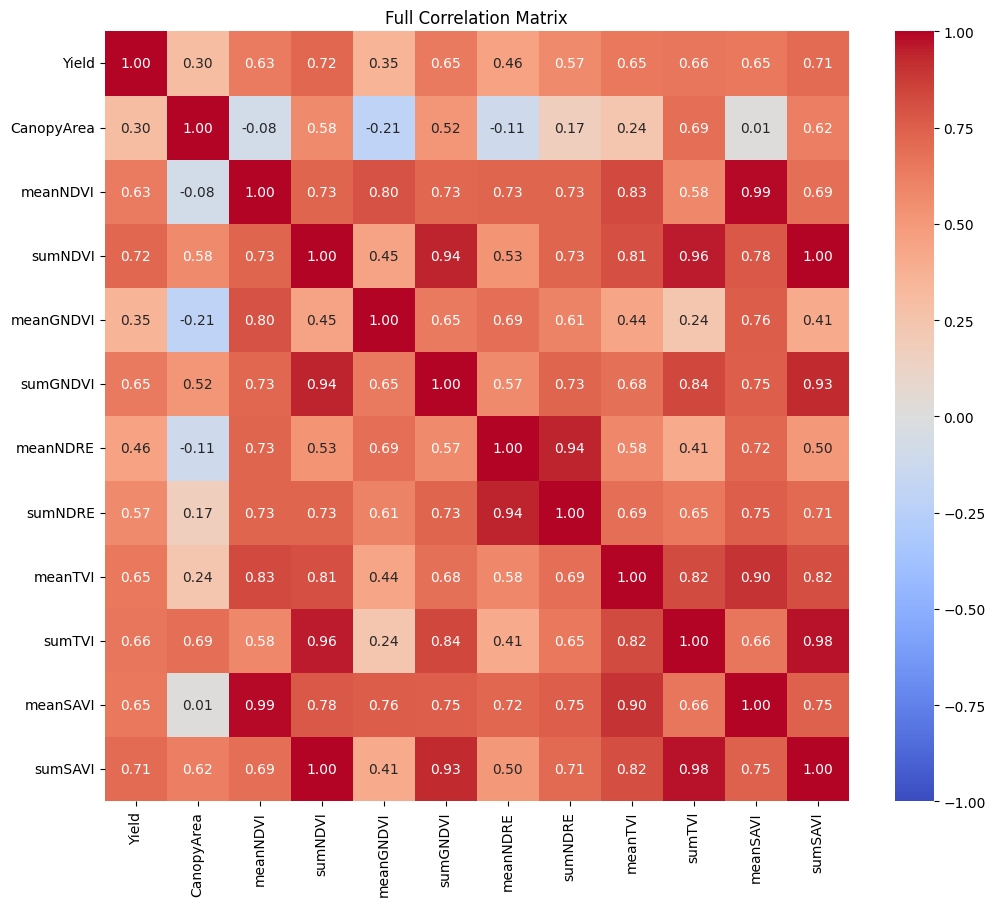

In [10]:
# CORRELATION
correlation_matrix = filtered_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Full Correlation Matrix')
plt.show()

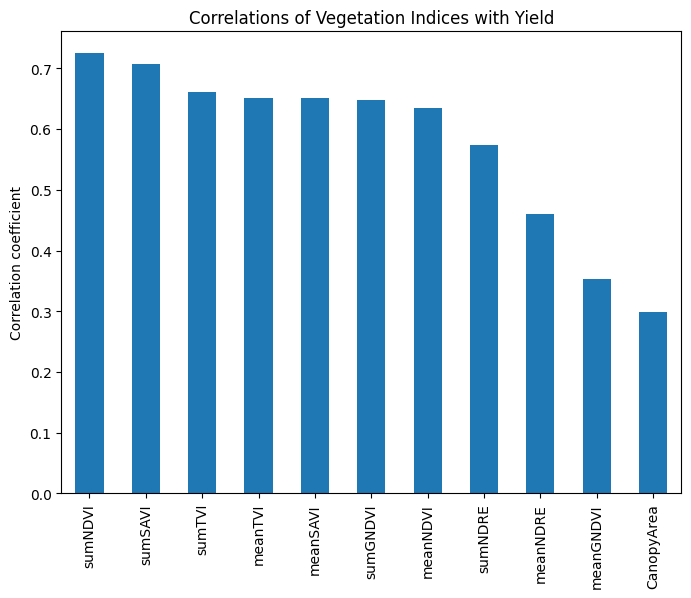

In [11]:
# Correlations of Vegetation Indices with Yield
correlations_with_yield = correlation_matrix['Yield'].sort_values(ascending=False)

plt.figure(figsize=(8, 6))
correlations_with_yield.drop('Yield').plot(kind='bar')
plt.title('Correlations of Vegetation Indices with Yield')
plt.ylabel('Correlation coefficient')
plt.show()

In [12]:
del history

NameError: name 'history' is not defined

# 3- Building a MLP

In [45]:
optimizer= tf.keras.optimizers.Adam(0.004)

normal_model = Sequential()
normal_model.add(Dense(256, input_shape=[len(X_train.keys())], kernel_initializer='normal', activation='relu'))
# normal_model.add(Dropout(0.3))
normal_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
# normal_model.add(Dropout(0.3))
normal_model.add(Dense(128, kernel_initializer='normal', activation='relu'))
# normal_model.add(Dropout(0.3))
normal_model.add(Dense(64, kernel_initializer='normal', activation='relu'))
normal_model.add(Dense(1, kernel_initializer='normal'))
normal_model.compile(loss='mse', optimizer = optimizer, metrics=['mean_absolute_error','mean_squared_error'])

# Build and inspect the model
normal_model.summary()

/home/ghibara/miniconda3/envs/tf_gpu/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 256)            │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,105 (434.00 KB)

 Trainable params: 111,105 (434.00 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# Early stopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min', restore_best_weights=False)

# fitting the model
history= normal_model.fit(
    X_train, y_train,
    epochs=300,
    validation_data=(X_test, y_test),
    verbose=1, #set verbose=1 for full details at every epoch
    callbacks= [early_stopping_cb])

loss, mae, mse= normal_model.evaluate(X_test, y_test, verbose=1)
print("Test-set Mean absolute error: {:5.2f}".format(mae)) # test mae- 36286

Epoch 1/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - loss: 0.1444 - mean_absolute_error: 0.3089 - mean_squared_error: 0.1444 - val_loss: 0.0188 - val_mean_absolute_error: 0.1110 - val_mean_squared_error: 0.0188
Epoch 2/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0295 - mean_absolute_error: 0.1300 - mean_squared_error: 0.0295 - val_loss: 0.0182 - val_mean_absolute_error: 0.1120 - val_mean_squared_error: 0.0182
Epoch 3/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0162 - mean_absolute_error: 0.1016 - mean_squared_error: 0.0162 - val_loss: 0.0068 - val_mean_absolute_error: 0.0649 - val_mean_squared_error: 0.0068
Epoch 4/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0101 - mean_absolute_error: 0.0750 - mean_squared_error: 0.0101 - val_loss: 0.0075 - val_mean_absolute_error: 0.0655 - val_mean_squared_error: 0.0075
Epoch 5/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0107 - mean_absolute_error: 0.0770 - mean_squared_error: 0.0107 - val_loss: 0.0064 - val_mean_absol

Text(0.5, 1.0, 'Train - MAE')

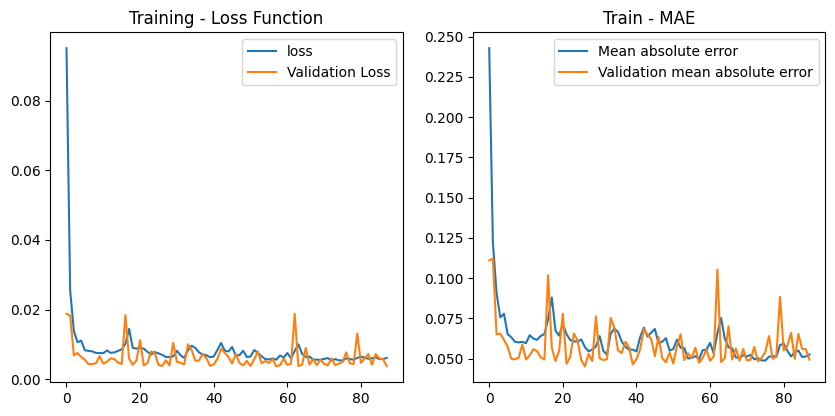

In [47]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Mean absolute error')
plt.plot(history.history['val_mean_absolute_error'], label='Validation mean absolute error')
plt.legend()
plt.title('Train - MAE')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


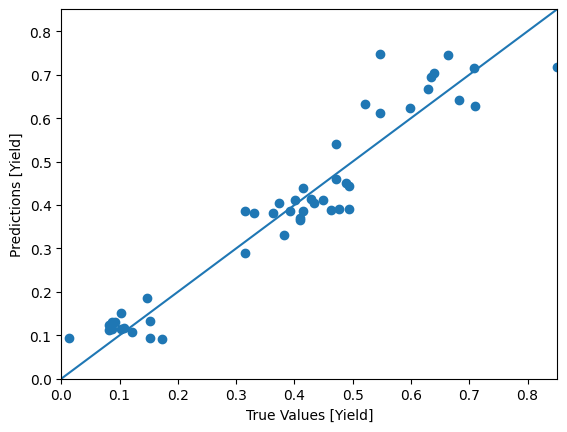

In [48]:
y_pred_test= normal_model.predict(X_test).flatten()
# print(y_test)
# a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred_test)
plt.xlabel('True Values [Yield]')
plt.ylabel('Predictions [Yield]')


lims=[0, max(y_test)]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

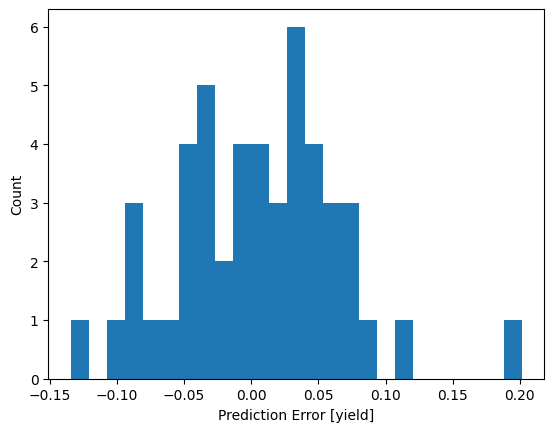

In [49]:
error= y_pred_test-y_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [yield]')
_=plt.ylabel('Count')

In [50]:
# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_squared_error

# Accuracy metrics :

y_pred_train= normal_model.predict(X_train).flatten()

print("Accuracy obtained using x_train and x_val sets from the original x!")

print("Training accuracy: ",r2_score(y_train, y_pred_train))

print("Test accuracy: ",r2_score(y_test, y_pred_test))

print("Test mean-squared error: ",np.sqrt(mean_squared_error(y_test, y_pred_test)))



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Accuracy obtained using x_train and x_val sets from the original x!
Training accuracy:  0.8890452749170985
Test accuracy:  0.9136143512958322
Test mean-squared error:  0.061279316554025846


In [41]:
rounded = round(r2_score(y_test, y_pred_test),4)
name = 'model_' + str(rounded) + '.h5'
normal_model.save(os.path.join('models', name))

# 4- GridSearch and Mlflow tracking 

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.datasets import make_regression

import mlflow
import sklearn
import warnings
import tempfile
import os
from datetime import datetime
import pandas as pd

In [24]:
arch = []

for a in range(128,257,128):
    for b in range(256,513,128):
        for c in range(128,257,128):
            for d in range(32,129,32):
                arch.append([a,b,c,d])

print(len(arch))

48


In [41]:
# Define parameter grid for GridSearchCV
param_grid = {
    'hidden_layer_sizes':  arch,
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0004, 0.004, 0.04],
    'learning_rate': ['constant', 'adaptive']
}

In [22]:
def log_run(gridsearch, experiment_name: str, model_name: str, run_index: int, conda_env, tags={}):
    """Logging of cross validation results to MLflow tracking server"""
    cv_results = gridsearch.cv_results_
    with mlflow.start_run(run_name=str(run_index)) as run:  
        mlflow.log_param("folds", gridsearch.cv)
        
        # Log hyperparameters
        params = list(gridsearch.param_grid.keys())
        for param in params:
            mlflow.log_param(param, cv_results[f"param_{param}"][run_index])
        
        # Log metrics
        for score_name in [score for score in cv_results if "mean_test" in score]:
            mlflow.log_metric(score_name, cv_results[score_name][run_index])
            mlflow.log_metric(score_name.replace("mean","std"), 
                               cv_results[score_name.replace("mean","std")][run_index])
        
        # Log model
        mlflow.sklearn.log_model(gridsearch.best_estimator_, model_name, conda_env=conda_env)
        
        # Log CV results
        with tempfile.TemporaryDirectory() as tempdir:
            timestamp = datetime.now().isoformat().split(".")[0].replace(":", ".")
            filename = f"{model_name}-{timestamp}-cv_results.csv"
            csv_path = os.path.join(tempdir, filename)
            
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                pd.DataFrame(cv_results).to_csv(csv_path, index=False)
            
            mlflow.log_artifact(csv_path, "cv_results")
        
        # Set tags
        mlflow.set_tags(tags)
        
        print(f"MLflow Artifact URI: {mlflow.get_artifact_uri()}")
        print(f"Run ID: {run.info.run_uuid}")
        mlflow.end_run()

def log_results(gridsearch, experiment_name, model_name, tags={}, log_only_best=False):
    """Logging of cross validation results to MLflow tracking server"""
    conda_env = {
        'name': 'sklearn_env',
        'channels': ['defaults'],
        'dependencies': [
            'python=3.9',
            'scikit-learn>=1.0.2',
            'mlflow>=1.23.0'
        ]
    }
    
    # Set MLflow tracking URI (modify as needed)
    mlflow.set_tracking_uri("http://localhost:5000")
    mlflow.set_experiment(experiment_name)
    
    best = gridsearch.best_index_
    if log_only_best:
        log_run(gridsearch, experiment_name, model_name, best, conda_env, tags)
    else:
        for i in range(len(gridsearch.cv_results_['params'])):
            log_run(gridsearch, experiment_name, model_name, i, conda_env, tags)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
[CV] END activation=relu, alpha=0.0004, hidden_layer_sizes=[128, 256, 128, 32], learning_rate=constant, solver=sgd; total time=   2.7s
[CV] END activation=relu, alpha=0.0004, hidden_layer_sizes=[128, 256, 128, 64], learning_rate=constant, solver=adam; total time=   1.1s
[CV] END activation=relu, alpha=0.0004, hidden_layer_sizes=[128, 256, 128, 64], learning_rate=constant, solver=RMSProp; total time=   0.0s
[CV] END activation=relu, alpha=0.0004, hidden_layer_sizes=[128, 256, 128, 64], learning_rate=constant, solver=RMSProp; total time=   0.0s
[CV] END activation=relu, alpha=0.0004, hidden_layer_sizes=[128, 256, 128, 64], learning_rate=constant, solver=RMSProp; total time=   0.0s
[CV] END activation=relu, alpha=0.0004, hidden_layer_sizes=[128, 256, 128, 64], learning_rate=constant, solver=RMSProp; total time=   0.0s
[CV] END activation=relu, alpha=0.0004, hidden_layer_sizes=[128, 256, 128, 64], learning_rate=constant, solv

/home/ghibara/miniconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ghibara/miniconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ghibara/miniconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ghibara/miniconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
 

[CV] END activation=relu, alpha=0.04, hidden_layer_sizes=[256, 256, 128, 32], learning_rate=adaptive, solver=RMSProp; total time=   0.0s
[CV] END activation=relu, alpha=0.04, hidden_layer_sizes=[256, 256, 128, 32], learning_rate=adaptive, solver=RMSProp; total time=   0.0s
[CV] END activation=relu, alpha=0.04, hidden_layer_sizes=[256, 256, 128, 32], learning_rate=adaptive, solver=RMSProp; total time=   0.0s
[CV] END activation=relu, alpha=0.04, hidden_layer_sizes=[256, 256, 128, 64], learning_rate=constant, solver=adam; total time=   7.7s
[CV] END activation=relu, alpha=0.04, hidden_layer_sizes=[256, 256, 128, 64], learning_rate=constant, solver=RMSProp; total time=   0.0s
[CV] END activation=relu, alpha=0.04, hidden_layer_sizes=[256, 256, 128, 64], learning_rate=constant, solver=RMSProp; total time=   0.0s
[CV] END activation=relu, alpha=0.04, hidden_layer_sizes=[256, 256, 128, 64], learning_rate=constant, solver=RMSProp; total time=   0.0s
[CV] END activation=relu, alpha=0.04, hidden

/home/ghibara/miniconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ghibara/miniconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.04, hidden_layer_sizes=[256, 256, 128, 64], learning_rate=constant, solver=adam; total time=  11.9s
[CV] END activation=relu, alpha=0.04, hidden_layer_sizes=[256, 256, 128, 64], learning_rate=adaptive, solver=sgd; total time=   5.7s
[CV] END activation=relu, alpha=0.04, hidden_layer_sizes=[256, 256, 128, 96], learning_rate=constant, solver=adam; total time=   7.2s
[CV] END activation=relu, alpha=0.04, hidden_layer_sizes=[256, 256, 128, 96], learning_rate=constant, solver=sgd; total time=   3.2s
[CV] END activation=relu, alpha=0.04, hidden_layer_sizes=[256, 256, 128, 96], learning_rate=adaptive, solver=sgd; total time=   5.3s
[CV] END activation=relu, alpha=0.04, hidden_layer_sizes=[256, 256, 128, 128], learning_rate=constant, solver=adam; total time=  12.9s
[CV] END activation=relu, alpha=0.04, hidden_layer_sizes=[256, 256, 128, 128], learning_rate=adaptive, solver=sgd; total time=   5.6s
[CV] END activation=relu, alpha=0.04, hidden_layer_sizes=[256, 2

/home/ghibara/miniconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ghibara/miniconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ghibara/miniconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ghibara/miniconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
 

[CV] END activation=relu, alpha=0.04, hidden_layer_sizes=[256, 384, 256, 96], learning_rate=constant, solver=adam; total time=  24.9s
[CV] END activation=relu, alpha=0.04, hidden_layer_sizes=[256, 384, 256, 96], learning_rate=adaptive, solver=adam; total time=  27.5s
[CV] END activation=relu, alpha=0.04, hidden_layer_sizes=[256, 384, 256, 128], learning_rate=constant, solver=sgd; total time=   4.5s
[CV] END activation=relu, alpha=0.04, hidden_layer_sizes=[256, 384, 256, 128], learning_rate=constant, solver=sgd; total time=   4.0s
[CV] END activation=relu, alpha=0.04, hidden_layer_sizes=[256, 384, 256, 128], learning_rate=constant, solver=RMSProp; total time=   0.0s
[CV] END activation=relu, alpha=0.04, hidden_layer_sizes=[256, 384, 256, 128], learning_rate=constant, solver=RMSProp; total time=   0.0s
[CV] END activation=relu, alpha=0.04, hidden_layer_sizes=[256, 384, 256, 128], learning_rate=constant, solver=RMSProp; total time=   0.0s
[CV] END activation=relu, alpha=0.04, hidden_layer

/home/ghibara/miniconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ghibara/miniconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ghibara/miniconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ghibara/miniconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
 

[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 256, 128, 128], learning_rate=constant, solver=adam; total time=   3.7s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 256, 128, 128], learning_rate=adaptive, solver=adam; total time=   3.8s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 256, 256, 32], learning_rate=constant, solver=adam; total time=   1.0s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 256, 256, 32], learning_rate=constant, solver=sgd; total time=   2.7s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 256, 256, 32], learning_rate=adaptive, solver=sgd; total time=   5.3s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 256, 256, 64], learning_rate=adaptive, solver=adam; total time=   1.3s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 256, 256, 64], learning_rate=adaptive, solver=sgd; total time=   5.2s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 

/home/ghibara/miniconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ghibara/miniconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 256, 256, 64], learning_rate=constant, solver=RMSProp; total time=   0.0s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 256, 256, 64], learning_rate=adaptive, solver=adam; total time=   1.2s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 256, 256, 64], learning_rate=adaptive, solver=sgd; total time=   5.2s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 256, 256, 96], learning_rate=adaptive, solver=adam; total time=   1.2s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 256, 256, 96], learning_rate=adaptive, solver=sgd; total time=   5.5s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 256, 256, 128], learning_rate=constant, solver=sgd; total time=   2.6s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 256, 256, 128], learning_rate=adaptive, solver=adam; total time=   5.5s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[25

/home/ghibara/miniconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
2880 fits failed out of a total of 8640.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
762 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ghibara/miniconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ghibara/miniconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/ghibara/miniconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/base.py", line 666, in _validate_p

logging


2024/11/28 12:26:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run 0 at: http://localhost:5000/#/experiments/768347479743006630/runs/d019ad8f87d5465f946808663f0a42c4.
2024/11/28 12:26:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d019ad8f87d5465f946808663f0a42c4/artifacts
Run ID: d019ad8f87d5465f946808663f0a42c4


2024/11/28 12:26:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1 at: http://localhost:5000/#/experiments/768347479743006630/runs/4f317675f8f84d1b86d6253cdd5591bf.
2024/11/28 12:26:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run 2 at: http://localhost:5000/#/experiments/768347479743006630/runs/5b185493365f46819ce1802aca31026a.
2024/11/28 12:26:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4f317675f8f84d1b86d6253cdd5591bf/artifacts
Run ID: 4f317675f8f84d1b86d6253cdd5591bf
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5b185493365f46819ce1802aca31026a/artifacts
Run ID: 5b185493365f46819ce1802aca31026a


2024/11/28 12:26:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run 3 at: http://localhost:5000/#/experiments/768347479743006630/runs/98bb91b9fd8244ceaa141cf43b151675.
2024/11/28 12:26:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run 4 at: http://localhost:5000/#/experiments/768347479743006630/runs/b656c3ea637f4d57923b5cfac3602a8d.
2024/11/28 12:26:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/98bb91b9fd8244ceaa141cf43b151675/artifacts
Run ID: 98bb91b9fd8244ceaa141cf43b151675
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b656c3ea637f4d57923b5cfac3602a8d/artifacts
Run ID: b656c3ea637f4d57923b5cfac3602a8d


2024/11/28 12:26:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run 5 at: http://localhost:5000/#/experiments/768347479743006630/runs/f648bd2f387e42c986296028b9e258c8.
2024/11/28 12:26:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f648bd2f387e42c986296028b9e258c8/artifacts
Run ID: f648bd2f387e42c986296028b9e258c8


2024/11/28 12:26:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run 6 at: http://localhost:5000/#/experiments/768347479743006630/runs/58b210f299e7461daa6dd75dd9975f1a.
2024/11/28 12:26:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run 7 at: http://localhost:5000/#/experiments/768347479743006630/runs/5350f2bac1804aab8836cfc73a95d35f.
2024/11/28 12:26:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/58b210f299e7461daa6dd75dd9975f1a/artifacts
Run ID: 58b210f299e7461daa6dd75dd9975f1a
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5350f2bac1804aab8836cfc73a95d35f/artifacts
Run ID: 5350f2bac1804aab8836cfc73a95d35f


2024/11/28 12:26:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 8 at: http://localhost:5000/#/experiments/768347479743006630/runs/3728946310e646e999ffcd5fee0de3e2.
2024/11/28 12:26:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 9 at: http://localhost:5000/#/experiments/768347479743006630/runs/095c9aa802bb463daec104fc919ac305.
2024/11/28 12:26:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3728946310e646e999ffcd5fee0de3e2/artifacts
Run ID: 3728946310e646e999ffcd5fee0de3e2
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/095c9aa802bb463daec104fc919ac305/artifacts
Run ID: 095c9aa802bb463daec104fc919ac305


2024/11/28 12:26:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 10 at: http://localhost:5000/#/experiments/768347479743006630/runs/588ee915981d4f2e99beadea13c73f39.
2024/11/28 12:26:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/588ee915981d4f2e99beadea13c73f39/artifacts
Run ID: 588ee915981d4f2e99beadea13c73f39
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5df85ae961f1432a8e58678f1d115087/artifacts
Run ID: 5df85ae961f1432a8e58678f1d115087


2024/11/28 12:26:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 11 at: http://localhost:5000/#/experiments/768347479743006630/runs/5df85ae961f1432a8e58678f1d115087.
2024/11/28 12:26:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 12 at: http://localhost:5000/#/experiments/768347479743006630/runs/bc0181a8b9a647e5a8e3265682125315.
2024/11/28 12:26:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the m

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/bc0181a8b9a647e5a8e3265682125315/artifacts
Run ID: bc0181a8b9a647e5a8e3265682125315
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b0db3732f84442058701b14b3162fd04/artifacts
Run ID: b0db3732f84442058701b14b3162fd04


2024/11/28 12:26:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 14 at: http://localhost:5000/#/experiments/768347479743006630/runs/d8d68520cfe744f98abc6f47d5806138.
2024/11/28 12:26:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d8d68520cfe744f98abc6f47d5806138/artifacts
Run ID: d8d68520cfe744f98abc6f47d5806138


2024/11/28 12:26:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 15 at: http://localhost:5000/#/experiments/768347479743006630/runs/9c720338e9a747eea6dd17548bc636c7.
2024/11/28 12:26:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9c720338e9a747eea6dd17548bc636c7/artifacts
Run ID: 9c720338e9a747eea6dd17548bc636c7
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2035dee0c07846a7a072803fd91e2468/artifacts
Run ID: 2035dee0c07846a7a072803fd91e2468


2024/11/28 12:26:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 16 at: http://localhost:5000/#/experiments/768347479743006630/runs/2035dee0c07846a7a072803fd91e2468.
2024/11/28 12:26:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 17 at: http://localhost:5000/#/experiments/768347479743006630/runs/e2f3d58123db4cbca5d417de382138df.
2024/11/28 12:26:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the m

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e2f3d58123db4cbca5d417de382138df/artifacts
Run ID: e2f3d58123db4cbca5d417de382138df


2024/11/28 12:26:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 18 at: http://localhost:5000/#/experiments/768347479743006630/runs/2064d25ea233464dbbc1749c18946ac6.
2024/11/28 12:26:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2064d25ea233464dbbc1749c18946ac6/artifacts
Run ID: 2064d25ea233464dbbc1749c18946ac6


2024/11/28 12:26:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 19 at: http://localhost:5000/#/experiments/768347479743006630/runs/4813fa635f9e486593e58c62457f5160.
2024/11/28 12:26:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 20 at: http://localhost:5000/#/experiments/768347479743006630/runs/d8ae5aeddaec4d7e9551320aa2259a5f.
2024/11/28 12:26:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4813fa635f9e486593e58c62457f5160/artifacts
Run ID: 4813fa635f9e486593e58c62457f5160
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d8ae5aeddaec4d7e9551320aa2259a5f/artifacts
Run ID: d8ae5aeddaec4d7e9551320aa2259a5f


2024/11/28 12:26:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 21 at: http://localhost:5000/#/experiments/768347479743006630/runs/903509591aa54f7e83f42dc23da023c4.
2024/11/28 12:26:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 22 at: http://localhost:5000/#/experiments/768347479743006630/runs/d3647aa0f992430a8ad44fc7a204be08.
2024/11/28 12:26:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/903509591aa54f7e83f42dc23da023c4/artifacts
Run ID: 903509591aa54f7e83f42dc23da023c4
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d3647aa0f992430a8ad44fc7a204be08/artifacts
Run ID: d3647aa0f992430a8ad44fc7a204be08


2024/11/28 12:26:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 23 at: http://localhost:5000/#/experiments/768347479743006630/runs/992302c7d65e418f88c3779214676b3f.
2024/11/28 12:26:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 24 at: http://localhost:5000/#/experiments/768347479743006630/runs/86bae4f62dfe4d018f720985b71ea662.
2024/11/28 12:26:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/992302c7d65e418f88c3779214676b3f/artifacts
Run ID: 992302c7d65e418f88c3779214676b3f
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/86bae4f62dfe4d018f720985b71ea662/artifacts
Run ID: 86bae4f62dfe4d018f720985b71ea662


2024/11/28 12:26:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 25 at: http://localhost:5000/#/experiments/768347479743006630/runs/c13e7eab30904df78ce6571ab180fe3c.
2024/11/28 12:26:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 26 at: http://localhost:5000/#/experiments/768347479743006630/runs/065595ddcad6446983b9fdee87000217.
2024/11/28 12:26:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c13e7eab30904df78ce6571ab180fe3c/artifacts
Run ID: c13e7eab30904df78ce6571ab180fe3c
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/065595ddcad6446983b9fdee87000217/artifacts
Run ID: 065595ddcad6446983b9fdee87000217


2024/11/28 12:26:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 27 at: http://localhost:5000/#/experiments/768347479743006630/runs/258d847e4b194701958e977d1d739d43.
2024/11/28 12:26:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 28 at: http://localhost:5000/#/experiments/768347479743006630/runs/3a3d1d98e3f445dda8673a1af5924c9d.
2024/11/28 12:26:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/258d847e4b194701958e977d1d739d43/artifacts
Run ID: 258d847e4b194701958e977d1d739d43
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3a3d1d98e3f445dda8673a1af5924c9d/artifacts
Run ID: 3a3d1d98e3f445dda8673a1af5924c9d


2024/11/28 12:26:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run 29 at: http://localhost:5000/#/experiments/768347479743006630/runs/21baadd954f9496e804f5264ecaf08f6.
2024/11/28 12:26:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/21baadd954f9496e804f5264ecaf08f6/artifacts
Run ID: 21baadd954f9496e804f5264ecaf08f6


2024/11/28 12:26:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run 30 at: http://localhost:5000/#/experiments/768347479743006630/runs/cab0fac14fe445c394b793c010cf1746.
2024/11/28 12:26:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/cab0fac14fe445c394b793c010cf1746/artifacts
Run ID: cab0fac14fe445c394b793c010cf1746
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8e9317e5be0e47d69c77a2da60b6a187/artifacts
Run ID: 8e9317e5be0e47d69c77a2da60b6a187


2024/11/28 12:26:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run 31 at: http://localhost:5000/#/experiments/768347479743006630/runs/8e9317e5be0e47d69c77a2da60b6a187.
2024/11/28 12:26:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run 32 at: http://localhost:5000/#/experiments/768347479743006630/runs/5821bf0e4435499a8dc31d431cb61ff4.
2024/11/28 12:26:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the m

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5821bf0e4435499a8dc31d431cb61ff4/artifacts
Run ID: 5821bf0e4435499a8dc31d431cb61ff4
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b59237d55bb647bf8ad6b8a705c00901/artifacts
Run ID: b59237d55bb647bf8ad6b8a705c00901


2024/11/28 12:26:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run 34 at: http://localhost:5000/#/experiments/768347479743006630/runs/6c1444bf8c5e4428b75b7edd40c8ef52.
2024/11/28 12:26:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run 35 at: http://localhost:5000/#/experiments/768347479743006630/runs/4f3ac48988434e5080f842c00142f457.
2024/11/28 12:26:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6c1444bf8c5e4428b75b7edd40c8ef52/artifacts
Run ID: 6c1444bf8c5e4428b75b7edd40c8ef52
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4f3ac48988434e5080f842c00142f457/artifacts
Run ID: 4f3ac48988434e5080f842c00142f457


2024/11/28 12:26:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run 36 at: http://localhost:5000/#/experiments/768347479743006630/runs/bbb83f8a0ddb4f4cb45797ee3dc385cc.
2024/11/28 12:26:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run 37 at: http://localhost:5000/#/experiments/768347479743006630/runs/ae210895138b497983906aa7b46952a5.
2024/11/28 12:26:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/bbb83f8a0ddb4f4cb45797ee3dc385cc/artifacts
Run ID: bbb83f8a0ddb4f4cb45797ee3dc385cc
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ae210895138b497983906aa7b46952a5/artifacts
Run ID: ae210895138b497983906aa7b46952a5


2024/11/28 12:26:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run 38 at: http://localhost:5000/#/experiments/768347479743006630/runs/9222aa13db3b4f0f99e805880ff432c1.
2024/11/28 12:26:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9222aa13db3b4f0f99e805880ff432c1/artifacts
Run ID: 9222aa13db3b4f0f99e805880ff432c1
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/918c3c7296d44eabbf07be1bbe093aa9/artifacts
Run ID: 918c3c7296d44eabbf07be1bbe093aa9


2024/11/28 12:26:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run 39 at: http://localhost:5000/#/experiments/768347479743006630/runs/918c3c7296d44eabbf07be1bbe093aa9.
2024/11/28 12:26:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run 40 at: http://localhost:5000/#/experiments/768347479743006630/runs/1a3d07e1cdc94a1e80028b041faa87bf.
2024/11/28 12:26:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the m

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1a3d07e1cdc94a1e80028b041faa87bf/artifacts
Run ID: 1a3d07e1cdc94a1e80028b041faa87bf
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e01ab7f3accc481c8234175e3971a7d8/artifacts
Run ID: e01ab7f3accc481c8234175e3971a7d8


2024/11/28 12:26:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run 41 at: http://localhost:5000/#/experiments/768347479743006630/runs/e01ab7f3accc481c8234175e3971a7d8.
2024/11/28 12:26:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run 42 at: http://localhost:5000/#/experiments/768347479743006630/runs/68134f53af1e4b4c8bcfc5291e47a3e1.
2024/11/28 12:26:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the m

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/68134f53af1e4b4c8bcfc5291e47a3e1/artifacts
Run ID: 68134f53af1e4b4c8bcfc5291e47a3e1
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/99ed7d77ebf146ae8cebb6035cfac8ed/artifacts
Run ID: 99ed7d77ebf146ae8cebb6035cfac8ed


2024/11/28 12:26:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run 44 at: http://localhost:5000/#/experiments/768347479743006630/runs/d37b0263b93844299e05c67c1ad5f084.
2024/11/28 12:26:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run 45 at: http://localhost:5000/#/experiments/768347479743006630/runs/abde9174767b4759b29120d1dd6aa71d.
2024/11/28 12:26:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d37b0263b93844299e05c67c1ad5f084/artifacts
Run ID: d37b0263b93844299e05c67c1ad5f084
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/abde9174767b4759b29120d1dd6aa71d/artifacts
Run ID: abde9174767b4759b29120d1dd6aa71d


2024/11/28 12:26:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run 46 at: http://localhost:5000/#/experiments/768347479743006630/runs/95aa03f2140a48bab98e3eb32c62d48e.
2024/11/28 12:26:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run 47 at: http://localhost:5000/#/experiments/768347479743006630/runs/666aa2e93a2440b79425b424ab537003.
2024/11/28 12:26:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/95aa03f2140a48bab98e3eb32c62d48e/artifacts
Run ID: 95aa03f2140a48bab98e3eb32c62d48e
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/666aa2e93a2440b79425b424ab537003/artifacts
Run ID: 666aa2e93a2440b79425b424ab537003


2024/11/28 12:26:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run 48 at: http://localhost:5000/#/experiments/768347479743006630/runs/d4704c2d7cf44c48a19dc04e1675ea42.
2024/11/28 12:26:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run 49 at: http://localhost:5000/#/experiments/768347479743006630/runs/4a9aad23bbfd46b89ae6921bd95a77e6.
2024/11/28 12:26:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d4704c2d7cf44c48a19dc04e1675ea42/artifacts
Run ID: d4704c2d7cf44c48a19dc04e1675ea42
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4a9aad23bbfd46b89ae6921bd95a77e6/artifacts
Run ID: 4a9aad23bbfd46b89ae6921bd95a77e6


2024/11/28 12:26:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 50 at: http://localhost:5000/#/experiments/768347479743006630/runs/f5b84c6cf02f477aa1d0f71d30cad7a9.
2024/11/28 12:26:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 51 at: http://localhost:5000/#/experiments/768347479743006630/runs/f56256edf5234fc2aa1424d247dc0092.
2024/11/28 12:26:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f5b84c6cf02f477aa1d0f71d30cad7a9/artifacts
Run ID: f5b84c6cf02f477aa1d0f71d30cad7a9
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f56256edf5234fc2aa1424d247dc0092/artifacts
Run ID: f56256edf5234fc2aa1424d247dc0092


2024/11/28 12:26:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 52 at: http://localhost:5000/#/experiments/768347479743006630/runs/0770f5f95d3946d5863ffcf8564cf9da.
2024/11/28 12:26:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 53 at: http://localhost:5000/#/experiments/768347479743006630/runs/56e1b1c7a74747249ad7008ab855646f.
2024/11/28 12:26:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0770f5f95d3946d5863ffcf8564cf9da/artifacts
Run ID: 0770f5f95d3946d5863ffcf8564cf9da
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/56e1b1c7a74747249ad7008ab855646f/artifacts
Run ID: 56e1b1c7a74747249ad7008ab855646f


2024/11/28 12:26:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 54 at: http://localhost:5000/#/experiments/768347479743006630/runs/24840969f54d4e2284b8ebeb22d54282.
2024/11/28 12:26:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 55 at: http://localhost:5000/#/experiments/768347479743006630/runs/60f32f5a54ad4d979226972a6cab1aad.
2024/11/28 12:26:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/24840969f54d4e2284b8ebeb22d54282/artifacts
Run ID: 24840969f54d4e2284b8ebeb22d54282
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/60f32f5a54ad4d979226972a6cab1aad/artifacts
Run ID: 60f32f5a54ad4d979226972a6cab1aad


2024/11/28 12:26:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run 56 at: http://localhost:5000/#/experiments/768347479743006630/runs/c0ab862d9b794aba8ef810edeb148db9.
2024/11/28 12:26:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c0ab862d9b794aba8ef810edeb148db9/artifacts
Run ID: c0ab862d9b794aba8ef810edeb148db9
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fdf62bd1aad14e8eb903bf5a1ad27a08/artifacts
Run ID: fdf62bd1aad14e8eb903bf5a1ad27a08


2024/11/28 12:26:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run 57 at: http://localhost:5000/#/experiments/768347479743006630/runs/fdf62bd1aad14e8eb903bf5a1ad27a08.
2024/11/28 12:26:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run 58 at: http://localhost:5000/#/experiments/768347479743006630/runs/a65a79d3b112469096c906ecd3a45f90.
2024/11/28 12:26:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the m

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a65a79d3b112469096c906ecd3a45f90/artifacts
Run ID: a65a79d3b112469096c906ecd3a45f90


2024/11/28 12:26:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run 59 at: http://localhost:5000/#/experiments/768347479743006630/runs/493911c530cf4d5dae23a47ea52ec090.
2024/11/28 12:26:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/493911c530cf4d5dae23a47ea52ec090/artifacts
Run ID: 493911c530cf4d5dae23a47ea52ec090


2024/11/28 12:26:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run 60 at: http://localhost:5000/#/experiments/768347479743006630/runs/25b0aadbf4244445a0e08bc4e91f14ee.
2024/11/28 12:26:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/25b0aadbf4244445a0e08bc4e91f14ee/artifacts
Run ID: 25b0aadbf4244445a0e08bc4e91f14ee


2024/11/28 12:26:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run 61 at: http://localhost:5000/#/experiments/768347479743006630/runs/9142e5955bd7446987d2d7dfc23fb0f4.
2024/11/28 12:26:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9142e5955bd7446987d2d7dfc23fb0f4/artifacts
Run ID: 9142e5955bd7446987d2d7dfc23fb0f4


2024/11/28 12:26:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run 62 at: http://localhost:5000/#/experiments/768347479743006630/runs/fab71372021b4dba9ae56deef8a47e62.
2024/11/28 12:26:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run 63 at: http://localhost:5000/#/experiments/768347479743006630/runs/ddaacb27ab624b39bdc655a756250966.
2024/11/28 12:26:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fab71372021b4dba9ae56deef8a47e62/artifacts
Run ID: fab71372021b4dba9ae56deef8a47e62
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ddaacb27ab624b39bdc655a756250966/artifacts
Run ID: ddaacb27ab624b39bdc655a756250966


2024/11/28 12:26:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run 64 at: http://localhost:5000/#/experiments/768347479743006630/runs/08792492f6134d5fb8dafeecbd196c78.
2024/11/28 12:26:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run 65 at: http://localhost:5000/#/experiments/768347479743006630/runs/c9a6d26708684859a1142014051ada6d.
2024/11/28 12:26:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/08792492f6134d5fb8dafeecbd196c78/artifacts
Run ID: 08792492f6134d5fb8dafeecbd196c78
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c9a6d26708684859a1142014051ada6d/artifacts
Run ID: c9a6d26708684859a1142014051ada6d


2024/11/28 12:26:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run 66 at: http://localhost:5000/#/experiments/768347479743006630/runs/2bd05e327a17458db8195e883699765a.
2024/11/28 12:26:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run 67 at: http://localhost:5000/#/experiments/768347479743006630/runs/f4ae7bc095534d998243bf911d7fde07.
2024/11/28 12:26:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2bd05e327a17458db8195e883699765a/artifacts
Run ID: 2bd05e327a17458db8195e883699765a
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f4ae7bc095534d998243bf911d7fde07/artifacts
Run ID: f4ae7bc095534d998243bf911d7fde07


2024/11/28 12:26:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run 68 at: http://localhost:5000/#/experiments/768347479743006630/runs/eed0ccc067b2467b92b23aef17789adf.
2024/11/28 12:26:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run 69 at: http://localhost:5000/#/experiments/768347479743006630/runs/142b1631911b4b65b9998fdeb5b9bbde.
2024/11/28 12:26:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/eed0ccc067b2467b92b23aef17789adf/artifacts
Run ID: eed0ccc067b2467b92b23aef17789adf
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/142b1631911b4b65b9998fdeb5b9bbde/artifacts
Run ID: 142b1631911b4b65b9998fdeb5b9bbde


2024/11/28 12:26:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run 70 at: http://localhost:5000/#/experiments/768347479743006630/runs/2aa218c840d74433bdd6e5ea73c2429c.
2024/11/28 12:26:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2aa218c840d74433bdd6e5ea73c2429c/artifacts
Run ID: 2aa218c840d74433bdd6e5ea73c2429c


2024/11/28 12:26:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run 71 at: http://localhost:5000/#/experiments/768347479743006630/runs/65bc0a8aab114598ad9b0b959ef280f0.
2024/11/28 12:26:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/65bc0a8aab114598ad9b0b959ef280f0/artifacts
Run ID: 65bc0a8aab114598ad9b0b959ef280f0


2024/11/28 12:26:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run 72 at: http://localhost:5000/#/experiments/768347479743006630/runs/5ce38a095f614fcf89b2a7a0696d1f8f.
2024/11/28 12:26:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run 73 at: http://localhost:5000/#/experiments/768347479743006630/runs/5d0ce5fc06564809b5fd486bb6f0339a.
2024/11/28 12:26:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5ce38a095f614fcf89b2a7a0696d1f8f/artifacts
Run ID: 5ce38a095f614fcf89b2a7a0696d1f8f
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5d0ce5fc06564809b5fd486bb6f0339a/artifacts
Run ID: 5d0ce5fc06564809b5fd486bb6f0339a


2024/11/28 12:26:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run 74 at: http://localhost:5000/#/experiments/768347479743006630/runs/929e37c6ab6046db92efa958eeb0b691.
2024/11/28 12:26:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run 75 at: http://localhost:5000/#/experiments/768347479743006630/runs/d9d09c2c234e4f1296716d665aba3448.
2024/11/28 12:26:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/929e37c6ab6046db92efa958eeb0b691/artifacts
Run ID: 929e37c6ab6046db92efa958eeb0b691
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d9d09c2c234e4f1296716d665aba3448/artifacts
Run ID: d9d09c2c234e4f1296716d665aba3448


2024/11/28 12:26:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run 76 at: http://localhost:5000/#/experiments/768347479743006630/runs/fcb0cff28e4c4b788da89dd25a4b8c93.
2024/11/28 12:26:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run 77 at: http://localhost:5000/#/experiments/768347479743006630/runs/d9468d9c4335460495b0d6a5215068ed.
2024/11/28 12:26:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fcb0cff28e4c4b788da89dd25a4b8c93/artifacts
Run ID: fcb0cff28e4c4b788da89dd25a4b8c93
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d9468d9c4335460495b0d6a5215068ed/artifacts
Run ID: d9468d9c4335460495b0d6a5215068ed


2024/11/28 12:26:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run 78 at: http://localhost:5000/#/experiments/768347479743006630/runs/34c3258b3cbd42fa99ff4242bf80d405.
2024/11/28 12:26:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run 79 at: http://localhost:5000/#/experiments/768347479743006630/runs/89163b30c0bb42d296ab470cf52e6350.
2024/11/28 12:26:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/34c3258b3cbd42fa99ff4242bf80d405/artifacts
Run ID: 34c3258b3cbd42fa99ff4242bf80d405
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/89163b30c0bb42d296ab470cf52e6350/artifacts
Run ID: 89163b30c0bb42d296ab470cf52e6350


2024/11/28 12:26:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run 80 at: http://localhost:5000/#/experiments/768347479743006630/runs/10401d7e9d9b408e848f4478395f1db7.
2024/11/28 12:26:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/10401d7e9d9b408e848f4478395f1db7/artifacts
Run ID: 10401d7e9d9b408e848f4478395f1db7
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ca04b1c1ebb945cfbf3894ef25d854e4/artifacts
Run ID: ca04b1c1ebb945cfbf3894ef25d854e4


2024/11/28 12:26:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run 81 at: http://localhost:5000/#/experiments/768347479743006630/runs/ca04b1c1ebb945cfbf3894ef25d854e4.
2024/11/28 12:26:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 82 at: http://localhost:5000/#/experiments/768347479743006630/runs/1f69796df34c42039b96718e281fff97.
2024/11/28 12:26:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the m

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1f69796df34c42039b96718e281fff97/artifacts
Run ID: 1f69796df34c42039b96718e281fff97


2024/11/28 12:26:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 83 at: http://localhost:5000/#/experiments/768347479743006630/runs/956f477bed4f4bee916366f7d258b8fc.
2024/11/28 12:26:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/956f477bed4f4bee916366f7d258b8fc/artifacts
Run ID: 956f477bed4f4bee916366f7d258b8fc


2024/11/28 12:26:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 84 at: http://localhost:5000/#/experiments/768347479743006630/runs/d2dc096776684a278c650a5dd45eefef.
2024/11/28 12:26:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d2dc096776684a278c650a5dd45eefef/artifacts
Run ID: d2dc096776684a278c650a5dd45eefef


2024/11/28 12:26:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 85 at: http://localhost:5000/#/experiments/768347479743006630/runs/55f965238e644b7f9c9a1e960aa9d44d.
2024/11/28 12:26:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/55f965238e644b7f9c9a1e960aa9d44d/artifacts
Run ID: 55f965238e644b7f9c9a1e960aa9d44d


2024/11/28 12:26:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 86 at: http://localhost:5000/#/experiments/768347479743006630/runs/2cc0eca6d3554bb4b416aabc02f1d182.
2024/11/28 12:26:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 87 at: http://localhost:5000/#/experiments/768347479743006630/runs/e3e910e6b3394c0c86d4882bf228e46e.
2024/11/28 12:26:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2cc0eca6d3554bb4b416aabc02f1d182/artifacts
Run ID: 2cc0eca6d3554bb4b416aabc02f1d182
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e3e910e6b3394c0c86d4882bf228e46e/artifacts
Run ID: e3e910e6b3394c0c86d4882bf228e46e


2024/11/28 12:26:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 88 at: http://localhost:5000/#/experiments/768347479743006630/runs/dd654bba545d4f7285e93426228430bb.
2024/11/28 12:26:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 89 at: http://localhost:5000/#/experiments/768347479743006630/runs/0534507b965d4b5cb34ce5e250c6a661.
2024/11/28 12:26:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/dd654bba545d4f7285e93426228430bb/artifacts
Run ID: dd654bba545d4f7285e93426228430bb
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0534507b965d4b5cb34ce5e250c6a661/artifacts
Run ID: 0534507b965d4b5cb34ce5e250c6a661


2024/11/28 12:26:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 90 at: http://localhost:5000/#/experiments/768347479743006630/runs/c8d2f76be619480f8775abf4df6b4ef3.
2024/11/28 12:26:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c8d2f76be619480f8775abf4df6b4ef3/artifacts
Run ID: c8d2f76be619480f8775abf4df6b4ef3


2024/11/28 12:26:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 91 at: http://localhost:5000/#/experiments/768347479743006630/runs/11b1f1ecccc0481391b7da819dae1287.
2024/11/28 12:26:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 92 at: http://localhost:5000/#/experiments/768347479743006630/runs/56299ab0b8454ccb865528b3847d12eb.
2024/11/28 12:26:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/11b1f1ecccc0481391b7da819dae1287/artifacts
Run ID: 11b1f1ecccc0481391b7da819dae1287
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/56299ab0b8454ccb865528b3847d12eb/artifacts
Run ID: 56299ab0b8454ccb865528b3847d12eb


2024/11/28 12:26:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 93 at: http://localhost:5000/#/experiments/768347479743006630/runs/14764f4fe199400d9a8b52593dc1d08d.
2024/11/28 12:26:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 94 at: http://localhost:5000/#/experiments/768347479743006630/runs/035eb7f0e9d24182a609b16069e3ac36.
2024/11/28 12:26:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/14764f4fe199400d9a8b52593dc1d08d/artifacts
Run ID: 14764f4fe199400d9a8b52593dc1d08d
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/035eb7f0e9d24182a609b16069e3ac36/artifacts
Run ID: 035eb7f0e9d24182a609b16069e3ac36


2024/11/28 12:26:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 95 at: http://localhost:5000/#/experiments/768347479743006630/runs/e9d76fa61a50441fa3ac56825245159e.
2024/11/28 12:26:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e9d76fa61a50441fa3ac56825245159e/artifacts
Run ID: e9d76fa61a50441fa3ac56825245159e


2024/11/28 12:26:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 96 at: http://localhost:5000/#/experiments/768347479743006630/runs/a570021714e44476835d838b0d6bec36.
2024/11/28 12:26:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 97 at: http://localhost:5000/#/experiments/768347479743006630/runs/6e596c9e2ac74bb9a7475c9b0111ef0c.
2024/11/28 12:26:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a570021714e44476835d838b0d6bec36/artifacts
Run ID: a570021714e44476835d838b0d6bec36
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6e596c9e2ac74bb9a7475c9b0111ef0c/artifacts
Run ID: 6e596c9e2ac74bb9a7475c9b0111ef0c


2024/11/28 12:26:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run 98 at: http://localhost:5000/#/experiments/768347479743006630/runs/67f50e6a6af84f8697364d8fca39dd95.
2024/11/28 12:26:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run 99 at: http://localhost:5000/#/experiments/768347479743006630/runs/3e05e189ad4b4c9c8c2dc227ea3e8477.
2024/11/28 12:26:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/67f50e6a6af84f8697364d8fca39dd95/artifacts
Run ID: 67f50e6a6af84f8697364d8fca39dd95
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3e05e189ad4b4c9c8c2dc227ea3e8477/artifacts
Run ID: 3e05e189ad4b4c9c8c2dc227ea3e8477


2024/11/28 12:26:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run 100 at: http://localhost:5000/#/experiments/768347479743006630/runs/6e8b1441202c47e9a2f92a5c1a37f175.
2024/11/28 12:26:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run 101 at: http://localhost:5000/#/experiments/768347479743006630/runs/90d2ff1eac7c4b2785046eb0cf724f2a.
2024/11/28 12:26:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6e8b1441202c47e9a2f92a5c1a37f175/artifacts
Run ID: 6e8b1441202c47e9a2f92a5c1a37f175
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/90d2ff1eac7c4b2785046eb0cf724f2a/artifacts
Run ID: 90d2ff1eac7c4b2785046eb0cf724f2a


2024/11/28 12:26:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run 102 at: http://localhost:5000/#/experiments/768347479743006630/runs/26c04f8db34245cc9a5e0267aee48144.
2024/11/28 12:26:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:26:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run 103 at: http://localhost:5000/#/experiments/768347479743006630/runs/7fe9b6d7ba9040f6ba903dc1e0ecbdf8.
2024/11/28 12:26:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/26c04f8db34245cc9a5e0267aee48144/artifacts
Run ID: 26c04f8db34245cc9a5e0267aee48144
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7fe9b6d7ba9040f6ba903dc1e0ecbdf8/artifacts
Run ID: 7fe9b6d7ba9040f6ba903dc1e0ecbdf8


2024/11/28 12:26:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run 104 at: http://localhost:5000/#/experiments/768347479743006630/runs/d4d99e7618d147d587c111b32fd67f30.
2024/11/28 12:26:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d4d99e7618d147d587c111b32fd67f30/artifacts
Run ID: d4d99e7618d147d587c111b32fd67f30


2024/11/28 12:26:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run 105 at: http://localhost:5000/#/experiments/768347479743006630/runs/d1cb0c8b91a5443fac479546abfe77ac.
2024/11/28 12:26:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d1cb0c8b91a5443fac479546abfe77ac/artifacts
Run ID: d1cb0c8b91a5443fac479546abfe77ac


2024/11/28 12:26:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run 106 at: http://localhost:5000/#/experiments/768347479743006630/runs/9de5ca54fe104c30b825862b5723350c.
2024/11/28 12:26:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9de5ca54fe104c30b825862b5723350c/artifacts
Run ID: 9de5ca54fe104c30b825862b5723350c


2024/11/28 12:26:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run 107 at: http://localhost:5000/#/experiments/768347479743006630/runs/e4a92ed0e5d841769683474df40d03b5.
2024/11/28 12:26:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e4a92ed0e5d841769683474df40d03b5/artifacts
Run ID: e4a92ed0e5d841769683474df40d03b5


2024/11/28 12:26:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run 108 at: http://localhost:5000/#/experiments/768347479743006630/runs/2cb44b21808f41818362a889f6614120.
2024/11/28 12:26:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2cb44b21808f41818362a889f6614120/artifacts
Run ID: 2cb44b21808f41818362a889f6614120


2024/11/28 12:26:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run 109 at: http://localhost:5000/#/experiments/768347479743006630/runs/b9dc532f57f44457abaade0000c0c3d6.
2024/11/28 12:26:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b9dc532f57f44457abaade0000c0c3d6/artifacts
Run ID: b9dc532f57f44457abaade0000c0c3d6


2024/11/28 12:26:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run 110 at: http://localhost:5000/#/experiments/768347479743006630/runs/36d0bd452d9c419ebd2ebac7d605e2c3.
2024/11/28 12:26:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/36d0bd452d9c419ebd2ebac7d605e2c3/artifacts
Run ID: 36d0bd452d9c419ebd2ebac7d605e2c3


2024/11/28 12:26:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:26:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run 111 at: http://localhost:5000/#/experiments/768347479743006630/runs/b154fc847c88448dbf3cc5a41ecdf953.
2024/11/28 12:26:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b154fc847c88448dbf3cc5a41ecdf953/artifacts
Run ID: b154fc847c88448dbf3cc5a41ecdf953


2024/11/28 12:27:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/cb48da5e34d34427a2f8fc1a5f5d35db/artifacts
Run ID: cb48da5e34d34427a2f8fc1a5f5d35db


2024/11/28 12:27:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 112 at: http://localhost:5000/#/experiments/768347479743006630/runs/cb48da5e34d34427a2f8fc1a5f5d35db.
2024/11/28 12:27:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 113 at: http://localhost:5000/#/experiments/768347479743006630/runs/d7bed78ca0604570868a9aa159d1a531.
2024/11/28 12:27:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d7bed78ca0604570868a9aa159d1a531/artifacts
Run ID: d7bed78ca0604570868a9aa159d1a531
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e483aff7f35941fea6b0e0256348decd/artifacts
Run ID: e483aff7f35941fea6b0e0256348decd


2024/11/28 12:27:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 115 at: http://localhost:5000/#/experiments/768347479743006630/runs/eda06d8b9aa6414b8b4bf8aeec93c636.
2024/11/28 12:27:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 116 at: http://localhost:5000/#/experiments/768347479743006630/runs/07f6bd3385ce4c50bd5ce0fc5a8c200f.
2024/11/28 12:27:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/eda06d8b9aa6414b8b4bf8aeec93c636/artifacts
Run ID: eda06d8b9aa6414b8b4bf8aeec93c636
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/07f6bd3385ce4c50bd5ce0fc5a8c200f/artifacts
Run ID: 07f6bd3385ce4c50bd5ce0fc5a8c200f


2024/11/28 12:27:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 117 at: http://localhost:5000/#/experiments/768347479743006630/runs/49bd14b9a5fb4330ab0764696e5b0235.
2024/11/28 12:27:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 118 at: http://localhost:5000/#/experiments/768347479743006630/runs/ccee7974954a4093bb1aad18b9362b01.
2024/11/28 12:27:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/49bd14b9a5fb4330ab0764696e5b0235/artifacts
Run ID: 49bd14b9a5fb4330ab0764696e5b0235
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ccee7974954a4093bb1aad18b9362b01/artifacts
Run ID: ccee7974954a4093bb1aad18b9362b01


2024/11/28 12:27:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 119 at: http://localhost:5000/#/experiments/768347479743006630/runs/560a8d6f33504ba6839b99f3c7705995.
2024/11/28 12:27:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 120 at: http://localhost:5000/#/experiments/768347479743006630/runs/cf3a43b35b4e4a55b9d9548b7920a975.
2024/11/28 12:27:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/560a8d6f33504ba6839b99f3c7705995/artifacts
Run ID: 560a8d6f33504ba6839b99f3c7705995
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/cf3a43b35b4e4a55b9d9548b7920a975/artifacts
Run ID: cf3a43b35b4e4a55b9d9548b7920a975


2024/11/28 12:27:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 121 at: http://localhost:5000/#/experiments/768347479743006630/runs/affe569bce5a4d89831102e58e335046.
2024/11/28 12:27:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 122 at: http://localhost:5000/#/experiments/768347479743006630/runs/80a95db0723e4bd896aaccdeb6afcfe7.
2024/11/28 12:27:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/affe569bce5a4d89831102e58e335046/artifacts
Run ID: affe569bce5a4d89831102e58e335046
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/80a95db0723e4bd896aaccdeb6afcfe7/artifacts
Run ID: 80a95db0723e4bd896aaccdeb6afcfe7


2024/11/28 12:27:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 123 at: http://localhost:5000/#/experiments/768347479743006630/runs/432b758c3f1c41ff9f022af0382bfd35.
2024/11/28 12:27:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/432b758c3f1c41ff9f022af0382bfd35/artifacts
Run ID: 432b758c3f1c41ff9f022af0382bfd35


2024/11/28 12:27:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 124 at: http://localhost:5000/#/experiments/768347479743006630/runs/9dfdbcfce3f04284b37e95369b2425be.
2024/11/28 12:27:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 125 at: http://localhost:5000/#/experiments/768347479743006630/runs/bf29010a8830417c8d0ef750ab3aea2b.
2024/11/28 12:27:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9dfdbcfce3f04284b37e95369b2425be/artifacts
Run ID: 9dfdbcfce3f04284b37e95369b2425be
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/bf29010a8830417c8d0ef750ab3aea2b/artifacts
Run ID: bf29010a8830417c8d0ef750ab3aea2b


2024/11/28 12:27:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 126 at: http://localhost:5000/#/experiments/768347479743006630/runs/6c92972f66a748008fc7b4baf96af491.
2024/11/28 12:27:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6c92972f66a748008fc7b4baf96af491/artifacts
Run ID: 6c92972f66a748008fc7b4baf96af491


2024/11/28 12:27:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 127 at: http://localhost:5000/#/experiments/768347479743006630/runs/bdcace7ee38141c4b579465f85e98f88.
2024/11/28 12:27:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/bdcace7ee38141c4b579465f85e98f88/artifacts
Run ID: bdcace7ee38141c4b579465f85e98f88


2024/11/28 12:27:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run 128 at: http://localhost:5000/#/experiments/768347479743006630/runs/a247cf8cd8614e2db23dca19022211c6.
2024/11/28 12:27:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a247cf8cd8614e2db23dca19022211c6/artifacts
Run ID: a247cf8cd8614e2db23dca19022211c6


2024/11/28 12:27:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run 129 at: http://localhost:5000/#/experiments/768347479743006630/runs/491a4073a50a4f8999d4b198f01d1101.
2024/11/28 12:27:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/491a4073a50a4f8999d4b198f01d1101/artifacts
Run ID: 491a4073a50a4f8999d4b198f01d1101


2024/11/28 12:27:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 130 at: http://localhost:5000/#/experiments/768347479743006630/runs/d851853d24be4d8a81acc26d50d15e51.
2024/11/28 12:27:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d851853d24be4d8a81acc26d50d15e51/artifacts
Run ID: d851853d24be4d8a81acc26d50d15e51


2024/11/28 12:27:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run 131 at: http://localhost:5000/#/experiments/768347479743006630/runs/164a9c7a969448b9a44d3460c75c66ad.
2024/11/28 12:27:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/164a9c7a969448b9a44d3460c75c66ad/artifacts
Run ID: 164a9c7a969448b9a44d3460c75c66ad


2024/11/28 12:27:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run 132 at: http://localhost:5000/#/experiments/768347479743006630/runs/ee069931dfff4d54aee0c14f42793282.
2024/11/28 12:27:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ee069931dfff4d54aee0c14f42793282/artifacts
Run ID: ee069931dfff4d54aee0c14f42793282


2024/11/28 12:27:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run 133 at: http://localhost:5000/#/experiments/768347479743006630/runs/312e0137cf0042c79f93ec82836c9050.
2024/11/28 12:27:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/312e0137cf0042c79f93ec82836c9050/artifacts
Run ID: 312e0137cf0042c79f93ec82836c9050


2024/11/28 12:27:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run 134 at: http://localhost:5000/#/experiments/768347479743006630/runs/cae94a05dae94b9b82292ec7e2c13753.
2024/11/28 12:27:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/cae94a05dae94b9b82292ec7e2c13753/artifacts
Run ID: cae94a05dae94b9b82292ec7e2c13753


2024/11/28 12:27:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run 135 at: http://localhost:5000/#/experiments/768347479743006630/runs/d64ff0871ab94ce2820a81531f416b3a.
2024/11/28 12:27:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d64ff0871ab94ce2820a81531f416b3a/artifacts
Run ID: d64ff0871ab94ce2820a81531f416b3a


2024/11/28 12:27:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 136 at: http://localhost:5000/#/experiments/768347479743006630/runs/46b72c86464d4b39b917df909a511b02.
2024/11/28 12:27:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/46b72c86464d4b39b917df909a511b02/artifacts
Run ID: 46b72c86464d4b39b917df909a511b02


2024/11/28 12:27:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 137 at: http://localhost:5000/#/experiments/768347479743006630/runs/f953d128c48c4d7d9c24e9aa867d61a1.
2024/11/28 12:27:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f953d128c48c4d7d9c24e9aa867d61a1/artifacts
Run ID: f953d128c48c4d7d9c24e9aa867d61a1


2024/11/28 12:27:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 138 at: http://localhost:5000/#/experiments/768347479743006630/runs/5c1580961adf438a9b1bcedc35875cf7.
2024/11/28 12:27:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5c1580961adf438a9b1bcedc35875cf7/artifacts
Run ID: 5c1580961adf438a9b1bcedc35875cf7


2024/11/28 12:27:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 139 at: http://localhost:5000/#/experiments/768347479743006630/runs/559745e961fe4d57b8f0d71d6fcbd81e.
2024/11/28 12:27:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/559745e961fe4d57b8f0d71d6fcbd81e/artifacts
Run ID: 559745e961fe4d57b8f0d71d6fcbd81e


2024/11/28 12:27:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 140 at: http://localhost:5000/#/experiments/768347479743006630/runs/0fb3b9c75f284951a74cbdbbe14c6ff2.
2024/11/28 12:27:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0fb3b9c75f284951a74cbdbbe14c6ff2/artifacts
Run ID: 0fb3b9c75f284951a74cbdbbe14c6ff2


2024/11/28 12:27:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 141 at: http://localhost:5000/#/experiments/768347479743006630/runs/c285f0e678bb4fcda308f4f2a7b44fe8.
2024/11/28 12:27:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c285f0e678bb4fcda308f4f2a7b44fe8/artifacts
Run ID: c285f0e678bb4fcda308f4f2a7b44fe8
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4ed5843c4911439f8893050c4d1fdfa9/artifacts
Run ID: 4ed5843c4911439f8893050c4d1fdfa9


2024/11/28 12:27:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 142 at: http://localhost:5000/#/experiments/768347479743006630/runs/4ed5843c4911439f8893050c4d1fdfa9.
2024/11/28 12:27:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 143 at: http://localhost:5000/#/experiments/768347479743006630/runs/aea2f5b76dc24638abdf2bdf2d3f7421.
2024/11/28 12:27:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/aea2f5b76dc24638abdf2bdf2d3f7421/artifacts
Run ID: aea2f5b76dc24638abdf2bdf2d3f7421
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/daf1576d65b0482b8f26854a2f48991f/artifacts
Run ID: daf1576d65b0482b8f26854a2f48991f


2024/11/28 12:27:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 144 at: http://localhost:5000/#/experiments/768347479743006630/runs/daf1576d65b0482b8f26854a2f48991f.
2024/11/28 12:27:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 145 at: http://localhost:5000/#/experiments/768347479743006630/runs/320dfd76e4ad42129995059418f88023.
2024/11/28 12:27:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/320dfd76e4ad42129995059418f88023/artifacts
Run ID: 320dfd76e4ad42129995059418f88023
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7829a9e5c9774f588b1405a41e403438/artifacts
Run ID: 7829a9e5c9774f588b1405a41e403438


2024/11/28 12:27:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 147 at: http://localhost:5000/#/experiments/768347479743006630/runs/1450a76ca24f4e9bbcf32513269aac5a.
2024/11/28 12:27:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1450a76ca24f4e9bbcf32513269aac5a/artifacts
Run ID: 1450a76ca24f4e9bbcf32513269aac5a


2024/11/28 12:27:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 148 at: http://localhost:5000/#/experiments/768347479743006630/runs/19ca506d351a4814b40842b60e648381.
2024/11/28 12:27:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/19ca506d351a4814b40842b60e648381/artifacts
Run ID: 19ca506d351a4814b40842b60e648381


2024/11/28 12:27:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 149 at: http://localhost:5000/#/experiments/768347479743006630/runs/b69e8f0c5b0d44d68bad4fed42050aae.
2024/11/28 12:27:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b69e8f0c5b0d44d68bad4fed42050aae/artifacts
Run ID: b69e8f0c5b0d44d68bad4fed42050aae


2024/11/28 12:27:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 150 at: http://localhost:5000/#/experiments/768347479743006630/runs/b9923f53b0d349658a69e1eec8dd28ce.
2024/11/28 12:27:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b9923f53b0d349658a69e1eec8dd28ce/artifacts
Run ID: b9923f53b0d349658a69e1eec8dd28ce


2024/11/28 12:27:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 151 at: http://localhost:5000/#/experiments/768347479743006630/runs/5ea1a373f0324b96aa43e3a7b9b9944c.
2024/11/28 12:27:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5ea1a373f0324b96aa43e3a7b9b9944c/artifacts
Run ID: 5ea1a373f0324b96aa43e3a7b9b9944c


2024/11/28 12:27:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 152 at: http://localhost:5000/#/experiments/768347479743006630/runs/4fb0283bd3744ace869b18d8c56430b5.
2024/11/28 12:27:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4fb0283bd3744ace869b18d8c56430b5/artifacts
Run ID: 4fb0283bd3744ace869b18d8c56430b5
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/947d224dc2244e96a16e41fda4fbb32f/artifacts
Run ID: 947d224dc2244e96a16e41fda4fbb32f


2024/11/28 12:27:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 153 at: http://localhost:5000/#/experiments/768347479743006630/runs/947d224dc2244e96a16e41fda4fbb32f.
2024/11/28 12:27:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 154 at: http://localhost:5000/#/experiments/768347479743006630/runs/e647a7594fcc4d21a05bf6878fe67e23.
2024/11/28 12:27:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e647a7594fcc4d21a05bf6878fe67e23/artifacts
Run ID: e647a7594fcc4d21a05bf6878fe67e23


2024/11/28 12:27:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 155 at: http://localhost:5000/#/experiments/768347479743006630/runs/c91c7437a6974ac084fad2d828e266be.
2024/11/28 12:27:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c91c7437a6974ac084fad2d828e266be/artifacts
Run ID: c91c7437a6974ac084fad2d828e266be


2024/11/28 12:27:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 156 at: http://localhost:5000/#/experiments/768347479743006630/runs/8e5264f22aaa46b2b41efb02acedc85c.
2024/11/28 12:27:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8e5264f22aaa46b2b41efb02acedc85c/artifacts
Run ID: 8e5264f22aaa46b2b41efb02acedc85c
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/55157cf42fe948e3832be1b4c08d462e/artifacts
Run ID: 55157cf42fe948e3832be1b4c08d462e


2024/11/28 12:27:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run 157 at: http://localhost:5000/#/experiments/768347479743006630/runs/55157cf42fe948e3832be1b4c08d462e.
2024/11/28 12:27:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run 158 at: http://localhost:5000/#/experiments/768347479743006630/runs/2f9e4acaa2974fb591ddf1d487fb111d.
2024/11/28 12:27:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2f9e4acaa2974fb591ddf1d487fb111d/artifacts
Run ID: 2f9e4acaa2974fb591ddf1d487fb111d


2024/11/28 12:27:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run 159 at: http://localhost:5000/#/experiments/768347479743006630/runs/08e5c45b39e9407597f5c50803d72e70.
2024/11/28 12:27:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/08e5c45b39e9407597f5c50803d72e70/artifacts
Run ID: 08e5c45b39e9407597f5c50803d72e70


2024/11/28 12:27:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run 160 at: http://localhost:5000/#/experiments/768347479743006630/runs/6fe14728508f4252ade86bc93ce04591.
2024/11/28 12:27:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6fe14728508f4252ade86bc93ce04591/artifacts
Run ID: 6fe14728508f4252ade86bc93ce04591


2024/11/28 12:27:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run 161 at: http://localhost:5000/#/experiments/768347479743006630/runs/08f8bb50385a46e6af3ac7fb88cdc34c.
2024/11/28 12:27:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run 162 at: http://localhost:5000/#/experiments/768347479743006630/runs/c7e4c53b4dd14402b066dcbc4a1e7705.
2024/11/28 12:27:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/08f8bb50385a46e6af3ac7fb88cdc34c/artifacts
Run ID: 08f8bb50385a46e6af3ac7fb88cdc34c
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c7e4c53b4dd14402b066dcbc4a1e7705/artifacts
Run ID: c7e4c53b4dd14402b066dcbc4a1e7705


2024/11/28 12:27:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run 163 at: http://localhost:5000/#/experiments/768347479743006630/runs/6eb6df10aab34c75a36fc7a168d06552.
2024/11/28 12:27:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run 164 at: http://localhost:5000/#/experiments/768347479743006630/runs/6b71cc29543c4c1e91ca8dbbff55eeee.
2024/11/28 12:27:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6eb6df10aab34c75a36fc7a168d06552/artifacts
Run ID: 6eb6df10aab34c75a36fc7a168d06552
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6b71cc29543c4c1e91ca8dbbff55eeee/artifacts
Run ID: 6b71cc29543c4c1e91ca8dbbff55eeee


2024/11/28 12:27:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run 165 at: http://localhost:5000/#/experiments/768347479743006630/runs/a199a5350b0c42b781475d6247d771ca.
2024/11/28 12:27:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a199a5350b0c42b781475d6247d771ca/artifacts
Run ID: a199a5350b0c42b781475d6247d771ca


2024/11/28 12:27:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run 166 at: http://localhost:5000/#/experiments/768347479743006630/runs/54693f5493954124b1cbdaa7e8b63b36.
2024/11/28 12:27:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run 167 at: http://localhost:5000/#/experiments/768347479743006630/runs/ea346ad149494147a1ea57eb9524190d.
2024/11/28 12:27:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/54693f5493954124b1cbdaa7e8b63b36/artifacts
Run ID: 54693f5493954124b1cbdaa7e8b63b36
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ea346ad149494147a1ea57eb9524190d/artifacts
Run ID: ea346ad149494147a1ea57eb9524190d


2024/11/28 12:27:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run 168 at: http://localhost:5000/#/experiments/768347479743006630/runs/3774849ec1514b5a95305b59934d079d.
2024/11/28 12:27:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3774849ec1514b5a95305b59934d079d/artifacts
Run ID: 3774849ec1514b5a95305b59934d079d


2024/11/28 12:27:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run 169 at: http://localhost:5000/#/experiments/768347479743006630/runs/f85b4ed8bbec4eb7b1d3ddefc57e8cad.
2024/11/28 12:27:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f85b4ed8bbec4eb7b1d3ddefc57e8cad/artifacts
Run ID: f85b4ed8bbec4eb7b1d3ddefc57e8cad


2024/11/28 12:27:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run 170 at: http://localhost:5000/#/experiments/768347479743006630/runs/bb0b6f2ad8f94777b2b248b928dcd379.
2024/11/28 12:27:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/bb0b6f2ad8f94777b2b248b928dcd379/artifacts
Run ID: bb0b6f2ad8f94777b2b248b928dcd379
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/581fabf5b79148c99e4ac4499ce4aa06/artifacts
Run ID: 581fabf5b79148c99e4ac4499ce4aa06


2024/11/28 12:27:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run 171 at: http://localhost:5000/#/experiments/768347479743006630/runs/581fabf5b79148c99e4ac4499ce4aa06.
2024/11/28 12:27:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run 172 at: http://localhost:5000/#/experiments/768347479743006630/runs/697ba9c9b9aa4d709cab6ae57d76feea.
2024/11/28 12:27:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/697ba9c9b9aa4d709cab6ae57d76feea/artifacts
Run ID: 697ba9c9b9aa4d709cab6ae57d76feea
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/72f03babf0c04392a731d7f4375cc607/artifacts
Run ID: 72f03babf0c04392a731d7f4375cc607


2024/11/28 12:27:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run 173 at: http://localhost:5000/#/experiments/768347479743006630/runs/72f03babf0c04392a731d7f4375cc607.
2024/11/28 12:27:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run 174 at: http://localhost:5000/#/experiments/768347479743006630/runs/5af116b0c5324747a3fc6b37e11b2fdb.
2024/11/28 12:27:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5af116b0c5324747a3fc6b37e11b2fdb/artifacts
Run ID: 5af116b0c5324747a3fc6b37e11b2fdb


2024/11/28 12:27:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run 175 at: http://localhost:5000/#/experiments/768347479743006630/runs/1ecf0bad293b4d2eb8bf5b05a1fffbf1.
2024/11/28 12:27:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1ecf0bad293b4d2eb8bf5b05a1fffbf1/artifacts
Run ID: 1ecf0bad293b4d2eb8bf5b05a1fffbf1


2024/11/28 12:27:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run 176 at: http://localhost:5000/#/experiments/768347479743006630/runs/122bda23edba4b1fa61850911989f891.
2024/11/28 12:27:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/122bda23edba4b1fa61850911989f891/artifacts
Run ID: 122bda23edba4b1fa61850911989f891


2024/11/28 12:27:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run 177 at: http://localhost:5000/#/experiments/768347479743006630/runs/ab209dbab3ea40c9b520da0699068d54.
2024/11/28 12:27:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ab209dbab3ea40c9b520da0699068d54/artifacts
Run ID: ab209dbab3ea40c9b520da0699068d54
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6de3fd9b5be34f1d89c70644c3434220/artifacts
Run ID: 6de3fd9b5be34f1d89c70644c3434220


2024/11/28 12:27:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run 178 at: http://localhost:5000/#/experiments/768347479743006630/runs/6de3fd9b5be34f1d89c70644c3434220.
2024/11/28 12:27:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run 179 at: http://localhost:5000/#/experiments/768347479743006630/runs/708eeb43355f42c69569eebd40463d3a.
2024/11/28 12:27:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/708eeb43355f42c69569eebd40463d3a/artifacts
Run ID: 708eeb43355f42c69569eebd40463d3a


2024/11/28 12:27:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 180 at: http://localhost:5000/#/experiments/768347479743006630/runs/106a8c2bad1844458dd00ee34cd8ec49.
2024/11/28 12:27:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/106a8c2bad1844458dd00ee34cd8ec49/artifacts
Run ID: 106a8c2bad1844458dd00ee34cd8ec49


2024/11/28 12:27:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 181 at: http://localhost:5000/#/experiments/768347479743006630/runs/f9daf5b964a54224b33da56d69f45b7e.
2024/11/28 12:27:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f9daf5b964a54224b33da56d69f45b7e/artifacts
Run ID: f9daf5b964a54224b33da56d69f45b7e


2024/11/28 12:27:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 182 at: http://localhost:5000/#/experiments/768347479743006630/runs/61ef4f03568e4eeb93483d2bd97976fb.
2024/11/28 12:27:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 183 at: http://localhost:5000/#/experiments/768347479743006630/runs/9b781a77ab194c28a54fbce728afa353.
2024/11/28 12:27:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/61ef4f03568e4eeb93483d2bd97976fb/artifacts
Run ID: 61ef4f03568e4eeb93483d2bd97976fb
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9b781a77ab194c28a54fbce728afa353/artifacts
Run ID: 9b781a77ab194c28a54fbce728afa353


2024/11/28 12:27:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 184 at: http://localhost:5000/#/experiments/768347479743006630/runs/0aa0920353234f98a7740a3dbf3d7212.
2024/11/28 12:27:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0aa0920353234f98a7740a3dbf3d7212/artifacts
Run ID: 0aa0920353234f98a7740a3dbf3d7212


2024/11/28 12:27:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run 185 at: http://localhost:5000/#/experiments/768347479743006630/runs/0c7e592e9e0740bbb3fc447d43895c2b.
2024/11/28 12:27:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0c7e592e9e0740bbb3fc447d43895c2b/artifacts
Run ID: 0c7e592e9e0740bbb3fc447d43895c2b


2024/11/28 12:27:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run 186 at: http://localhost:5000/#/experiments/768347479743006630/runs/0141a0b407c44073b495f87e60d55cc9.
2024/11/28 12:27:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0141a0b407c44073b495f87e60d55cc9/artifacts
Run ID: 0141a0b407c44073b495f87e60d55cc9


2024/11/28 12:27:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run 187 at: http://localhost:5000/#/experiments/768347479743006630/runs/22fbc834b0f2498cbbdf0ea97a2c5218.
2024/11/28 12:27:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/22fbc834b0f2498cbbdf0ea97a2c5218/artifacts
Run ID: 22fbc834b0f2498cbbdf0ea97a2c5218
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b825d80a16164264ae6b72e99a6711f5/artifacts
Run ID: b825d80a16164264ae6b72e99a6711f5


2024/11/28 12:27:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run 188 at: http://localhost:5000/#/experiments/768347479743006630/runs/b825d80a16164264ae6b72e99a6711f5.
2024/11/28 12:27:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run 189 at: http://localhost:5000/#/experiments/768347479743006630/runs/3eef2099aef749d39a630e1c46b1e4a8.
2024/11/28 12:27:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3eef2099aef749d39a630e1c46b1e4a8/artifacts
Run ID: 3eef2099aef749d39a630e1c46b1e4a8


2024/11/28 12:27:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run 190 at: http://localhost:5000/#/experiments/768347479743006630/runs/e0ea5cc0123d4a7bb4bfa8d55f85079f.
2024/11/28 12:27:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run 191 at: http://localhost:5000/#/experiments/768347479743006630/runs/bd8a44aa7db3488e9f4e41e6cb0e824c.
2024/11/28 12:27:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e0ea5cc0123d4a7bb4bfa8d55f85079f/artifacts
Run ID: e0ea5cc0123d4a7bb4bfa8d55f85079f
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/bd8a44aa7db3488e9f4e41e6cb0e824c/artifacts
Run ID: bd8a44aa7db3488e9f4e41e6cb0e824c


2024/11/28 12:27:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run 192 at: http://localhost:5000/#/experiments/768347479743006630/runs/e5ce8b62d8694330bd8d9ab0f36c723b.
2024/11/28 12:27:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run 193 at: http://localhost:5000/#/experiments/768347479743006630/runs/e25153b539c04edc85e93c0630a8a100.
2024/11/28 12:27:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e5ce8b62d8694330bd8d9ab0f36c723b/artifacts
Run ID: e5ce8b62d8694330bd8d9ab0f36c723b
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e25153b539c04edc85e93c0630a8a100/artifacts
Run ID: e25153b539c04edc85e93c0630a8a100


2024/11/28 12:27:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run 194 at: http://localhost:5000/#/experiments/768347479743006630/runs/e61920d8aa54407caa66ae566c039ffa.
2024/11/28 12:27:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run 195 at: http://localhost:5000/#/experiments/768347479743006630/runs/c070db5f9e8648018de4a8def62872d4.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e61920d8aa54407caa66ae566c039ffa/artifacts
Run ID: e61920d8aa54407caa66ae566c039ffa
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c070db5f9e8648018de4a8def62872d4/artifacts
Run ID: c070db5f9e8648018de4a8def62872d4


2024/11/28 12:27:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run 196 at: http://localhost:5000/#/experiments/768347479743006630/runs/cae9efb73ef34269b84eed0dcf1ed538.
2024/11/28 12:27:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run 197 at: http://localhost:5000/#/experiments/7683474797430066

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/cae9efb73ef34269b84eed0dcf1ed538/artifacts
Run ID: cae9efb73ef34269b84eed0dcf1ed538
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/899ad4c949524754aef05960f029fe33/artifacts
Run ID: 899ad4c949524754aef05960f029fe33


2024/11/28 12:27:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run 198 at: http://localhost:5000/#/experiments/768347479743006630/runs/2bc1c5b42a71485ab9795601f9208d86.
2024/11/28 12:27:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2bc1c5b42a71485ab9795601f9208d86/artifacts
Run ID: 2bc1c5b42a71485ab9795601f9208d86
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/04b8de1840cb4ec9874d7cdd54be8bd8/artifacts
Run ID: 04b8de1840cb4ec9874d7cdd54be8bd8


2024/11/28 12:27:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 199 at: http://localhost:5000/#/experiments/768347479743006630/runs/04b8de1840cb4ec9874d7cdd54be8bd8.
2024/11/28 12:27:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 200 at: http://localhost:5000/#/experiments/768347479743006630/runs/774b9feee7944597b03090efe6add86e.
2024/11/28 12:27:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/774b9feee7944597b03090efe6add86e/artifacts
Run ID: 774b9feee7944597b03090efe6add86e


2024/11/28 12:27:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 201 at: http://localhost:5000/#/experiments/768347479743006630/runs/a7889a912d0b4001ac12180828955771.
2024/11/28 12:27:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a7889a912d0b4001ac12180828955771/artifacts
Run ID: a7889a912d0b4001ac12180828955771


2024/11/28 12:27:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 202 at: http://localhost:5000/#/experiments/768347479743006630/runs/4ae909d26ca1483f99ae85514385592e.
2024/11/28 12:27:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4ae909d26ca1483f99ae85514385592e/artifacts
Run ID: 4ae909d26ca1483f99ae85514385592e
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e0e2d29d162e44d2a3e7db042f139218/artifacts
Run ID: e0e2d29d162e44d2a3e7db042f139218


2024/11/28 12:27:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 203 at: http://localhost:5000/#/experiments/768347479743006630/runs/e0e2d29d162e44d2a3e7db042f139218.
2024/11/28 12:27:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 204 at: http://localhost:5000/#/experiments/768347479743006630/runs/3f1c0dddda1645a8a0e27f2346fe42d7.
2024/11/28 12:27:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3f1c0dddda1645a8a0e27f2346fe42d7/artifacts
Run ID: 3f1c0dddda1645a8a0e27f2346fe42d7


2024/11/28 12:27:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 205 at: http://localhost:5000/#/experiments/768347479743006630/runs/4ac978639467486d89995cea98549d3c.
2024/11/28 12:27:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4ac978639467486d89995cea98549d3c/artifacts
Run ID: 4ac978639467486d89995cea98549d3c


2024/11/28 12:27:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 206 at: http://localhost:5000/#/experiments/768347479743006630/runs/a2fad0f2f70243eeae5b579a11887daa.
2024/11/28 12:27:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 207 at: http://localhost:5000/#/experiments/768347479743006630/runs/f718ef94a26e46dbbd4c5ccb9e623385.
2024/11/28 12:27:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a2fad0f2f70243eeae5b579a11887daa/artifacts
Run ID: a2fad0f2f70243eeae5b579a11887daa
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f718ef94a26e46dbbd4c5ccb9e623385/artifacts
Run ID: f718ef94a26e46dbbd4c5ccb9e623385


2024/11/28 12:27:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 208 at: http://localhost:5000/#/experiments/768347479743006630/runs/d0e06b21decd4f7b85165b9f04d1c40a.
2024/11/28 12:27:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d0e06b21decd4f7b85165b9f04d1c40a/artifacts
Run ID: d0e06b21decd4f7b85165b9f04d1c40a


2024/11/28 12:27:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 209 at: http://localhost:5000/#/experiments/768347479743006630/runs/cb1fbbe5bae84a89bfeecf2d6736653b.
2024/11/28 12:27:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/cb1fbbe5bae84a89bfeecf2d6736653b/artifacts
Run ID: cb1fbbe5bae84a89bfeecf2d6736653b
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a1d3dc6c054841708647ed106bbe8037/artifacts
Run ID: a1d3dc6c054841708647ed106bbe8037


2024/11/28 12:27:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 210 at: http://localhost:5000/#/experiments/768347479743006630/runs/a1d3dc6c054841708647ed106bbe8037.
2024/11/28 12:27:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 211 at: http://localhost:5000/#/experiments/768347479743006630/runs/31a90d4c398442e19fea35d7d48e0160.
2024/11/28 12:27:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/31a90d4c398442e19fea35d7d48e0160/artifacts
Run ID: 31a90d4c398442e19fea35d7d48e0160


2024/11/28 12:27:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 212 at: http://localhost:5000/#/experiments/768347479743006630/runs/84b9de7570cd48ed882e6cf0c9b07ae9.
2024/11/28 12:27:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/84b9de7570cd48ed882e6cf0c9b07ae9/artifacts
Run ID: 84b9de7570cd48ed882e6cf0c9b07ae9


2024/11/28 12:27:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run 213 at: http://localhost:5000/#/experiments/768347479743006630/runs/089bca3fdc2b492993a7b0a6d724a2ea.
2024/11/28 12:27:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run 214 at: http://localhost:5000/#/experiments/768347479743006630/runs/84796492c25442758f62d90a2b6cef0e.
2024/11/28 12:27:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/089bca3fdc2b492993a7b0a6d724a2ea/artifacts
Run ID: 089bca3fdc2b492993a7b0a6d724a2ea
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/84796492c25442758f62d90a2b6cef0e/artifacts
Run ID: 84796492c25442758f62d90a2b6cef0e


2024/11/28 12:27:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run 215 at: http://localhost:5000/#/experiments/768347479743006630/runs/77889bb680954643bd88646496201640.
2024/11/28 12:27:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/77889bb680954643bd88646496201640/artifacts
Run ID: 77889bb680954643bd88646496201640
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2e30c0ad5e5a48dab0f76206adaafec2/artifacts
Run ID: 2e30c0ad5e5a48dab0f76206adaafec2


2024/11/28 12:27:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run 216 at: http://localhost:5000/#/experiments/768347479743006630/runs/2e30c0ad5e5a48dab0f76206adaafec2.
2024/11/28 12:27:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run 217 at: http://localhost:5000/#/experiments/768347479743006630/runs/cd8d7fa2a6964f94a09016406ed5fe9e.
2024/11/28 12:27:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/cd8d7fa2a6964f94a09016406ed5fe9e/artifacts
Run ID: cd8d7fa2a6964f94a09016406ed5fe9e
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c2a0368413b049eebe722e9c3737249b/artifacts
Run ID: c2a0368413b049eebe722e9c3737249b


2024/11/28 12:27:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run 218 at: http://localhost:5000/#/experiments/768347479743006630/runs/c2a0368413b049eebe722e9c3737249b.
2024/11/28 12:27:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run 219 at: http://localhost:5000/#/experiments/768347479743006630/runs/c860db8a94b047ea8a4312c0e50ae498.
2024/11/28 12:27:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c860db8a94b047ea8a4312c0e50ae498/artifacts
Run ID: c860db8a94b047ea8a4312c0e50ae498


2024/11/28 12:27:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run 220 at: http://localhost:5000/#/experiments/768347479743006630/runs/a8c697b3e648495eb245509adfa421cb.
2024/11/28 12:27:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a8c697b3e648495eb245509adfa421cb/artifacts
Run ID: a8c697b3e648495eb245509adfa421cb


2024/11/28 12:27:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run 221 at: http://localhost:5000/#/experiments/768347479743006630/runs/6ece9c66d61a42809956c4996ac75e3f.
2024/11/28 12:27:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6ece9c66d61a42809956c4996ac75e3f/artifacts
Run ID: 6ece9c66d61a42809956c4996ac75e3f


2024/11/28 12:27:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 222 at: http://localhost:5000/#/experiments/768347479743006630/runs/b551f71aedb84dc59d8fea88f031e90d.
2024/11/28 12:27:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b551f71aedb84dc59d8fea88f031e90d/artifacts
Run ID: b551f71aedb84dc59d8fea88f031e90d


2024/11/28 12:27:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 223 at: http://localhost:5000/#/experiments/768347479743006630/runs/14f0f66572a04d7086c0d216885b730b.
2024/11/28 12:27:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/14f0f66572a04d7086c0d216885b730b/artifacts
Run ID: 14f0f66572a04d7086c0d216885b730b
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e52b04daa86d49e38bbd4eee3c1c12cb/artifacts
Run ID: e52b04daa86d49e38bbd4eee3c1c12cb


2024/11/28 12:27:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 224 at: http://localhost:5000/#/experiments/768347479743006630/runs/e52b04daa86d49e38bbd4eee3c1c12cb.
2024/11/28 12:27:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 225 at: http://localhost:5000/#/experiments/768347479743006630/runs/48c5ae63778642a4ad7c8b13e9b6e19b.
2024/11/28 12:27:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/48c5ae63778642a4ad7c8b13e9b6e19b/artifacts
Run ID: 48c5ae63778642a4ad7c8b13e9b6e19b


2024/11/28 12:27:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 226 at: http://localhost:5000/#/experiments/768347479743006630/runs/f2f5ea5f40fc4f1587e6518b9a28c419.
2024/11/28 12:27:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f2f5ea5f40fc4f1587e6518b9a28c419/artifacts
Run ID: f2f5ea5f40fc4f1587e6518b9a28c419


2024/11/28 12:27:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 227 at: http://localhost:5000/#/experiments/768347479743006630/runs/630edc6dd4d54679b931ce4c64dfe64a.
2024/11/28 12:27:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/630edc6dd4d54679b931ce4c64dfe64a/artifacts
Run ID: 630edc6dd4d54679b931ce4c64dfe64a


2024/11/28 12:27:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 228 at: http://localhost:5000/#/experiments/768347479743006630/runs/b416a4526af44cf5b7b6e1d7b2c4a1a3.
2024/11/28 12:27:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b416a4526af44cf5b7b6e1d7b2c4a1a3/artifacts
Run ID: b416a4526af44cf5b7b6e1d7b2c4a1a3


2024/11/28 12:27:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 229 at: http://localhost:5000/#/experiments/768347479743006630/runs/5f0a7d0c476a4a6c980bbb840ebf2f32.
2024/11/28 12:27:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5f0a7d0c476a4a6c980bbb840ebf2f32/artifacts
Run ID: 5f0a7d0c476a4a6c980bbb840ebf2f32


2024/11/28 12:27:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 230 at: http://localhost:5000/#/experiments/768347479743006630/runs/ec3ca57a7c1c4b0e9805fd2e1be19cec.
2024/11/28 12:27:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ec3ca57a7c1c4b0e9805fd2e1be19cec/artifacts
Run ID: ec3ca57a7c1c4b0e9805fd2e1be19cec


2024/11/28 12:27:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 231 at: http://localhost:5000/#/experiments/768347479743006630/runs/ef80bbc6518e4e81a5737642cb622663.
2024/11/28 12:27:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ef80bbc6518e4e81a5737642cb622663/artifacts
Run ID: ef80bbc6518e4e81a5737642cb622663


2024/11/28 12:27:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 232 at: http://localhost:5000/#/experiments/768347479743006630/runs/e9615333c33c4db390168101753f1d5e.
2024/11/28 12:27:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e9615333c33c4db390168101753f1d5e/artifacts
Run ID: e9615333c33c4db390168101753f1d5e


2024/11/28 12:27:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 233 at: http://localhost:5000/#/experiments/768347479743006630/runs/896ed43ba7b241b29b5ecbaa70588826.
2024/11/28 12:27:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/896ed43ba7b241b29b5ecbaa70588826/artifacts
Run ID: 896ed43ba7b241b29b5ecbaa70588826


2024/11/28 12:27:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 234 at: http://localhost:5000/#/experiments/768347479743006630/runs/86cf3275dff145e1bb8775eb580201e6.
2024/11/28 12:27:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/86cf3275dff145e1bb8775eb580201e6/artifacts
Run ID: 86cf3275dff145e1bb8775eb580201e6


2024/11/28 12:27:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 235 at: http://localhost:5000/#/experiments/768347479743006630/runs/94eed14880b04ab6ab6ff2c5cdd135d5.
2024/11/28 12:27:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/94eed14880b04ab6ab6ff2c5cdd135d5/artifacts
Run ID: 94eed14880b04ab6ab6ff2c5cdd135d5


2024/11/28 12:27:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 236 at: http://localhost:5000/#/experiments/768347479743006630/runs/5e19064c01c04aa7a607164037e237c1.
2024/11/28 12:27:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5e19064c01c04aa7a607164037e237c1/artifacts
Run ID: 5e19064c01c04aa7a607164037e237c1


2024/11/28 12:27:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 237 at: http://localhost:5000/#/experiments/768347479743006630/runs/31d90fdd3258465692e575840dabdd03.
2024/11/28 12:27:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/31d90fdd3258465692e575840dabdd03/artifacts
Run ID: 31d90fdd3258465692e575840dabdd03


2024/11/28 12:27:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 238 at: http://localhost:5000/#/experiments/768347479743006630/runs/b09168a423144feeaee0d7c5f8d51869.
2024/11/28 12:27:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b09168a423144feeaee0d7c5f8d51869/artifacts
Run ID: b09168a423144feeaee0d7c5f8d51869


2024/11/28 12:27:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 239 at: http://localhost:5000/#/experiments/768347479743006630/runs/81cc8f27c9624370b9536beae73b77e3.
2024/11/28 12:27:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/81cc8f27c9624370b9536beae73b77e3/artifacts
Run ID: 81cc8f27c9624370b9536beae73b77e3


2024/11/28 12:27:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 240 at: http://localhost:5000/#/experiments/768347479743006630/runs/1b59f7e249c4478ba0bc97c8b5cfb177.
2024/11/28 12:27:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1b59f7e249c4478ba0bc97c8b5cfb177/artifacts
Run ID: 1b59f7e249c4478ba0bc97c8b5cfb177


2024/11/28 12:27:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run 241 at: http://localhost:5000/#/experiments/768347479743006630/runs/0bb8c9b14ab34ff98df25b45c8f576a6.
2024/11/28 12:27:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0bb8c9b14ab34ff98df25b45c8f576a6/artifacts
Run ID: 0bb8c9b14ab34ff98df25b45c8f576a6


2024/11/28 12:27:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run 242 at: http://localhost:5000/#/experiments/768347479743006630/runs/39df5b378df54996948aac9b52073e6d.
2024/11/28 12:27:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/39df5b378df54996948aac9b52073e6d/artifacts
Run ID: 39df5b378df54996948aac9b52073e6d


2024/11/28 12:27:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run 243 at: http://localhost:5000/#/experiments/768347479743006630/runs/25fb03e4dd9e4b15b0b8346c8fe65a43.
2024/11/28 12:27:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/25fb03e4dd9e4b15b0b8346c8fe65a43/artifacts
Run ID: 25fb03e4dd9e4b15b0b8346c8fe65a43


2024/11/28 12:27:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run 244 at: http://localhost:5000/#/experiments/768347479743006630/runs/419769c572dd43f19bfad50f3b96e6ee.
2024/11/28 12:27:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/419769c572dd43f19bfad50f3b96e6ee/artifacts
Run ID: 419769c572dd43f19bfad50f3b96e6ee


2024/11/28 12:27:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run 245 at: http://localhost:5000/#/experiments/768347479743006630/runs/b10a7988309840a49090693edae1e670.
2024/11/28 12:27:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b10a7988309840a49090693edae1e670/artifacts
Run ID: b10a7988309840a49090693edae1e670


2024/11/28 12:27:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run 246 at: http://localhost:5000/#/experiments/768347479743006630/runs/b5998dc92edb4fd5b5513e7836e429d2.
2024/11/28 12:27:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b5998dc92edb4fd5b5513e7836e429d2/artifacts
Run ID: b5998dc92edb4fd5b5513e7836e429d2


2024/11/28 12:27:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run 247 at: http://localhost:5000/#/experiments/768347479743006630/runs/921aeff95dcd4e068cbff85cd2d164a6.
2024/11/28 12:27:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/921aeff95dcd4e068cbff85cd2d164a6/artifacts
Run ID: 921aeff95dcd4e068cbff85cd2d164a6


2024/11/28 12:27:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run 248 at: http://localhost:5000/#/experiments/768347479743006630/runs/231c4679533e400d89355553be458bf5.
2024/11/28 12:27:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/231c4679533e400d89355553be458bf5/artifacts
Run ID: 231c4679533e400d89355553be458bf5


2024/11/28 12:27:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run 249 at: http://localhost:5000/#/experiments/768347479743006630/runs/6b7cb54ef7284a14a876ea6d5f2642e9.
2024/11/28 12:27:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6b7cb54ef7284a14a876ea6d5f2642e9/artifacts
Run ID: 6b7cb54ef7284a14a876ea6d5f2642e9


2024/11/28 12:27:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run 250 at: http://localhost:5000/#/experiments/768347479743006630/runs/bab34cc7ec0b4f598c5b7366d1a85572.
2024/11/28 12:27:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/bab34cc7ec0b4f598c5b7366d1a85572/artifacts
Run ID: bab34cc7ec0b4f598c5b7366d1a85572


2024/11/28 12:27:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run 251 at: http://localhost:5000/#/experiments/768347479743006630/runs/7bb6d162d5614f88a9885b96f3ba8fe3.
2024/11/28 12:27:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7bb6d162d5614f88a9885b96f3ba8fe3/artifacts
Run ID: 7bb6d162d5614f88a9885b96f3ba8fe3


2024/11/28 12:27:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run 252 at: http://localhost:5000/#/experiments/768347479743006630/runs/7ce06b8055dc4128b482e56ef828480c.
2024/11/28 12:27:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7ce06b8055dc4128b482e56ef828480c/artifacts
Run ID: 7ce06b8055dc4128b482e56ef828480c


2024/11/28 12:27:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run 253 at: http://localhost:5000/#/experiments/768347479743006630/runs/d491652993ee4b05b0ab79c259576fb6.
2024/11/28 12:27:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d491652993ee4b05b0ab79c259576fb6/artifacts
Run ID: d491652993ee4b05b0ab79c259576fb6


2024/11/28 12:27:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run 254 at: http://localhost:5000/#/experiments/768347479743006630/runs/88fcfb21e1334cac896de3e18b92cc68.
2024/11/28 12:27:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/88fcfb21e1334cac896de3e18b92cc68/artifacts
Run ID: 88fcfb21e1334cac896de3e18b92cc68


2024/11/28 12:27:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run 255 at: http://localhost:5000/#/experiments/768347479743006630/runs/b02e17187fa043a895d15696c925f2db.
2024/11/28 12:27:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b02e17187fa043a895d15696c925f2db/artifacts
Run ID: b02e17187fa043a895d15696c925f2db


2024/11/28 12:27:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run 256 at: http://localhost:5000/#/experiments/768347479743006630/runs/9d735dbd8a2f4608b37588962f161526.
2024/11/28 12:27:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9d735dbd8a2f4608b37588962f161526/artifacts
Run ID: 9d735dbd8a2f4608b37588962f161526


2024/11/28 12:27:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run 257 at: http://localhost:5000/#/experiments/768347479743006630/runs/2ccbca16a8a94b4d8d840ab068c852dc.
2024/11/28 12:27:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2ccbca16a8a94b4d8d840ab068c852dc/artifacts
Run ID: 2ccbca16a8a94b4d8d840ab068c852dc


2024/11/28 12:27:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run 258 at: http://localhost:5000/#/experiments/768347479743006630/runs/160ca5fa7ff54e38839d196a7b9a7f0a.
2024/11/28 12:27:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/160ca5fa7ff54e38839d196a7b9a7f0a/artifacts
Run ID: 160ca5fa7ff54e38839d196a7b9a7f0a


2024/11/28 12:27:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run 259 at: http://localhost:5000/#/experiments/768347479743006630/runs/3103968617794dffb0f92ede900094a1.
2024/11/28 12:27:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3103968617794dffb0f92ede900094a1/artifacts
Run ID: 3103968617794dffb0f92ede900094a1
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/dd20ac77a1674a868781cd7b928d5036/artifacts
Run ID: dd20ac77a1674a868781cd7b928d5036


2024/11/28 12:27:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run 260 at: http://localhost:5000/#/experiments/768347479743006630/runs/dd20ac77a1674a868781cd7b928d5036.
2024/11/28 12:27:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run 261 at: http://localhost:5000/#/experiments/768347479743006630/runs/b72e73b18f5048a7ac2712893378fb3b.
2024/11/28 12:27:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b72e73b18f5048a7ac2712893378fb3b/artifacts
Run ID: b72e73b18f5048a7ac2712893378fb3b


2024/11/28 12:27:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run 262 at: http://localhost:5000/#/experiments/768347479743006630/runs/22e81dfb7d7b41e8a98c8977a0683e5f.
2024/11/28 12:27:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/22e81dfb7d7b41e8a98c8977a0683e5f/artifacts
Run ID: 22e81dfb7d7b41e8a98c8977a0683e5f


2024/11/28 12:27:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run 263 at: http://localhost:5000/#/experiments/768347479743006630/runs/4f4ae156acf74434b9c853c48d380000.
2024/11/28 12:27:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run 264 at: http://localhost:5000/#/experiments/768347479743006630/runs/d6ee5830511c460996f96a358f1e11d6.
2024/11/28 12:27:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4f4ae156acf74434b9c853c48d380000/artifacts
Run ID: 4f4ae156acf74434b9c853c48d380000
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d6ee5830511c460996f96a358f1e11d6/artifacts
Run ID: d6ee5830511c460996f96a358f1e11d6


2024/11/28 12:27:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run 265 at: http://localhost:5000/#/experiments/768347479743006630/runs/e1eaef5011464d9e99518aa8fd6cf424.
2024/11/28 12:27:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run 266 at: http://localhost:5000/#/experiments/768347479743006630/runs/335d0cb16be0429084bebb2db1817432.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e1eaef5011464d9e99518aa8fd6cf424/artifacts
Run ID: e1eaef5011464d9e99518aa8fd6cf424
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/335d0cb16be0429084bebb2db1817432/artifacts
Run ID: 335d0cb16be0429084bebb2db1817432


2024/11/28 12:27:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run 267 at: http://localhost:5000/#/experiments/768347479743006630/runs/5107268a1a274c938d0d3c5c9fddc9c8.
2024/11/28 12:27:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run 268 at: http://localhost:5000/#/experiments/7683474797430066

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5107268a1a274c938d0d3c5c9fddc9c8/artifacts
Run ID: 5107268a1a274c938d0d3c5c9fddc9c8
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b7927b3fa0c24a8ca5f56ec9360d0eb4/artifacts
Run ID: b7927b3fa0c24a8ca5f56ec9360d0eb4


2024/11/28 12:27:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run 269 at: http://localhost:5000/#/experiments/768347479743006630/runs/2a3ac82bb5ff430095e8785f7c603891.
2024/11/28 12:27:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run 270 at: http://localhost:5000/#/experiments/768347479743006630/runs/a22e98b6413d4eceb4fd6d04a045ca1c.
2024/11/28 12:27:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2a3ac82bb5ff430095e8785f7c603891/artifacts
Run ID: 2a3ac82bb5ff430095e8785f7c603891
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a22e98b6413d4eceb4fd6d04a045ca1c/artifacts
Run ID: a22e98b6413d4eceb4fd6d04a045ca1c


2024/11/28 12:27:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run 271 at: http://localhost:5000/#/experiments/768347479743006630/runs/823f77386bb74c748b5932f8bb06b27e.
2024/11/28 12:27:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run 272 at: http://localhost:5000/#/experiments/768347479743006630/runs/e19ca4f4518d40bc86516451c174c1bb.
2024/11/28 12:27:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/823f77386bb74c748b5932f8bb06b27e/artifacts
Run ID: 823f77386bb74c748b5932f8bb06b27e
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e19ca4f4518d40bc86516451c174c1bb/artifacts
Run ID: e19ca4f4518d40bc86516451c174c1bb


2024/11/28 12:27:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run 273 at: http://localhost:5000/#/experiments/768347479743006630/runs/46b6fa403c6e40828596a73b5575ec60.
2024/11/28 12:27:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run 274 at: http://localhost:5000/#/experiments/768347479743006630/runs/63ab60fe09b549aeb42f466fdd80563a.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/46b6fa403c6e40828596a73b5575ec60/artifacts
Run ID: 46b6fa403c6e40828596a73b5575ec60
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/63ab60fe09b549aeb42f466fdd80563a/artifacts
Run ID: 63ab60fe09b549aeb42f466fdd80563a


2024/11/28 12:27:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run 275 at: http://localhost:5000/#/experiments/768347479743006630/runs/59cf9912660144b6a97193173e9eeb4c.
2024/11/28 12:27:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run 276 at: http://localhost:5000/#/experiments/7683474797430066

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/59cf9912660144b6a97193173e9eeb4c/artifacts
Run ID: 59cf9912660144b6a97193173e9eeb4c
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0f9761d5ab9d4129a17d79ce29b28a10/artifacts
Run ID: 0f9761d5ab9d4129a17d79ce29b28a10


2024/11/28 12:27:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run 277 at: http://localhost:5000/#/experiments/768347479743006630/runs/f721c4e78cc64940bf94d9cb45996e16.
2024/11/28 12:27:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run 278 at: http://localhost:5000/#/experiments/768347479743006630/runs/d5d73dc6c6ce48539e96a919e9ce776f.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f721c4e78cc64940bf94d9cb45996e16/artifacts
Run ID: f721c4e78cc64940bf94d9cb45996e16
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d5d73dc6c6ce48539e96a919e9ce776f/artifacts
Run ID: d5d73dc6c6ce48539e96a919e9ce776f


2024/11/28 12:27:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run 279 at: http://localhost:5000/#/experiments/768347479743006630/runs/067234354a4341659a9c581454143ea8.
2024/11/28 12:27:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run 280 at: http://localhost:5000/#/experiments/7683474797430066

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/067234354a4341659a9c581454143ea8/artifacts
Run ID: 067234354a4341659a9c581454143ea8
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2914911e83a3461d80bbcd401667d120/artifacts
Run ID: 2914911e83a3461d80bbcd401667d120


2024/11/28 12:27:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run 281 at: http://localhost:5000/#/experiments/768347479743006630/runs/bdace2e6123440d19e19975bb99b2a48.
2024/11/28 12:27:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run 282 at: http://localhost:5000/#/experiments/7683474797430066

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/bdace2e6123440d19e19975bb99b2a48/artifacts
Run ID: bdace2e6123440d19e19975bb99b2a48
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/616f2ebd0a0b49179a7fd97f355898b2/artifacts
Run ID: 616f2ebd0a0b49179a7fd97f355898b2


2024/11/28 12:27:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run 283 at: http://localhost:5000/#/experiments/768347479743006630/runs/2b681d9a4ab24ac4808f0e777143f3ac.
2024/11/28 12:27:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run 284 at: http://localhost:5000/#/experiments/768347479743006630/runs/69f88f5e28ab42859cfa2ca05c6bd186.
2024/11/28 12:27:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2b681d9a4ab24ac4808f0e777143f3ac/artifacts
Run ID: 2b681d9a4ab24ac4808f0e777143f3ac
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/69f88f5e28ab42859cfa2ca05c6bd186/artifacts
Run ID: 69f88f5e28ab42859cfa2ca05c6bd186


2024/11/28 12:27:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run 285 at: http://localhost:5000/#/experiments/768347479743006630/runs/8aeaff8ba80242908923871610ddcb75.
2024/11/28 12:27:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8aeaff8ba80242908923871610ddcb75/artifacts
Run ID: 8aeaff8ba80242908923871610ddcb75
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/da5b1b2fdbe64f0cb3da16ab464401f7/artifacts
Run ID: da5b1b2fdbe64f0cb3da16ab464401f7


2024/11/28 12:27:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run 286 at: http://localhost:5000/#/experiments/768347479743006630/runs/da5b1b2fdbe64f0cb3da16ab464401f7.
2024/11/28 12:27:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run 287 at: http://localhost:5000/#/experiments/768347479743006630/runs/9a7ca5ca8c714f1cbec332bf3899325d.
2024/11/28 12:27:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9a7ca5ca8c714f1cbec332bf3899325d/artifacts
Run ID: 9a7ca5ca8c714f1cbec332bf3899325d
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/54d8344c47de4507b3ba3df64a9eea0e/artifacts
Run ID: 54d8344c47de4507b3ba3df64a9eea0e


2024/11/28 12:27:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run 289 at: http://localhost:5000/#/experiments/768347479743006630/runs/8ac1302561ba4eeda9f5846137b45d1e.
2024/11/28 12:27:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8ac1302561ba4eeda9f5846137b45d1e/artifacts
Run ID: 8ac1302561ba4eeda9f5846137b45d1e
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/69fd8761d2fc4cd3996b5ad28cdc497e/artifacts
Run ID: 69fd8761d2fc4cd3996b5ad28cdc497e


2024/11/28 12:27:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run 290 at: http://localhost:5000/#/experiments/768347479743006630/runs/69fd8761d2fc4cd3996b5ad28cdc497e.
2024/11/28 12:27:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run 291 at: http://localhost:5000/#/experiments/768347479743006630/runs/df808989cadb47a49128bc6af41ad5e6.
2024/11/28 12:27:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/df808989cadb47a49128bc6af41ad5e6/artifacts
Run ID: df808989cadb47a49128bc6af41ad5e6
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7c5404a772e549628f192180d1467fc5/artifacts
Run ID: 7c5404a772e549628f192180d1467fc5


2024/11/28 12:27:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run 293 at: http://localhost:5000/#/experiments/768347479743006630/runs/30f09e8f57c248a8ad7d55b52c6fb8e3.
2024/11/28 12:27:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:27:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:27:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run 294 at: http://localhost:5000/#/experiments/768347479743006630/runs/40b066d946f44d00bfb9af2b08d235fd.
2024/11/28 12:27:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/30f09e8f57c248a8ad7d55b52c6fb8e3/artifacts
Run ID: 30f09e8f57c248a8ad7d55b52c6fb8e3
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/40b066d946f44d00bfb9af2b08d235fd/artifacts
Run ID: 40b066d946f44d00bfb9af2b08d235fd


2024/11/28 12:27:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run 295 at: http://localhost:5000/#/experiments/768347479743006630/runs/f9ce07e5d4854ac585afc9d90722a174.
2024/11/28 12:28:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 296 at: http://localhost:5000/#/experiments/768347479743006630/runs/70404a57a21b43fb97b2d3a55af6550e.
2024/11/28 12:28:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f9ce07e5d4854ac585afc9d90722a174/artifacts
Run ID: f9ce07e5d4854ac585afc9d90722a174
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/70404a57a21b43fb97b2d3a55af6550e/artifacts
Run ID: 70404a57a21b43fb97b2d3a55af6550e


2024/11/28 12:28:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 297 at: http://localhost:5000/#/experiments/768347479743006630/runs/d87b3b6bb3264129ae59f39dc538e380.
2024/11/28 12:28:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 298 at: http://localhost:5000/#/experiments/768347479743006630/runs/1cb08d466d7641b1962b41159754c3bb.
2024/11/28 12:28:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d87b3b6bb3264129ae59f39dc538e380/artifacts
Run ID: d87b3b6bb3264129ae59f39dc538e380
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1cb08d466d7641b1962b41159754c3bb/artifacts
Run ID: 1cb08d466d7641b1962b41159754c3bb


2024/11/28 12:28:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 299 at: http://localhost:5000/#/experiments/768347479743006630/runs/fc3f8ba177264b198e2eb537718c3ad0.
2024/11/28 12:28:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 300 at: http://localhost:5000/#/experiments/768347479743006630/runs/ef762ffcce8b4d7eafface414c39272b.
2024/11/28 12:28:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fc3f8ba177264b198e2eb537718c3ad0/artifacts
Run ID: fc3f8ba177264b198e2eb537718c3ad0
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ef762ffcce8b4d7eafface414c39272b/artifacts
Run ID: ef762ffcce8b4d7eafface414c39272b


2024/11/28 12:28:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 301 at: http://localhost:5000/#/experiments/768347479743006630/runs/0e0656e6ed604cd7a21736860208b2b9.
2024/11/28 12:28:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 302 at: http://localhost:5000/#/experiments/768347479743006630/runs/3b7170e733a64a1a9133a15852d75d6d.
2024/11/28 12:28:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0e0656e6ed604cd7a21736860208b2b9/artifacts
Run ID: 0e0656e6ed604cd7a21736860208b2b9
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3b7170e733a64a1a9133a15852d75d6d/artifacts
Run ID: 3b7170e733a64a1a9133a15852d75d6d


2024/11/28 12:28:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 303 at: http://localhost:5000/#/experiments/768347479743006630/runs/845234d1e106416f83b43e482310b45d.
2024/11/28 12:28:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 304 at: http://localhost:5000/#/experiments/768347479743006630/runs/1f8f8fbfd8c348a49c71d433ebbef8e5.
2024/11/28 12:28:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/845234d1e106416f83b43e482310b45d/artifacts
Run ID: 845234d1e106416f83b43e482310b45d
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1f8f8fbfd8c348a49c71d433ebbef8e5/artifacts
Run ID: 1f8f8fbfd8c348a49c71d433ebbef8e5


2024/11/28 12:28:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 305 at: http://localhost:5000/#/experiments/768347479743006630/runs/87dddf99ee304ca3b3523211b8973e02.
2024/11/28 12:28:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 306 at: http://localhost:5000/#/experiments/768347479743006630/runs/1a65bc02f0af451cb083dd89b4788370.
2024/11/28 12:28:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/87dddf99ee304ca3b3523211b8973e02/artifacts
Run ID: 87dddf99ee304ca3b3523211b8973e02
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1a65bc02f0af451cb083dd89b4788370/artifacts
Run ID: 1a65bc02f0af451cb083dd89b4788370


2024/11/28 12:28:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 307 at: http://localhost:5000/#/experiments/768347479743006630/runs/ab1e5c09a06140e3b7b094652212cfb6.
2024/11/28 12:28:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ab1e5c09a06140e3b7b094652212cfb6/artifacts
Run ID: ab1e5c09a06140e3b7b094652212cfb6
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c3408cc2c1984762949157816c93ce30/artifacts
Run ID: c3408cc2c1984762949157816c93ce30


2024/11/28 12:28:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 308 at: http://localhost:5000/#/experiments/768347479743006630/runs/c3408cc2c1984762949157816c93ce30.
2024/11/28 12:28:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run 309 at: http://localhost:5000/#/experiments/768347479743006630/runs/7fe15081751245e6bf00d409840214a5.
2024/11/28 12:28:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7fe15081751245e6bf00d409840214a5/artifacts
Run ID: 7fe15081751245e6bf00d409840214a5
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3294b86f0e804c61b2f51b64b75cfe2e/artifacts
Run ID: 3294b86f0e804c61b2f51b64b75cfe2e


2024/11/28 12:28:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run 311 at: http://localhost:5000/#/experiments/768347479743006630/runs/e63080f58f89408ba5057a7c9669e344.
2024/11/28 12:28:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run 312 at: http://localhost:5000/#/experiments/768347479743006630/runs/8f300422be7045e1884c2182cb84af09.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e63080f58f89408ba5057a7c9669e344/artifacts
Run ID: e63080f58f89408ba5057a7c9669e344
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8f300422be7045e1884c2182cb84af09/artifacts
Run ID: 8f300422be7045e1884c2182cb84af09


2024/11/28 12:28:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run 313 at: http://localhost:5000/#/experiments/768347479743006630/runs/909b926eb7214355b680d79a177c6bc5.
2024/11/28 12:28:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/909b926eb7214355b680d79a177c6bc5/artifacts
Run ID: 909b926eb7214355b680d79a177c6bc5
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/72494f75270c4214b05a8be39d7f26ee/artifacts
Run ID: 72494f75270c4214b05a8be39d7f26ee


2024/11/28 12:28:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run 314 at: http://localhost:5000/#/experiments/768347479743006630/runs/72494f75270c4214b05a8be39d7f26ee.
2024/11/28 12:28:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run 315 at: http://localhost:5000/#/experiments/768347479743006630/runs/3f6681a5407b4900bdbabe593a199021.
2024/11/28 12:28:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3f6681a5407b4900bdbabe593a199021/artifacts
Run ID: 3f6681a5407b4900bdbabe593a199021


2024/11/28 12:28:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run 316 at: http://localhost:5000/#/experiments/768347479743006630/runs/159d7f4fa21d4a9ba3583a53d6d71e44.
2024/11/28 12:28:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/159d7f4fa21d4a9ba3583a53d6d71e44/artifacts
Run ID: 159d7f4fa21d4a9ba3583a53d6d71e44


2024/11/28 12:28:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run 317 at: http://localhost:5000/#/experiments/768347479743006630/runs/697b83e14feb46ac925ed2f9a34ecca3.
2024/11/28 12:28:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/697b83e14feb46ac925ed2f9a34ecca3/artifacts
Run ID: 697b83e14feb46ac925ed2f9a34ecca3


2024/11/28 12:28:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 318 at: http://localhost:5000/#/experiments/768347479743006630/runs/11485860fae04dea9b4938d229e881bf.
2024/11/28 12:28:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/11485860fae04dea9b4938d229e881bf/artifacts
Run ID: 11485860fae04dea9b4938d229e881bf
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1685401713a945f28056a6536b4c4234/artifacts
Run ID: 1685401713a945f28056a6536b4c4234


2024/11/28 12:28:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 319 at: http://localhost:5000/#/experiments/768347479743006630/runs/1685401713a945f28056a6536b4c4234.
2024/11/28 12:28:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 320 at: http://localhost:5000/#/experiments/768347479743006630/runs/3ec036e64023466f86040da4001a0b3e.
2024/11/28 12:28:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3ec036e64023466f86040da4001a0b3e/artifacts
Run ID: 3ec036e64023466f86040da4001a0b3e
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2f989ddaac2d410b8e74a16158a53477/artifacts
Run ID: 2f989ddaac2d410b8e74a16158a53477


2024/11/28 12:28:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run 322 at: http://localhost:5000/#/experiments/768347479743006630/runs/237f2e3004574ddcbb2ec3c19b742be5.
2024/11/28 12:28:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run 323 at: http://localhost:5000/#/experiments/768347479743006630/runs/aab672c8b7724c22a201f4658aa619a3.
2024/11/28 12:28:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/237f2e3004574ddcbb2ec3c19b742be5/artifacts
Run ID: 237f2e3004574ddcbb2ec3c19b742be5
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/aab672c8b7724c22a201f4658aa619a3/artifacts
Run ID: aab672c8b7724c22a201f4658aa619a3


2024/11/28 12:28:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run 324 at: http://localhost:5000/#/experiments/768347479743006630/runs/4b5a2bed11bb47bba36807783268903a.
2024/11/28 12:28:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run 325 at: http://localhost:5000/#/experiments/768347479743006630/runs/7556ede00a044b06a00a179bfd986afc.
2024/11/28 12:28:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4b5a2bed11bb47bba36807783268903a/artifacts
Run ID: 4b5a2bed11bb47bba36807783268903a
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7556ede00a044b06a00a179bfd986afc/artifacts
Run ID: 7556ede00a044b06a00a179bfd986afc


2024/11/28 12:28:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run 326 at: http://localhost:5000/#/experiments/768347479743006630/runs/d161dfca82ac44809c91b4b0a8c85122.
2024/11/28 12:28:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 327 at: http://localhost:5000/#/experiments/768347479743006630/runs/fb7cdfc04edf486a911cefd0037e7f6f.
2024/11/28 12:28:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d161dfca82ac44809c91b4b0a8c85122/artifacts
Run ID: d161dfca82ac44809c91b4b0a8c85122
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fb7cdfc04edf486a911cefd0037e7f6f/artifacts
Run ID: fb7cdfc04edf486a911cefd0037e7f6f


2024/11/28 12:28:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 328 at: http://localhost:5000/#/experiments/768347479743006630/runs/710c33154055406a88329bcff106ed6c.
2024/11/28 12:28:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 329 at: http://localhost:5000/#/experiments/768347479743006630/runs/62dd98ca58984b7893baa401d0fde9e6.
2024/11/28 12:28:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/710c33154055406a88329bcff106ed6c/artifacts
Run ID: 710c33154055406a88329bcff106ed6c
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/62dd98ca58984b7893baa401d0fde9e6/artifacts
Run ID: 62dd98ca58984b7893baa401d0fde9e6


2024/11/28 12:28:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 330 at: http://localhost:5000/#/experiments/768347479743006630/runs/44b058b3546c4312bd550ce668bd2a5e.
2024/11/28 12:28:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 331 at: http://localhost:5000/#/experiments/768347479743006630/runs/3a2bf06f40fb4abe805397e5a818c214.
2024/11/28 12:28:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/44b058b3546c4312bd550ce668bd2a5e/artifacts
Run ID: 44b058b3546c4312bd550ce668bd2a5e
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3a2bf06f40fb4abe805397e5a818c214/artifacts
Run ID: 3a2bf06f40fb4abe805397e5a818c214


2024/11/28 12:28:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 332 at: http://localhost:5000/#/experiments/768347479743006630/runs/a2ae1e5693bb4c19a1613dfc1b96f0bc.
2024/11/28 12:28:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 333 at: http://localhost:5000/#/experiments/768347479743006630/runs/57f1ce8e3399424b830676e418ea8eff.
2024/11/28 12:28:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a2ae1e5693bb4c19a1613dfc1b96f0bc/artifacts
Run ID: a2ae1e5693bb4c19a1613dfc1b96f0bc
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/57f1ce8e3399424b830676e418ea8eff/artifacts
Run ID: 57f1ce8e3399424b830676e418ea8eff


2024/11/28 12:28:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 334 at: http://localhost:5000/#/experiments/768347479743006630/runs/3a5ec63fe0a14104ae9328006ba78c39.
2024/11/28 12:28:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 335 at: http://localhost:5000/#/experiments/768347479743006630/runs/c10e7ba5813349f2bc10c14f764268b7.
2024/11/28 12:28:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3a5ec63fe0a14104ae9328006ba78c39/artifacts
Run ID: 3a5ec63fe0a14104ae9328006ba78c39
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c10e7ba5813349f2bc10c14f764268b7/artifacts
Run ID: c10e7ba5813349f2bc10c14f764268b7


2024/11/28 12:28:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 336 at: http://localhost:5000/#/experiments/768347479743006630/runs/6db31e366e3948edb36a839e18f8b7e8.
2024/11/28 12:28:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 337 at: http://localhost:5000/#/experiments/768347479743006630/runs/b7d12a6961784b0cbf549c2a7385f568.
2024/11/28 12:28:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6db31e366e3948edb36a839e18f8b7e8/artifacts
Run ID: 6db31e366e3948edb36a839e18f8b7e8
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b7d12a6961784b0cbf549c2a7385f568/artifacts
Run ID: b7d12a6961784b0cbf549c2a7385f568


2024/11/28 12:28:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 338 at: http://localhost:5000/#/experiments/768347479743006630/runs/5797657ab4a74ff0be0132e1aaec0d6d.
2024/11/28 12:28:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 339 at: http://localhost:5000/#/experiments/768347479743006630/runs/72d536c701394272b61dbf4968a91534.
2024/11/28 12:28:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5797657ab4a74ff0be0132e1aaec0d6d/artifacts
Run ID: 5797657ab4a74ff0be0132e1aaec0d6d
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/72d536c701394272b61dbf4968a91534/artifacts
Run ID: 72d536c701394272b61dbf4968a91534


2024/11/28 12:28:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 340 at: http://localhost:5000/#/experiments/768347479743006630/runs/d3143f3e93e7424a9fa01ce76f1304b0.
2024/11/28 12:28:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 341 at: http://localhost:5000/#/experiments/768347479743006630/runs/ee67dfe66b704cb9a7392be9ee511279.
2024/11/28 12:28:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d3143f3e93e7424a9fa01ce76f1304b0/artifacts
Run ID: d3143f3e93e7424a9fa01ce76f1304b0
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ee67dfe66b704cb9a7392be9ee511279/artifacts
Run ID: ee67dfe66b704cb9a7392be9ee511279


2024/11/28 12:28:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 342 at: http://localhost:5000/#/experiments/768347479743006630/runs/04c7dda29c8048618975030d8407fd62.
2024/11/28 12:28:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 343 at: http://localhost:5000/#/experiments/768347479743006630/runs/c6674e55ad3d4f0eb8d1f745124f4401.
2024/11/28 12:28:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/04c7dda29c8048618975030d8407fd62/artifacts
Run ID: 04c7dda29c8048618975030d8407fd62
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c6674e55ad3d4f0eb8d1f745124f4401/artifacts
Run ID: c6674e55ad3d4f0eb8d1f745124f4401


2024/11/28 12:28:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 344 at: http://localhost:5000/#/experiments/768347479743006630/runs/0efb7cb5f0d74696822382d651ad0e22.
2024/11/28 12:28:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 345 at: http://localhost:5000/#/experiments/768347479743006630/runs/74bd7e35b1a94732bc096f2aa9040d5d.
2024/11/28 12:28:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0efb7cb5f0d74696822382d651ad0e22/artifacts
Run ID: 0efb7cb5f0d74696822382d651ad0e22
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/74bd7e35b1a94732bc096f2aa9040d5d/artifacts
Run ID: 74bd7e35b1a94732bc096f2aa9040d5d


2024/11/28 12:28:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 346 at: http://localhost:5000/#/experiments/768347479743006630/runs/a80e4529b09d452391ea87bdea42b203.
2024/11/28 12:28:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 347 at: http://localhost:5000/#/experiments/768347479743006630/runs/ec29fdbd99e94527b2799e37c0ddd337.
2024/11/28 12:28:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a80e4529b09d452391ea87bdea42b203/artifacts
Run ID: a80e4529b09d452391ea87bdea42b203
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ec29fdbd99e94527b2799e37c0ddd337/artifacts
Run ID: ec29fdbd99e94527b2799e37c0ddd337


2024/11/28 12:28:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 348 at: http://localhost:5000/#/experiments/768347479743006630/runs/e05fee331d4d463097f86f222ac64b9c.
2024/11/28 12:28:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e05fee331d4d463097f86f222ac64b9c/artifacts
Run ID: e05fee331d4d463097f86f222ac64b9c


2024/11/28 12:28:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 349 at: http://localhost:5000/#/experiments/768347479743006630/runs/1fb490b489ff4a7f9bcb8924d1ffc802.
2024/11/28 12:28:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1fb490b489ff4a7f9bcb8924d1ffc802/artifacts
Run ID: 1fb490b489ff4a7f9bcb8924d1ffc802


2024/11/28 12:28:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 350 at: http://localhost:5000/#/experiments/768347479743006630/runs/70335ed1bf64478dbd614ec18d5bc205.
2024/11/28 12:28:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/70335ed1bf64478dbd614ec18d5bc205/artifacts
Run ID: 70335ed1bf64478dbd614ec18d5bc205


2024/11/28 12:28:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run 351 at: http://localhost:5000/#/experiments/768347479743006630/runs/bdbf2156566f4a9882462aba864e1282.
2024/11/28 12:28:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/bdbf2156566f4a9882462aba864e1282/artifacts
Run ID: bdbf2156566f4a9882462aba864e1282


2024/11/28 12:28:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run 352 at: http://localhost:5000/#/experiments/768347479743006630/runs/c1fb7851a193488982d5176f2b737743.
2024/11/28 12:28:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c1fb7851a193488982d5176f2b737743/artifacts
Run ID: c1fb7851a193488982d5176f2b737743


2024/11/28 12:28:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 353 at: http://localhost:5000/#/experiments/768347479743006630/runs/77e4974643b64098a6dc64f052941c78.
2024/11/28 12:28:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/77e4974643b64098a6dc64f052941c78/artifacts
Run ID: 77e4974643b64098a6dc64f052941c78


2024/11/28 12:28:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run 354 at: http://localhost:5000/#/experiments/768347479743006630/runs/213e1315bda143558dc6aeaa24dc069d.
2024/11/28 12:28:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/213e1315bda143558dc6aeaa24dc069d/artifacts
Run ID: 213e1315bda143558dc6aeaa24dc069d


2024/11/28 12:28:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run 355 at: http://localhost:5000/#/experiments/768347479743006630/runs/c1bc724c057d4148b15c825654d1d736.
2024/11/28 12:28:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c1bc724c057d4148b15c825654d1d736/artifacts
Run ID: c1bc724c057d4148b15c825654d1d736


2024/11/28 12:28:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run 356 at: http://localhost:5000/#/experiments/768347479743006630/runs/e97485d9d3474fccaa42678658d10765.
2024/11/28 12:28:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e97485d9d3474fccaa42678658d10765/artifacts
Run ID: e97485d9d3474fccaa42678658d10765


2024/11/28 12:28:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 357 at: http://localhost:5000/#/experiments/768347479743006630/runs/3908ccfb36c34170aa0532173740b731.
2024/11/28 12:28:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 358 at: http://localhost:5000/#/experiments/768347479743006630/runs/01934eee6cd940279a971adff15718b8.
2024/11/28 12:28:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3908ccfb36c34170aa0532173740b731/artifacts
Run ID: 3908ccfb36c34170aa0532173740b731
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/01934eee6cd940279a971adff15718b8/artifacts
Run ID: 01934eee6cd940279a971adff15718b8


2024/11/28 12:28:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 359 at: http://localhost:5000/#/experiments/768347479743006630/runs/6baa9961e3b042e6adc56dd4004fe88e.
2024/11/28 12:28:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 360 at: http://localhost:5000/#/experiments/768347479743006630/runs/ca4155e41b804bcaae384870fd04cdef.
2024/11/28 12:28:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6baa9961e3b042e6adc56dd4004fe88e/artifacts
Run ID: 6baa9961e3b042e6adc56dd4004fe88e
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ca4155e41b804bcaae384870fd04cdef/artifacts
Run ID: ca4155e41b804bcaae384870fd04cdef


2024/11/28 12:28:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 361 at: http://localhost:5000/#/experiments/768347479743006630/runs/803d2a0b031b4bb1acad1dc551fcaef7.
2024/11/28 12:28:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/803d2a0b031b4bb1acad1dc551fcaef7/artifacts
Run ID: 803d2a0b031b4bb1acad1dc551fcaef7


2024/11/28 12:28:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 362 at: http://localhost:5000/#/experiments/768347479743006630/runs/7faf2b7f8010445e85f20b462559decc.
2024/11/28 12:28:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 363 at: http://localhost:5000/#/experiments/768347479743006630/runs/87a8645b4a8d469288d5ecc7a19651bc.
2024/11/28 12:28:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7faf2b7f8010445e85f20b462559decc/artifacts
Run ID: 7faf2b7f8010445e85f20b462559decc
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/87a8645b4a8d469288d5ecc7a19651bc/artifacts
Run ID: 87a8645b4a8d469288d5ecc7a19651bc


2024/11/28 12:28:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 364 at: http://localhost:5000/#/experiments/768347479743006630/runs/a9011c502fcc40a8af8227a684eaf677.
2024/11/28 12:28:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 365 at: http://localhost:5000/#/experiments/768347479743006630/runs/7518c3b98fa045809e39e5a66f7a15d7.
2024/11/28 12:28:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a9011c502fcc40a8af8227a684eaf677/artifacts
Run ID: a9011c502fcc40a8af8227a684eaf677
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7518c3b98fa045809e39e5a66f7a15d7/artifacts
Run ID: 7518c3b98fa045809e39e5a66f7a15d7


2024/11/28 12:28:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 366 at: http://localhost:5000/#/experiments/768347479743006630/runs/c567d8de42114bf4977d9acde9e23218.
2024/11/28 12:28:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 367 at: http://localhost:5000/#/experiments/768347479743006630/runs/236f21ea63f54e3d8b3351cb510bf28c.
2024/11/28 12:28:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c567d8de42114bf4977d9acde9e23218/artifacts
Run ID: c567d8de42114bf4977d9acde9e23218
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/236f21ea63f54e3d8b3351cb510bf28c/artifacts
Run ID: 236f21ea63f54e3d8b3351cb510bf28c


2024/11/28 12:28:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 368 at: http://localhost:5000/#/experiments/768347479743006630/runs/68641aa9aa884b2597419630e82eba70.
2024/11/28 12:28:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 369 at: http://localhost:5000/#/experiments/768347479743006630/runs/8cdec85760034ba2b8b5ddd3253a99b3.
2024/11/28 12:28:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/68641aa9aa884b2597419630e82eba70/artifacts
Run ID: 68641aa9aa884b2597419630e82eba70
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8cdec85760034ba2b8b5ddd3253a99b3/artifacts
Run ID: 8cdec85760034ba2b8b5ddd3253a99b3


2024/11/28 12:28:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 370 at: http://localhost:5000/#/experiments/768347479743006630/runs/1adc0da11b2f4cabac4d308bd99b2d57.
2024/11/28 12:28:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1adc0da11b2f4cabac4d308bd99b2d57/artifacts
Run ID: 1adc0da11b2f4cabac4d308bd99b2d57


2024/11/28 12:28:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run 371 at: http://localhost:5000/#/experiments/768347479743006630/runs/aa8117a594284a7fbf7e547ca0dd9bda.
2024/11/28 12:28:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/aa8117a594284a7fbf7e547ca0dd9bda/artifacts
Run ID: aa8117a594284a7fbf7e547ca0dd9bda


2024/11/28 12:28:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 372 at: http://localhost:5000/#/experiments/768347479743006630/runs/66c4eefdbc9448b6841c646699fdd096.
2024/11/28 12:28:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/66c4eefdbc9448b6841c646699fdd096/artifacts
Run ID: 66c4eefdbc9448b6841c646699fdd096


2024/11/28 12:28:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 373 at: http://localhost:5000/#/experiments/768347479743006630/runs/5570766c977a4b32bfe0fe723496dc2c.
2024/11/28 12:28:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 374 at: http://localhost:5000/#/experiments/768347479743006630/runs/ec74463b044b4059940f00898638e6a9.
2024/11/28 12:28:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5570766c977a4b32bfe0fe723496dc2c/artifacts
Run ID: 5570766c977a4b32bfe0fe723496dc2c
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ec74463b044b4059940f00898638e6a9/artifacts
Run ID: ec74463b044b4059940f00898638e6a9


2024/11/28 12:28:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 375 at: http://localhost:5000/#/experiments/768347479743006630/runs/0ab1308cb4684dfcb7c3821da10de602.
2024/11/28 12:28:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0ab1308cb4684dfcb7c3821da10de602/artifacts
Run ID: 0ab1308cb4684dfcb7c3821da10de602


2024/11/28 12:28:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 376 at: http://localhost:5000/#/experiments/768347479743006630/runs/f459818c41b145c1a94af989066a0580.
2024/11/28 12:28:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f459818c41b145c1a94af989066a0580/artifacts
Run ID: f459818c41b145c1a94af989066a0580


2024/11/28 12:28:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run 377 at: http://localhost:5000/#/experiments/768347479743006630/runs/a9be13499661417f83f706da84965c7c.
2024/11/28 12:28:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a9be13499661417f83f706da84965c7c/artifacts
Run ID: a9be13499661417f83f706da84965c7c


2024/11/28 12:28:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run 378 at: http://localhost:5000/#/experiments/768347479743006630/runs/623577951cb347fe8f91f4ea966ba1c3.
2024/11/28 12:28:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/623577951cb347fe8f91f4ea966ba1c3/artifacts
Run ID: 623577951cb347fe8f91f4ea966ba1c3


2024/11/28 12:28:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run 379 at: http://localhost:5000/#/experiments/768347479743006630/runs/1380365a98a04c93a31912bdcd065fd2.
2024/11/28 12:28:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1380365a98a04c93a31912bdcd065fd2/artifacts
Run ID: 1380365a98a04c93a31912bdcd065fd2


2024/11/28 12:28:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run 380 at: http://localhost:5000/#/experiments/768347479743006630/runs/539e7736e6a045e3bafc42a25971845f.
2024/11/28 12:28:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/539e7736e6a045e3bafc42a25971845f/artifacts
Run ID: 539e7736e6a045e3bafc42a25971845f


2024/11/28 12:28:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run 381 at: http://localhost:5000/#/experiments/768347479743006630/runs/30beec5145994fbfaa55c739b10e98d4.
2024/11/28 12:28:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run 382 at: http://localhost:5000/#/experiments/768347479743006630/runs/6726dd5f528f4108a4752aba544682cb.
2024/11/28 12:28:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/30beec5145994fbfaa55c739b10e98d4/artifacts
Run ID: 30beec5145994fbfaa55c739b10e98d4
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6726dd5f528f4108a4752aba544682cb/artifacts
Run ID: 6726dd5f528f4108a4752aba544682cb


2024/11/28 12:28:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run 383 at: http://localhost:5000/#/experiments/768347479743006630/runs/65b5a9a14aac468db9c34005211e00d3.
2024/11/28 12:28:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run 384 at: http://localhost:5000/#/experiments/768347479743006630/runs/0024dbb82dd9476a81edc6fef91d588a.
2024/11/28 12:28:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/65b5a9a14aac468db9c34005211e00d3/artifacts
Run ID: 65b5a9a14aac468db9c34005211e00d3
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0024dbb82dd9476a81edc6fef91d588a/artifacts
Run ID: 0024dbb82dd9476a81edc6fef91d588a


2024/11/28 12:28:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run 385 at: http://localhost:5000/#/experiments/768347479743006630/runs/d7808008dbcc46698b71992416a69cae.
2024/11/28 12:28:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run 386 at: http://localhost:5000/#/experiments/768347479743006630/runs/f0dc83b6095440329e054b39fc92f8ff.
2024/11/28 12:28:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d7808008dbcc46698b71992416a69cae/artifacts
Run ID: d7808008dbcc46698b71992416a69cae
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f0dc83b6095440329e054b39fc92f8ff/artifacts
Run ID: f0dc83b6095440329e054b39fc92f8ff


2024/11/28 12:28:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run 387 at: http://localhost:5000/#/experiments/768347479743006630/runs/a40381e95e99451a89d027f8dd251187.
2024/11/28 12:28:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run 388 at: http://localhost:5000/#/experiments/768347479743006630/runs/4d5a925cebaa46d2ae2a3f4d551c3e45.
2024/11/28 12:28:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a40381e95e99451a89d027f8dd251187/artifacts
Run ID: a40381e95e99451a89d027f8dd251187
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4d5a925cebaa46d2ae2a3f4d551c3e45/artifacts
Run ID: 4d5a925cebaa46d2ae2a3f4d551c3e45


2024/11/28 12:28:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run 389 at: http://localhost:5000/#/experiments/768347479743006630/runs/06967157ada94c84b1161d4cf116bcad.
2024/11/28 12:28:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/06967157ada94c84b1161d4cf116bcad/artifacts
Run ID: 06967157ada94c84b1161d4cf116bcad


2024/11/28 12:28:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run 390 at: http://localhost:5000/#/experiments/768347479743006630/runs/cc186e2b57b548cf95603d11292512d0.
2024/11/28 12:28:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:28:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run 391 at: http://localhost:5000/#/experiments/768347479743006630/runs/73203c3b8d3d46f9a1ba9a5e537afcb0.
2024/11/28 12:28:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/cc186e2b57b548cf95603d11292512d0/artifacts
Run ID: cc186e2b57b548cf95603d11292512d0
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/73203c3b8d3d46f9a1ba9a5e537afcb0/artifacts
Run ID: 73203c3b8d3d46f9a1ba9a5e537afcb0


2024/11/28 12:28:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run 392 at: http://localhost:5000/#/experiments/768347479743006630/runs/d4f3daf1433946c4b40db83b38d2699e.
2024/11/28 12:28:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d4f3daf1433946c4b40db83b38d2699e/artifacts
Run ID: d4f3daf1433946c4b40db83b38d2699e


2024/11/28 12:28:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:28:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run 393 at: http://localhost:5000/#/experiments/768347479743006630/runs/24b19cc9b63c4433ade707243c061d4f.
2024/11/28 12:28:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/24b19cc9b63c4433ade707243c061d4f/artifacts
Run ID: 24b19cc9b63c4433ade707243c061d4f


2024/11/28 12:29:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run 394 at: http://localhost:5000/#/experiments/768347479743006630/runs/a2878d3291f243809cc18441106273e9.
2024/11/28 12:29:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a2878d3291f243809cc18441106273e9/artifacts
Run ID: a2878d3291f243809cc18441106273e9


2024/11/28 12:29:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run 395 at: http://localhost:5000/#/experiments/768347479743006630/runs/b0a17283b0364f5f9cc6d299687cf7ce.
2024/11/28 12:29:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b0a17283b0364f5f9cc6d299687cf7ce/artifacts
Run ID: b0a17283b0364f5f9cc6d299687cf7ce


2024/11/28 12:29:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run 396 at: http://localhost:5000/#/experiments/768347479743006630/runs/0bf8bc68b79c445b977b058f6831c58c.
2024/11/28 12:29:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0bf8bc68b79c445b977b058f6831c58c/artifacts
Run ID: 0bf8bc68b79c445b977b058f6831c58c


2024/11/28 12:29:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 397 at: http://localhost:5000/#/experiments/768347479743006630/runs/d850b1eabdb743baba8d5df721ec17cd.
2024/11/28 12:29:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d850b1eabdb743baba8d5df721ec17cd/artifacts
Run ID: d850b1eabdb743baba8d5df721ec17cd


2024/11/28 12:29:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run 398 at: http://localhost:5000/#/experiments/768347479743006630/runs/ab32743198b64ec29d83132faea6cb07.
2024/11/28 12:29:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ab32743198b64ec29d83132faea6cb07/artifacts
Run ID: ab32743198b64ec29d83132faea6cb07


2024/11/28 12:29:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run 399 at: http://localhost:5000/#/experiments/768347479743006630/runs/c7b8f2e33f9c4c708999f0baca913cab.
2024/11/28 12:29:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c7b8f2e33f9c4c708999f0baca913cab/artifacts
Run ID: c7b8f2e33f9c4c708999f0baca913cab


2024/11/28 12:29:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run 400 at: http://localhost:5000/#/experiments/768347479743006630/runs/626e1cd6b7704e6bb8a66a958cfa15db.
2024/11/28 12:29:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/626e1cd6b7704e6bb8a66a958cfa15db/artifacts
Run ID: 626e1cd6b7704e6bb8a66a958cfa15db


2024/11/28 12:29:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run 401 at: http://localhost:5000/#/experiments/768347479743006630/runs/2ce44b53ee52466e8544524f0708ab94.
2024/11/28 12:29:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2ce44b53ee52466e8544524f0708ab94/artifacts
Run ID: 2ce44b53ee52466e8544524f0708ab94


2024/11/28 12:29:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run 402 at: http://localhost:5000/#/experiments/768347479743006630/runs/320394578d6c42f79b202ed040f2684c.
2024/11/28 12:29:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/320394578d6c42f79b202ed040f2684c/artifacts
Run ID: 320394578d6c42f79b202ed040f2684c


2024/11/28 12:29:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 403 at: http://localhost:5000/#/experiments/768347479743006630/runs/8dcfb2c3600742bb80d10666734a231f.
2024/11/28 12:29:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 404 at: http://localhost:5000/#/experiments/768347479743006630/runs/feb12f8c75ba441d886922995d4c87c8.
2024/11/28 12:29:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8dcfb2c3600742bb80d10666734a231f/artifacts
Run ID: 8dcfb2c3600742bb80d10666734a231f
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/feb12f8c75ba441d886922995d4c87c8/artifacts
Run ID: feb12f8c75ba441d886922995d4c87c8


2024/11/28 12:29:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 405 at: http://localhost:5000/#/experiments/768347479743006630/runs/5914646661d34410b6448b09afb97bf6.
2024/11/28 12:29:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 406 at: http://localhost:5000/#/experiments/768347479743006630/runs/b301919127744e0c80783fe8ced80807.
2024/11/28 12:29:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5914646661d34410b6448b09afb97bf6/artifacts
Run ID: 5914646661d34410b6448b09afb97bf6
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b301919127744e0c80783fe8ced80807/artifacts
Run ID: b301919127744e0c80783fe8ced80807


2024/11/28 12:29:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 407 at: http://localhost:5000/#/experiments/768347479743006630/runs/c0d385f76a614ca0a6d3c2a838f2cfb6.
2024/11/28 12:29:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 408 at: http://localhost:5000/#/experiments/768347479743006630/runs/eccdaad9d3c34f848652c1c97d1c6b9f.
2024/11/28 12:29:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c0d385f76a614ca0a6d3c2a838f2cfb6/artifacts
Run ID: c0d385f76a614ca0a6d3c2a838f2cfb6
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/eccdaad9d3c34f848652c1c97d1c6b9f/artifacts
Run ID: eccdaad9d3c34f848652c1c97d1c6b9f


2024/11/28 12:29:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 409 at: http://localhost:5000/#/experiments/768347479743006630/runs/65db906e256e4e539ae259395c67d49b.
2024/11/28 12:29:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 410 at: http://localhost:5000/#/experiments/768347479743006630/runs/945241668f0f47b8955a06fc07d35c64.
2024/11/28 12:29:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/65db906e256e4e539ae259395c67d49b/artifacts
Run ID: 65db906e256e4e539ae259395c67d49b
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/945241668f0f47b8955a06fc07d35c64/artifacts
Run ID: 945241668f0f47b8955a06fc07d35c64


2024/11/28 12:29:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 411 at: http://localhost:5000/#/experiments/768347479743006630/runs/53af34a36b11412cbf1843567afc1db3.
2024/11/28 12:29:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 412 at: http://localhost:5000/#/experiments/768347479743006630/runs/2843d49cb4aa4b4a94c085d29e10d98d.
2024/11/28 12:29:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/53af34a36b11412cbf1843567afc1db3/artifacts
Run ID: 53af34a36b11412cbf1843567afc1db3
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2843d49cb4aa4b4a94c085d29e10d98d/artifacts
Run ID: 2843d49cb4aa4b4a94c085d29e10d98d


2024/11/28 12:29:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 413 at: http://localhost:5000/#/experiments/768347479743006630/runs/2c42cb18433e46c9be8d6f05ac9c546f.
2024/11/28 12:29:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 414 at: http://localhost:5000/#/experiments/768347479743006630/runs/4612f4319ba442098ff22339db15f38d.
2024/11/28 12:29:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2c42cb18433e46c9be8d6f05ac9c546f/artifacts
Run ID: 2c42cb18433e46c9be8d6f05ac9c546f
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4612f4319ba442098ff22339db15f38d/artifacts
Run ID: 4612f4319ba442098ff22339db15f38d


2024/11/28 12:29:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 415 at: http://localhost:5000/#/experiments/768347479743006630/runs/865217ed39cb4be9b75bba597245b479.
2024/11/28 12:29:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/865217ed39cb4be9b75bba597245b479/artifacts
Run ID: 865217ed39cb4be9b75bba597245b479


2024/11/28 12:29:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 416 at: http://localhost:5000/#/experiments/768347479743006630/runs/f970935815814f1697baaa126daecdfd.
2024/11/28 12:29:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f970935815814f1697baaa126daecdfd/artifacts
Run ID: f970935815814f1697baaa126daecdfd


2024/11/28 12:29:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run 417 at: http://localhost:5000/#/experiments/768347479743006630/runs/f793f29de43347a1a0e2205098aeea58.
2024/11/28 12:29:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f793f29de43347a1a0e2205098aeea58/artifacts
Run ID: f793f29de43347a1a0e2205098aeea58
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d282ebf41c7449c2a40d8292a7af7e87/artifacts
Run ID: d282ebf41c7449c2a40d8292a7af7e87


2024/11/28 12:29:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run 418 at: http://localhost:5000/#/experiments/768347479743006630/runs/d282ebf41c7449c2a40d8292a7af7e87.
2024/11/28 12:29:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run 419 at: http://localhost:5000/#/experiments/768347479743006630/runs/f4605d295aa249e697f474c19da9b3dd.
2024/11/28 12:29:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f4605d295aa249e697f474c19da9b3dd/artifacts
Run ID: f4605d295aa249e697f474c19da9b3dd
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/545dee02d72c41e59803c3b7efe5c1ae/artifacts
Run ID: 545dee02d72c41e59803c3b7efe5c1ae


2024/11/28 12:29:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run 421 at: http://localhost:5000/#/experiments/768347479743006630/runs/4adacd0118a64c4a811eba9443e84f9d.
2024/11/28 12:29:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run 422 at: http://localhost:5000/#/experiments/768347479743006630/runs/0f362d1507944e6da0f1115d736137e5.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4adacd0118a64c4a811eba9443e84f9d/artifacts
Run ID: 4adacd0118a64c4a811eba9443e84f9d
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0f362d1507944e6da0f1115d736137e5/artifacts
Run ID: 0f362d1507944e6da0f1115d736137e5


2024/11/28 12:29:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run 423 at: http://localhost:5000/#/experiments/768347479743006630/runs/f719d4582b564b1a8a438626415b9647.
2024/11/28 12:29:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run 424 at: http://localhost:5000/#/experiments/7683474797430066

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f719d4582b564b1a8a438626415b9647/artifacts
Run ID: f719d4582b564b1a8a438626415b9647
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ac2e322b8784490f9eeb4520de272614/artifacts
Run ID: ac2e322b8784490f9eeb4520de272614


2024/11/28 12:29:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run 425 at: http://localhost:5000/#/experiments/768347479743006630/runs/87c7163d664b4f1c9f886f9112dbc672.
2024/11/28 12:29:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/87c7163d664b4f1c9f886f9112dbc672/artifacts
Run ID: 87c7163d664b4f1c9f886f9112dbc672
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/572dd02961fa463fac294a69a3b28aff/artifacts
Run ID: 572dd02961fa463fac294a69a3b28aff


2024/11/28 12:29:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run 426 at: http://localhost:5000/#/experiments/768347479743006630/runs/572dd02961fa463fac294a69a3b28aff.
2024/11/28 12:29:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run 427 at: http://localhost:5000/#/experiments/768347479743006630/runs/94552fb176084b1780399e79ce682124.
2024/11/28 12:29:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/94552fb176084b1780399e79ce682124/artifacts
Run ID: 94552fb176084b1780399e79ce682124
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b570e8760940494e9aac5d55cf0c6f9f/artifacts
Run ID: b570e8760940494e9aac5d55cf0c6f9f


2024/11/28 12:29:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run 429 at: http://localhost:5000/#/experiments/768347479743006630/runs/834424e546e94989a9fc572193515a21.
2024/11/28 12:29:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run 430 at: http://localhost:5000/#/experiments/768347479743006630/runs/dfcda9179ce645f9a59a14af99b6703b.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/834424e546e94989a9fc572193515a21/artifacts
Run ID: 834424e546e94989a9fc572193515a21
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/dfcda9179ce645f9a59a14af99b6703b/artifacts
Run ID: dfcda9179ce645f9a59a14af99b6703b


2024/11/28 12:29:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run 431 at: http://localhost:5000/#/experiments/768347479743006630/runs/8e63a05565874f0499e3766acba1f4f1.
2024/11/28 12:29:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run 432 at: http://localhost:5000/#/experiments/7683474797430066

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8e63a05565874f0499e3766acba1f4f1/artifacts
Run ID: 8e63a05565874f0499e3766acba1f4f1
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c5bf88ddba9b4cea97eaebdddf3a125e/artifacts
Run ID: c5bf88ddba9b4cea97eaebdddf3a125e


2024/11/28 12:29:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run 433 at: http://localhost:5000/#/experiments/768347479743006630/runs/370e12d83cfd46dca9c86b4718681f71.
2024/11/28 12:29:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run 434 at: http://localhost:5000/#/experiments/768347479743006630/runs/191ae92a18fc461f869382c3269deee7.
2024/11/28 12:29:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/370e12d83cfd46dca9c86b4718681f71/artifacts
Run ID: 370e12d83cfd46dca9c86b4718681f71
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/191ae92a18fc461f869382c3269deee7/artifacts
Run ID: 191ae92a18fc461f869382c3269deee7


2024/11/28 12:29:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run 435 at: http://localhost:5000/#/experiments/768347479743006630/runs/eff63a9eb44e44a1a68b7b4e88b20156.
2024/11/28 12:29:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run 436 at: http://localhost:5000/#/experiments/768347479743006630/runs/858565583c944fe3bee09bab893fd9f8.
2024/11/28 12:29:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/eff63a9eb44e44a1a68b7b4e88b20156/artifacts
Run ID: eff63a9eb44e44a1a68b7b4e88b20156
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/858565583c944fe3bee09bab893fd9f8/artifacts
Run ID: 858565583c944fe3bee09bab893fd9f8


2024/11/28 12:29:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run 437 at: http://localhost:5000/#/experiments/768347479743006630/runs/20288d0ebaea4d949beaf5c3f07499ec.
2024/11/28 12:29:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/20288d0ebaea4d949beaf5c3f07499ec/artifacts
Run ID: 20288d0ebaea4d949beaf5c3f07499ec
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c408b614be714c0dae6dc10b53fc4754/artifacts
Run ID: c408b614be714c0dae6dc10b53fc4754


2024/11/28 12:29:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run 438 at: http://localhost:5000/#/experiments/768347479743006630/runs/c408b614be714c0dae6dc10b53fc4754.
2024/11/28 12:29:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run 439 at: http://localhost:5000/#/experiments/768347479743006630/runs/cabe983122394a20b80bac36a69bec6f.
2024/11/28 12:29:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/cabe983122394a20b80bac36a69bec6f/artifacts
Run ID: cabe983122394a20b80bac36a69bec6f


2024/11/28 12:29:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run 440 at: http://localhost:5000/#/experiments/768347479743006630/runs/5c53b07ce2cd4ea08f15465566bd15d9.
2024/11/28 12:29:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5c53b07ce2cd4ea08f15465566bd15d9/artifacts
Run ID: 5c53b07ce2cd4ea08f15465566bd15d9
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ec319cfb36004e3592869c3a95b2b755/artifacts
Run ID: ec319cfb36004e3592869c3a95b2b755


2024/11/28 12:29:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run 441 at: http://localhost:5000/#/experiments/768347479743006630/runs/ec319cfb36004e3592869c3a95b2b755.
2024/11/28 12:29:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run 442 at: http://localhost:5000/#/experiments/768347479743006630/runs/98819ae4cbbc4307b4ea3bb420f3a94f.
2024/11/28 12:29:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/98819ae4cbbc4307b4ea3bb420f3a94f/artifacts
Run ID: 98819ae4cbbc4307b4ea3bb420f3a94f
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/dadc966f16794681a90d85e0f161debf/artifacts
Run ID: dadc966f16794681a90d85e0f161debf


2024/11/28 12:29:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 444 at: http://localhost:5000/#/experiments/768347479743006630/runs/dcbb7df7358a4253b30b865074367fa8.
2024/11/28 12:29:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 445 at: http://localhost:5000/#/experiments/768347479743006630/runs/a97fb4f51c624e2e912abea1cec02419.
2024/11/28 12:29:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/dcbb7df7358a4253b30b865074367fa8/artifacts
Run ID: dcbb7df7358a4253b30b865074367fa8
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a97fb4f51c624e2e912abea1cec02419/artifacts
Run ID: a97fb4f51c624e2e912abea1cec02419


2024/11/28 12:29:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 446 at: http://localhost:5000/#/experiments/768347479743006630/runs/1008f1a110e840a5a742270b0388d92c.
2024/11/28 12:29:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 447 at: http://localhost:5000/#/experiments/768347479743006630/runs/140c6763cac741eba8d2d8fc799fa6dc.
2024/11/28 12:29:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1008f1a110e840a5a742270b0388d92c/artifacts
Run ID: 1008f1a110e840a5a742270b0388d92c
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/140c6763cac741eba8d2d8fc799fa6dc/artifacts
Run ID: 140c6763cac741eba8d2d8fc799fa6dc


2024/11/28 12:29:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run 448 at: http://localhost:5000/#/experiments/768347479743006630/runs/54c9c046779e446488eb29854d02bf39.
2024/11/28 12:29:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run 449 at: http://localhost:5000/#/experiments/768347479743006630/runs/f7d0f2df36d34c0c9c5900d937387a36.
2024/11/28 12:29:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/54c9c046779e446488eb29854d02bf39/artifacts
Run ID: 54c9c046779e446488eb29854d02bf39
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f7d0f2df36d34c0c9c5900d937387a36/artifacts
Run ID: f7d0f2df36d34c0c9c5900d937387a36


2024/11/28 12:29:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run 450 at: http://localhost:5000/#/experiments/768347479743006630/runs/af24d0cd1b6044ea96fd4a98a28f0dc1.
2024/11/28 12:29:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run 451 at: http://localhost:5000/#/experiments/768347479743006630/runs/f5f709493e1a4f9290b1b8dd1747c6d9.
2024/11/28 12:29:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/af24d0cd1b6044ea96fd4a98a28f0dc1/artifacts
Run ID: af24d0cd1b6044ea96fd4a98a28f0dc1
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f5f709493e1a4f9290b1b8dd1747c6d9/artifacts
Run ID: f5f709493e1a4f9290b1b8dd1747c6d9


2024/11/28 12:29:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run 452 at: http://localhost:5000/#/experiments/768347479743006630/runs/dde161d6a4d8481f8e506c0deafef937.
2024/11/28 12:29:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run 453 at: http://localhost:5000/#/experiments/768347479743006630/runs/6a5ac8a788e3472db9fb402665edc8c5.
2024/11/28 12:29:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/dde161d6a4d8481f8e506c0deafef937/artifacts
Run ID: dde161d6a4d8481f8e506c0deafef937
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6a5ac8a788e3472db9fb402665edc8c5/artifacts
Run ID: 6a5ac8a788e3472db9fb402665edc8c5


2024/11/28 12:29:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run 454 at: http://localhost:5000/#/experiments/768347479743006630/runs/9ff57988644f4375a879dcb96dec437c.
2024/11/28 12:29:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run 455 at: http://localhost:5000/#/experiments/768347479743006630/runs/33a10aed76154748a1f1d6eb74ddd952.
2024/11/28 12:29:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9ff57988644f4375a879dcb96dec437c/artifacts
Run ID: 9ff57988644f4375a879dcb96dec437c
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/33a10aed76154748a1f1d6eb74ddd952/artifacts
Run ID: 33a10aed76154748a1f1d6eb74ddd952


2024/11/28 12:29:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run 456 at: http://localhost:5000/#/experiments/768347479743006630/runs/e2893bffa1f045f5918df2a3c2369e61.
2024/11/28 12:29:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e2893bffa1f045f5918df2a3c2369e61/artifacts
Run ID: e2893bffa1f045f5918df2a3c2369e61


2024/11/28 12:29:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run 457 at: http://localhost:5000/#/experiments/768347479743006630/runs/b36f3baf854f487e97492d73bb3a34d7.
2024/11/28 12:29:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run 458 at: http://localhost:5000/#/experiments/768347479743006630/runs/4c25f6b28a2c492e86a4f0f28f980ba0.
2024/11/28 12:29:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b36f3baf854f487e97492d73bb3a34d7/artifacts
Run ID: b36f3baf854f487e97492d73bb3a34d7
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4c25f6b28a2c492e86a4f0f28f980ba0/artifacts
Run ID: 4c25f6b28a2c492e86a4f0f28f980ba0


2024/11/28 12:29:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run 459 at: http://localhost:5000/#/experiments/768347479743006630/runs/17e7758d235249cd9e1021f66c9161ac.
2024/11/28 12:29:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 460 at: http://localhost:5000/#/experiments/768347479743006630/runs/19d24cb465d14074b958b9a0c4b67bf8.
2024/11/28 12:29:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/17e7758d235249cd9e1021f66c9161ac/artifacts
Run ID: 17e7758d235249cd9e1021f66c9161ac
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/19d24cb465d14074b958b9a0c4b67bf8/artifacts
Run ID: 19d24cb465d14074b958b9a0c4b67bf8


2024/11/28 12:29:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 461 at: http://localhost:5000/#/experiments/768347479743006630/runs/5cb1cc93f62a4a6c85048d5835f7a01e.
2024/11/28 12:29:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 462 at: http://localhost:5000/#/experiments/768347479743006630/runs/92997da84ed24677b1376db14b362b8e.
2024/11/28 12:29:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5cb1cc93f62a4a6c85048d5835f7a01e/artifacts
Run ID: 5cb1cc93f62a4a6c85048d5835f7a01e
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/92997da84ed24677b1376db14b362b8e/artifacts
Run ID: 92997da84ed24677b1376db14b362b8e


2024/11/28 12:29:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 463 at: http://localhost:5000/#/experiments/768347479743006630/runs/0e316f0e1890424cbf8c398f07212572.
2024/11/28 12:29:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 464 at: http://localhost:5000/#/experiments/768347479743006630/runs/9a2311d1e53f41439cee7bf19502a6ea.
2024/11/28 12:29:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0e316f0e1890424cbf8c398f07212572/artifacts
Run ID: 0e316f0e1890424cbf8c398f07212572
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9a2311d1e53f41439cee7bf19502a6ea/artifacts
Run ID: 9a2311d1e53f41439cee7bf19502a6ea


2024/11/28 12:29:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 465 at: http://localhost:5000/#/experiments/768347479743006630/runs/d311e6c12b6f4902a188918b46b476cc.
2024/11/28 12:29:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 466 at: http://localhost:5000/#/experiments/768347479743006630/runs/05e2c31a5c6c4c1bbdb0a517451bec03.
2024/11/28 12:29:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d311e6c12b6f4902a188918b46b476cc/artifacts
Run ID: d311e6c12b6f4902a188918b46b476cc
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/05e2c31a5c6c4c1bbdb0a517451bec03/artifacts
Run ID: 05e2c31a5c6c4c1bbdb0a517451bec03


2024/11/28 12:29:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 467 at: http://localhost:5000/#/experiments/768347479743006630/runs/97b95e9408594187ad4fd4abb71934d4.
2024/11/28 12:29:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 468 at: http://localhost:5000/#/experiments/768347479743006630/runs/09c4315d6ccd4a2987c40f67ab629d08.
2024/11/28 12:29:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/97b95e9408594187ad4fd4abb71934d4/artifacts
Run ID: 97b95e9408594187ad4fd4abb71934d4
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/09c4315d6ccd4a2987c40f67ab629d08/artifacts
Run ID: 09c4315d6ccd4a2987c40f67ab629d08


2024/11/28 12:29:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 469 at: http://localhost:5000/#/experiments/768347479743006630/runs/b28c033994a547d2992c6000f3037d3c.
2024/11/28 12:29:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 470 at: http://localhost:5000/#/experiments/768347479743006630/runs/d46798fbceb74142bb02bb7432acc4a3.
2024/11/28 12:29:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b28c033994a547d2992c6000f3037d3c/artifacts
Run ID: b28c033994a547d2992c6000f3037d3c
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d46798fbceb74142bb02bb7432acc4a3/artifacts
Run ID: d46798fbceb74142bb02bb7432acc4a3


2024/11/28 12:29:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 471 at: http://localhost:5000/#/experiments/768347479743006630/runs/9396cf2c3dc741f4b947117c9e24be06.
2024/11/28 12:29:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 472 at: http://localhost:5000/#/experiments/768347479743006630/runs/53e86a6efaba4348ba0474a82668dcf9.
2024/11/28 12:29:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9396cf2c3dc741f4b947117c9e24be06/artifacts
Run ID: 9396cf2c3dc741f4b947117c9e24be06
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/53e86a6efaba4348ba0474a82668dcf9/artifacts
Run ID: 53e86a6efaba4348ba0474a82668dcf9


2024/11/28 12:29:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 473 at: http://localhost:5000/#/experiments/768347479743006630/runs/0f50e2fb4ad047f89717f3365eb24cc2.
2024/11/28 12:29:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 474 at: http://localhost:5000/#/experiments/768347479743006630/runs/b81f279d3de945e590459693486a36f6.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0f50e2fb4ad047f89717f3365eb24cc2/artifacts
Run ID: 0f50e2fb4ad047f89717f3365eb24cc2
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b81f279d3de945e590459693486a36f6/artifacts
Run ID: b81f279d3de945e590459693486a36f6


2024/11/28 12:29:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 475 at: http://localhost:5000/#/experiments/768347479743006630/runs/927db8f6f3604da5a2ee4116d5c6ace7.
2024/11/28 12:29:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run 476 at: http://localhost:5000/#/experiments/7683474797430066

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/927db8f6f3604da5a2ee4116d5c6ace7/artifacts
Run ID: 927db8f6f3604da5a2ee4116d5c6ace7
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3743cba34e584f5faaac21249c13b963/artifacts
Run ID: 3743cba34e584f5faaac21249c13b963


2024/11/28 12:29:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run 477 at: http://localhost:5000/#/experiments/768347479743006630/runs/b361ebe2bd114fba8313ec97cfd8629b.
2024/11/28 12:29:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run 478 at: http://localhost:5000/#/experiments/768347479743006630/runs/cd0a7bb247634171b56e38f52684a462.
2024/11/28 12:29:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b361ebe2bd114fba8313ec97cfd8629b/artifacts
Run ID: b361ebe2bd114fba8313ec97cfd8629b
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/cd0a7bb247634171b56e38f52684a462/artifacts
Run ID: cd0a7bb247634171b56e38f52684a462


2024/11/28 12:29:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run 479 at: http://localhost:5000/#/experiments/768347479743006630/runs/63ce6fa85ff74d0e8b4b54440f7ff1c6.
2024/11/28 12:29:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/63ce6fa85ff74d0e8b4b54440f7ff1c6/artifacts
Run ID: 63ce6fa85ff74d0e8b4b54440f7ff1c6


2024/11/28 12:29:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run 480 at: http://localhost:5000/#/experiments/768347479743006630/runs/852e8cae22894008b60116074bd124f5.
2024/11/28 12:29:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/852e8cae22894008b60116074bd124f5/artifacts
Run ID: 852e8cae22894008b60116074bd124f5
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/457c81a596f54b5097e88f7307677598/artifacts
Run ID: 457c81a596f54b5097e88f7307677598


2024/11/28 12:29:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run 481 at: http://localhost:5000/#/experiments/768347479743006630/runs/457c81a596f54b5097e88f7307677598.
2024/11/28 12:29:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run 482 at: http://localhost:5000/#/experiments/768347479743006630/runs/a5b6131e36244ad8986cbfda1198ff46.
2024/11/28 12:29:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a5b6131e36244ad8986cbfda1198ff46/artifacts
Run ID: a5b6131e36244ad8986cbfda1198ff46
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b5a68a1e473f4061b6e1c31aad18d916/artifacts
Run ID: b5a68a1e473f4061b6e1c31aad18d916


2024/11/28 12:29:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run 484 at: http://localhost:5000/#/experiments/768347479743006630/runs/fb1a1eec99f244b390c24287a7636aac.
2024/11/28 12:29:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run 485 at: http://localhost:5000/#/experiments/768347479743006630/runs/b3377cb53605429f87080d946092e4c8.
2024/11/28 12:29:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fb1a1eec99f244b390c24287a7636aac/artifacts
Run ID: fb1a1eec99f244b390c24287a7636aac
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b3377cb53605429f87080d946092e4c8/artifacts
Run ID: b3377cb53605429f87080d946092e4c8


2024/11/28 12:29:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run 486 at: http://localhost:5000/#/experiments/768347479743006630/runs/344039ca71c4471dbe6452f92536f3a7.
2024/11/28 12:29:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 487 at: http://localhost:5000/#/experiments/768347479743006630/runs/8c1f15a44d0e434480a8112202a2737b.
2024/11/28 12:29:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/344039ca71c4471dbe6452f92536f3a7/artifacts
Run ID: 344039ca71c4471dbe6452f92536f3a7
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8c1f15a44d0e434480a8112202a2737b/artifacts
Run ID: 8c1f15a44d0e434480a8112202a2737b


2024/11/28 12:29:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 488 at: http://localhost:5000/#/experiments/768347479743006630/runs/a5e93e474fd34c0b9f550c9e86386d65.
2024/11/28 12:29:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 489 at: http://localhost:5000/#/experiments/768347479743006630/runs/ecf61db841e04acea97aef8c4f00ac5e.
2024/11/28 12:29:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a5e93e474fd34c0b9f550c9e86386d65/artifacts
Run ID: a5e93e474fd34c0b9f550c9e86386d65
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ecf61db841e04acea97aef8c4f00ac5e/artifacts
Run ID: ecf61db841e04acea97aef8c4f00ac5e


2024/11/28 12:29:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 490 at: http://localhost:5000/#/experiments/768347479743006630/runs/23bd6d58c08248e1bafa8c145696e714.
2024/11/28 12:29:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/23bd6d58c08248e1bafa8c145696e714/artifacts
Run ID: 23bd6d58c08248e1bafa8c145696e714


2024/11/28 12:29:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 491 at: http://localhost:5000/#/experiments/768347479743006630/runs/c4096990e10a41269693007a993abcbb.
2024/11/28 12:29:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c4096990e10a41269693007a993abcbb/artifacts
Run ID: c4096990e10a41269693007a993abcbb
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ab64a2d7dd4a42b288e8e108b8833e13/artifacts
Run ID: ab64a2d7dd4a42b288e8e108b8833e13


2024/11/28 12:29:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 492 at: http://localhost:5000/#/experiments/768347479743006630/runs/ab64a2d7dd4a42b288e8e108b8833e13.
2024/11/28 12:29:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 493 at: http://localhost:5000/#/experiments/768347479743006630/runs/a9ca8baede9a4817839cf83dd69b2fea.
2024/11/28 12:29:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a9ca8baede9a4817839cf83dd69b2fea/artifacts
Run ID: a9ca8baede9a4817839cf83dd69b2fea
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ad8f8f8a282b4e63b57821fc7eb14378/artifacts
Run ID: ad8f8f8a282b4e63b57821fc7eb14378


2024/11/28 12:29:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 494 at: http://localhost:5000/#/experiments/768347479743006630/runs/ad8f8f8a282b4e63b57821fc7eb14378.
2024/11/28 12:29:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 495 at: http://localhost:5000/#/experiments/768347479743006630/runs/db83b51081da43bc894cf2f3042c9195.
2024/11/28 12:29:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/db83b51081da43bc894cf2f3042c9195/artifacts
Run ID: db83b51081da43bc894cf2f3042c9195
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c7b55be50219446fbc17498033cce3f3/artifacts
Run ID: c7b55be50219446fbc17498033cce3f3


2024/11/28 12:29:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 496 at: http://localhost:5000/#/experiments/768347479743006630/runs/c7b55be50219446fbc17498033cce3f3.
2024/11/28 12:29:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 497 at: http://localhost:5000/#/experiments/768347479743006630/runs/a8d14f76b04b4831be37efe5aac1f518.
2024/11/28 12:29:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a8d14f76b04b4831be37efe5aac1f518/artifacts
Run ID: a8d14f76b04b4831be37efe5aac1f518
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f9b1baff29284c4f99e61ea9860380ec/artifacts
Run ID: f9b1baff29284c4f99e61ea9860380ec


2024/11/28 12:29:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 498 at: http://localhost:5000/#/experiments/768347479743006630/runs/f9b1baff29284c4f99e61ea9860380ec.
2024/11/28 12:29:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 499 at: http://localhost:5000/#/experiments/768347479743006630/runs/ded0809aa52944c1a0ea24600a769ad4.
2024/11/28 12:29:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ded0809aa52944c1a0ea24600a769ad4/artifacts
Run ID: ded0809aa52944c1a0ea24600a769ad4
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f5ccd4e787df466b93cd8f116869c20c/artifacts
Run ID: f5ccd4e787df466b93cd8f116869c20c


2024/11/28 12:29:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 501 at: http://localhost:5000/#/experiments/768347479743006630/runs/cedc5ccd41b54386baceb327c5694e86.
2024/11/28 12:29:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/cedc5ccd41b54386baceb327c5694e86/artifacts
Run ID: cedc5ccd41b54386baceb327c5694e86


2024/11/28 12:29:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 502 at: http://localhost:5000/#/experiments/768347479743006630/runs/31d08873e6eb49f3b2403879653aaa34.
2024/11/28 12:29:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/31d08873e6eb49f3b2403879653aaa34/artifacts
Run ID: 31d08873e6eb49f3b2403879653aaa34
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/79f498ea6b73459ebf115d1d49e7bc41/artifacts
Run ID: 79f498ea6b73459ebf115d1d49e7bc41


2024/11/28 12:29:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 503 at: http://localhost:5000/#/experiments/768347479743006630/runs/79f498ea6b73459ebf115d1d49e7bc41.
2024/11/28 12:29:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 504 at: http://localhost:5000/#/experiments/768347479743006630/runs/9b344d21f56b4a72b79129e63766f5fc.
2024/11/28 12:29:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9b344d21f56b4a72b79129e63766f5fc/artifacts
Run ID: 9b344d21f56b4a72b79129e63766f5fc
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/00cc3a4138904047b88bf4112475cc43/artifacts
Run ID: 00cc3a4138904047b88bf4112475cc43


2024/11/28 12:29:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 506 at: http://localhost:5000/#/experiments/768347479743006630/runs/fb67fd57b5a8491eb5deb1e4054d0e25.
2024/11/28 12:29:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fb67fd57b5a8491eb5deb1e4054d0e25/artifacts
Run ID: fb67fd57b5a8491eb5deb1e4054d0e25
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b98445082f354d108119c2f7ea3b396d/artifacts
Run ID: b98445082f354d108119c2f7ea3b396d


2024/11/28 12:29:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 507 at: http://localhost:5000/#/experiments/768347479743006630/runs/b98445082f354d108119c2f7ea3b396d.
2024/11/28 12:29:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 508 at: http://localhost:5000/#/experiments/768347479743006630/runs/38a5fe3ef26e487e8f9c5a1709c494a8.
2024/11/28 12:29:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/38a5fe3ef26e487e8f9c5a1709c494a8/artifacts
Run ID: 38a5fe3ef26e487e8f9c5a1709c494a8


2024/11/28 12:29:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 509 at: http://localhost:5000/#/experiments/768347479743006630/runs/0369e03f50024cfe846a0e41f2127441.
2024/11/28 12:29:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0369e03f50024cfe846a0e41f2127441/artifacts
Run ID: 0369e03f50024cfe846a0e41f2127441


2024/11/28 12:29:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 510 at: http://localhost:5000/#/experiments/768347479743006630/runs/fe2207e8e5c945979e9c877f5b997bf3.
2024/11/28 12:29:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fe2207e8e5c945979e9c877f5b997bf3/artifacts
Run ID: fe2207e8e5c945979e9c877f5b997bf3


2024/11/28 12:29:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 511 at: http://localhost:5000/#/experiments/768347479743006630/runs/2710c6a0a2dd449a8dcc2be97219aad7.
2024/11/28 12:29:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2710c6a0a2dd449a8dcc2be97219aad7/artifacts
Run ID: 2710c6a0a2dd449a8dcc2be97219aad7


2024/11/28 12:29:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run 512 at: http://localhost:5000/#/experiments/768347479743006630/runs/2ed757172f684181bd9091b63305c311.
2024/11/28 12:29:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run 513 at: http://localhost:5000/#/experiments/768347479743006630/runs/00784d16e4664816a33ff0ad579fbf88.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2ed757172f684181bd9091b63305c311/artifacts
Run ID: 2ed757172f684181bd9091b63305c311
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/00784d16e4664816a33ff0ad579fbf88/artifacts
Run ID: 00784d16e4664816a33ff0ad579fbf88


2024/11/28 12:29:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run 514 at: http://localhost:5000/#/experiments/768347479743006630/runs/88c33a5536194cf392d87f4ff0535999.
2024/11/28 12:29:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run 515 at: http://localhost:5000/#/experiments/7683474797430066

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/88c33a5536194cf392d87f4ff0535999/artifacts
Run ID: 88c33a5536194cf392d87f4ff0535999
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d1c89d1632d5473c9a87d0a3012397cc/artifacts
Run ID: d1c89d1632d5473c9a87d0a3012397cc


2024/11/28 12:29:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run 516 at: http://localhost:5000/#/experiments/768347479743006630/runs/a76a0116913a449db3f103bb777f3a97.
2024/11/28 12:29:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a76a0116913a449db3f103bb777f3a97/artifacts
Run ID: a76a0116913a449db3f103bb777f3a97
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/91681194bb8842628aad1c6ac6a37fe9/artifacts
Run ID: 91681194bb8842628aad1c6ac6a37fe9


2024/11/28 12:29:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run 517 at: http://localhost:5000/#/experiments/768347479743006630/runs/91681194bb8842628aad1c6ac6a37fe9.
2024/11/28 12:29:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run 518 at: http://localhost:5000/#/experiments/768347479743006630/runs/7a2828af3e0b410f96071e18b2eaaf8b.
2024/11/28 12:29:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7a2828af3e0b410f96071e18b2eaaf8b/artifacts
Run ID: 7a2828af3e0b410f96071e18b2eaaf8b
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/16e035dbfa6a4bdc968e9a00f9cfe98b/artifacts
Run ID: 16e035dbfa6a4bdc968e9a00f9cfe98b


2024/11/28 12:29:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run 520 at: http://localhost:5000/#/experiments/768347479743006630/runs/e1b35e1046454be0931731ca28135179.
2024/11/28 12:29:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e1b35e1046454be0931731ca28135179/artifacts
Run ID: e1b35e1046454be0931731ca28135179
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4e7dcb8dedff4e35ac430eec42432077/artifacts
Run ID: 4e7dcb8dedff4e35ac430eec42432077


2024/11/28 12:29:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run 521 at: http://localhost:5000/#/experiments/768347479743006630/runs/4e7dcb8dedff4e35ac430eec42432077.
2024/11/28 12:29:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run 522 at: http://localhost:5000/#/experiments/768347479743006630/runs/bd2e0570f21047e7a52c451eed63de7e.
2024/11/28 12:29:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/bd2e0570f21047e7a52c451eed63de7e/artifacts
Run ID: bd2e0570f21047e7a52c451eed63de7e


2024/11/28 12:29:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run 523 at: http://localhost:5000/#/experiments/768347479743006630/runs/524bd94f5e5149cf9ba0476bd60d8c12.
2024/11/28 12:29:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/524bd94f5e5149cf9ba0476bd60d8c12/artifacts
Run ID: 524bd94f5e5149cf9ba0476bd60d8c12
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6271931aa4024de2a17edea8a09e6dc8/artifacts
Run ID: 6271931aa4024de2a17edea8a09e6dc8


2024/11/28 12:29:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run 524 at: http://localhost:5000/#/experiments/768347479743006630/runs/6271931aa4024de2a17edea8a09e6dc8.
2024/11/28 12:29:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run 525 at: http://localhost:5000/#/experiments/768347479743006630/runs/1c20a0f28fab416890ee96bf8b45e856.
2024/11/28 12:29:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1c20a0f28fab416890ee96bf8b45e856/artifacts
Run ID: 1c20a0f28fab416890ee96bf8b45e856


2024/11/28 12:29:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run 526 at: http://localhost:5000/#/experiments/768347479743006630/runs/1b802ee2d48647bb9a32d41df9b5e19d.
2024/11/28 12:29:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1b802ee2d48647bb9a32d41df9b5e19d/artifacts
Run ID: 1b802ee2d48647bb9a32d41df9b5e19d


2024/11/28 12:29:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run 527 at: http://localhost:5000/#/experiments/768347479743006630/runs/51a128204f8549a88f564b8680cdaddd.
2024/11/28 12:29:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/51a128204f8549a88f564b8680cdaddd/artifacts
Run ID: 51a128204f8549a88f564b8680cdaddd


2024/11/28 12:29:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run 528 at: http://localhost:5000/#/experiments/768347479743006630/runs/2c4a256ca04b4d2d8e5ccfcf22a6d24a.
2024/11/28 12:29:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2c4a256ca04b4d2d8e5ccfcf22a6d24a/artifacts
Run ID: 2c4a256ca04b4d2d8e5ccfcf22a6d24a
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fc31f37ed0d842e084c52af7c29c20e7/artifacts
Run ID: fc31f37ed0d842e084c52af7c29c20e7


2024/11/28 12:29:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run 529 at: http://localhost:5000/#/experiments/768347479743006630/runs/fc31f37ed0d842e084c52af7c29c20e7.
2024/11/28 12:29:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run 530 at: http://localhost:5000/#/experiments/768347479743006630/runs/3cab5016a49f449f94565377498b8eb8.
2024/11/28 12:29:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3cab5016a49f449f94565377498b8eb8/artifacts
Run ID: 3cab5016a49f449f94565377498b8eb8
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/393a96be4dbd41f3b1093d1b51c03e29/artifacts
Run ID: 393a96be4dbd41f3b1093d1b51c03e29


2024/11/28 12:29:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run 531 at: http://localhost:5000/#/experiments/768347479743006630/runs/393a96be4dbd41f3b1093d1b51c03e29.
2024/11/28 12:29:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run 532 at: http://localhost:5000/#/experiments/768347479743006630/runs/d92649d8780a40b683f9759d638f9479.
2024/11/28 12:29:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d92649d8780a40b683f9759d638f9479/artifacts
Run ID: d92649d8780a40b683f9759d638f9479
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f819e84f9fa24ffa93430c6364d4f582/artifacts
Run ID: f819e84f9fa24ffa93430c6364d4f582


2024/11/28 12:29:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run 533 at: http://localhost:5000/#/experiments/768347479743006630/runs/f819e84f9fa24ffa93430c6364d4f582.
2024/11/28 12:29:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run 534 at: http://localhost:5000/#/experiments/768347479743006630/runs/4608b128670a435592538a12e0d4caa3.
2024/11/28 12:29:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4608b128670a435592538a12e0d4caa3/artifacts
Run ID: 4608b128670a435592538a12e0d4caa3


2024/11/28 12:29:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run 535 at: http://localhost:5000/#/experiments/768347479743006630/runs/0ede0bb994f24e94bfc66c6b956a0f2b.
2024/11/28 12:29:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0ede0bb994f24e94bfc66c6b956a0f2b/artifacts
Run ID: 0ede0bb994f24e94bfc66c6b956a0f2b
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4fcff9f6a79447ea83e1f202c7d4616c/artifacts
Run ID: 4fcff9f6a79447ea83e1f202c7d4616c


2024/11/28 12:29:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run 536 at: http://localhost:5000/#/experiments/768347479743006630/runs/4fcff9f6a79447ea83e1f202c7d4616c.
2024/11/28 12:29:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run 537 at: http://localhost:5000/#/experiments/768347479743006630/runs/012b9fb505c54053a68e95afeae100ab.
2024/11/28 12:29:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/012b9fb505c54053a68e95afeae100ab/artifacts
Run ID: 012b9fb505c54053a68e95afeae100ab
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/837525cbdc844e54b2127a68ba4ed844/artifacts
Run ID: 837525cbdc844e54b2127a68ba4ed844


2024/11/28 12:29:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run 538 at: http://localhost:5000/#/experiments/768347479743006630/runs/837525cbdc844e54b2127a68ba4ed844.
2024/11/28 12:29:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run 539 at: http://localhost:5000/#/experiments/768347479743006630/runs/b5a14f8ef45d49f881e31e21a2df75f9.
2024/11/28 12:29:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b5a14f8ef45d49f881e31e21a2df75f9/artifacts
Run ID: b5a14f8ef45d49f881e31e21a2df75f9


2024/11/28 12:29:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run 540 at: http://localhost:5000/#/experiments/768347479743006630/runs/554aef2f31234cbfacc12a3718dc974f.
2024/11/28 12:29:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/554aef2f31234cbfacc12a3718dc974f/artifacts
Run ID: 554aef2f31234cbfacc12a3718dc974f
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/67befe23cd69417198dcacd48ebc57ee/artifacts
Run ID: 67befe23cd69417198dcacd48ebc57ee


2024/11/28 12:29:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run 541 at: http://localhost:5000/#/experiments/768347479743006630/runs/67befe23cd69417198dcacd48ebc57ee.
2024/11/28 12:29:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run 542 at: http://localhost:5000/#/experiments/768347479743006630/runs/03f609ed86ad456b83f3b5be42b96f2d.
2024/11/28 12:29:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/03f609ed86ad456b83f3b5be42b96f2d/artifacts
Run ID: 03f609ed86ad456b83f3b5be42b96f2d
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1e55c95895a94aa4b31d8bfb00a4658a/artifacts
Run ID: 1e55c95895a94aa4b31d8bfb00a4658a


2024/11/28 12:29:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run 543 at: http://localhost:5000/#/experiments/768347479743006630/runs/1e55c95895a94aa4b31d8bfb00a4658a.
2024/11/28 12:29:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run 544 at: http://localhost:5000/#/experiments/768347479743006630/runs/8efc6862476c48538ad7e99ee8f244d5.
2024/11/28 12:29:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8efc6862476c48538ad7e99ee8f244d5/artifacts
Run ID: 8efc6862476c48538ad7e99ee8f244d5


2024/11/28 12:29:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run 545 at: http://localhost:5000/#/experiments/768347479743006630/runs/e65d9a9c1d6b4d06aafdfbbbd5736937.
2024/11/28 12:29:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e65d9a9c1d6b4d06aafdfbbbd5736937/artifacts
Run ID: e65d9a9c1d6b4d06aafdfbbbd5736937


2024/11/28 12:29:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run 546 at: http://localhost:5000/#/experiments/768347479743006630/runs/63b496e2aa12482bad64747dc14d42e5.
2024/11/28 12:29:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run 547 at: http://localhost:5000/#/experiments/768347479743006630/runs/4cc2648b63094650b5dc70eed9405f9f.
2024/11/28 12:29:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/63b496e2aa12482bad64747dc14d42e5/artifacts
Run ID: 63b496e2aa12482bad64747dc14d42e5
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4cc2648b63094650b5dc70eed9405f9f/artifacts
Run ID: 4cc2648b63094650b5dc70eed9405f9f


2024/11/28 12:29:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run 548 at: http://localhost:5000/#/experiments/768347479743006630/runs/32603364d7584ccb8dd0bc5077974751.
2024/11/28 12:29:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:29:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:29:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run 549 at: http://localhost:5000/#/experiments/768347479743006630/runs/1ef71e789c2145c18b6b995c2d395355.
2024/11/28 12:29:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/32603364d7584ccb8dd0bc5077974751/artifacts
Run ID: 32603364d7584ccb8dd0bc5077974751
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1ef71e789c2145c18b6b995c2d395355/artifacts
Run ID: 1ef71e789c2145c18b6b995c2d395355


2024/11/28 12:30:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run 550 at: http://localhost:5000/#/experiments/768347479743006630/runs/cfb07fa6e0cd4ea79a0631475cca0640.
2024/11/28 12:30:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/cfb07fa6e0cd4ea79a0631475cca0640/artifacts
Run ID: cfb07fa6e0cd4ea79a0631475cca0640


2024/11/28 12:30:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run 551 at: http://localhost:5000/#/experiments/768347479743006630/runs/967d01e7ed044afe98dc197c1e4cfe45.
2024/11/28 12:30:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/967d01e7ed044afe98dc197c1e4cfe45/artifacts
Run ID: 967d01e7ed044afe98dc197c1e4cfe45


2024/11/28 12:30:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 552 at: http://localhost:5000/#/experiments/768347479743006630/runs/373d5975ff52410da8357b234c8fa4ba.
2024/11/28 12:30:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 553 at: http://localhost:5000/#/experiments/768347479743006630/runs/2522d07e8972472396287d639171c24e.
2024/11/28 12:30:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/373d5975ff52410da8357b234c8fa4ba/artifacts
Run ID: 373d5975ff52410da8357b234c8fa4ba
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2522d07e8972472396287d639171c24e/artifacts
Run ID: 2522d07e8972472396287d639171c24e


2024/11/28 12:30:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 554 at: http://localhost:5000/#/experiments/768347479743006630/runs/9868c8ea8f3c42a6899536f5041504ae.
2024/11/28 12:30:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 555 at: http://localhost:5000/#/experiments/768347479743006630/runs/052715ecf2604452980f13d9789422ac.
2024/11/28 12:30:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9868c8ea8f3c42a6899536f5041504ae/artifacts
Run ID: 9868c8ea8f3c42a6899536f5041504ae
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/052715ecf2604452980f13d9789422ac/artifacts
Run ID: 052715ecf2604452980f13d9789422ac


2024/11/28 12:30:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 556 at: http://localhost:5000/#/experiments/768347479743006630/runs/b7ab6e21a0174560a9072fd7eb051696.
2024/11/28 12:30:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 557 at: http://localhost:5000/#/experiments/768347479743006630/runs/9ded21aaaf684b4aad2500f85fb1c16a.
2024/11/28 12:30:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b7ab6e21a0174560a9072fd7eb051696/artifacts
Run ID: b7ab6e21a0174560a9072fd7eb051696
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9ded21aaaf684b4aad2500f85fb1c16a/artifacts
Run ID: 9ded21aaaf684b4aad2500f85fb1c16a


2024/11/28 12:30:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 558 at: http://localhost:5000/#/experiments/768347479743006630/runs/39fc1689d5d143f1a614ca4affa88df5.
2024/11/28 12:30:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/39fc1689d5d143f1a614ca4affa88df5/artifacts
Run ID: 39fc1689d5d143f1a614ca4affa88df5


2024/11/28 12:30:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 559 at: http://localhost:5000/#/experiments/768347479743006630/runs/43e681bbf3ff49cbbd012909d77c11d9.
2024/11/28 12:30:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 560 at: http://localhost:5000/#/experiments/768347479743006630/runs/38f96a430aa242119a7c66f5bb16e44a.
2024/11/28 12:30:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/43e681bbf3ff49cbbd012909d77c11d9/artifacts
Run ID: 43e681bbf3ff49cbbd012909d77c11d9
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/38f96a430aa242119a7c66f5bb16e44a/artifacts
Run ID: 38f96a430aa242119a7c66f5bb16e44a


2024/11/28 12:30:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 561 at: http://localhost:5000/#/experiments/768347479743006630/runs/3ff79eff03554047a0bee3787a1da542.
2024/11/28 12:30:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3ff79eff03554047a0bee3787a1da542/artifacts
Run ID: 3ff79eff03554047a0bee3787a1da542
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/09a01e0006044c20a278aa262fac1c64/artifacts
Run ID: 09a01e0006044c20a278aa262fac1c64


2024/11/28 12:30:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 562 at: http://localhost:5000/#/experiments/768347479743006630/runs/09a01e0006044c20a278aa262fac1c64.
2024/11/28 12:30:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 563 at: http://localhost:5000/#/experiments/768347479743006630/runs/ed9f80c14a3141879f5326153fe66de0.
2024/11/28 12:30:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ed9f80c14a3141879f5326153fe66de0/artifacts
Run ID: ed9f80c14a3141879f5326153fe66de0
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/58129c2f544d48e4865c1f94ef35ce7f/artifacts
Run ID: 58129c2f544d48e4865c1f94ef35ce7f


2024/11/28 12:30:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run 565 at: http://localhost:5000/#/experiments/768347479743006630/runs/52582c1ff29a4b699e720cdb62e2c8f5.
2024/11/28 12:30:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run 566 at: http://localhost:5000/#/experiments/768347479743006630/runs/debca76bbf754e5999b8e56fc3b2218b.
2024/11/28 12:30:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/52582c1ff29a4b699e720cdb62e2c8f5/artifacts
Run ID: 52582c1ff29a4b699e720cdb62e2c8f5
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/debca76bbf754e5999b8e56fc3b2218b/artifacts
Run ID: debca76bbf754e5999b8e56fc3b2218b


2024/11/28 12:30:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run 567 at: http://localhost:5000/#/experiments/768347479743006630/runs/4a7d2eee16054bfa8822142e11c0a7fd.
2024/11/28 12:30:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run 568 at: http://localhost:5000/#/experiments/768347479743006630/runs/e8125eb6f8374d94ab29d82516c20fd7.
2024/11/28 12:30:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4a7d2eee16054bfa8822142e11c0a7fd/artifacts
Run ID: 4a7d2eee16054bfa8822142e11c0a7fd
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e8125eb6f8374d94ab29d82516c20fd7/artifacts
Run ID: e8125eb6f8374d94ab29d82516c20fd7


2024/11/28 12:30:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run 569 at: http://localhost:5000/#/experiments/768347479743006630/runs/df3ddb105748441e83c646f669a48688.
2024/11/28 12:30:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/df3ddb105748441e83c646f669a48688/artifacts
Run ID: df3ddb105748441e83c646f669a48688


2024/11/28 12:30:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run 570 at: http://localhost:5000/#/experiments/768347479743006630/runs/af63c6c1f5434eb1a469ecf8ea32662e.
2024/11/28 12:30:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/af63c6c1f5434eb1a469ecf8ea32662e/artifacts
Run ID: af63c6c1f5434eb1a469ecf8ea32662e


2024/11/28 12:30:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run 571 at: http://localhost:5000/#/experiments/768347479743006630/runs/09f6b5f1b8b44c2c90e66a25e7fb64bd.
2024/11/28 12:30:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/09f6b5f1b8b44c2c90e66a25e7fb64bd/artifacts
Run ID: 09f6b5f1b8b44c2c90e66a25e7fb64bd


2024/11/28 12:30:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 572 at: http://localhost:5000/#/experiments/768347479743006630/runs/3bb93f32344e4f1c910525c3be871414.
2024/11/28 12:30:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3bb93f32344e4f1c910525c3be871414/artifacts
Run ID: 3bb93f32344e4f1c910525c3be871414


2024/11/28 12:30:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run 573 at: http://localhost:5000/#/experiments/768347479743006630/runs/7f5ff3e0d0264daf8452b623f3affec8.
2024/11/28 12:30:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7f5ff3e0d0264daf8452b623f3affec8/artifacts
Run ID: 7f5ff3e0d0264daf8452b623f3affec8
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/00bc357226284c3cae4daed373cfafbe/artifacts
Run ID: 00bc357226284c3cae4daed373cfafbe


2024/11/28 12:30:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run 574 at: http://localhost:5000/#/experiments/768347479743006630/runs/00bc357226284c3cae4daed373cfafbe.
2024/11/28 12:30:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run 575 at: http://localhost:5000/#/experiments/768347479743006630/runs/51c1807fa9ca4b898a221866ce7bafc4.
2024/11/28 12:30:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/51c1807fa9ca4b898a221866ce7bafc4/artifacts
Run ID: 51c1807fa9ca4b898a221866ce7bafc4


2024/11/28 12:30:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run 576 at: http://localhost:5000/#/experiments/768347479743006630/runs/5298a7401fbd47b4971e70f876032d50.
2024/11/28 12:30:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run 577 at: http://localhost:5000/#/experiments/768347479743006630/runs/48c7447896904c6f8db3c2f9b0788083.
2024/11/28 12:30:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5298a7401fbd47b4971e70f876032d50/artifacts
Run ID: 5298a7401fbd47b4971e70f876032d50
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/48c7447896904c6f8db3c2f9b0788083/artifacts
Run ID: 48c7447896904c6f8db3c2f9b0788083


2024/11/28 12:30:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 578 at: http://localhost:5000/#/experiments/768347479743006630/runs/fe48d94577494f4a980712d7b309dc19.
2024/11/28 12:30:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fe48d94577494f4a980712d7b309dc19/artifacts
Run ID: fe48d94577494f4a980712d7b309dc19


2024/11/28 12:30:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 579 at: http://localhost:5000/#/experiments/768347479743006630/runs/293837311af74c3a8f794ce52c9f6f92.
2024/11/28 12:30:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/293837311af74c3a8f794ce52c9f6f92/artifacts
Run ID: 293837311af74c3a8f794ce52c9f6f92


2024/11/28 12:30:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run 580 at: http://localhost:5000/#/experiments/768347479743006630/runs/e65a0a92b4204d569e8801f479984727.
2024/11/28 12:30:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e65a0a92b4204d569e8801f479984727/artifacts
Run ID: e65a0a92b4204d569e8801f479984727


2024/11/28 12:30:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run 581 at: http://localhost:5000/#/experiments/768347479743006630/runs/26d3c67ab5af4d9d96575a4bbdb66cb5.
2024/11/28 12:30:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/26d3c67ab5af4d9d96575a4bbdb66cb5/artifacts
Run ID: 26d3c67ab5af4d9d96575a4bbdb66cb5


2024/11/28 12:30:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run 582 at: http://localhost:5000/#/experiments/768347479743006630/runs/53120ebf3e0646c784096b1425869408.
2024/11/28 12:30:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/53120ebf3e0646c784096b1425869408/artifacts
Run ID: 53120ebf3e0646c784096b1425869408


2024/11/28 12:30:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 583 at: http://localhost:5000/#/experiments/768347479743006630/runs/894d3845c3b74437b7dac2ff19d865f7.
2024/11/28 12:30:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/894d3845c3b74437b7dac2ff19d865f7/artifacts
Run ID: 894d3845c3b74437b7dac2ff19d865f7


2024/11/28 12:30:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 584 at: http://localhost:5000/#/experiments/768347479743006630/runs/bf0d8d411efb4262b67edc8cc379104f.
2024/11/28 12:30:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/bf0d8d411efb4262b67edc8cc379104f/artifacts
Run ID: bf0d8d411efb4262b67edc8cc379104f


2024/11/28 12:30:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 585 at: http://localhost:5000/#/experiments/768347479743006630/runs/6213f18d72c84c5395522f43a2f59df6.
2024/11/28 12:30:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run 586 at: http://localhost:5000/#/experiments/768347479743006630/runs/c6c379d15acd4871b55bb5f0a35d08b7.
2024/11/28 12:30:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6213f18d72c84c5395522f43a2f59df6/artifacts
Run ID: 6213f18d72c84c5395522f43a2f59df6
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c6c379d15acd4871b55bb5f0a35d08b7/artifacts
Run ID: c6c379d15acd4871b55bb5f0a35d08b7


2024/11/28 12:30:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run 587 at: http://localhost:5000/#/experiments/768347479743006630/runs/19ad6ea7a67148d2afa3c30e7c8d5c06.
2024/11/28 12:30:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run 588 at: http://localhost:5000/#/experiments/768347479743006630/runs/20a8fdf390824ce58af36303dd1ebc20.
2024/11/28 12:30:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/19ad6ea7a67148d2afa3c30e7c8d5c06/artifacts
Run ID: 19ad6ea7a67148d2afa3c30e7c8d5c06
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/20a8fdf390824ce58af36303dd1ebc20/artifacts
Run ID: 20a8fdf390824ce58af36303dd1ebc20


2024/11/28 12:30:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run 589 at: http://localhost:5000/#/experiments/768347479743006630/runs/2d4208bb1d6940b1b5d711b7e7cf9b53.
2024/11/28 12:30:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2d4208bb1d6940b1b5d711b7e7cf9b53/artifacts
Run ID: 2d4208bb1d6940b1b5d711b7e7cf9b53


2024/11/28 12:30:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run 590 at: http://localhost:5000/#/experiments/768347479743006630/runs/6d25bd0a4d54432d84aac5be10aaa185.
2024/11/28 12:30:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6d25bd0a4d54432d84aac5be10aaa185/artifacts
Run ID: 6d25bd0a4d54432d84aac5be10aaa185


2024/11/28 12:30:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 591 at: http://localhost:5000/#/experiments/768347479743006630/runs/141826209dce491ab2e50dfe23071988.
2024/11/28 12:30:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 592 at: http://localhost:5000/#/experiments/768347479743006630/runs/e1e69ea8a79c45b78ac785e35872c523.
2024/11/28 12:30:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/141826209dce491ab2e50dfe23071988/artifacts
Run ID: 141826209dce491ab2e50dfe23071988
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e1e69ea8a79c45b78ac785e35872c523/artifacts
Run ID: e1e69ea8a79c45b78ac785e35872c523


2024/11/28 12:30:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 593 at: http://localhost:5000/#/experiments/768347479743006630/runs/141f7cb45d3b457ca0ba7478ff31d0f1.
2024/11/28 12:30:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/141f7cb45d3b457ca0ba7478ff31d0f1/artifacts
Run ID: 141f7cb45d3b457ca0ba7478ff31d0f1


2024/11/28 12:30:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 594 at: http://localhost:5000/#/experiments/768347479743006630/runs/c7f343e509b84757bf3f97b465bc47e9.
2024/11/28 12:30:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c7f343e509b84757bf3f97b465bc47e9/artifacts
Run ID: c7f343e509b84757bf3f97b465bc47e9


2024/11/28 12:30:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 595 at: http://localhost:5000/#/experiments/768347479743006630/runs/4d05be9fa0d44bbd93eb6ee19c7a28aa.
2024/11/28 12:30:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4d05be9fa0d44bbd93eb6ee19c7a28aa/artifacts
Run ID: 4d05be9fa0d44bbd93eb6ee19c7a28aa


2024/11/28 12:30:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 596 at: http://localhost:5000/#/experiments/768347479743006630/runs/92d25bcc9adf49789262c3dd99166b4c.
2024/11/28 12:30:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/92d25bcc9adf49789262c3dd99166b4c/artifacts
Run ID: 92d25bcc9adf49789262c3dd99166b4c


2024/11/28 12:30:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run 597 at: http://localhost:5000/#/experiments/768347479743006630/runs/619e1f24e1ab40bc8ea12a450162c089.
2024/11/28 12:30:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/619e1f24e1ab40bc8ea12a450162c089/artifacts
Run ID: 619e1f24e1ab40bc8ea12a450162c089


2024/11/28 12:30:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run 598 at: http://localhost:5000/#/experiments/768347479743006630/runs/fe8a2c772f7349d98fc74c335a3f3d32.
2024/11/28 12:30:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fe8a2c772f7349d98fc74c335a3f3d32/artifacts
Run ID: fe8a2c772f7349d98fc74c335a3f3d32


2024/11/28 12:30:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/63217f4080b3494db2366b4e19b443a8/artifacts
Run ID: 63217f4080b3494db2366b4e19b443a8


2024/11/28 12:30:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 599 at: http://localhost:5000/#/experiments/768347479743006630/runs/63217f4080b3494db2366b4e19b443a8.
2024/11/28 12:30:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run 600 at: http://localhost:5000/#/experiments/768347479743006630/runs/4a6cbbf1433643dcbc6375db65b787c5.
2024/11/28 12:30:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4a6cbbf1433643dcbc6375db65b787c5/artifacts
Run ID: 4a6cbbf1433643dcbc6375db65b787c5


2024/11/28 12:30:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run 601 at: http://localhost:5000/#/experiments/768347479743006630/runs/870a35522dad4ec6b5fa6bb9d12d3d11.
2024/11/28 12:30:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/870a35522dad4ec6b5fa6bb9d12d3d11/artifacts
Run ID: 870a35522dad4ec6b5fa6bb9d12d3d11


2024/11/28 12:30:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run 602 at: http://localhost:5000/#/experiments/768347479743006630/runs/38c74cdff97b4d8aae36e447082bb87b.
2024/11/28 12:30:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/38c74cdff97b4d8aae36e447082bb87b/artifacts
Run ID: 38c74cdff97b4d8aae36e447082bb87b


2024/11/28 12:30:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run 603 at: http://localhost:5000/#/experiments/768347479743006630/runs/1389f78ce34b4be08c855d31bd7b2692.
2024/11/28 12:30:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1389f78ce34b4be08c855d31bd7b2692/artifacts
Run ID: 1389f78ce34b4be08c855d31bd7b2692
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/da67194c55144a96ab8c6b4c105bb154/artifacts
Run ID: da67194c55144a96ab8c6b4c105bb154


2024/11/28 12:30:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run 604 at: http://localhost:5000/#/experiments/768347479743006630/runs/da67194c55144a96ab8c6b4c105bb154.
2024/11/28 12:30:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run 605 at: http://localhost:5000/#/experiments/768347479743006630/runs/05831388c44e4b24ac0ee990f4417b19.
2024/11/28 12:30:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/05831388c44e4b24ac0ee990f4417b19/artifacts
Run ID: 05831388c44e4b24ac0ee990f4417b19


2024/11/28 12:30:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run 606 at: http://localhost:5000/#/experiments/768347479743006630/runs/68eb52eea2fc4d73a4b3f5b3cdbaf1cd.
2024/11/28 12:30:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/68eb52eea2fc4d73a4b3f5b3cdbaf1cd/artifacts
Run ID: 68eb52eea2fc4d73a4b3f5b3cdbaf1cd
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5d39aedb082541d99cda0e88b04b18e5/artifacts
Run ID: 5d39aedb082541d99cda0e88b04b18e5


2024/11/28 12:30:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run 607 at: http://localhost:5000/#/experiments/768347479743006630/runs/5d39aedb082541d99cda0e88b04b18e5.
2024/11/28 12:30:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run 608 at: http://localhost:5000/#/experiments/768347479743006630/runs/7c41d458774e41afb89e0a0b062e2ad3.
2024/11/28 12:30:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7c41d458774e41afb89e0a0b062e2ad3/artifacts
Run ID: 7c41d458774e41afb89e0a0b062e2ad3
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1cff71e5e7b04a84ab3d842e34efa7bd/artifacts
Run ID: 1cff71e5e7b04a84ab3d842e34efa7bd


2024/11/28 12:30:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run 610 at: http://localhost:5000/#/experiments/768347479743006630/runs/e692cfba3b2b46b6a898e019a4504462.
2024/11/28 12:30:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e692cfba3b2b46b6a898e019a4504462/artifacts
Run ID: e692cfba3b2b46b6a898e019a4504462


2024/11/28 12:30:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run 611 at: http://localhost:5000/#/experiments/768347479743006630/runs/1ecda45daea44f70a7baaddb7417f230.
2024/11/28 12:30:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1ecda45daea44f70a7baaddb7417f230/artifacts
Run ID: 1ecda45daea44f70a7baaddb7417f230
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/dd69cfda026e4f16a7a2d17c36d2c8d0/artifacts
Run ID: dd69cfda026e4f16a7a2d17c36d2c8d0


2024/11/28 12:30:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run 612 at: http://localhost:5000/#/experiments/768347479743006630/runs/dd69cfda026e4f16a7a2d17c36d2c8d0.
2024/11/28 12:30:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run 613 at: http://localhost:5000/#/experiments/768347479743006630/runs/8ad06df74a104e858bb7b9c9db32d95e.
2024/11/28 12:30:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8ad06df74a104e858bb7b9c9db32d95e/artifacts
Run ID: 8ad06df74a104e858bb7b9c9db32d95e
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8d179b218a974f67802da239bd7d2493/artifacts
Run ID: 8d179b218a974f67802da239bd7d2493


2024/11/28 12:30:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run 614 at: http://localhost:5000/#/experiments/768347479743006630/runs/8d179b218a974f67802da239bd7d2493.
2024/11/28 12:30:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run 615 at: http://localhost:5000/#/experiments/768347479743006630/runs/2490ea1a3f8747519c221a07b70141c5.
2024/11/28 12:30:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2490ea1a3f8747519c221a07b70141c5/artifacts
Run ID: 2490ea1a3f8747519c221a07b70141c5
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/cef7d9e54bbc42d19672fdce4aa2801f/artifacts
Run ID: cef7d9e54bbc42d19672fdce4aa2801f


2024/11/28 12:30:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run 616 at: http://localhost:5000/#/experiments/768347479743006630/runs/cef7d9e54bbc42d19672fdce4aa2801f.
2024/11/28 12:30:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run 617 at: http://localhost:5000/#/experiments/768347479743006630/runs/f06f7371bf4a4547b296b178a84d461b.
2024/11/28 12:30:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f06f7371bf4a4547b296b178a84d461b/artifacts
Run ID: f06f7371bf4a4547b296b178a84d461b
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4838e0ea9f6d458a93dbf604da932a84/artifacts
Run ID: 4838e0ea9f6d458a93dbf604da932a84


2024/11/28 12:30:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run 618 at: http://localhost:5000/#/experiments/768347479743006630/runs/4838e0ea9f6d458a93dbf604da932a84.
2024/11/28 12:30:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run 619 at: http://localhost:5000/#/experiments/768347479743006630/runs/4f901ede534945eb8b7dfa1841e83197.
2024/11/28 12:30:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4f901ede534945eb8b7dfa1841e83197/artifacts
Run ID: 4f901ede534945eb8b7dfa1841e83197
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7e07f0728f7e487f82076bdb19c860a6/artifacts
Run ID: 7e07f0728f7e487f82076bdb19c860a6


2024/11/28 12:30:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run 620 at: http://localhost:5000/#/experiments/768347479743006630/runs/7e07f0728f7e487f82076bdb19c860a6.
2024/11/28 12:30:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run 621 at: http://localhost:5000/#/experiments/768347479743006630/runs/a1f36293422544d2958654b29b6960f1.
2024/11/28 12:30:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a1f36293422544d2958654b29b6960f1/artifacts
Run ID: a1f36293422544d2958654b29b6960f1
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ec00489c431741a0afc473f621140213/artifacts
Run ID: ec00489c431741a0afc473f621140213


2024/11/28 12:30:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run 622 at: http://localhost:5000/#/experiments/768347479743006630/runs/ec00489c431741a0afc473f621140213.
2024/11/28 12:30:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run 623 at: http://localhost:5000/#/experiments/768347479743006630/runs/b5ab501974ce43d1ba6c620d638af4c8.
2024/11/28 12:30:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b5ab501974ce43d1ba6c620d638af4c8/artifacts
Run ID: b5ab501974ce43d1ba6c620d638af4c8
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ee18d2f9451c4ad0b9b0c5f2165df412/artifacts
Run ID: ee18d2f9451c4ad0b9b0c5f2165df412


2024/11/28 12:30:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run 624 at: http://localhost:5000/#/experiments/768347479743006630/runs/ee18d2f9451c4ad0b9b0c5f2165df412.
2024/11/28 12:30:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run 625 at: http://localhost:5000/#/experiments/768347479743006630/runs/f132cbb5b23441c6ae6ba2e5aa4c0c18.
2024/11/28 12:30:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f132cbb5b23441c6ae6ba2e5aa4c0c18/artifacts
Run ID: f132cbb5b23441c6ae6ba2e5aa4c0c18
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a726fc88745e47c48e694eb864a49506/artifacts
Run ID: a726fc88745e47c48e694eb864a49506


2024/11/28 12:30:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run 626 at: http://localhost:5000/#/experiments/768347479743006630/runs/a726fc88745e47c48e694eb864a49506.
2024/11/28 12:30:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run 627 at: http://localhost:5000/#/experiments/768347479743006630/runs/c5cf32fc5e454e2a9b97c23e9f7d50f1.
2024/11/28 12:30:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c5cf32fc5e454e2a9b97c23e9f7d50f1/artifacts
Run ID: c5cf32fc5e454e2a9b97c23e9f7d50f1
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a6f8d38a1c8a4835ba9f0ca1cc0d2bc5/artifacts
Run ID: a6f8d38a1c8a4835ba9f0ca1cc0d2bc5


2024/11/28 12:30:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run 628 at: http://localhost:5000/#/experiments/768347479743006630/runs/a6f8d38a1c8a4835ba9f0ca1cc0d2bc5.
2024/11/28 12:30:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run 629 at: http://localhost:5000/#/experiments/768347479743006630/runs/76d7e6a2186646408cf058d217a3db70.
2024/11/28 12:30:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/76d7e6a2186646408cf058d217a3db70/artifacts
Run ID: 76d7e6a2186646408cf058d217a3db70
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4fdea37db83b4deb9b6fbc866d3c345e/artifacts
Run ID: 4fdea37db83b4deb9b6fbc866d3c345e


2024/11/28 12:30:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run 630 at: http://localhost:5000/#/experiments/768347479743006630/runs/4fdea37db83b4deb9b6fbc866d3c345e.
2024/11/28 12:30:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run 631 at: http://localhost:5000/#/experiments/768347479743006630/runs/7e6ea244df0b4c079825b551256ba742.
2024/11/28 12:30:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7e6ea244df0b4c079825b551256ba742/artifacts
Run ID: 7e6ea244df0b4c079825b551256ba742
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/49d7549ddb4b4e5a8aaabf3d019fb9fe/artifacts
Run ID: 49d7549ddb4b4e5a8aaabf3d019fb9fe


2024/11/28 12:30:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run 632 at: http://localhost:5000/#/experiments/768347479743006630/runs/49d7549ddb4b4e5a8aaabf3d019fb9fe.
2024/11/28 12:30:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run 633 at: http://localhost:5000/#/experiments/768347479743006630/runs/bbdb4b9b7ea74b849b3bb5595c831715.
2024/11/28 12:30:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/bbdb4b9b7ea74b849b3bb5595c831715/artifacts
Run ID: bbdb4b9b7ea74b849b3bb5595c831715


2024/11/28 12:30:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run 634 at: http://localhost:5000/#/experiments/768347479743006630/runs/550e206eaa2647f8b310d4825d96e025.
2024/11/28 12:30:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/550e206eaa2647f8b310d4825d96e025/artifacts
Run ID: 550e206eaa2647f8b310d4825d96e025
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 512, 256, 128], learning_rate=constant, solver=sgd; total time=   4.7s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 512, 256, 128], learning_rate=adaptive, solver=adam; total time=  11.2s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 512, 256, 128], learning_rate=adaptive, solver=RMSProp; total time=   0.0s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 512, 256, 128], learning_rate=adaptive, solver=RMSProp; total time=   0.0s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 512, 256, 128], learning_rate=adaptive, solver=RMSProp; total time=   0.0s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 512, 256, 128], learning_rate=adaptive, solver=RMSProp; total time=   0.0s
[CV] END acti

2024/11/28 12:30:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run 635 at: http://localhost:5000/#/experiments/768347479743006630/runs/f581976708b846fc8ffe38d189320a5f.
2024/11/28 12:30:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f581976708b846fc8ffe38d189320a5f/artifacts
Run ID: f581976708b846fc8ffe38d189320a5f


2024/11/28 12:30:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run 636 at: http://localhost:5000/#/experiments/768347479743006630/runs/54d073ec1c0e4b809b153d4da1dc5928.
2024/11/28 12:30:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/54d073ec1c0e4b809b153d4da1dc5928/artifacts
Run ID: 54d073ec1c0e4b809b153d4da1dc5928
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/17b788871515436d8653704ed56674d2/artifacts
Run ID: 17b788871515436d8653704ed56674d2


2024/11/28 12:30:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run 637 at: http://localhost:5000/#/experiments/768347479743006630/runs/17b788871515436d8653704ed56674d2.
2024/11/28 12:30:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run 638 at: http://localhost:5000/#/experiments/768347479743006630/runs/93b4e023532f4821bc7a5ecfdba7395c.
2024/11/28 12:30:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/93b4e023532f4821bc7a5ecfdba7395c/artifacts
Run ID: 93b4e023532f4821bc7a5ecfdba7395c
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0d02163b4bad43f98fe45fbbafeb839f/artifacts
Run ID: 0d02163b4bad43f98fe45fbbafeb839f


2024/11/28 12:30:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run 639 at: http://localhost:5000/#/experiments/768347479743006630/runs/0d02163b4bad43f98fe45fbbafeb839f.
2024/11/28 12:30:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run 640 at: http://localhost:5000/#/experiments/768347479743006630/runs/9bc08f08a5634b55984d8072e6ea6aa7.
2024/11/28 12:30:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9bc08f08a5634b55984d8072e6ea6aa7/artifacts
Run ID: 9bc08f08a5634b55984d8072e6ea6aa7
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 512, 256, 96], learning_rate=constant, solver=sgd; total time=   3.9s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 512, 256, 96], learning_rate=adaptive, solver=adam; total time=   2.4s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 512, 256, 96], learning_rate=adaptive, solver=RMSProp; total time=   0.0s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 512, 256, 96], learning_rate=adaptive, solver=RMSProp; total time=   0.0s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 512, 256, 96], learning_rate=adaptive, solver=RMSProp; total time=   0.0s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 512, 256, 128], learning_rate=constant, solver=adam; total time=  11.0s
[CV] END activation=t

2024/11/28 12:30:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run 641 at: http://localhost:5000/#/experiments/768347479743006630/runs/a8d8b6bad71a48b18bdf0b8bfe772280.
2024/11/28 12:30:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a8d8b6bad71a48b18bdf0b8bfe772280/artifacts
Run ID: a8d8b6bad71a48b18bdf0b8bfe772280
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 128, 96], learning_rate=adaptive, solver=sgd; total time=   7.9s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 128, 128], learning_rate=constant, solver=sgd; total time=   3.1s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 128, 128], learning_rate=adaptive, solver=adam; total time=   1.2s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 128, 128], learning_rate=adaptive, solver=adam; total time=   1.2s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 128, 128], learning_rate=adaptive, solver=sgd; total time=   6.1s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 256, 32], learning_rate=constant, solver=sgd; total time=   2.7s
[CV] END activation=tanh, alph

2024/11/28 12:30:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run 642 at: http://localhost:5000/#/experiments/768347479743006630/runs/83d7768fd2a84d31b36020895b838b9b.
2024/11/28 12:30:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/83d7768fd2a84d31b36020895b838b9b/artifacts
Run ID: 83d7768fd2a84d31b36020895b838b9b
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c6ca5d24b47c473e9d57cf87d1336294/artifacts
Run ID: c6ca5d24b47c473e9d57cf87d1336294


2024/11/28 12:30:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run 643 at: http://localhost:5000/#/experiments/768347479743006630/runs/c6ca5d24b47c473e9d57cf87d1336294.
2024/11/28 12:30:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run 644 at: http://localhost:5000/#/experiments/768347479743006630/runs/bbd69e4a31374458a34eb6d23af178fb.
2024/11/28 12:30:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 128, 64], learning_rate=adaptive, solver=RMSProp; total time=   0.0s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 128, 64], learning_rate=adaptive, solver=RMSProp; total time=   0.0s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 128, 64], learning_rate=adaptive, solver=RMSProp; total time=   0.0s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 128, 96], learning_rate=constant, solver=adam; total time=   5.3s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 128, 96], learning_rate=constant, solver=sgd; total time=   3.0s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 128, 96], learning_rate=adaptive, solver=sgd; total time=   5.8s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 128, 128], learning_rate=constant, solver=adam; total time=   5.5s
[CV] END activation=tanh, alpha=0.04, hidden_layer_siz

2024/11/28 12:30:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run 645 at: http://localhost:5000/#/experiments/768347479743006630/runs/4a5492f56b004c4c8f7ef5a3a74c80a5.
2024/11/28 12:30:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4a5492f56b004c4c8f7ef5a3a74c80a5/artifacts
Run ID: 4a5492f56b004c4c8f7ef5a3a74c80a5
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/077eea7aaf754f8786d6e292dcfb0a26/artifacts
Run ID: 077eea7aaf754f8786d6e292dcfb0a26


2024/11/28 12:30:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run 646 at: http://localhost:5000/#/experiments/768347479743006630/runs/077eea7aaf754f8786d6e292dcfb0a26.
2024/11/28 12:30:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run 647 at: http://localhost:5000/#/experiments/768347479743006630/runs/a9a140137ce749de8a871db71dba38d2.
2024/11/28 12:30:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a9a140137ce749de8a871db71dba38d2/artifacts
Run ID: a9a140137ce749de8a871db71dba38d2
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0cc7f92110d3489c983bf87b37518b2e/artifacts
Run ID: 0cc7f92110d3489c983bf87b37518b2e


2024/11/28 12:30:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run 648 at: http://localhost:5000/#/experiments/768347479743006630/runs/0cc7f92110d3489c983bf87b37518b2e.
2024/11/28 12:30:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run 649 at: http://localhost:5000/#/experiments/768347479743006630/runs/7e49bdf048c840bc9069edaa76b8c123.
2024/11/28 12:30:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 128, 128], learning_rate=constant, solver=adam; total time=   1.4s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 128, 128], learning_rate=constant, solver=sgd; total time=   3.1s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 128, 128], learning_rate=constant, solver=RMSProp; total time=   0.0s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 128, 128], learning_rate=constant, solver=RMSProp; total time=   0.0s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 128, 128], learning_rate=constant, solver=RMSProp; total time=   0.0s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 128, 128], learning_rate=constant, solver=RMSProp; total time=   0.0s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 128, 128], learning_rate=constant, solver=RMSProp; total time=   0.0s
[CV] END activation=tanh, alpha=0.04, hid

2024/11/28 12:30:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run 650 at: http://localhost:5000/#/experiments/768347479743006630/runs/706c8a39fc094ac69185a7bf30844f0e.
2024/11/28 12:30:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 512, 256, 64], learning_rate=constant, solver=RMSProp; total time=   0.0s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 512, 256, 64], learning_rate=adaptive, solver=adam; total time=  11.1s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 512, 256, 96], learning_rate=constant, solver=adam; total time=   2.6s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 512, 256, 96], learning_rate=constant, solver=sgd; total time=   4.8s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 512, 256, 96], learning_rate=adaptive, solver=sgd; total time=  10.3s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 512, 256, 128], learning_rate=constant, solver=adam; total time=  11.0s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 512, 256, 128], learning_rate=adaptive, solver=sgd; total time=   8.9s
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifac

2024/11/28 12:30:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run 651 at: http://localhost:5000/#/experiments/768347479743006630/runs/eaef798f340c49edac31f59844440150.
2024/11/28 12:30:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/eaef798f340c49edac31f59844440150/artifacts
Run ID: eaef798f340c49edac31f59844440150
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d6e5fd66a9d04d2eb5667907cc3c7487/artifacts
Run ID: d6e5fd66a9d04d2eb5667907cc3c7487


2024/11/28 12:30:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run 652 at: http://localhost:5000/#/experiments/768347479743006630/runs/d6e5fd66a9d04d2eb5667907cc3c7487.
2024/11/28 12:30:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run 653 at: http://localhost:5000/#/experiments/768347479743006630/runs/950d7d0db8634c298bf0cb03f793e264.
2024/11/28 12:30:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/950d7d0db8634c298bf0cb03f793e264/artifacts
Run ID: 950d7d0db8634c298bf0cb03f793e264
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5d377b41678841d0ba060199689a22f1/artifacts
Run ID: 5d377b41678841d0ba060199689a22f1


2024/11/28 12:30:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run 654 at: http://localhost:5000/#/experiments/768347479743006630/runs/5d377b41678841d0ba060199689a22f1.
2024/11/28 12:30:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run 655 at: http://localhost:5000/#/experiments/768347479743006630/runs/19c429d8654b44198d610f2350851f41.
2024/11/28 12:30:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/19c429d8654b44198d610f2350851f41/artifacts
Run ID: 19c429d8654b44198d610f2350851f41
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 256, 96], learning_rate=constant, solver=RMSProp; total time=   0.0s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 256, 96], learning_rate=constant, solver=RMSProp; total time=   0.0s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 256, 96], learning_rate=constant, solver=RMSProp; total time=   0.0s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 256, 96], learning_rate=constant, solver=RMSProp; total time=   0.0s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 256, 96], learning_rate=constant, solver=RMSProp; total time=   0.0s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 256, 96], learning_rate=adaptive, solver=adam; total time=   1.7s
[CV] END activa

2024/11/28 12:30:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run 656 at: http://localhost:5000/#/experiments/768347479743006630/runs/0102877b09d34f79acce5669c3b80ec9.
2024/11/28 12:30:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run 657 at: http://localhost:5000/#/experiments/768347479743006630/runs/02a9ff4b56054814a04758516b2c3b7a.
2024/11/28 12:30:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 128, 96], learning_rate=adaptive, solver=RMSProp; total time=   0.0s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 128, 128], learning_rate=constant, solver=adam; total time=   1.1s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 128, 128], learning_rate=constant, solver=adam; total time=   6.6s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 128, 128], learning_rate=adaptive, solver=adam; total time=   6.4s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 256, 32], learning_rate=constant, solver=adam; total time=   1.6s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 256, 32], learning_rate=constant, solver=RMSProp; total time=   0.0s
[CV] END activation=tanh, alpha=0.04, hidden_layer_sizes=[256, 384, 256, 32], learning_rate=constant, solver=RMSProp; total time=   0.0s
[CV] END activation=tanh, alpha=0.04, hidden_layer

2024/11/28 12:30:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run 658 at: http://localhost:5000/#/experiments/768347479743006630/runs/19ef73fbc1fa49a1871c173b00f0f379.
2024/11/28 12:30:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run 659 at: http://localhost:5000/#/experiments/768347479743006630/runs/8940a5dbf1c94f57970385b55a4b243f.
2024/11/28 12:30:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/19ef73fbc1fa49a1871c173b00f0f379/artifacts
Run ID: 19ef73fbc1fa49a1871c173b00f0f379
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8940a5dbf1c94f57970385b55a4b243f/artifacts
Run ID: 8940a5dbf1c94f57970385b55a4b243f


2024/11/28 12:30:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run 660 at: http://localhost:5000/#/experiments/768347479743006630/runs/69ffab934d634c5393fc867b53297216.
2024/11/28 12:30:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/69ffab934d634c5393fc867b53297216/artifacts
Run ID: 69ffab934d634c5393fc867b53297216
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/04a4abfff0424b6e8ad16b95ed6068bf/artifacts
Run ID: 04a4abfff0424b6e8ad16b95ed6068bf


2024/11/28 12:30:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run 661 at: http://localhost:5000/#/experiments/768347479743006630/runs/04a4abfff0424b6e8ad16b95ed6068bf.
2024/11/28 12:30:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:30:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run 662 at: http://localhost:5000/#/experiments/768347479743006630/runs/64901e034efe47298f09f59ebfe9951b.
2024/11/28 12:30:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/64901e034efe47298f09f59ebfe9951b/artifacts
Run ID: 64901e034efe47298f09f59ebfe9951b


2024/11/28 12:30:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run 663 at: http://localhost:5000/#/experiments/768347479743006630/runs/62218e70a0e54a20af9c76ff4e405b99.
2024/11/28 12:30:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:30:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/62218e70a0e54a20af9c76ff4e405b99/artifacts
Run ID: 62218e70a0e54a20af9c76ff4e405b99


2024/11/28 12:31:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run 664 at: http://localhost:5000/#/experiments/768347479743006630/runs/d5fc48c7152045959e15559b12adbf41.
2024/11/28 12:31:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d5fc48c7152045959e15559b12adbf41/artifacts
Run ID: d5fc48c7152045959e15559b12adbf41
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/74194733743d4322a4f94d76cbc8e8ad/artifacts
Run ID: 74194733743d4322a4f94d76cbc8e8ad


2024/11/28 12:31:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run 665 at: http://localhost:5000/#/experiments/768347479743006630/runs/74194733743d4322a4f94d76cbc8e8ad.
2024/11/28 12:31:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run 666 at: http://localhost:5000/#/experiments/768347479743006630/runs/eee43a6762c947bf8b933012fb5232d2.
2024/11/28 12:31:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/eee43a6762c947bf8b933012fb5232d2/artifacts
Run ID: eee43a6762c947bf8b933012fb5232d2


2024/11/28 12:31:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run 667 at: http://localhost:5000/#/experiments/768347479743006630/runs/9668a809b3124fc083ea7dfd544ec803.
2024/11/28 12:31:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9668a809b3124fc083ea7dfd544ec803/artifacts
Run ID: 9668a809b3124fc083ea7dfd544ec803
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5c11f1e319fd424ca7a5b74af393b541/artifacts
Run ID: 5c11f1e319fd424ca7a5b74af393b541


2024/11/28 12:31:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run 668 at: http://localhost:5000/#/experiments/768347479743006630/runs/5c11f1e319fd424ca7a5b74af393b541.
2024/11/28 12:31:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run 669 at: http://localhost:5000/#/experiments/768347479743006630/runs/d9325c1cf2dd4eff983d4b75b0222abb.
2024/11/28 12:31:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d9325c1cf2dd4eff983d4b75b0222abb/artifacts
Run ID: d9325c1cf2dd4eff983d4b75b0222abb


2024/11/28 12:31:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run 670 at: http://localhost:5000/#/experiments/768347479743006630/runs/d16310957aac4cc8bd1c48fd69fe77b6.
2024/11/28 12:31:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d16310957aac4cc8bd1c48fd69fe77b6/artifacts
Run ID: d16310957aac4cc8bd1c48fd69fe77b6
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ce9947fbe1a04b9c8473121caaa426e6/artifacts
Run ID: ce9947fbe1a04b9c8473121caaa426e6


2024/11/28 12:31:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run 671 at: http://localhost:5000/#/experiments/768347479743006630/runs/ce9947fbe1a04b9c8473121caaa426e6.
2024/11/28 12:31:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run 672 at: http://localhost:5000/#/experiments/768347479743006630/runs/afcfd92f21fd4f8faab825f16db4294d.
2024/11/28 12:31:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/afcfd92f21fd4f8faab825f16db4294d/artifacts
Run ID: afcfd92f21fd4f8faab825f16db4294d
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/635d51cb759f42ca8be079c03dd754cd/artifacts
Run ID: 635d51cb759f42ca8be079c03dd754cd


2024/11/28 12:31:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run 673 at: http://localhost:5000/#/experiments/768347479743006630/runs/635d51cb759f42ca8be079c03dd754cd.
2024/11/28 12:31:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run 674 at: http://localhost:5000/#/experiments/768347479743006630/runs/90acd7ff2f48440fa7cb635a13a7d891.
2024/11/28 12:31:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/90acd7ff2f48440fa7cb635a13a7d891/artifacts
Run ID: 90acd7ff2f48440fa7cb635a13a7d891
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c2b98845dbf949b39139712a1416d50d/artifacts
Run ID: c2b98845dbf949b39139712a1416d50d


2024/11/28 12:31:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run 675 at: http://localhost:5000/#/experiments/768347479743006630/runs/c2b98845dbf949b39139712a1416d50d.
2024/11/28 12:31:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run 676 at: http://localhost:5000/#/experiments/768347479743006630/runs/d258c946068d4ba7be0d381ed80fd74b.
2024/11/28 12:31:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d258c946068d4ba7be0d381ed80fd74b/artifacts
Run ID: d258c946068d4ba7be0d381ed80fd74b
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/02097c567c1b4a729e973e8042f1e0e2/artifacts
Run ID: 02097c567c1b4a729e973e8042f1e0e2


2024/11/28 12:31:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run 677 at: http://localhost:5000/#/experiments/768347479743006630/runs/02097c567c1b4a729e973e8042f1e0e2.
2024/11/28 12:31:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run 678 at: http://localhost:5000/#/experiments/768347479743006630/runs/993963320ac64ce9a6f4247f8ea4d9aa.
2024/11/28 12:31:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/993963320ac64ce9a6f4247f8ea4d9aa/artifacts
Run ID: 993963320ac64ce9a6f4247f8ea4d9aa
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7ccc1874451448809f1eaf080ede3e77/artifacts
Run ID: 7ccc1874451448809f1eaf080ede3e77


2024/11/28 12:31:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run 679 at: http://localhost:5000/#/experiments/768347479743006630/runs/7ccc1874451448809f1eaf080ede3e77.
2024/11/28 12:31:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run 680 at: http://localhost:5000/#/experiments/768347479743006630/runs/4de23ac178304d8a838896f9f4d74d2b.
2024/11/28 12:31:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4de23ac178304d8a838896f9f4d74d2b/artifacts
Run ID: 4de23ac178304d8a838896f9f4d74d2b
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/386f1ccd791b4d338db9f072d08d47cb/artifacts
Run ID: 386f1ccd791b4d338db9f072d08d47cb


2024/11/28 12:31:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run 681 at: http://localhost:5000/#/experiments/768347479743006630/runs/386f1ccd791b4d338db9f072d08d47cb.
2024/11/28 12:31:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run 682 at: http://localhost:5000/#/experiments/768347479743006630/runs/a32f8b45504e46c88e3c0f21bfc91176.
2024/11/28 12:31:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a32f8b45504e46c88e3c0f21bfc91176/artifacts
Run ID: a32f8b45504e46c88e3c0f21bfc91176
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9b694d7624a747ffbd875311a03d4ff7/artifacts
Run ID: 9b694d7624a747ffbd875311a03d4ff7


2024/11/28 12:31:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run 683 at: http://localhost:5000/#/experiments/768347479743006630/runs/9b694d7624a747ffbd875311a03d4ff7.
2024/11/28 12:31:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 684 at: http://localhost:5000/#/experiments/768347479743006630/runs/2e66118b77f548d2b58e0e5bdf33c3cd.
2024/11/28 12:31:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2e66118b77f548d2b58e0e5bdf33c3cd/artifacts
Run ID: 2e66118b77f548d2b58e0e5bdf33c3cd
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e59f52fdffa2477083f1ad67b3d8d0b3/artifacts
Run ID: e59f52fdffa2477083f1ad67b3d8d0b3


2024/11/28 12:31:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 685 at: http://localhost:5000/#/experiments/768347479743006630/runs/e59f52fdffa2477083f1ad67b3d8d0b3.
2024/11/28 12:31:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 686 at: http://localhost:5000/#/experiments/768347479743006630/runs/c65eb4850ae543cd921cfc9adf602dd9.
2024/11/28 12:31:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c65eb4850ae543cd921cfc9adf602dd9/artifacts
Run ID: c65eb4850ae543cd921cfc9adf602dd9
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a527d0bd13904a1bb08e5d0f8000b94a/artifacts
Run ID: a527d0bd13904a1bb08e5d0f8000b94a


2024/11/28 12:31:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 687 at: http://localhost:5000/#/experiments/768347479743006630/runs/a527d0bd13904a1bb08e5d0f8000b94a.
2024/11/28 12:31:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 688 at: http://localhost:5000/#/experiments/768347479743006630/runs/52321cf4f6dd404099aed7724ba4d3f8.
2024/11/28 12:31:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/52321cf4f6dd404099aed7724ba4d3f8/artifacts
Run ID: 52321cf4f6dd404099aed7724ba4d3f8
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a48d72cdc93b4e208544f119068ddd06/artifacts
Run ID: a48d72cdc93b4e208544f119068ddd06


2024/11/28 12:31:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 689 at: http://localhost:5000/#/experiments/768347479743006630/runs/a48d72cdc93b4e208544f119068ddd06.
2024/11/28 12:31:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 690 at: http://localhost:5000/#/experiments/768347479743006630/runs/b0d7a3bf9ef243b9b62e2936457d336a.
2024/11/28 12:31:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b0d7a3bf9ef243b9b62e2936457d336a/artifacts
Run ID: b0d7a3bf9ef243b9b62e2936457d336a
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/bcd29efb04f14f4cb390876cbdc4c506/artifacts
Run ID: bcd29efb04f14f4cb390876cbdc4c506


2024/11/28 12:31:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 691 at: http://localhost:5000/#/experiments/768347479743006630/runs/bcd29efb04f14f4cb390876cbdc4c506.
2024/11/28 12:31:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 692 at: http://localhost:5000/#/experiments/768347479743006630/runs/91285e81c9b344f0bfe435e32ff38547.
2024/11/28 12:31:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/91285e81c9b344f0bfe435e32ff38547/artifacts
Run ID: 91285e81c9b344f0bfe435e32ff38547
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5b16c24b7b4d4f06aabca6f38c4f67b9/artifacts
Run ID: 5b16c24b7b4d4f06aabca6f38c4f67b9


2024/11/28 12:31:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 693 at: http://localhost:5000/#/experiments/768347479743006630/runs/5b16c24b7b4d4f06aabca6f38c4f67b9.
2024/11/28 12:31:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 694 at: http://localhost:5000/#/experiments/768347479743006630/runs/11a14746316545fda9f3acd676e119f1.
2024/11/28 12:31:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/11a14746316545fda9f3acd676e119f1/artifacts
Run ID: 11a14746316545fda9f3acd676e119f1
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1816b778c09f4d80a5d49d69e3ab3aa6/artifacts
Run ID: 1816b778c09f4d80a5d49d69e3ab3aa6


2024/11/28 12:31:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 695 at: http://localhost:5000/#/experiments/768347479743006630/runs/1816b778c09f4d80a5d49d69e3ab3aa6.
2024/11/28 12:31:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 696 at: http://localhost:5000/#/experiments/768347479743006630/runs/daafa99eef924738ae843d94c4d3f0ed.
2024/11/28 12:31:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/daafa99eef924738ae843d94c4d3f0ed/artifacts
Run ID: daafa99eef924738ae843d94c4d3f0ed
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/595a9aa1b99843969b8e7eea2ff2c416/artifacts
Run ID: 595a9aa1b99843969b8e7eea2ff2c416


2024/11/28 12:31:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 698 at: http://localhost:5000/#/experiments/768347479743006630/runs/1df6a51f847f4007bd0c9cc53076ecc2.
2024/11/28 12:31:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1df6a51f847f4007bd0c9cc53076ecc2/artifacts
Run ID: 1df6a51f847f4007bd0c9cc53076ecc2
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/20c48d7ffaf8479f8f217a469a102e46/artifacts
Run ID: 20c48d7ffaf8479f8f217a469a102e46


2024/11/28 12:31:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 699 at: http://localhost:5000/#/experiments/768347479743006630/runs/20c48d7ffaf8479f8f217a469a102e46.
2024/11/28 12:31:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 700 at: http://localhost:5000/#/experiments/768347479743006630/runs/c7a2571db3b44b90a027caefc9d62cc3.
2024/11/28 12:31:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c7a2571db3b44b90a027caefc9d62cc3/artifacts
Run ID: c7a2571db3b44b90a027caefc9d62cc3
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/36e4e16fbb93474183c8d6bf9036624f/artifacts
Run ID: 36e4e16fbb93474183c8d6bf9036624f


2024/11/28 12:31:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 702 at: http://localhost:5000/#/experiments/768347479743006630/runs/09c862f392fa46799f53f67ae5cd1e80.
2024/11/28 12:31:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 703 at: http://localhost:5000/#/experiments/7683474797430066

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/09c862f392fa46799f53f67ae5cd1e80/artifacts
Run ID: 09c862f392fa46799f53f67ae5cd1e80
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9bb5367efa424d2c825e52c829381956/artifacts
Run ID: 9bb5367efa424d2c825e52c829381956


2024/11/28 12:31:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run 704 at: http://localhost:5000/#/experiments/768347479743006630/runs/68514c60b976427696d044c2fad00dfe.
2024/11/28 12:31:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run 705 at: http://localhost:5000/#/experiments/768347479743006630/runs/f01bfafadcaf4e2080e27d702a8c51aa.
2024/11/28 12:31:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/68514c60b976427696d044c2fad00dfe/artifacts
Run ID: 68514c60b976427696d044c2fad00dfe
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f01bfafadcaf4e2080e27d702a8c51aa/artifacts
Run ID: f01bfafadcaf4e2080e27d702a8c51aa


2024/11/28 12:31:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run 706 at: http://localhost:5000/#/experiments/768347479743006630/runs/92ecafb6dda4435da180d69474802fb0.
2024/11/28 12:31:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/92ecafb6dda4435da180d69474802fb0/artifacts
Run ID: 92ecafb6dda4435da180d69474802fb0


2024/11/28 12:31:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run 707 at: http://localhost:5000/#/experiments/768347479743006630/runs/af6e321f38f2471fab8ec77b1d22cc95.
2024/11/28 12:31:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/af6e321f38f2471fab8ec77b1d22cc95/artifacts
Run ID: af6e321f38f2471fab8ec77b1d22cc95


2024/11/28 12:31:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run 708 at: http://localhost:5000/#/experiments/768347479743006630/runs/8366a3e65b3b4170a9b698580599e1e3.
2024/11/28 12:31:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run 709 at: http://localhost:5000/#/experiments/768347479743006630/runs/f850c74a7bd3421885b81c785d00f836.
2024/11/28 12:31:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8366a3e65b3b4170a9b698580599e1e3/artifacts
Run ID: 8366a3e65b3b4170a9b698580599e1e3
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f850c74a7bd3421885b81c785d00f836/artifacts
Run ID: f850c74a7bd3421885b81c785d00f836


2024/11/28 12:31:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run 710 at: http://localhost:5000/#/experiments/768347479743006630/runs/d6758e08970048d59106d276b073632c.
2024/11/28 12:31:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d6758e08970048d59106d276b073632c/artifacts
Run ID: d6758e08970048d59106d276b073632c
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/de25d450a38047c7bb0fb112d46bb498/artifacts
Run ID: de25d450a38047c7bb0fb112d46bb498


2024/11/28 12:31:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run 711 at: http://localhost:5000/#/experiments/768347479743006630/runs/de25d450a38047c7bb0fb112d46bb498.
2024/11/28 12:31:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run 712 at: http://localhost:5000/#/experiments/768347479743006630/runs/fc4089914b494a24b3a0323132dafccb.
2024/11/28 12:31:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fc4089914b494a24b3a0323132dafccb/artifacts
Run ID: fc4089914b494a24b3a0323132dafccb


2024/11/28 12:31:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run 713 at: http://localhost:5000/#/experiments/768347479743006630/runs/b1f059ede55b438cb2874a61a148d4d4.
2024/11/28 12:31:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b1f059ede55b438cb2874a61a148d4d4/artifacts
Run ID: b1f059ede55b438cb2874a61a148d4d4


2024/11/28 12:31:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 714 at: http://localhost:5000/#/experiments/768347479743006630/runs/fd8a7351c21741b687d572c887f9165b.
2024/11/28 12:31:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 715 at: http://localhost:5000/#/experiments/768347479743006630/runs/c17e5731145b467ca7bcc09d81e00c9a.
2024/11/28 12:31:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localho

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fd8a7351c21741b687d572c887f9165b/artifacts
Run ID: fd8a7351c21741b687d572c887f9165b
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c17e5731145b467ca7bcc09d81e00c9a/artifacts
Run ID: c17e5731145b467ca7bcc09d81e00c9a


2024/11/28 12:31:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 716 at: http://localhost:5000/#/experiments/768347479743006630/runs/0f9f1455abef4439be135b0202efa316.
2024/11/28 12:31:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0f9f1455abef4439be135b0202efa316/artifacts
Run ID: 0f9f1455abef4439be135b0202efa316


2024/11/28 12:31:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 717 at: http://localhost:5000/#/experiments/768347479743006630/runs/75d905c26a824667a80485d990eb195c.
2024/11/28 12:31:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/75d905c26a824667a80485d990eb195c/artifacts
Run ID: 75d905c26a824667a80485d990eb195c


2024/11/28 12:31:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 718 at: http://localhost:5000/#/experiments/768347479743006630/runs/b0b813c4445a470780f326c4fece12bd.
2024/11/28 12:31:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b0b813c4445a470780f326c4fece12bd/artifacts
Run ID: b0b813c4445a470780f326c4fece12bd


2024/11/28 12:31:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 719 at: http://localhost:5000/#/experiments/768347479743006630/runs/17d62e8f94e7467ba1834b1cf0e9776c.
2024/11/28 12:31:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/17d62e8f94e7467ba1834b1cf0e9776c/artifacts
Run ID: 17d62e8f94e7467ba1834b1cf0e9776c


2024/11/28 12:31:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run 720 at: http://localhost:5000/#/experiments/768347479743006630/runs/c36c40eeac584536877baf283b1516b2.
2024/11/28 12:31:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c36c40eeac584536877baf283b1516b2/artifacts
Run ID: c36c40eeac584536877baf283b1516b2


2024/11/28 12:31:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run 721 at: http://localhost:5000/#/experiments/768347479743006630/runs/590ffe191783464586d3ab4bf2b7ec01.
2024/11/28 12:31:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/590ffe191783464586d3ab4bf2b7ec01/artifacts
Run ID: 590ffe191783464586d3ab4bf2b7ec01


2024/11/28 12:31:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 722 at: http://localhost:5000/#/experiments/768347479743006630/runs/607768be73a944a8bc00e6f9d3579b72.
2024/11/28 12:31:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/607768be73a944a8bc00e6f9d3579b72/artifacts
Run ID: 607768be73a944a8bc00e6f9d3579b72


2024/11/28 12:31:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 723 at: http://localhost:5000/#/experiments/768347479743006630/runs/cf087cca3c3b4c729e88ae06c84e20b6.
2024/11/28 12:31:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/cf087cca3c3b4c729e88ae06c84e20b6/artifacts
Run ID: cf087cca3c3b4c729e88ae06c84e20b6


2024/11/28 12:31:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 724 at: http://localhost:5000/#/experiments/768347479743006630/runs/2561aeb43c07442d886ca2cc785dd02b.
2024/11/28 12:31:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 725 at: http://localhost:5000/#/experiments/768347479743006630/runs/c23bc181e12f477d8bc6771bdc291efe.
2024/11/28 12:31:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2561aeb43c07442d886ca2cc785dd02b/artifacts
Run ID: 2561aeb43c07442d886ca2cc785dd02b
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c23bc181e12f477d8bc6771bdc291efe/artifacts
Run ID: c23bc181e12f477d8bc6771bdc291efe


2024/11/28 12:31:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 726 at: http://localhost:5000/#/experiments/768347479743006630/runs/8959c566e9834d2ca7868005220472cd.
2024/11/28 12:31:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8959c566e9834d2ca7868005220472cd/artifacts
Run ID: 8959c566e9834d2ca7868005220472cd


2024/11/28 12:31:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 727 at: http://localhost:5000/#/experiments/768347479743006630/runs/cf28352c50dc4f319127ec8eb2975b8a.
2024/11/28 12:31:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 728 at: http://localhost:5000/#/experiments/768347479743006630/runs/1336d972c33044f88840aa166c101fd8.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/cf28352c50dc4f319127ec8eb2975b8a/artifacts
Run ID: cf28352c50dc4f319127ec8eb2975b8a
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1336d972c33044f88840aa166c101fd8/artifacts
Run ID: 1336d972c33044f88840aa166c101fd8


2024/11/28 12:31:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 729 at: http://localhost:5000/#/experiments/768347479743006630/runs/77ef08a44b7f4893adfba4ef6602ff26.
2024/11/28 12:31:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/77ef08a44b7f4893adfba4ef6602ff26/artifacts
Run ID: 77ef08a44b7f4893adfba4ef6602ff26


2024/11/28 12:31:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 730 at: http://localhost:5000/#/experiments/768347479743006630/runs/0e8ac0ca06ba4c4d98b94406ee22feee.
2024/11/28 12:31:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0e8ac0ca06ba4c4d98b94406ee22feee/artifacts
Run ID: 0e8ac0ca06ba4c4d98b94406ee22feee


2024/11/28 12:31:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 731 at: http://localhost:5000/#/experiments/768347479743006630/runs/3f0fd9a616284006854478c45baff5af.
2024/11/28 12:31:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3f0fd9a616284006854478c45baff5af/artifacts
Run ID: 3f0fd9a616284006854478c45baff5af


2024/11/28 12:31:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 732 at: http://localhost:5000/#/experiments/768347479743006630/runs/64964d2670214ae3bb6a87bf68ef68fa.
2024/11/28 12:31:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/64964d2670214ae3bb6a87bf68ef68fa/artifacts
Run ID: 64964d2670214ae3bb6a87bf68ef68fa


2024/11/28 12:31:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 733 at: http://localhost:5000/#/experiments/768347479743006630/runs/6fd324a7e9294d839dc618fdabd4135b.
2024/11/28 12:31:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6fd324a7e9294d839dc618fdabd4135b/artifacts
Run ID: 6fd324a7e9294d839dc618fdabd4135b
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3f5833ad8fdb4633ac9f5391de8adcdd/artifacts
Run ID: 3f5833ad8fdb4633ac9f5391de8adcdd


2024/11/28 12:31:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 734 at: http://localhost:5000/#/experiments/768347479743006630/runs/3f5833ad8fdb4633ac9f5391de8adcdd.
2024/11/28 12:31:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 735 at: http://localhost:5000/#/experiments/768347479743006630/runs/1f1644ef8695435ba7b08288710a3063.
2024/11/28 12:31:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1f1644ef8695435ba7b08288710a3063/artifacts
Run ID: 1f1644ef8695435ba7b08288710a3063
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/dadcd00f982942d99cc24645eb2df73f/artifacts
Run ID: dadcd00f982942d99cc24645eb2df73f


2024/11/28 12:31:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 736 at: http://localhost:5000/#/experiments/768347479743006630/runs/dadcd00f982942d99cc24645eb2df73f.
2024/11/28 12:31:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 737 at: http://localhost:5000/#/experiments/768347479743006630/runs/2509930c403041f5b7ca0e8d04abf280.
2024/11/28 12:31:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2509930c403041f5b7ca0e8d04abf280/artifacts
Run ID: 2509930c403041f5b7ca0e8d04abf280
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/dbb4f9d07d2c4e20988a4b0e2840ecfe/artifacts
Run ID: dbb4f9d07d2c4e20988a4b0e2840ecfe


2024/11/28 12:31:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 738 at: http://localhost:5000/#/experiments/768347479743006630/runs/dbb4f9d07d2c4e20988a4b0e2840ecfe.
2024/11/28 12:31:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 739 at: http://localhost:5000/#/experiments/768347479743006630/runs/d1dd3493e01147d3abfd74d2291fc250.
2024/11/28 12:31:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d1dd3493e01147d3abfd74d2291fc250/artifacts
Run ID: d1dd3493e01147d3abfd74d2291fc250
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4ddb11d6dd2e41c4b158dfd00cb9a48a/artifacts
Run ID: 4ddb11d6dd2e41c4b158dfd00cb9a48a


2024/11/28 12:31:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 740 at: http://localhost:5000/#/experiments/768347479743006630/runs/4ddb11d6dd2e41c4b158dfd00cb9a48a.
2024/11/28 12:31:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run 741 at: http://localhost:5000/#/experiments/768347479743006630/runs/ec38ede839384f7a93208b0a117d11a1.
2024/11/28 12:31:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ec38ede839384f7a93208b0a117d11a1/artifacts
Run ID: ec38ede839384f7a93208b0a117d11a1


2024/11/28 12:31:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run 742 at: http://localhost:5000/#/experiments/768347479743006630/runs/d52f0ecc4e464776a1b61fa1da58c4de.
2024/11/28 12:31:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d52f0ecc4e464776a1b61fa1da58c4de/artifacts
Run ID: d52f0ecc4e464776a1b61fa1da58c4de


2024/11/28 12:31:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run 743 at: http://localhost:5000/#/experiments/768347479743006630/runs/45a39cc28cc94ff0a4ef34e65416a097.
2024/11/28 12:31:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/45a39cc28cc94ff0a4ef34e65416a097/artifacts
Run ID: 45a39cc28cc94ff0a4ef34e65416a097


2024/11/28 12:31:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run 744 at: http://localhost:5000/#/experiments/768347479743006630/runs/78ba3c1f4a6948adaab3281a87c3164a.
2024/11/28 12:31:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/78ba3c1f4a6948adaab3281a87c3164a/artifacts
Run ID: 78ba3c1f4a6948adaab3281a87c3164a


2024/11/28 12:31:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run 745 at: http://localhost:5000/#/experiments/768347479743006630/runs/13142fc19b5b445bafe209bc27ad062e.
2024/11/28 12:31:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/13142fc19b5b445bafe209bc27ad062e/artifacts
Run ID: 13142fc19b5b445bafe209bc27ad062e


2024/11/28 12:31:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run 746 at: http://localhost:5000/#/experiments/768347479743006630/runs/4fa7e9e5e933435580def5c0196cf15e.
2024/11/28 12:31:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4fa7e9e5e933435580def5c0196cf15e/artifacts
Run ID: 4fa7e9e5e933435580def5c0196cf15e


2024/11/28 12:31:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run 747 at: http://localhost:5000/#/experiments/768347479743006630/runs/5106eeb47d67455bb6aa4a0643eac582.
2024/11/28 12:31:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5106eeb47d67455bb6aa4a0643eac582/artifacts
Run ID: 5106eeb47d67455bb6aa4a0643eac582
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/44f5b6a6636047e6a1e5e9640eda08de/artifacts
Run ID: 44f5b6a6636047e6a1e5e9640eda08de


2024/11/28 12:31:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run 748 at: http://localhost:5000/#/experiments/768347479743006630/runs/44f5b6a6636047e6a1e5e9640eda08de.
2024/11/28 12:31:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:31:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:31:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run 749 at: http://localhost:5000/#/experiments/768347479743006630/runs/e2a3d09c8fcf4074a02ff70446e379d8.
2024/11/28 12:31:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e2a3d09c8fcf4074a02ff70446e379d8/artifacts
Run ID: e2a3d09c8fcf4074a02ff70446e379d8


2024/11/28 12:32:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 750 at: http://localhost:5000/#/experiments/768347479743006630/runs/17a8cc8b646f4f5ea37d7380c1af061e.
2024/11/28 12:32:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/17a8cc8b646f4f5ea37d7380c1af061e/artifacts
Run ID: 17a8cc8b646f4f5ea37d7380c1af061e
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1631c4dc3aa9492a96ab6cde160c6d93/artifacts
Run ID: 1631c4dc3aa9492a96ab6cde160c6d93


2024/11/28 12:32:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 751 at: http://localhost:5000/#/experiments/768347479743006630/runs/1631c4dc3aa9492a96ab6cde160c6d93.
2024/11/28 12:32:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 752 at: http://localhost:5000/#/experiments/768347479743006630/runs/6834b41316614df1b53275b4856bfcc9.
2024/11/28 12:32:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6834b41316614df1b53275b4856bfcc9/artifacts
Run ID: 6834b41316614df1b53275b4856bfcc9
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a79b3e131c174c62a724b7107c51ee75/artifacts
Run ID: a79b3e131c174c62a724b7107c51ee75


2024/11/28 12:32:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 753 at: http://localhost:5000/#/experiments/768347479743006630/runs/a79b3e131c174c62a724b7107c51ee75.
2024/11/28 12:32:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 754 at: http://localhost:5000/#/experiments/768347479743006630/runs/b87b3ac470414a7281a28b1ae9a03b93.
2024/11/28 12:32:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b87b3ac470414a7281a28b1ae9a03b93/artifacts
Run ID: b87b3ac470414a7281a28b1ae9a03b93


2024/11/28 12:32:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 755 at: http://localhost:5000/#/experiments/768347479743006630/runs/fbf1b62af65744ebb1d5a4dd1fe0c036.
2024/11/28 12:32:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fbf1b62af65744ebb1d5a4dd1fe0c036/artifacts
Run ID: fbf1b62af65744ebb1d5a4dd1fe0c036
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a2c43a7b70434ccc82f403b2a3f3ed90/artifacts
Run ID: a2c43a7b70434ccc82f403b2a3f3ed90


2024/11/28 12:32:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 756 at: http://localhost:5000/#/experiments/768347479743006630/runs/a2c43a7b70434ccc82f403b2a3f3ed90.
2024/11/28 12:32:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 757 at: http://localhost:5000/#/experiments/768347479743006630/runs/cda1b9e485884a71b58a10fb8fbc02dd.
2024/11/28 12:32:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/cda1b9e485884a71b58a10fb8fbc02dd/artifacts
Run ID: cda1b9e485884a71b58a10fb8fbc02dd


2024/11/28 12:32:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 758 at: http://localhost:5000/#/experiments/768347479743006630/runs/6220d9ca61a941bf96b043f0d46cd98c.
2024/11/28 12:32:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6220d9ca61a941bf96b043f0d46cd98c/artifacts
Run ID: 6220d9ca61a941bf96b043f0d46cd98c
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e12d40bbab9545fb8e24a041d697945d/artifacts
Run ID: e12d40bbab9545fb8e24a041d697945d


2024/11/28 12:32:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 759 at: http://localhost:5000/#/experiments/768347479743006630/runs/e12d40bbab9545fb8e24a041d697945d.
2024/11/28 12:32:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 760 at: http://localhost:5000/#/experiments/768347479743006630/runs/b8e600632b5146109c310fe35dddf5ce.
2024/11/28 12:32:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b8e600632b5146109c310fe35dddf5ce/artifacts
Run ID: b8e600632b5146109c310fe35dddf5ce
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e688a8ba3bb44f0ebc2c251c9bf49289/artifacts
Run ID: e688a8ba3bb44f0ebc2c251c9bf49289


2024/11/28 12:32:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 761 at: http://localhost:5000/#/experiments/768347479743006630/runs/e688a8ba3bb44f0ebc2c251c9bf49289.
2024/11/28 12:32:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 762 at: http://localhost:5000/#/experiments/768347479743006630/runs/fbfc3b2163a74491a1caf8ad50b13a64.
2024/11/28 12:32:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fbfc3b2163a74491a1caf8ad50b13a64/artifacts
Run ID: fbfc3b2163a74491a1caf8ad50b13a64
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8919c9bb8db4406e8e5df23216968127/artifacts
Run ID: 8919c9bb8db4406e8e5df23216968127


2024/11/28 12:32:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 763 at: http://localhost:5000/#/experiments/768347479743006630/runs/8919c9bb8db4406e8e5df23216968127.
2024/11/28 12:32:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 764 at: http://localhost:5000/#/experiments/768347479743006630/runs/8d2f1a82ec3140b6b43c4cfc9656fec2.
2024/11/28 12:32:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8d2f1a82ec3140b6b43c4cfc9656fec2/artifacts
Run ID: 8d2f1a82ec3140b6b43c4cfc9656fec2


2024/11/28 12:32:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 765 at: http://localhost:5000/#/experiments/768347479743006630/runs/dfed56ec2c0e4893b7edc00d27934ef0.
2024/11/28 12:32:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/dfed56ec2c0e4893b7edc00d27934ef0/artifacts
Run ID: dfed56ec2c0e4893b7edc00d27934ef0


2024/11/28 12:32:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 766 at: http://localhost:5000/#/experiments/768347479743006630/runs/af1c35c5a84241109bbea4c60d894e7a.
2024/11/28 12:32:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/af1c35c5a84241109bbea4c60d894e7a/artifacts
Run ID: af1c35c5a84241109bbea4c60d894e7a
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/51344920f8e847cebd561ed516dfaffd/artifacts
Run ID: 51344920f8e847cebd561ed516dfaffd


2024/11/28 12:32:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run 767 at: http://localhost:5000/#/experiments/768347479743006630/runs/51344920f8e847cebd561ed516dfaffd.
2024/11/28 12:32:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run 768 at: http://localhost:5000/#/experiments/768347479743006630/runs/7f12cd691716404895256ced829ad9af.
2024/11/28 12:32:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7f12cd691716404895256ced829ad9af/artifacts
Run ID: 7f12cd691716404895256ced829ad9af
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8e6c345b414c4b4e980ef6b58a40918d/artifacts
Run ID: 8e6c345b414c4b4e980ef6b58a40918d


2024/11/28 12:32:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run 769 at: http://localhost:5000/#/experiments/768347479743006630/runs/8e6c345b414c4b4e980ef6b58a40918d.
2024/11/28 12:32:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run 770 at: http://localhost:5000/#/experiments/768347479743006630/runs/2497fabb31c64e7a844e94f54280df94.
2024/11/28 12:32:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2497fabb31c64e7a844e94f54280df94/artifacts
Run ID: 2497fabb31c64e7a844e94f54280df94


2024/11/28 12:32:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run 771 at: http://localhost:5000/#/experiments/768347479743006630/runs/a525f77016c44412a599c9ba5873f4fb.
2024/11/28 12:32:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a525f77016c44412a599c9ba5873f4fb/artifacts
Run ID: a525f77016c44412a599c9ba5873f4fb
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/81e158b918cf47a0917913e23f1a48ce/artifacts
Run ID: 81e158b918cf47a0917913e23f1a48ce


2024/11/28 12:32:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run 772 at: http://localhost:5000/#/experiments/768347479743006630/runs/81e158b918cf47a0917913e23f1a48ce.
2024/11/28 12:32:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run 773 at: http://localhost:5000/#/experiments/768347479743006630/runs/f2004b41aa7344b39a16db84a2493a9c.
2024/11/28 12:32:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f2004b41aa7344b39a16db84a2493a9c/artifacts
Run ID: f2004b41aa7344b39a16db84a2493a9c


2024/11/28 12:32:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run 774 at: http://localhost:5000/#/experiments/768347479743006630/runs/23339a9471654a8e89cf340a43951570.
2024/11/28 12:32:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/23339a9471654a8e89cf340a43951570/artifacts
Run ID: 23339a9471654a8e89cf340a43951570


2024/11/28 12:32:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run 775 at: http://localhost:5000/#/experiments/768347479743006630/runs/7bd94a8a29d743a28326d4f6a71747f7.
2024/11/28 12:32:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7bd94a8a29d743a28326d4f6a71747f7/artifacts
Run ID: 7bd94a8a29d743a28326d4f6a71747f7
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/71a8ebcf155447b9a21a809cd3bf9958/artifacts
Run ID: 71a8ebcf155447b9a21a809cd3bf9958


2024/11/28 12:32:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run 776 at: http://localhost:5000/#/experiments/768347479743006630/runs/71a8ebcf155447b9a21a809cd3bf9958.
2024/11/28 12:32:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run 777 at: http://localhost:5000/#/experiments/768347479743006630/runs/ae0d334acc2948a48d37a2dd9ecb9f18.
2024/11/28 12:32:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ae0d334acc2948a48d37a2dd9ecb9f18/artifacts
Run ID: ae0d334acc2948a48d37a2dd9ecb9f18


2024/11/28 12:32:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run 778 at: http://localhost:5000/#/experiments/768347479743006630/runs/7a70c8e6e5ad47a9ab4218469f945ee5.
2024/11/28 12:32:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7a70c8e6e5ad47a9ab4218469f945ee5/artifacts
Run ID: 7a70c8e6e5ad47a9ab4218469f945ee5


2024/11/28 12:32:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run 779 at: http://localhost:5000/#/experiments/768347479743006630/runs/0d1aa5a9663043e09af377cc0198d9da.
2024/11/28 12:32:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0d1aa5a9663043e09af377cc0198d9da/artifacts
Run ID: 0d1aa5a9663043e09af377cc0198d9da
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ed928808fa7a4612af1b491df5d5f81a/artifacts
Run ID: ed928808fa7a4612af1b491df5d5f81a


2024/11/28 12:32:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run 780 at: http://localhost:5000/#/experiments/768347479743006630/runs/ed928808fa7a4612af1b491df5d5f81a.
2024/11/28 12:32:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run 781 at: http://localhost:5000/#/experiments/768347479743006630/runs/df9b6c5ce5f24135ae4e83d20db3721a.
2024/11/28 12:32:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/df9b6c5ce5f24135ae4e83d20db3721a/artifacts
Run ID: df9b6c5ce5f24135ae4e83d20db3721a
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a66f4d1b190b4406a9af6858f332ecb7/artifacts
Run ID: a66f4d1b190b4406a9af6858f332ecb7


2024/11/28 12:32:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run 782 at: http://localhost:5000/#/experiments/768347479743006630/runs/a66f4d1b190b4406a9af6858f332ecb7.
2024/11/28 12:32:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run 783 at: http://localhost:5000/#/experiments/768347479743006630/runs/27172d8a08be4ac88f8b836bcb08db6b.
2024/11/28 12:32:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/27172d8a08be4ac88f8b836bcb08db6b/artifacts
Run ID: 27172d8a08be4ac88f8b836bcb08db6b
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f77e57e337434b7f91aacc2652b45aeb/artifacts
Run ID: f77e57e337434b7f91aacc2652b45aeb


2024/11/28 12:32:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run 784 at: http://localhost:5000/#/experiments/768347479743006630/runs/f77e57e337434b7f91aacc2652b45aeb.
2024/11/28 12:32:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run 785 at: http://localhost:5000/#/experiments/768347479743006630/runs/10d691eaad3f4340b9a8f8b7b44b14a7.
2024/11/28 12:32:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/10d691eaad3f4340b9a8f8b7b44b14a7/artifacts
Run ID: 10d691eaad3f4340b9a8f8b7b44b14a7
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e7a21092ac274716b7c61469a48fe59f/artifacts
Run ID: e7a21092ac274716b7c61469a48fe59f


2024/11/28 12:32:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 786 at: http://localhost:5000/#/experiments/768347479743006630/runs/e7a21092ac274716b7c61469a48fe59f.
2024/11/28 12:32:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 787 at: http://localhost:5000/#/experiments/768347479743006630/runs/c61a8549981c42f19e0bcd936de25e76.
2024/11/28 12:32:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c61a8549981c42f19e0bcd936de25e76/artifacts
Run ID: c61a8549981c42f19e0bcd936de25e76
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4e702a4d202741038bb3feb2bba0cf4d/artifacts
Run ID: 4e702a4d202741038bb3feb2bba0cf4d


2024/11/28 12:32:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 788 at: http://localhost:5000/#/experiments/768347479743006630/runs/4e702a4d202741038bb3feb2bba0cf4d.
2024/11/28 12:32:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 789 at: http://localhost:5000/#/experiments/768347479743006630/runs/d21df614a2834d568726843f4a748ff0.
2024/11/28 12:32:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d21df614a2834d568726843f4a748ff0/artifacts
Run ID: d21df614a2834d568726843f4a748ff0


2024/11/28 12:32:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 790 at: http://localhost:5000/#/experiments/768347479743006630/runs/064117ea48614a06892f1dc303c3baa5.
2024/11/28 12:32:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/064117ea48614a06892f1dc303c3baa5/artifacts
Run ID: 064117ea48614a06892f1dc303c3baa5
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b82ac97a54594c16a59c087aa8766203/artifacts
Run ID: b82ac97a54594c16a59c087aa8766203


2024/11/28 12:32:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run 791 at: http://localhost:5000/#/experiments/768347479743006630/runs/b82ac97a54594c16a59c087aa8766203.
2024/11/28 12:32:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run 792 at: http://localhost:5000/#/experiments/768347479743006630/runs/1fc1c6b2923744e08cdffbb93447e733.
2024/11/28 12:32:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1fc1c6b2923744e08cdffbb93447e733/artifacts
Run ID: 1fc1c6b2923744e08cdffbb93447e733
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3b815b4c0a4444b1b9851dacd80db379/artifacts
Run ID: 3b815b4c0a4444b1b9851dacd80db379


2024/11/28 12:32:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run 793 at: http://localhost:5000/#/experiments/768347479743006630/runs/3b815b4c0a4444b1b9851dacd80db379.
2024/11/28 12:32:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run 794 at: http://localhost:5000/#/experiments/768347479743006630/runs/2d9a129210974685ace9adee368d51c3.
2024/11/28 12:32:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2d9a129210974685ace9adee368d51c3/artifacts
Run ID: 2d9a129210974685ace9adee368d51c3


2024/11/28 12:32:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run 795 at: http://localhost:5000/#/experiments/768347479743006630/runs/85a3d7a1682c4d3aba73f15b0229d2ba.
2024/11/28 12:32:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/85a3d7a1682c4d3aba73f15b0229d2ba/artifacts
Run ID: 85a3d7a1682c4d3aba73f15b0229d2ba
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/67abad46181c463583f9f7a36000f5eb/artifacts
Run ID: 67abad46181c463583f9f7a36000f5eb


2024/11/28 12:32:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run 796 at: http://localhost:5000/#/experiments/768347479743006630/runs/67abad46181c463583f9f7a36000f5eb.
2024/11/28 12:32:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run 797 at: http://localhost:5000/#/experiments/768347479743006630/runs/fae7bb5261b1488eb5aefc55679fa868.
2024/11/28 12:32:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fae7bb5261b1488eb5aefc55679fa868/artifacts
Run ID: fae7bb5261b1488eb5aefc55679fa868
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/993e9e98d363448dad7cb65367a72220/artifacts
Run ID: 993e9e98d363448dad7cb65367a72220


2024/11/28 12:32:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run 798 at: http://localhost:5000/#/experiments/768347479743006630/runs/993e9e98d363448dad7cb65367a72220.
2024/11/28 12:32:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run 799 at: http://localhost:5000/#/experiments/768347479743006630/runs/a24a0002293d4218814ded2c08d044d0.
2024/11/28 12:32:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a24a0002293d4218814ded2c08d044d0/artifacts
Run ID: a24a0002293d4218814ded2c08d044d0
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6df33e875b77458daf64e735b12e3c5b/artifacts
Run ID: 6df33e875b77458daf64e735b12e3c5b


2024/11/28 12:32:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run 800 at: http://localhost:5000/#/experiments/768347479743006630/runs/6df33e875b77458daf64e735b12e3c5b.
2024/11/28 12:32:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run 801 at: http://localhost:5000/#/experiments/768347479743006630/runs/cf1c050425da49ab97d21ba95d4e1c2b.
2024/11/28 12:32:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/cf1c050425da49ab97d21ba95d4e1c2b/artifacts
Run ID: cf1c050425da49ab97d21ba95d4e1c2b
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d3aa719791ee4226a63547cb64132b8e/artifacts
Run ID: d3aa719791ee4226a63547cb64132b8e


2024/11/28 12:32:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run 802 at: http://localhost:5000/#/experiments/768347479743006630/runs/d3aa719791ee4226a63547cb64132b8e.
2024/11/28 12:32:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run 803 at: http://localhost:5000/#/experiments/768347479743006630/runs/7ad25bd293e942e4a3366fcfe4fb254a.
2024/11/28 12:32:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7ad25bd293e942e4a3366fcfe4fb254a/artifacts
Run ID: 7ad25bd293e942e4a3366fcfe4fb254a
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e87c46cf97604cf9958948fda80374bf/artifacts
Run ID: e87c46cf97604cf9958948fda80374bf


2024/11/28 12:32:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run 804 at: http://localhost:5000/#/experiments/768347479743006630/runs/e87c46cf97604cf9958948fda80374bf.
2024/11/28 12:32:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run 805 at: http://localhost:5000/#/experiments/768347479743006630/runs/5b19ae11588043fd8d5d8f27bf87c833.
2024/11/28 12:32:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5b19ae11588043fd8d5d8f27bf87c833/artifacts
Run ID: 5b19ae11588043fd8d5d8f27bf87c833
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/76283785da2f42e4984a6f1fec58c1a8/artifacts
Run ID: 76283785da2f42e4984a6f1fec58c1a8


2024/11/28 12:32:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run 806 at: http://localhost:5000/#/experiments/768347479743006630/runs/76283785da2f42e4984a6f1fec58c1a8.
2024/11/28 12:32:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run 807 at: http://localhost:5000/#/experiments/768347479743006630/runs/9ae1f2f910fb4f77afeb7d935326f722.
2024/11/28 12:32:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9ae1f2f910fb4f77afeb7d935326f722/artifacts
Run ID: 9ae1f2f910fb4f77afeb7d935326f722
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2ff0bf5f0ea54d4db013f3f33ffe56d9/artifacts
Run ID: 2ff0bf5f0ea54d4db013f3f33ffe56d9


2024/11/28 12:32:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run 808 at: http://localhost:5000/#/experiments/768347479743006630/runs/2ff0bf5f0ea54d4db013f3f33ffe56d9.
2024/11/28 12:32:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run 809 at: http://localhost:5000/#/experiments/768347479743006630/runs/59920c087c90450598c61949982cc345.
2024/11/28 12:32:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/59920c087c90450598c61949982cc345/artifacts
Run ID: 59920c087c90450598c61949982cc345
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5b619a60e8d24a81a13de31104ef185f/artifacts
Run ID: 5b619a60e8d24a81a13de31104ef185f


2024/11/28 12:32:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run 810 at: http://localhost:5000/#/experiments/768347479743006630/runs/5b619a60e8d24a81a13de31104ef185f.
2024/11/28 12:32:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run 811 at: http://localhost:5000/#/experiments/768347479743006630/runs/d045acb200f344af8736ca147d22ebd1.
2024/11/28 12:32:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d045acb200f344af8736ca147d22ebd1/artifacts
Run ID: d045acb200f344af8736ca147d22ebd1


2024/11/28 12:32:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run 812 at: http://localhost:5000/#/experiments/768347479743006630/runs/0f5af1cf6e9c4e638b5bbcc8f0d2e40d.
2024/11/28 12:32:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0f5af1cf6e9c4e638b5bbcc8f0d2e40d/artifacts
Run ID: 0f5af1cf6e9c4e638b5bbcc8f0d2e40d


2024/11/28 12:32:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run 813 at: http://localhost:5000/#/experiments/768347479743006630/runs/c928ce531a774fcc9c8a1ae543ae2cf3.
2024/11/28 12:32:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c928ce531a774fcc9c8a1ae543ae2cf3/artifacts
Run ID: c928ce531a774fcc9c8a1ae543ae2cf3
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4ac2fa0155c34f888699551524ba63bb/artifacts
Run ID: 4ac2fa0155c34f888699551524ba63bb


2024/11/28 12:32:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run 814 at: http://localhost:5000/#/experiments/768347479743006630/runs/4ac2fa0155c34f888699551524ba63bb.
2024/11/28 12:32:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run 815 at: http://localhost:5000/#/experiments/768347479743006630/runs/1c98a9b301454acd94f6bc3b2335e6f9.
2024/11/28 12:32:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1c98a9b301454acd94f6bc3b2335e6f9/artifacts
Run ID: 1c98a9b301454acd94f6bc3b2335e6f9
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b4b486717aa64d10b72fe1dc3f977c5d/artifacts
Run ID: b4b486717aa64d10b72fe1dc3f977c5d


2024/11/28 12:32:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run 816 at: http://localhost:5000/#/experiments/768347479743006630/runs/b4b486717aa64d10b72fe1dc3f977c5d.
2024/11/28 12:32:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run 817 at: http://localhost:5000/#/experiments/768347479743006630/runs/80c67a7d418946fcb22871b754ab6a62.
2024/11/28 12:32:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/80c67a7d418946fcb22871b754ab6a62/artifacts
Run ID: 80c67a7d418946fcb22871b754ab6a62
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4d68a311bbe74c15854eb3472c8c0e6a/artifacts
Run ID: 4d68a311bbe74c15854eb3472c8c0e6a


2024/11/28 12:32:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run 818 at: http://localhost:5000/#/experiments/768347479743006630/runs/4d68a311bbe74c15854eb3472c8c0e6a.
2024/11/28 12:32:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run 819 at: http://localhost:5000/#/experiments/768347479743006630/runs/26a8dd6329a64b55b3d642e760b39b14.
2024/11/28 12:32:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/26a8dd6329a64b55b3d642e760b39b14/artifacts
Run ID: 26a8dd6329a64b55b3d642e760b39b14


2024/11/28 12:32:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run 820 at: http://localhost:5000/#/experiments/768347479743006630/runs/2eabbcdb087b45de8c18cb6ca1320074.
2024/11/28 12:32:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2eabbcdb087b45de8c18cb6ca1320074/artifacts
Run ID: 2eabbcdb087b45de8c18cb6ca1320074
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5022c377e0954cc780ca066eeafa4f68/artifacts
Run ID: 5022c377e0954cc780ca066eeafa4f68


2024/11/28 12:32:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 821 at: http://localhost:5000/#/experiments/768347479743006630/runs/5022c377e0954cc780ca066eeafa4f68.
2024/11/28 12:32:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 822 at: http://localhost:5000/#/experiments/768347479743006630/runs/15539d7143a74cb3b89067fcb76f3f57.
2024/11/28 12:32:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/15539d7143a74cb3b89067fcb76f3f57/artifacts
Run ID: 15539d7143a74cb3b89067fcb76f3f57
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/de0d33e5c2d94473860fde9f2f61e763/artifacts
Run ID: de0d33e5c2d94473860fde9f2f61e763


2024/11/28 12:32:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 823 at: http://localhost:5000/#/experiments/768347479743006630/runs/de0d33e5c2d94473860fde9f2f61e763.
2024/11/28 12:32:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 824 at: http://localhost:5000/#/experiments/768347479743006630/runs/e8521fa0d8fc416a839c62bc5d9f2648.
2024/11/28 12:32:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e8521fa0d8fc416a839c62bc5d9f2648/artifacts
Run ID: e8521fa0d8fc416a839c62bc5d9f2648
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e628d41eb85c4e2d98be52644b7b8728/artifacts
Run ID: e628d41eb85c4e2d98be52644b7b8728


2024/11/28 12:32:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 825 at: http://localhost:5000/#/experiments/768347479743006630/runs/e628d41eb85c4e2d98be52644b7b8728.
2024/11/28 12:32:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 826 at: http://localhost:5000/#/experiments/768347479743006630/runs/183f65a5e9804df7bc34cd3cdbed721c.
2024/11/28 12:32:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/183f65a5e9804df7bc34cd3cdbed721c/artifacts
Run ID: 183f65a5e9804df7bc34cd3cdbed721c
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7f4f4139401a49efad79485fcbe54332/artifacts
Run ID: 7f4f4139401a49efad79485fcbe54332


2024/11/28 12:32:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 827 at: http://localhost:5000/#/experiments/768347479743006630/runs/7f4f4139401a49efad79485fcbe54332.
2024/11/28 12:32:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 828 at: http://localhost:5000/#/experiments/768347479743006630/runs/9b18b8321234407ea0371aea226f3fa2.
2024/11/28 12:32:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9b18b8321234407ea0371aea226f3fa2/artifacts
Run ID: 9b18b8321234407ea0371aea226f3fa2
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/947db1561302424eab4b6e8cf1ac9b3f/artifacts
Run ID: 947db1561302424eab4b6e8cf1ac9b3f


2024/11/28 12:32:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 829 at: http://localhost:5000/#/experiments/768347479743006630/runs/947db1561302424eab4b6e8cf1ac9b3f.
2024/11/28 12:32:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 830 at: http://localhost:5000/#/experiments/768347479743006630/runs/b4388479beaa4865bbe075b50bd545cb.
2024/11/28 12:32:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b4388479beaa4865bbe075b50bd545cb/artifacts
Run ID: b4388479beaa4865bbe075b50bd545cb
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e96792bcef96460f9e6a5ead57383e04/artifacts
Run ID: e96792bcef96460f9e6a5ead57383e04


2024/11/28 12:32:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 831 at: http://localhost:5000/#/experiments/768347479743006630/runs/e96792bcef96460f9e6a5ead57383e04.
2024/11/28 12:32:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 832 at: http://localhost:5000/#/experiments/768347479743006630/runs/ce11aca867634739a7647cfcd22006c5.
2024/11/28 12:32:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ce11aca867634739a7647cfcd22006c5/artifacts
Run ID: ce11aca867634739a7647cfcd22006c5
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/af3403c986274f6a83c898f744ea5b24/artifacts
Run ID: af3403c986274f6a83c898f744ea5b24


2024/11/28 12:32:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 833 at: http://localhost:5000/#/experiments/768347479743006630/runs/af3403c986274f6a83c898f744ea5b24.
2024/11/28 12:32:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 834 at: http://localhost:5000/#/experiments/768347479743006630/runs/1df8a10656404310b42cf477320ce29c.
2024/11/28 12:32:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1df8a10656404310b42cf477320ce29c/artifacts
Run ID: 1df8a10656404310b42cf477320ce29c
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/17cacae3ca5049a0a9f302ba455a79b6/artifacts
Run ID: 17cacae3ca5049a0a9f302ba455a79b6


2024/11/28 12:32:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 835 at: http://localhost:5000/#/experiments/768347479743006630/runs/17cacae3ca5049a0a9f302ba455a79b6.
2024/11/28 12:32:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 836 at: http://localhost:5000/#/experiments/768347479743006630/runs/1078cb55d0314a518acb4203789c0f4b.
2024/11/28 12:32:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1078cb55d0314a518acb4203789c0f4b/artifacts
Run ID: 1078cb55d0314a518acb4203789c0f4b
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3846f8ab164247aeab378a4e40c57173/artifacts
Run ID: 3846f8ab164247aeab378a4e40c57173


2024/11/28 12:32:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 837 at: http://localhost:5000/#/experiments/768347479743006630/runs/3846f8ab164247aeab378a4e40c57173.
2024/11/28 12:32:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 838 at: http://localhost:5000/#/experiments/768347479743006630/runs/504692a5b0d5450488cf3300d53956c0.
2024/11/28 12:32:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/504692a5b0d5450488cf3300d53956c0/artifacts
Run ID: 504692a5b0d5450488cf3300d53956c0
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d42046e043784922968934e408278cf9/artifacts
Run ID: d42046e043784922968934e408278cf9


2024/11/28 12:32:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 839 at: http://localhost:5000/#/experiments/768347479743006630/runs/d42046e043784922968934e408278cf9.
2024/11/28 12:32:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 840 at: http://localhost:5000/#/experiments/768347479743006630/runs/9fb9cf06b3fb40a18baa0fc5876cec47.
2024/11/28 12:32:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9fb9cf06b3fb40a18baa0fc5876cec47/artifacts
Run ID: 9fb9cf06b3fb40a18baa0fc5876cec47


2024/11/28 12:32:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 841 at: http://localhost:5000/#/experiments/768347479743006630/runs/4c192807d9924b26ab9564500c584198.
2024/11/28 12:32:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4c192807d9924b26ab9564500c584198/artifacts
Run ID: 4c192807d9924b26ab9564500c584198
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/13bc4b7a168f441abb29f6251917e849/artifacts
Run ID: 13bc4b7a168f441abb29f6251917e849


2024/11/28 12:32:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 842 at: http://localhost:5000/#/experiments/768347479743006630/runs/13bc4b7a168f441abb29f6251917e849.
2024/11/28 12:32:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 843 at: http://localhost:5000/#/experiments/768347479743006630/runs/0c989b43de814315b06044e15f747d09.
2024/11/28 12:32:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0c989b43de814315b06044e15f747d09/artifacts
Run ID: 0c989b43de814315b06044e15f747d09
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1e9485102edf4d35a287bffe221a71c6/artifacts
Run ID: 1e9485102edf4d35a287bffe221a71c6


2024/11/28 12:32:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 844 at: http://localhost:5000/#/experiments/768347479743006630/runs/1e9485102edf4d35a287bffe221a71c6.
2024/11/28 12:32:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 845 at: http://localhost:5000/#/experiments/768347479743006630/runs/41f92be1cc1b4a2290a1c0bd7d014ab7.
2024/11/28 12:32:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/41f92be1cc1b4a2290a1c0bd7d014ab7/artifacts
Run ID: 41f92be1cc1b4a2290a1c0bd7d014ab7


2024/11/28 12:32:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run 846 at: http://localhost:5000/#/experiments/768347479743006630/runs/15f4ede0dcfe4e8b9813ec653dde325a.
2024/11/28 12:32:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/15f4ede0dcfe4e8b9813ec653dde325a/artifacts
Run ID: 15f4ede0dcfe4e8b9813ec653dde325a
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f6837d127d084ca8af02a2b882a27ec2/artifacts
Run ID: f6837d127d084ca8af02a2b882a27ec2


2024/11/28 12:32:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run 847 at: http://localhost:5000/#/experiments/768347479743006630/runs/f6837d127d084ca8af02a2b882a27ec2.
2024/11/28 12:32:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run 848 at: http://localhost:5000/#/experiments/768347479743006630/runs/8ad89922071f4239b2897bf72cf858a7.
2024/11/28 12:32:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8ad89922071f4239b2897bf72cf858a7/artifacts
Run ID: 8ad89922071f4239b2897bf72cf858a7


2024/11/28 12:32:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run 849 at: http://localhost:5000/#/experiments/768347479743006630/runs/b2f51a74f1c744b1b75020f73ab36cba.
2024/11/28 12:32:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b2f51a74f1c744b1b75020f73ab36cba/artifacts
Run ID: b2f51a74f1c744b1b75020f73ab36cba
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8d6ad85541f741da8d89e7bcb7e778dc/artifacts
Run ID: 8d6ad85541f741da8d89e7bcb7e778dc


2024/11/28 12:32:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run 850 at: http://localhost:5000/#/experiments/768347479743006630/runs/8d6ad85541f741da8d89e7bcb7e778dc.
2024/11/28 12:32:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run 851 at: http://localhost:5000/#/experiments/768347479743006630/runs/5aeccd05751c4e798802db78b5de109d.
2024/11/28 12:32:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5aeccd05751c4e798802db78b5de109d/artifacts
Run ID: 5aeccd05751c4e798802db78b5de109d


2024/11/28 12:32:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run 852 at: http://localhost:5000/#/experiments/768347479743006630/runs/a11a6d6640ce49d784960f80f38cc415.
2024/11/28 12:32:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a11a6d6640ce49d784960f80f38cc415/artifacts
Run ID: a11a6d6640ce49d784960f80f38cc415


2024/11/28 12:32:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 853 at: http://localhost:5000/#/experiments/768347479743006630/runs/de8580e3484449d0b979d53a99331fac.
2024/11/28 12:32:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/de8580e3484449d0b979d53a99331fac/artifacts
Run ID: de8580e3484449d0b979d53a99331fac


2024/11/28 12:32:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 854 at: http://localhost:5000/#/experiments/768347479743006630/runs/25e950d7de254bd98992b1452a562096.
2024/11/28 12:32:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/25e950d7de254bd98992b1452a562096/artifacts
Run ID: 25e950d7de254bd98992b1452a562096


2024/11/28 12:32:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 855 at: http://localhost:5000/#/experiments/768347479743006630/runs/e06a61168df64c8999239c2c440e02e4.
2024/11/28 12:32:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e06a61168df64c8999239c2c440e02e4/artifacts
Run ID: e06a61168df64c8999239c2c440e02e4


2024/11/28 12:32:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run 856 at: http://localhost:5000/#/experiments/768347479743006630/runs/dee7e0bc9c60415db087c7b774f01403.
2024/11/28 12:32:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/dee7e0bc9c60415db087c7b774f01403/artifacts
Run ID: dee7e0bc9c60415db087c7b774f01403
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d4b8835e140a4283bdb08236ac1d8e9a/artifacts
Run ID: d4b8835e140a4283bdb08236ac1d8e9a


2024/11/28 12:32:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run 857 at: http://localhost:5000/#/experiments/768347479743006630/runs/d4b8835e140a4283bdb08236ac1d8e9a.
2024/11/28 12:32:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run 858 at: http://localhost:5000/#/experiments/768347479743006630/runs/232658a451eb464aa79d8ff7e11860a6.
2024/11/28 12:32:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/232658a451eb464aa79d8ff7e11860a6/artifacts
Run ID: 232658a451eb464aa79d8ff7e11860a6


2024/11/28 12:32:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run 859 at: http://localhost:5000/#/experiments/768347479743006630/runs/d4327067c1f44e58a3a59d22a71badfa.
2024/11/28 12:32:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d4327067c1f44e58a3a59d22a71badfa/artifacts
Run ID: d4327067c1f44e58a3a59d22a71badfa


2024/11/28 12:32:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run 860 at: http://localhost:5000/#/experiments/768347479743006630/runs/4f03c6ea724444c18399752eac399b06.
2024/11/28 12:32:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4f03c6ea724444c18399752eac399b06/artifacts
Run ID: 4f03c6ea724444c18399752eac399b06


2024/11/28 12:32:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run 861 at: http://localhost:5000/#/experiments/768347479743006630/runs/706057d3509348339046b28309cd2e34.
2024/11/28 12:32:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/706057d3509348339046b28309cd2e34/artifacts
Run ID: 706057d3509348339046b28309cd2e34
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0b0834c654194bd480e23b5485f2c2ad/artifacts
Run ID: 0b0834c654194bd480e23b5485f2c2ad


2024/11/28 12:32:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run 862 at: http://localhost:5000/#/experiments/768347479743006630/runs/0b0834c654194bd480e23b5485f2c2ad.
2024/11/28 12:32:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run 863 at: http://localhost:5000/#/experiments/768347479743006630/runs/f1ae8afd17c9462cbe5ad0f20d8a7ebe.
2024/11/28 12:32:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f1ae8afd17c9462cbe5ad0f20d8a7ebe/artifacts
Run ID: f1ae8afd17c9462cbe5ad0f20d8a7ebe
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5f813abdc6b442b48f1b2c3e85f2f4cc/artifacts
Run ID: 5f813abdc6b442b48f1b2c3e85f2f4cc


2024/11/28 12:32:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run 864 at: http://localhost:5000/#/experiments/768347479743006630/runs/5f813abdc6b442b48f1b2c3e85f2f4cc.
2024/11/28 12:32:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run 865 at: http://localhost:5000/#/experiments/768347479743006630/runs/c4dd370d7c4a4482b9dbd9c11988daf0.
2024/11/28 12:32:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c4dd370d7c4a4482b9dbd9c11988daf0/artifacts
Run ID: c4dd370d7c4a4482b9dbd9c11988daf0
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b99acd4171b64f72bf5f5da6ef5cdb1c/artifacts
Run ID: b99acd4171b64f72bf5f5da6ef5cdb1c


2024/11/28 12:32:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run 866 at: http://localhost:5000/#/experiments/768347479743006630/runs/b99acd4171b64f72bf5f5da6ef5cdb1c.
2024/11/28 12:32:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run 867 at: http://localhost:5000/#/experiments/768347479743006630/runs/77a9d14605524cf5a530ab45754a15a3.
2024/11/28 12:32:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/77a9d14605524cf5a530ab45754a15a3/artifacts
Run ID: 77a9d14605524cf5a530ab45754a15a3
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4da60de484144c3a88d3f1c45df62d3a/artifacts
Run ID: 4da60de484144c3a88d3f1c45df62d3a


2024/11/28 12:32:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run 868 at: http://localhost:5000/#/experiments/768347479743006630/runs/4da60de484144c3a88d3f1c45df62d3a.
2024/11/28 12:32:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run 869 at: http://localhost:5000/#/experiments/768347479743006630/runs/1ab0dc75b9754a38b1a6f4504a2a74d3.
2024/11/28 12:32:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1ab0dc75b9754a38b1a6f4504a2a74d3/artifacts
Run ID: 1ab0dc75b9754a38b1a6f4504a2a74d3
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ff6876ecfa2e4252929c5f272738029c/artifacts
Run ID: ff6876ecfa2e4252929c5f272738029c


2024/11/28 12:32:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run 870 at: http://localhost:5000/#/experiments/768347479743006630/runs/ff6876ecfa2e4252929c5f272738029c.
2024/11/28 12:32:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run 871 at: http://localhost:5000/#/experiments/768347479743006630/runs/6a4bb89ef76b407ab65244cd7df57e34.
2024/11/28 12:32:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6a4bb89ef76b407ab65244cd7df57e34/artifacts
Run ID: 6a4bb89ef76b407ab65244cd7df57e34
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/02c6ec0f41eb42d7b41f9996e008b036/artifacts
Run ID: 02c6ec0f41eb42d7b41f9996e008b036


2024/11/28 12:32:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run 872 at: http://localhost:5000/#/experiments/768347479743006630/runs/02c6ec0f41eb42d7b41f9996e008b036.
2024/11/28 12:32:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run 873 at: http://localhost:5000/#/experiments/768347479743006630/runs/c895e4e91e4549d4964353f21c502791.
2024/11/28 12:32:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c895e4e91e4549d4964353f21c502791/artifacts
Run ID: c895e4e91e4549d4964353f21c502791
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b82fdd428a3b41ffb412d9cfe30c0cb5/artifacts
Run ID: b82fdd428a3b41ffb412d9cfe30c0cb5


2024/11/28 12:32:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run 874 at: http://localhost:5000/#/experiments/768347479743006630/runs/b82fdd428a3b41ffb412d9cfe30c0cb5.
2024/11/28 12:32:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run 875 at: http://localhost:5000/#/experiments/768347479743006630/runs/f0efe0ecb68746b49906e36d75f65350.
2024/11/28 12:32:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f0efe0ecb68746b49906e36d75f65350/artifacts
Run ID: f0efe0ecb68746b49906e36d75f65350
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d77c04eabc654189bc7d1e16fb7cc072/artifacts
Run ID: d77c04eabc654189bc7d1e16fb7cc072


2024/11/28 12:32:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run 876 at: http://localhost:5000/#/experiments/768347479743006630/runs/d77c04eabc654189bc7d1e16fb7cc072.
2024/11/28 12:32:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run 877 at: http://localhost:5000/#/experiments/768347479743006630/runs/a4b65b0521fb457695ffc7bc5bbc2e3a.
2024/11/28 12:32:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a4b65b0521fb457695ffc7bc5bbc2e3a/artifacts
Run ID: a4b65b0521fb457695ffc7bc5bbc2e3a
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/932e659566084f24a3505a244b58b602/artifacts
Run ID: 932e659566084f24a3505a244b58b602


2024/11/28 12:32:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run 878 at: http://localhost:5000/#/experiments/768347479743006630/runs/932e659566084f24a3505a244b58b602.
2024/11/28 12:32:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run 879 at: http://localhost:5000/#/experiments/768347479743006630/runs/199160566dbd455b9763661d13f62cb3.
2024/11/28 12:32:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/199160566dbd455b9763661d13f62cb3/artifacts
Run ID: 199160566dbd455b9763661d13f62cb3
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3b4fe0fdd24044198c641e0fd2dc7bb0/artifacts
Run ID: 3b4fe0fdd24044198c641e0fd2dc7bb0


2024/11/28 12:32:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run 880 at: http://localhost:5000/#/experiments/768347479743006630/runs/3b4fe0fdd24044198c641e0fd2dc7bb0.
2024/11/28 12:32:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run 881 at: http://localhost:5000/#/experiments/768347479743006630/runs/79a8f0cd21404fd3915fb618bd825fe4.
2024/11/28 12:32:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/79a8f0cd21404fd3915fb618bd825fe4/artifacts
Run ID: 79a8f0cd21404fd3915fb618bd825fe4
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3afd570bfcf64bfeb29704acc20a7fb2/artifacts
Run ID: 3afd570bfcf64bfeb29704acc20a7fb2


2024/11/28 12:32:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run 882 at: http://localhost:5000/#/experiments/768347479743006630/runs/3afd570bfcf64bfeb29704acc20a7fb2.
2024/11/28 12:32:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run 883 at: http://localhost:5000/#/experiments/768347479743006630/runs/e37d324e394c4a49a1159c9fd47fd990.
2024/11/28 12:32:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e37d324e394c4a49a1159c9fd47fd990/artifacts
Run ID: e37d324e394c4a49a1159c9fd47fd990
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/aa51a25de29e4cbc8e9adebe21f29611/artifacts
Run ID: aa51a25de29e4cbc8e9adebe21f29611


2024/11/28 12:32:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run 884 at: http://localhost:5000/#/experiments/768347479743006630/runs/aa51a25de29e4cbc8e9adebe21f29611.
2024/11/28 12:32:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:32:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run 885 at: http://localhost:5000/#/experiments/768347479743006630/runs/3789ffab3ce948f5a9d815dff56871a5.
2024/11/28 12:32:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3789ffab3ce948f5a9d815dff56871a5/artifacts
Run ID: 3789ffab3ce948f5a9d815dff56871a5


2024/11/28 12:32:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run 886 at: http://localhost:5000/#/experiments/768347479743006630/runs/a349211ae9fa47c8880fa44b4c8b75e9.
2024/11/28 12:32:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a349211ae9fa47c8880fa44b4c8b75e9/artifacts
Run ID: a349211ae9fa47c8880fa44b4c8b75e9


2024/11/28 12:32:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:32:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run 887 at: http://localhost:5000/#/experiments/768347479743006630/runs/80f12b3a4cc1441e9e322d663965932a.
2024/11/28 12:32:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/80f12b3a4cc1441e9e322d663965932a/artifacts
Run ID: 80f12b3a4cc1441e9e322d663965932a


2024/11/28 12:32:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run 888 at: http://localhost:5000/#/experiments/768347479743006630/runs/a00d2eb334534aeb9b6a70588cd82cba.
2024/11/28 12:33:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a00d2eb334534aeb9b6a70588cd82cba/artifacts
Run ID: a00d2eb334534aeb9b6a70588cd82cba


2024/11/28 12:33:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 889 at: http://localhost:5000/#/experiments/768347479743006630/runs/f19190879862485ebb619307a705ef6a.
2024/11/28 12:33:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f19190879862485ebb619307a705ef6a/artifacts
Run ID: f19190879862485ebb619307a705ef6a


2024/11/28 12:33:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 890 at: http://localhost:5000/#/experiments/768347479743006630/runs/00699a4abacc438cac8e95ba503d6365.
2024/11/28 12:33:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/00699a4abacc438cac8e95ba503d6365/artifacts
Run ID: 00699a4abacc438cac8e95ba503d6365
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e23a00e3656441fb8a0f19583c08804a/artifacts
Run ID: e23a00e3656441fb8a0f19583c08804a


2024/11/28 12:33:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 891 at: http://localhost:5000/#/experiments/768347479743006630/runs/e23a00e3656441fb8a0f19583c08804a.
2024/11/28 12:33:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run 892 at: http://localhost:5000/#/experiments/768347479743006630/runs/89231623b0334c359c14749259bb990b.
2024/11/28 12:33:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/89231623b0334c359c14749259bb990b/artifacts
Run ID: 89231623b0334c359c14749259bb990b


2024/11/28 12:33:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run 893 at: http://localhost:5000/#/experiments/768347479743006630/runs/3ed64042ecff4bc3a45e70c0d529f261.
2024/11/28 12:33:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3ed64042ecff4bc3a45e70c0d529f261/artifacts
Run ID: 3ed64042ecff4bc3a45e70c0d529f261


2024/11/28 12:33:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run 894 at: http://localhost:5000/#/experiments/768347479743006630/runs/25cc595f133a4a90b379c81e7dca1459.
2024/11/28 12:33:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/25cc595f133a4a90b379c81e7dca1459/artifacts
Run ID: 25cc595f133a4a90b379c81e7dca1459
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4e86764b3de440338345d4dfafce2a16/artifacts
Run ID: 4e86764b3de440338345d4dfafce2a16


2024/11/28 12:33:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run 895 at: http://localhost:5000/#/experiments/768347479743006630/runs/4e86764b3de440338345d4dfafce2a16.
2024/11/28 12:33:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 896 at: http://localhost:5000/#/experiments/768347479743006630/runs/8562dd6b7bf540aaa1519095e493d381.
2024/11/28 12:33:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8562dd6b7bf540aaa1519095e493d381/artifacts
Run ID: 8562dd6b7bf540aaa1519095e493d381


2024/11/28 12:33:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 897 at: http://localhost:5000/#/experiments/768347479743006630/runs/7a81c35ebf014151aed255884d8230d1.
2024/11/28 12:33:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7a81c35ebf014151aed255884d8230d1/artifacts
Run ID: 7a81c35ebf014151aed255884d8230d1


2024/11/28 12:33:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 898 at: http://localhost:5000/#/experiments/768347479743006630/runs/8b4b1fce58594b828ea911377ed850de.
2024/11/28 12:33:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8b4b1fce58594b828ea911377ed850de/artifacts
Run ID: 8b4b1fce58594b828ea911377ed850de


2024/11/28 12:33:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 899 at: http://localhost:5000/#/experiments/768347479743006630/runs/b54f54161b0f4d5198ded46df092cdd2.
2024/11/28 12:33:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b54f54161b0f4d5198ded46df092cdd2/artifacts
Run ID: b54f54161b0f4d5198ded46df092cdd2
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d5aa9deaf0024d1aa891211a7907ad19/artifacts
Run ID: d5aa9deaf0024d1aa891211a7907ad19


2024/11/28 12:33:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 900 at: http://localhost:5000/#/experiments/768347479743006630/runs/d5aa9deaf0024d1aa891211a7907ad19.
2024/11/28 12:33:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run 901 at: http://localhost:5000/#/experiments/768347479743006630/runs/48196e89c65b4d819948fc25f6a536cf.
2024/11/28 12:33:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/48196e89c65b4d819948fc25f6a536cf/artifacts
Run ID: 48196e89c65b4d819948fc25f6a536cf


2024/11/28 12:33:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run 902 at: http://localhost:5000/#/experiments/768347479743006630/runs/1dd88a5dd4cf417db81f53c3046a3b47.
2024/11/28 12:33:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1dd88a5dd4cf417db81f53c3046a3b47/artifacts
Run ID: 1dd88a5dd4cf417db81f53c3046a3b47


2024/11/28 12:33:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run 903 at: http://localhost:5000/#/experiments/768347479743006630/runs/974ad1e658b1468ba2a87e6a8fee155f.
2024/11/28 12:33:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/974ad1e658b1468ba2a87e6a8fee155f/artifacts
Run ID: 974ad1e658b1468ba2a87e6a8fee155f


2024/11/28 12:33:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run 904 at: http://localhost:5000/#/experiments/768347479743006630/runs/ca9674fb0db2472f99b367e7370b1e35.
2024/11/28 12:33:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ca9674fb0db2472f99b367e7370b1e35/artifacts
Run ID: ca9674fb0db2472f99b367e7370b1e35


2024/11/28 12:33:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run 905 at: http://localhost:5000/#/experiments/768347479743006630/runs/f12f3e0ade8842af91ba3c15de0f22a1.
2024/11/28 12:33:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f12f3e0ade8842af91ba3c15de0f22a1/artifacts
Run ID: f12f3e0ade8842af91ba3c15de0f22a1
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9080ea5fdad143808e1d3b056e1c3804/artifacts
Run ID: 9080ea5fdad143808e1d3b056e1c3804


2024/11/28 12:33:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run 906 at: http://localhost:5000/#/experiments/768347479743006630/runs/9080ea5fdad143808e1d3b056e1c3804.
2024/11/28 12:33:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run 907 at: http://localhost:5000/#/experiments/768347479743006630/runs/f676fc2604e8416180436b054070cc92.
2024/11/28 12:33:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f676fc2604e8416180436b054070cc92/artifacts
Run ID: f676fc2604e8416180436b054070cc92
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5de24e40c05549f0b4f6d4238e55dd12/artifacts
Run ID: 5de24e40c05549f0b4f6d4238e55dd12


2024/11/28 12:33:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run 908 at: http://localhost:5000/#/experiments/768347479743006630/runs/5de24e40c05549f0b4f6d4238e55dd12.
2024/11/28 12:33:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run 909 at: http://localhost:5000/#/experiments/768347479743006630/runs/d9dc4df987ae4552910772b5bd9dfb81.
2024/11/28 12:33:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d9dc4df987ae4552910772b5bd9dfb81/artifacts
Run ID: d9dc4df987ae4552910772b5bd9dfb81
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e96a64d1f5ce4de58ec0c70cecdfb318/artifacts
Run ID: e96a64d1f5ce4de58ec0c70cecdfb318


2024/11/28 12:33:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run 910 at: http://localhost:5000/#/experiments/768347479743006630/runs/e96a64d1f5ce4de58ec0c70cecdfb318.
2024/11/28 12:33:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run 911 at: http://localhost:5000/#/experiments/768347479743006630/runs/0e914bc4c9b44fa486d60c922bd5481d.
2024/11/28 12:33:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0e914bc4c9b44fa486d60c922bd5481d/artifacts
Run ID: 0e914bc4c9b44fa486d60c922bd5481d
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/beaab599b0ef4c2caf8d4312bade07c7/artifacts
Run ID: beaab599b0ef4c2caf8d4312bade07c7


2024/11/28 12:33:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run 912 at: http://localhost:5000/#/experiments/768347479743006630/runs/beaab599b0ef4c2caf8d4312bade07c7.
2024/11/28 12:33:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run 913 at: http://localhost:5000/#/experiments/768347479743006630/runs/30101688d2d445f69681fd80c7df4c89.
2024/11/28 12:33:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/30101688d2d445f69681fd80c7df4c89/artifacts
Run ID: 30101688d2d445f69681fd80c7df4c89
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3b930dbf28b64da1a058506d75745438/artifacts
Run ID: 3b930dbf28b64da1a058506d75745438


2024/11/28 12:33:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run 914 at: http://localhost:5000/#/experiments/768347479743006630/runs/3b930dbf28b64da1a058506d75745438.
2024/11/28 12:33:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run 915 at: http://localhost:5000/#/experiments/768347479743006630/runs/dc694f7faad04e8ca21782b09262b214.
2024/11/28 12:33:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/dc694f7faad04e8ca21782b09262b214/artifacts
Run ID: dc694f7faad04e8ca21782b09262b214
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0de10fa899b14b4780390246ec2060be/artifacts
Run ID: 0de10fa899b14b4780390246ec2060be


2024/11/28 12:33:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run 916 at: http://localhost:5000/#/experiments/768347479743006630/runs/0de10fa899b14b4780390246ec2060be.
2024/11/28 12:33:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run 917 at: http://localhost:5000/#/experiments/768347479743006630/runs/59a4f6cc2ff44481b52a16b42ade41fc.
2024/11/28 12:33:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/59a4f6cc2ff44481b52a16b42ade41fc/artifacts
Run ID: 59a4f6cc2ff44481b52a16b42ade41fc
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d2798926db2346febd57b1b7c1c7e2a2/artifacts
Run ID: d2798926db2346febd57b1b7c1c7e2a2


2024/11/28 12:33:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run 918 at: http://localhost:5000/#/experiments/768347479743006630/runs/d2798926db2346febd57b1b7c1c7e2a2.
2024/11/28 12:33:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run 919 at: http://localhost:5000/#/experiments/768347479743006630/runs/8362da68a3ad4c84bf874bed6f1319df.
2024/11/28 12:33:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8362da68a3ad4c84bf874bed6f1319df/artifacts
Run ID: 8362da68a3ad4c84bf874bed6f1319df
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6c49c0d872444ca8a84fe0fee5a7cd28/artifacts
Run ID: 6c49c0d872444ca8a84fe0fee5a7cd28


2024/11/28 12:33:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run 920 at: http://localhost:5000/#/experiments/768347479743006630/runs/6c49c0d872444ca8a84fe0fee5a7cd28.
2024/11/28 12:33:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run 921 at: http://localhost:5000/#/experiments/768347479743006630/runs/72c93ead8ccb4131bb4927765548b142.
2024/11/28 12:33:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/72c93ead8ccb4131bb4927765548b142/artifacts
Run ID: 72c93ead8ccb4131bb4927765548b142


2024/11/28 12:33:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run 922 at: http://localhost:5000/#/experiments/768347479743006630/runs/547c8ecbea944745836b883804583544.
2024/11/28 12:33:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/547c8ecbea944745836b883804583544/artifacts
Run ID: 547c8ecbea944745836b883804583544
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/dd86ac78e2934554aa72e6053daad091/artifacts
Run ID: dd86ac78e2934554aa72e6053daad091


2024/11/28 12:33:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run 923 at: http://localhost:5000/#/experiments/768347479743006630/runs/dd86ac78e2934554aa72e6053daad091.
2024/11/28 12:33:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run 924 at: http://localhost:5000/#/experiments/768347479743006630/runs/f35c0297bf52454fb67fac342153ff0e.
2024/11/28 12:33:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f35c0297bf52454fb67fac342153ff0e/artifacts
Run ID: f35c0297bf52454fb67fac342153ff0e
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/03dac608cdee47e9a3383f0e44732327/artifacts
Run ID: 03dac608cdee47e9a3383f0e44732327


2024/11/28 12:33:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 925 at: http://localhost:5000/#/experiments/768347479743006630/runs/03dac608cdee47e9a3383f0e44732327.
2024/11/28 12:33:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 926 at: http://localhost:5000/#/experiments/768347479743006630/runs/8e8e3fdc12be4ffdb1cb38c2ed7ef413.
2024/11/28 12:33:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8e8e3fdc12be4ffdb1cb38c2ed7ef413/artifacts
Run ID: 8e8e3fdc12be4ffdb1cb38c2ed7ef413
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3d9598ee21ec4d9b80aebf8555d2383e/artifacts
Run ID: 3d9598ee21ec4d9b80aebf8555d2383e


2024/11/28 12:33:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 927 at: http://localhost:5000/#/experiments/768347479743006630/runs/3d9598ee21ec4d9b80aebf8555d2383e.
2024/11/28 12:33:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 928 at: http://localhost:5000/#/experiments/768347479743006630/runs/a36052bd722a46b098022fbb92209277.
2024/11/28 12:33:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a36052bd722a46b098022fbb92209277/artifacts
Run ID: a36052bd722a46b098022fbb92209277
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/eba0ed0ad9694ad29eaa2216878db6d3/artifacts
Run ID: eba0ed0ad9694ad29eaa2216878db6d3


2024/11/28 12:33:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 929 at: http://localhost:5000/#/experiments/768347479743006630/runs/eba0ed0ad9694ad29eaa2216878db6d3.
2024/11/28 12:33:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run 930 at: http://localhost:5000/#/experiments/768347479743006630/runs/97c8008c3eba426c8e48b5401519a9d7.
2024/11/28 12:33:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/97c8008c3eba426c8e48b5401519a9d7/artifacts
Run ID: 97c8008c3eba426c8e48b5401519a9d7
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c70115b439684a59954be4d294224233/artifacts
Run ID: c70115b439684a59954be4d294224233


2024/11/28 12:33:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run 931 at: http://localhost:5000/#/experiments/768347479743006630/runs/c70115b439684a59954be4d294224233.
2024/11/28 12:33:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run 932 at: http://localhost:5000/#/experiments/768347479743006630/runs/a9577b9b9469475ab85053ccc8749927.
2024/11/28 12:33:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a9577b9b9469475ab85053ccc8749927/artifacts
Run ID: a9577b9b9469475ab85053ccc8749927


2024/11/28 12:33:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run 933 at: http://localhost:5000/#/experiments/768347479743006630/runs/e2363ed4574f46d1b9a1fc9a574d1323.
2024/11/28 12:33:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e2363ed4574f46d1b9a1fc9a574d1323/artifacts
Run ID: e2363ed4574f46d1b9a1fc9a574d1323


2024/11/28 12:33:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run 934 at: http://localhost:5000/#/experiments/768347479743006630/runs/31ca28605b4944cba31004a4c857884d.
2024/11/28 12:33:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/31ca28605b4944cba31004a4c857884d/artifacts
Run ID: 31ca28605b4944cba31004a4c857884d
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5b3a0c329f80467c847a5f71ab061f59/artifacts
Run ID: 5b3a0c329f80467c847a5f71ab061f59


2024/11/28 12:33:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run 935 at: http://localhost:5000/#/experiments/768347479743006630/runs/5b3a0c329f80467c847a5f71ab061f59.
2024/11/28 12:33:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run 936 at: http://localhost:5000/#/experiments/768347479743006630/runs/dcb6b21361ed4a399d23180ae8bf482d.
2024/11/28 12:33:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/dcb6b21361ed4a399d23180ae8bf482d/artifacts
Run ID: dcb6b21361ed4a399d23180ae8bf482d
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/234580286dc74a1eb1b33d5c1f873d04/artifacts
Run ID: 234580286dc74a1eb1b33d5c1f873d04


2024/11/28 12:33:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run 937 at: http://localhost:5000/#/experiments/768347479743006630/runs/234580286dc74a1eb1b33d5c1f873d04.
2024/11/28 12:33:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run 938 at: http://localhost:5000/#/experiments/768347479743006630/runs/9092cfd9cf3b4cac913696e19c4b44bb.
2024/11/28 12:33:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9092cfd9cf3b4cac913696e19c4b44bb/artifacts
Run ID: 9092cfd9cf3b4cac913696e19c4b44bb
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/75779693ebbf4cf2a67af790387bc708/artifacts
Run ID: 75779693ebbf4cf2a67af790387bc708


2024/11/28 12:33:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run 939 at: http://localhost:5000/#/experiments/768347479743006630/runs/75779693ebbf4cf2a67af790387bc708.
2024/11/28 12:33:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run 940 at: http://localhost:5000/#/experiments/768347479743006630/runs/4fc3457fdcbe4eab935524d2aa523fb5.
2024/11/28 12:33:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4fc3457fdcbe4eab935524d2aa523fb5/artifacts
Run ID: 4fc3457fdcbe4eab935524d2aa523fb5
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/13314dd00fad4c0b92c3c60bf7ad0db9/artifacts
Run ID: 13314dd00fad4c0b92c3c60bf7ad0db9


2024/11/28 12:33:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run 941 at: http://localhost:5000/#/experiments/768347479743006630/runs/13314dd00fad4c0b92c3c60bf7ad0db9.
2024/11/28 12:33:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run 942 at: http://localhost:5000/#/experiments/768347479743006630/runs/280b591e392f4842b74015b6f93a1761.
2024/11/28 12:33:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/280b591e392f4842b74015b6f93a1761/artifacts
Run ID: 280b591e392f4842b74015b6f93a1761
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2fc25f1e081a4472b5a5298ebb9dc56e/artifacts
Run ID: 2fc25f1e081a4472b5a5298ebb9dc56e


2024/11/28 12:33:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run 943 at: http://localhost:5000/#/experiments/768347479743006630/runs/2fc25f1e081a4472b5a5298ebb9dc56e.
2024/11/28 12:33:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run 944 at: http://localhost:5000/#/experiments/768347479743006630/runs/af5169520a414f8685950dd6a5d7efdb.
2024/11/28 12:33:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/af5169520a414f8685950dd6a5d7efdb/artifacts
Run ID: af5169520a414f8685950dd6a5d7efdb


2024/11/28 12:33:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 945 at: http://localhost:5000/#/experiments/768347479743006630/runs/f228e4c885b242fcb0125c2be1f75ff9.
2024/11/28 12:33:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f228e4c885b242fcb0125c2be1f75ff9/artifacts
Run ID: f228e4c885b242fcb0125c2be1f75ff9


2024/11/28 12:33:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 946 at: http://localhost:5000/#/experiments/768347479743006630/runs/2283e8f42c324e46890a65454cdd1903.
2024/11/28 12:33:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2283e8f42c324e46890a65454cdd1903/artifacts
Run ID: 2283e8f42c324e46890a65454cdd1903


2024/11/28 12:33:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 947 at: http://localhost:5000/#/experiments/768347479743006630/runs/a1439ff4674349328d048a8ffd61184d.
2024/11/28 12:33:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a1439ff4674349328d048a8ffd61184d/artifacts
Run ID: a1439ff4674349328d048a8ffd61184d


2024/11/28 12:33:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 948 at: http://localhost:5000/#/experiments/768347479743006630/runs/77a1ea22380c4e27aafbb07da066f644.
2024/11/28 12:33:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/77a1ea22380c4e27aafbb07da066f644/artifacts
Run ID: 77a1ea22380c4e27aafbb07da066f644
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/de666e26da044fb797a179a99c64959b/artifacts
Run ID: de666e26da044fb797a179a99c64959b


2024/11/28 12:33:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 949 at: http://localhost:5000/#/experiments/768347479743006630/runs/de666e26da044fb797a179a99c64959b.
2024/11/28 12:33:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 950 at: http://localhost:5000/#/experiments/768347479743006630/runs/c94b7983011e43d4a94c752453c413c8.
2024/11/28 12:33:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c94b7983011e43d4a94c752453c413c8/artifacts
Run ID: c94b7983011e43d4a94c752453c413c8
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6771d5315cc94c5f8bdd272106add10c/artifacts
Run ID: 6771d5315cc94c5f8bdd272106add10c


2024/11/28 12:33:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 951 at: http://localhost:5000/#/experiments/768347479743006630/runs/6771d5315cc94c5f8bdd272106add10c.
2024/11/28 12:33:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 952 at: http://localhost:5000/#/experiments/768347479743006630/runs/d594dbced1f04843b6631485565dba3c.
2024/11/28 12:33:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d594dbced1f04843b6631485565dba3c/artifacts
Run ID: d594dbced1f04843b6631485565dba3c


2024/11/28 12:33:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 953 at: http://localhost:5000/#/experiments/768347479743006630/runs/05d28b058f3f4c08b1e5bac68dc833a8.
2024/11/28 12:33:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/05d28b058f3f4c08b1e5bac68dc833a8/artifacts
Run ID: 05d28b058f3f4c08b1e5bac68dc833a8


2024/11/28 12:33:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 954 at: http://localhost:5000/#/experiments/768347479743006630/runs/1483a5b992da4f25bc2ca56b74e86aa5.
2024/11/28 12:33:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1483a5b992da4f25bc2ca56b74e86aa5/artifacts
Run ID: 1483a5b992da4f25bc2ca56b74e86aa5
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/57e0c889dc8e4738b7d7fc40607187ca/artifacts
Run ID: 57e0c889dc8e4738b7d7fc40607187ca


2024/11/28 12:33:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 955 at: http://localhost:5000/#/experiments/768347479743006630/runs/57e0c889dc8e4738b7d7fc40607187ca.
2024/11/28 12:33:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 956 at: http://localhost:5000/#/experiments/768347479743006630/runs/4cbb1282cec4425ea359cb0fe293f613.
2024/11/28 12:33:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4cbb1282cec4425ea359cb0fe293f613/artifacts
Run ID: 4cbb1282cec4425ea359cb0fe293f613


2024/11/28 12:33:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 957 at: http://localhost:5000/#/experiments/768347479743006630/runs/fd15930de48a4fefa8c2f601c9e166f1.
2024/11/28 12:33:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fd15930de48a4fefa8c2f601c9e166f1/artifacts
Run ID: fd15930de48a4fefa8c2f601c9e166f1
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d77d68f359b44ec7b38b246cd2712b1e/artifacts
Run ID: d77d68f359b44ec7b38b246cd2712b1e


2024/11/28 12:33:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 958 at: http://localhost:5000/#/experiments/768347479743006630/runs/d77d68f359b44ec7b38b246cd2712b1e.
2024/11/28 12:33:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 959 at: http://localhost:5000/#/experiments/768347479743006630/runs/058ec0e2330a440c8256c3e741b6b18a.
2024/11/28 12:33:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/058ec0e2330a440c8256c3e741b6b18a/artifacts
Run ID: 058ec0e2330a440c8256c3e741b6b18a
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/cc836cbc78544df1ac132d0d54fa908a/artifacts
Run ID: cc836cbc78544df1ac132d0d54fa908a


2024/11/28 12:33:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run 960 at: http://localhost:5000/#/experiments/768347479743006630/runs/cc836cbc78544df1ac132d0d54fa908a.
2024/11/28 12:33:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run 961 at: http://localhost:5000/#/experiments/768347479743006630/runs/aa19516786074ffcbb0f6deb5be2f913.
2024/11/28 12:33:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/aa19516786074ffcbb0f6deb5be2f913/artifacts
Run ID: aa19516786074ffcbb0f6deb5be2f913


2024/11/28 12:33:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run 962 at: http://localhost:5000/#/experiments/768347479743006630/runs/10bad0859a5d4279ad48606d6fe1f065.
2024/11/28 12:33:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/10bad0859a5d4279ad48606d6fe1f065/artifacts
Run ID: 10bad0859a5d4279ad48606d6fe1f065
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2220b4d3420540ec9f6b191e8741d7f7/artifacts
Run ID: 2220b4d3420540ec9f6b191e8741d7f7


2024/11/28 12:33:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run 963 at: http://localhost:5000/#/experiments/768347479743006630/runs/2220b4d3420540ec9f6b191e8741d7f7.
2024/11/28 12:33:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run 964 at: http://localhost:5000/#/experiments/768347479743006630/runs/cb405315a72b47569ac8fede20681c92.
2024/11/28 12:33:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/cb405315a72b47569ac8fede20681c92/artifacts
Run ID: cb405315a72b47569ac8fede20681c92
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4229c56838634f7295365d39f7c5b011/artifacts
Run ID: 4229c56838634f7295365d39f7c5b011


2024/11/28 12:33:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run 965 at: http://localhost:5000/#/experiments/768347479743006630/runs/4229c56838634f7295365d39f7c5b011.
2024/11/28 12:33:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run 966 at: http://localhost:5000/#/experiments/768347479743006630/runs/c0fc305b251b47e3b21c91e4c075099f.
2024/11/28 12:33:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c0fc305b251b47e3b21c91e4c075099f/artifacts
Run ID: c0fc305b251b47e3b21c91e4c075099f
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/39ff8abd381b40c28a10c055562d51cf/artifacts
Run ID: 39ff8abd381b40c28a10c055562d51cf


2024/11/28 12:33:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run 967 at: http://localhost:5000/#/experiments/768347479743006630/runs/39ff8abd381b40c28a10c055562d51cf.
2024/11/28 12:33:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run 968 at: http://localhost:5000/#/experiments/768347479743006630/runs/82caa84f05ab4a3d90915af33ab568e9.
2024/11/28 12:33:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/82caa84f05ab4a3d90915af33ab568e9/artifacts
Run ID: 82caa84f05ab4a3d90915af33ab568e9
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5fabadcd1b1b4bbe9a3422faeca11752/artifacts
Run ID: 5fabadcd1b1b4bbe9a3422faeca11752


2024/11/28 12:33:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 969 at: http://localhost:5000/#/experiments/768347479743006630/runs/5fabadcd1b1b4bbe9a3422faeca11752.
2024/11/28 12:33:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 970 at: http://localhost:5000/#/experiments/768347479743006630/runs/28138127f5e6421193587a296740aab3.
2024/11/28 12:33:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/28138127f5e6421193587a296740aab3/artifacts
Run ID: 28138127f5e6421193587a296740aab3


2024/11/28 12:33:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 971 at: http://localhost:5000/#/experiments/768347479743006630/runs/17e390f334bb470bae3ebbf431699954.
2024/11/28 12:33:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/17e390f334bb470bae3ebbf431699954/artifacts
Run ID: 17e390f334bb470bae3ebbf431699954
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b510d6edb8d9431f85c1df5106ccbe57/artifacts
Run ID: b510d6edb8d9431f85c1df5106ccbe57


2024/11/28 12:33:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 972 at: http://localhost:5000/#/experiments/768347479743006630/runs/b510d6edb8d9431f85c1df5106ccbe57.
2024/11/28 12:33:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 973 at: http://localhost:5000/#/experiments/768347479743006630/runs/d87c468f9b2d448fbd25f431c6d8ca0a.
2024/11/28 12:33:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d87c468f9b2d448fbd25f431c6d8ca0a/artifacts
Run ID: d87c468f9b2d448fbd25f431c6d8ca0a
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/cafd01844cbe4dcb87ffd268b8b4230b/artifacts
Run ID: cafd01844cbe4dcb87ffd268b8b4230b


2024/11/28 12:33:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 974 at: http://localhost:5000/#/experiments/768347479743006630/runs/cafd01844cbe4dcb87ffd268b8b4230b.
2024/11/28 12:33:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 975 at: http://localhost:5000/#/experiments/768347479743006630/runs/16447d4b6367493d9b10eb949fe39b69.
2024/11/28 12:33:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/16447d4b6367493d9b10eb949fe39b69/artifacts
Run ID: 16447d4b6367493d9b10eb949fe39b69
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e1f05f5281884e638093a07bfc0b0f71/artifacts
Run ID: e1f05f5281884e638093a07bfc0b0f71


2024/11/28 12:33:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 976 at: http://localhost:5000/#/experiments/768347479743006630/runs/e1f05f5281884e638093a07bfc0b0f71.
2024/11/28 12:33:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 977 at: http://localhost:5000/#/experiments/768347479743006630/runs/3299475de9a144ea99136dd357f59e6f.
2024/11/28 12:33:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3299475de9a144ea99136dd357f59e6f/artifacts
Run ID: 3299475de9a144ea99136dd357f59e6f
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f9d126a205774aa28bf5b72f0a3d19b5/artifacts
Run ID: f9d126a205774aa28bf5b72f0a3d19b5


2024/11/28 12:33:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 978 at: http://localhost:5000/#/experiments/768347479743006630/runs/f9d126a205774aa28bf5b72f0a3d19b5.
2024/11/28 12:33:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 979 at: http://localhost:5000/#/experiments/768347479743006630/runs/9ece85a585fa49b1a1da0c927b002161.
2024/11/28 12:33:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9ece85a585fa49b1a1da0c927b002161/artifacts
Run ID: 9ece85a585fa49b1a1da0c927b002161


2024/11/28 12:33:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 980 at: http://localhost:5000/#/experiments/768347479743006630/runs/f3e470158b314def8a58fd5a7fc8d74e.
2024/11/28 12:33:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f3e470158b314def8a58fd5a7fc8d74e/artifacts
Run ID: f3e470158b314def8a58fd5a7fc8d74e


2024/11/28 12:33:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 981 at: http://localhost:5000/#/experiments/768347479743006630/runs/ee64654a3a304907acd3a1d2be6b3336.
2024/11/28 12:33:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ee64654a3a304907acd3a1d2be6b3336/artifacts
Run ID: ee64654a3a304907acd3a1d2be6b3336


2024/11/28 12:33:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 982 at: http://localhost:5000/#/experiments/768347479743006630/runs/8225332d743442aa9b274ff3ef651cb6.
2024/11/28 12:33:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8225332d743442aa9b274ff3ef651cb6/artifacts
Run ID: 8225332d743442aa9b274ff3ef651cb6


2024/11/28 12:33:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 983 at: http://localhost:5000/#/experiments/768347479743006630/runs/200b493f19ca4bb08b955ce298d961d4.
2024/11/28 12:33:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/200b493f19ca4bb08b955ce298d961d4/artifacts
Run ID: 200b493f19ca4bb08b955ce298d961d4
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0383fcf244034cd2aca32a4e8a03584c/artifacts
Run ID: 0383fcf244034cd2aca32a4e8a03584c


2024/11/28 12:33:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 984 at: http://localhost:5000/#/experiments/768347479743006630/runs/0383fcf244034cd2aca32a4e8a03584c.
2024/11/28 12:33:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 985 at: http://localhost:5000/#/experiments/768347479743006630/runs/49fc2f7382284ab1bd5e61628fb37313.
2024/11/28 12:33:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/49fc2f7382284ab1bd5e61628fb37313/artifacts
Run ID: 49fc2f7382284ab1bd5e61628fb37313
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/011b87d0acbc42aeb9815ce0421a1e9d/artifacts
Run ID: 011b87d0acbc42aeb9815ce0421a1e9d


2024/11/28 12:33:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 986 at: http://localhost:5000/#/experiments/768347479743006630/runs/011b87d0acbc42aeb9815ce0421a1e9d.
2024/11/28 12:33:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 987 at: http://localhost:5000/#/experiments/768347479743006630/runs/ef32566508a7406595d589afdc160a68.
2024/11/28 12:33:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ef32566508a7406595d589afdc160a68/artifacts
Run ID: ef32566508a7406595d589afdc160a68
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e8d276ec92af4ce0b1676572214ad789/artifacts
Run ID: e8d276ec92af4ce0b1676572214ad789


2024/11/28 12:33:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 988 at: http://localhost:5000/#/experiments/768347479743006630/runs/e8d276ec92af4ce0b1676572214ad789.
2024/11/28 12:33:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 989 at: http://localhost:5000/#/experiments/768347479743006630/runs/682c0db4be714466b8c4ba4529025847.
2024/11/28 12:33:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/682c0db4be714466b8c4ba4529025847/artifacts
Run ID: 682c0db4be714466b8c4ba4529025847
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/19831c863b9943fd91801a946260c4fe/artifacts
Run ID: 19831c863b9943fd91801a946260c4fe


2024/11/28 12:33:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 990 at: http://localhost:5000/#/experiments/768347479743006630/runs/19831c863b9943fd91801a946260c4fe.
2024/11/28 12:33:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 991 at: http://localhost:5000/#/experiments/768347479743006630/runs/978afd12c172480c8d9ac9c3e5f3b39a.
2024/11/28 12:33:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/978afd12c172480c8d9ac9c3e5f3b39a/artifacts
Run ID: 978afd12c172480c8d9ac9c3e5f3b39a
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9df0c05d3e874148a22c4f0c3902f75d/artifacts
Run ID: 9df0c05d3e874148a22c4f0c3902f75d


2024/11/28 12:33:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 992 at: http://localhost:5000/#/experiments/768347479743006630/runs/9df0c05d3e874148a22c4f0c3902f75d.
2024/11/28 12:33:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run 993 at: http://localhost:5000/#/experiments/768347479743006630/runs/d9716510b5fa4e9584341ee0458ee64b.
2024/11/28 12:33:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d9716510b5fa4e9584341ee0458ee64b/artifacts
Run ID: d9716510b5fa4e9584341ee0458ee64b


2024/11/28 12:33:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run 994 at: http://localhost:5000/#/experiments/768347479743006630/runs/87d3ff01f52a4633995b16f67ee57caf.
2024/11/28 12:33:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/87d3ff01f52a4633995b16f67ee57caf/artifacts
Run ID: 87d3ff01f52a4633995b16f67ee57caf


2024/11/28 12:33:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run 995 at: http://localhost:5000/#/experiments/768347479743006630/runs/7226c730ab874486bdac9f7c7f47c374.
2024/11/28 12:33:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7226c730ab874486bdac9f7c7f47c374/artifacts
Run ID: 7226c730ab874486bdac9f7c7f47c374
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/bb419db5481049d8a0f7e7d183fd6f2f/artifacts
Run ID: bb419db5481049d8a0f7e7d183fd6f2f


2024/11/28 12:33:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run 996 at: http://localhost:5000/#/experiments/768347479743006630/runs/bb419db5481049d8a0f7e7d183fd6f2f.
2024/11/28 12:33:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run 997 at: http://localhost:5000/#/experiments/768347479743006630/runs/8f83cd1d8b8f4c09b1aa7aef0836dd38.
2024/11/28 12:33:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8f83cd1d8b8f4c09b1aa7aef0836dd38/artifacts
Run ID: 8f83cd1d8b8f4c09b1aa7aef0836dd38


2024/11/28 12:33:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run 998 at: http://localhost:5000/#/experiments/768347479743006630/runs/8de44110073f4a65999cbcebc17b6ad3.
2024/11/28 12:33:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8de44110073f4a65999cbcebc17b6ad3/artifacts
Run ID: 8de44110073f4a65999cbcebc17b6ad3


2024/11/28 12:33:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run 999 at: http://localhost:5000/#/experiments/768347479743006630/runs/90727a1016fa478f8f44d43905d35f52.
2024/11/28 12:33:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/90727a1016fa478f8f44d43905d35f52/artifacts
Run ID: 90727a1016fa478f8f44d43905d35f52
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d31dee0ed87e498a83da58b9822565a4/artifacts
Run ID: d31dee0ed87e498a83da58b9822565a4


2024/11/28 12:33:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1000 at: http://localhost:5000/#/experiments/768347479743006630/runs/d31dee0ed87e498a83da58b9822565a4.
2024/11/28 12:33:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:33:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1001 at: http://localhost:5000/#/experiments/768347479743006630/runs/b0f08e6f714b453d9e9b35f44f4600d3.
2024/11/28 12:33:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b0f08e6f714b453d9e9b35f44f4600d3/artifacts
Run ID: b0f08e6f714b453d9e9b35f44f4600d3


2024/11/28 12:33:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1002 at: http://localhost:5000/#/experiments/768347479743006630/runs/52c548199cbc44bda5d1da6ecf07f973.
2024/11/28 12:33:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/52c548199cbc44bda5d1da6ecf07f973/artifacts
Run ID: 52c548199cbc44bda5d1da6ecf07f973


2024/11/28 12:33:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1003 at: http://localhost:5000/#/experiments/768347479743006630/runs/a34f1a1c58fc4b8ab8f151250aa220de.
2024/11/28 12:33:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a34f1a1c58fc4b8ab8f151250aa220de/artifacts
Run ID: a34f1a1c58fc4b8ab8f151250aa220de


2024/11/28 12:33:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:33:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1004 at: http://localhost:5000/#/experiments/768347479743006630/runs/7adf84e7a2274aa7ad9b306cd06652c5.
2024/11/28 12:33:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7adf84e7a2274aa7ad9b306cd06652c5/artifacts
Run ID: 7adf84e7a2274aa7ad9b306cd06652c5


2024/11/28 12:34:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:34:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1005 at: http://localhost:5000/#/experiments/768347479743006630/runs/8dec3f9d1f724f12879b14e8bd299db4.
2024/11/28 12:34:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8dec3f9d1f724f12879b14e8bd299db4/artifacts
Run ID: 8dec3f9d1f724f12879b14e8bd299db4


2024/11/28 12:34:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:34:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1006 at: http://localhost:5000/#/experiments/768347479743006630/runs/3a9a896409984c1f98cda4886932871e.
2024/11/28 12:34:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3a9a896409984c1f98cda4886932871e/artifacts
Run ID: 3a9a896409984c1f98cda4886932871e


2024/11/28 12:34:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1007 at: http://localhost:5000/#/experiments/768347479743006630/runs/b98d558cbbf34cbaadad72371e8b3184.
2024/11/28 12:34:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b98d558cbbf34cbaadad72371e8b3184/artifacts
Run ID: b98d558cbbf34cbaadad72371e8b3184


2024/11/28 12:34:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1008 at: http://localhost:5000/#/experiments/768347479743006630/runs/ceb305995c7d40ef9efd0b791dad8b41.
2024/11/28 12:34:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ceb305995c7d40ef9efd0b791dad8b41/artifacts
Run ID: ceb305995c7d40ef9efd0b791dad8b41


2024/11/28 12:34:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1009 at: http://localhost:5000/#/experiments/768347479743006630/runs/73b1cedab60c4e398912b6d5c39911c8.
2024/11/28 12:34:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/73b1cedab60c4e398912b6d5c39911c8/artifacts
Run ID: 73b1cedab60c4e398912b6d5c39911c8


2024/11/28 12:34:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1010 at: http://localhost:5000/#/experiments/768347479743006630/runs/81e6e482f4114c83a6513efe7587f6c2.
2024/11/28 12:34:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/81e6e482f4114c83a6513efe7587f6c2/artifacts
Run ID: 81e6e482f4114c83a6513efe7587f6c2


2024/11/28 12:34:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1011 at: http://localhost:5000/#/experiments/768347479743006630/runs/f203236b28844b4a813e0664574ea865.
2024/11/28 12:34:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f203236b28844b4a813e0664574ea865/artifacts
Run ID: f203236b28844b4a813e0664574ea865


2024/11/28 12:34:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1012 at: http://localhost:5000/#/experiments/768347479743006630/runs/41fa28055a4d449f85de30696ee2f5ba.
2024/11/28 12:34:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/41fa28055a4d449f85de30696ee2f5ba/artifacts
Run ID: 41fa28055a4d449f85de30696ee2f5ba


2024/11/28 12:34:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1013 at: http://localhost:5000/#/experiments/768347479743006630/runs/d0ac154d4de04d7aac6d5ba801bffef3.
2024/11/28 12:34:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d0ac154d4de04d7aac6d5ba801bffef3/artifacts
Run ID: d0ac154d4de04d7aac6d5ba801bffef3
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/244b2cf864f64de08b83fad801394706/artifacts
Run ID: 244b2cf864f64de08b83fad801394706


2024/11/28 12:34:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1014 at: http://localhost:5000/#/experiments/768347479743006630/runs/244b2cf864f64de08b83fad801394706.
2024/11/28 12:34:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:34:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1015 at: http://localhost:5000/#/experiments/768347479743006630/runs/f73c34b2030e4ff3b683c70cb3750613.
2024/11/28 12:34:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging t

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f73c34b2030e4ff3b683c70cb3750613/artifacts
Run ID: f73c34b2030e4ff3b683c70cb3750613
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2fa294c81c6f43f1945470904e700c75/artifacts
Run ID: 2fa294c81c6f43f1945470904e700c75


2024/11/28 12:34:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1016 at: http://localhost:5000/#/experiments/768347479743006630/runs/2fa294c81c6f43f1945470904e700c75.
2024/11/28 12:34:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:34:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1017 at: http://localhost:5000/#/experiments/768347479743006630/runs/ab9b2fd0c0544c3784883fd2594bed12.
2024/11/28 12:34:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging t

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ab9b2fd0c0544c3784883fd2594bed12/artifacts
Run ID: ab9b2fd0c0544c3784883fd2594bed12


2024/11/28 12:34:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1018 at: http://localhost:5000/#/experiments/768347479743006630/runs/739bf2d25c334c62928fea319d7dbaec.
2024/11/28 12:34:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/739bf2d25c334c62928fea319d7dbaec/artifacts
Run ID: 739bf2d25c334c62928fea319d7dbaec
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b1d859bd909c46fdbf7bd70d3bccc7b0/artifacts
Run ID: b1d859bd909c46fdbf7bd70d3bccc7b0


2024/11/28 12:34:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1019 at: http://localhost:5000/#/experiments/768347479743006630/runs/b1d859bd909c46fdbf7bd70d3bccc7b0.
2024/11/28 12:34:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:34:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1020 at: http://localhost:5000/#/experiments/768347479743006630/runs/95c92156ed1546bdad3ece729d54f6a1.
2024/11/28 12:34:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging t

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/95c92156ed1546bdad3ece729d54f6a1/artifacts
Run ID: 95c92156ed1546bdad3ece729d54f6a1


2024/11/28 12:34:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1021 at: http://localhost:5000/#/experiments/768347479743006630/runs/9c54b5ce4f8b4353a63bb34115a9cd76.
2024/11/28 12:34:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9c54b5ce4f8b4353a63bb34115a9cd76/artifacts
Run ID: 9c54b5ce4f8b4353a63bb34115a9cd76


2024/11/28 12:34:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1022 at: http://localhost:5000/#/experiments/768347479743006630/runs/bb742e84408a4bfaa9af9933274b8869.
2024/11/28 12:34:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/bb742e84408a4bfaa9af9933274b8869/artifacts
Run ID: bb742e84408a4bfaa9af9933274b8869


2024/11/28 12:34:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1023 at: http://localhost:5000/#/experiments/768347479743006630/runs/aa9069373cfd408db036a67ab2a765d7.
2024/11/28 12:34:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/aa9069373cfd408db036a67ab2a765d7/artifacts
Run ID: aa9069373cfd408db036a67ab2a765d7


2024/11/28 12:34:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1024 at: http://localhost:5000/#/experiments/768347479743006630/runs/52d167087d934ef1a70892205bfe1c1f.
2024/11/28 12:34:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/52d167087d934ef1a70892205bfe1c1f/artifacts
Run ID: 52d167087d934ef1a70892205bfe1c1f


2024/11/28 12:34:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1025 at: http://localhost:5000/#/experiments/768347479743006630/runs/59b2758fcf38495fb63ef0721c9b06b2.
2024/11/28 12:34:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/59b2758fcf38495fb63ef0721c9b06b2/artifacts
Run ID: 59b2758fcf38495fb63ef0721c9b06b2


2024/11/28 12:34:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1026 at: http://localhost:5000/#/experiments/768347479743006630/runs/e18349e5a7c445c4b1b9baccf94f0797.
2024/11/28 12:34:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e18349e5a7c445c4b1b9baccf94f0797/artifacts
Run ID: e18349e5a7c445c4b1b9baccf94f0797


2024/11/28 12:34:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1027 at: http://localhost:5000/#/experiments/768347479743006630/runs/3a2b5ea9c3db4c14981e4a90550c7f9e.
2024/11/28 12:34:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3a2b5ea9c3db4c14981e4a90550c7f9e/artifacts
Run ID: 3a2b5ea9c3db4c14981e4a90550c7f9e


2024/11/28 12:34:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1028 at: http://localhost:5000/#/experiments/768347479743006630/runs/f322b5ea6e0e403f9cf47a1df168dc20.
2024/11/28 12:34:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f322b5ea6e0e403f9cf47a1df168dc20/artifacts
Run ID: f322b5ea6e0e403f9cf47a1df168dc20


2024/11/28 12:34:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1029 at: http://localhost:5000/#/experiments/768347479743006630/runs/13dee019646d4abdb627ecfd83c58997.
2024/11/28 12:34:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/13dee019646d4abdb627ecfd83c58997/artifacts
Run ID: 13dee019646d4abdb627ecfd83c58997


2024/11/28 12:34:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1030 at: http://localhost:5000/#/experiments/768347479743006630/runs/3c3ecb878b454782a1b3563aedb3006a.
2024/11/28 12:34:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3c3ecb878b454782a1b3563aedb3006a/artifacts
Run ID: 3c3ecb878b454782a1b3563aedb3006a


2024/11/28 12:34:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1031 at: http://localhost:5000/#/experiments/768347479743006630/runs/9d84680e6e2f4ac49eb00a7379cb0d41.
2024/11/28 12:34:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9d84680e6e2f4ac49eb00a7379cb0d41/artifacts
Run ID: 9d84680e6e2f4ac49eb00a7379cb0d41


2024/11/28 12:34:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1032 at: http://localhost:5000/#/experiments/768347479743006630/runs/275399c837564da1a7512a9a14027317.
2024/11/28 12:34:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/275399c837564da1a7512a9a14027317/artifacts
Run ID: 275399c837564da1a7512a9a14027317


2024/11/28 12:34:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1033 at: http://localhost:5000/#/experiments/768347479743006630/runs/d53d9fdc787643df8e6eadae75fd3333.
2024/11/28 12:34:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d53d9fdc787643df8e6eadae75fd3333/artifacts
Run ID: d53d9fdc787643df8e6eadae75fd3333


2024/11/28 12:34:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1034 at: http://localhost:5000/#/experiments/768347479743006630/runs/acfcb021d0c9454e8613d598810f3507.
2024/11/28 12:34:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/acfcb021d0c9454e8613d598810f3507/artifacts
Run ID: acfcb021d0c9454e8613d598810f3507


2024/11/28 12:34:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1035 at: http://localhost:5000/#/experiments/768347479743006630/runs/54c83ef976904ebfb8e22676512e123b.
2024/11/28 12:34:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/54c83ef976904ebfb8e22676512e123b/artifacts
Run ID: 54c83ef976904ebfb8e22676512e123b


2024/11/28 12:34:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1036 at: http://localhost:5000/#/experiments/768347479743006630/runs/b58b275b1bf24ab0a37567d34909aedb.
2024/11/28 12:34:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b58b275b1bf24ab0a37567d34909aedb/artifacts
Run ID: b58b275b1bf24ab0a37567d34909aedb
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8ebf884fce214b408edcbfb65dea368d/artifacts
Run ID: 8ebf884fce214b408edcbfb65dea368d


2024/11/28 12:34:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1037 at: http://localhost:5000/#/experiments/768347479743006630/runs/8ebf884fce214b408edcbfb65dea368d.
2024/11/28 12:34:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:34:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1038 at: http://localhost:5000/#/experiments/768347479743006630/runs/f970366a7a5340299155f064aa48c304.
2024/11/28 12:34:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging t

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f970366a7a5340299155f064aa48c304/artifacts
Run ID: f970366a7a5340299155f064aa48c304


2024/11/28 12:34:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1039 at: http://localhost:5000/#/experiments/768347479743006630/runs/5ca8135e12a443e9bb52a771e8e37b36.
2024/11/28 12:34:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5ca8135e12a443e9bb52a771e8e37b36/artifacts
Run ID: 5ca8135e12a443e9bb52a771e8e37b36


2024/11/28 12:34:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1040 at: http://localhost:5000/#/experiments/768347479743006630/runs/5385c325d57044cfb7b9bef04823067d.
2024/11/28 12:34:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5385c325d57044cfb7b9bef04823067d/artifacts
Run ID: 5385c325d57044cfb7b9bef04823067d


2024/11/28 12:34:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1041 at: http://localhost:5000/#/experiments/768347479743006630/runs/730fce3832ef4d47b7b63d753aec682b.
2024/11/28 12:34:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/730fce3832ef4d47b7b63d753aec682b/artifacts
Run ID: 730fce3832ef4d47b7b63d753aec682b


2024/11/28 12:34:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1042 at: http://localhost:5000/#/experiments/768347479743006630/runs/521ae7c60bd5417c95b2e161b7a29dbf.
2024/11/28 12:34:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/521ae7c60bd5417c95b2e161b7a29dbf/artifacts
Run ID: 521ae7c60bd5417c95b2e161b7a29dbf


2024/11/28 12:34:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1043 at: http://localhost:5000/#/experiments/768347479743006630/runs/e746b28fab444ffa823e17a41636eec0.
2024/11/28 12:34:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e746b28fab444ffa823e17a41636eec0/artifacts
Run ID: e746b28fab444ffa823e17a41636eec0


2024/11/28 12:34:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1044 at: http://localhost:5000/#/experiments/768347479743006630/runs/4a19fff7abad4acda0f27203d5e7aa66.
2024/11/28 12:34:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4a19fff7abad4acda0f27203d5e7aa66/artifacts
Run ID: 4a19fff7abad4acda0f27203d5e7aa66
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3c6d1b96b63d42f6ae230048eaa657b1/artifacts
Run ID: 3c6d1b96b63d42f6ae230048eaa657b1


2024/11/28 12:34:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1045 at: http://localhost:5000/#/experiments/768347479743006630/runs/3c6d1b96b63d42f6ae230048eaa657b1.
2024/11/28 12:34:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:34:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1046 at: http://localhost:5000/#/experiments/768347479743006630/runs/d64be1f87266486699df1c9ab2346f51.
2024/11/28 12:34:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging t

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d64be1f87266486699df1c9ab2346f51/artifacts
Run ID: d64be1f87266486699df1c9ab2346f51


2024/11/28 12:34:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1047 at: http://localhost:5000/#/experiments/768347479743006630/runs/326a2baac9cd4e399a1d2f0c6f3f1672.
2024/11/28 12:34:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/326a2baac9cd4e399a1d2f0c6f3f1672/artifacts
Run ID: 326a2baac9cd4e399a1d2f0c6f3f1672
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b29bb3f3e7054ed5a7cf533b8bea2ea3/artifacts
Run ID: b29bb3f3e7054ed5a7cf533b8bea2ea3


2024/11/28 12:34:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1048 at: http://localhost:5000/#/experiments/768347479743006630/runs/b29bb3f3e7054ed5a7cf533b8bea2ea3.
2024/11/28 12:34:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:34:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1049 at: http://localhost:5000/#/experiments/768347479743006630/runs/618bc4df8db94987bf8a09ea0d68ead1.
2024/11/28 12:34:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging t

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/618bc4df8db94987bf8a09ea0d68ead1/artifacts
Run ID: 618bc4df8db94987bf8a09ea0d68ead1
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/04a752e130f84093acc1577b774154ac/artifacts
Run ID: 04a752e130f84093acc1577b774154ac


2024/11/28 12:34:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1050 at: http://localhost:5000/#/experiments/768347479743006630/runs/04a752e130f84093acc1577b774154ac.
2024/11/28 12:34:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:34:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1051 at: http://localhost:5000/#/experiments/768347479743006630/runs/105dd33aa1ee4b508d24c65fc6c119a3.
2024/11/28 12:34:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging t

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/105dd33aa1ee4b508d24c65fc6c119a3/artifacts
Run ID: 105dd33aa1ee4b508d24c65fc6c119a3
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a2afe4e836a34af7aaccd30acc4d9fce/artifacts
Run ID: a2afe4e836a34af7aaccd30acc4d9fce


2024/11/28 12:34:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1052 at: http://localhost:5000/#/experiments/768347479743006630/runs/a2afe4e836a34af7aaccd30acc4d9fce.
2024/11/28 12:34:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:34:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1053 at: http://localhost:5000/#/experiments/768347479743006630/runs/a8d5a0b53262458199a7306fbcda398f.
2024/11/28 12:34:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging t

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a8d5a0b53262458199a7306fbcda398f/artifacts
Run ID: a8d5a0b53262458199a7306fbcda398f
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/79fb16b84fd5426eb9b92f9be8d3c0f4/artifacts
Run ID: 79fb16b84fd5426eb9b92f9be8d3c0f4


2024/11/28 12:34:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1054 at: http://localhost:5000/#/experiments/768347479743006630/runs/79fb16b84fd5426eb9b92f9be8d3c0f4.
2024/11/28 12:34:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:34:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1055 at: http://localhost:5000/#/experiments/768347479743006630/runs/4181ab3544c64889893b892760fb9f71.
2024/11/28 12:34:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging t

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4181ab3544c64889893b892760fb9f71/artifacts
Run ID: 4181ab3544c64889893b892760fb9f71


2024/11/28 12:34:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1056 at: http://localhost:5000/#/experiments/768347479743006630/runs/433133ac32e74c569214d25c83dc9951.
2024/11/28 12:34:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/433133ac32e74c569214d25c83dc9951/artifacts
Run ID: 433133ac32e74c569214d25c83dc9951


2024/11/28 12:34:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1057 at: http://localhost:5000/#/experiments/768347479743006630/runs/86e1843f9570489aa063215ac54349e1.
2024/11/28 12:34:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/86e1843f9570489aa063215ac54349e1/artifacts
Run ID: 86e1843f9570489aa063215ac54349e1


2024/11/28 12:34:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1058 at: http://localhost:5000/#/experiments/768347479743006630/runs/87590e88584846be9f3c4fe08c2860a1.
2024/11/28 12:34:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/87590e88584846be9f3c4fe08c2860a1/artifacts
Run ID: 87590e88584846be9f3c4fe08c2860a1


2024/11/28 12:34:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1059 at: http://localhost:5000/#/experiments/768347479743006630/runs/4f80b6376cd64e878f9703e17de45772.
2024/11/28 12:34:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4f80b6376cd64e878f9703e17de45772/artifacts
Run ID: 4f80b6376cd64e878f9703e17de45772


2024/11/28 12:34:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1060 at: http://localhost:5000/#/experiments/768347479743006630/runs/f2f433cc02004edeaf79ec61dff218dd.
2024/11/28 12:34:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f2f433cc02004edeaf79ec61dff218dd/artifacts
Run ID: f2f433cc02004edeaf79ec61dff218dd
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3408916d6dbd40f8b7bb163857ed3e9c/artifacts
Run ID: 3408916d6dbd40f8b7bb163857ed3e9c


2024/11/28 12:34:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1061 at: http://localhost:5000/#/experiments/768347479743006630/runs/3408916d6dbd40f8b7bb163857ed3e9c.
2024/11/28 12:34:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:34:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1062 at: http://localhost:5000/#/experiments/768347479743006630/runs/32ae012863c942e5a17ebe7406ac5c03.
2024/11/28 12:34:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging t

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/32ae012863c942e5a17ebe7406ac5c03/artifacts
Run ID: 32ae012863c942e5a17ebe7406ac5c03


2024/11/28 12:34:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1063 at: http://localhost:5000/#/experiments/768347479743006630/runs/be1aa8977b4643d281b2f24c821549e9.
2024/11/28 12:34:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/be1aa8977b4643d281b2f24c821549e9/artifacts
Run ID: be1aa8977b4643d281b2f24c821549e9
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ac1f565c2e3842a0b7f39208fbc8a205/artifacts
Run ID: ac1f565c2e3842a0b7f39208fbc8a205


2024/11/28 12:34:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1064 at: http://localhost:5000/#/experiments/768347479743006630/runs/ac1f565c2e3842a0b7f39208fbc8a205.
2024/11/28 12:34:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:34:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1065 at: http://localhost:5000/#/experiments/768347479743006630/runs/f1e9c93363494b91ad11f207e263ac66.
2024/11/28 12:34:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging t

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f1e9c93363494b91ad11f207e263ac66/artifacts
Run ID: f1e9c93363494b91ad11f207e263ac66


2024/11/28 12:34:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1066 at: http://localhost:5000/#/experiments/768347479743006630/runs/3c43f4174cd84a21bd5c85056e968dea.
2024/11/28 12:34:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3c43f4174cd84a21bd5c85056e968dea/artifacts
Run ID: 3c43f4174cd84a21bd5c85056e968dea


2024/11/28 12:34:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1067 at: http://localhost:5000/#/experiments/768347479743006630/runs/59e1daa7b4c045c28591a73ed4334f2a.
2024/11/28 12:34:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/59e1daa7b4c045c28591a73ed4334f2a/artifacts
Run ID: 59e1daa7b4c045c28591a73ed4334f2a


2024/11/28 12:34:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1068 at: http://localhost:5000/#/experiments/768347479743006630/runs/617b7333816042d4bf19104ba85da690.
2024/11/28 12:34:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/617b7333816042d4bf19104ba85da690/artifacts
Run ID: 617b7333816042d4bf19104ba85da690


2024/11/28 12:34:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1069 at: http://localhost:5000/#/experiments/768347479743006630/runs/7d388b294f2842f8824661026a20a9f3.
2024/11/28 12:34:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7d388b294f2842f8824661026a20a9f3/artifacts
Run ID: 7d388b294f2842f8824661026a20a9f3


2024/11/28 12:34:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1070 at: http://localhost:5000/#/experiments/768347479743006630/runs/c650df56898f4d829f22d961d01c2d3c.
2024/11/28 12:34:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c650df56898f4d829f22d961d01c2d3c/artifacts
Run ID: c650df56898f4d829f22d961d01c2d3c


2024/11/28 12:34:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1071 at: http://localhost:5000/#/experiments/768347479743006630/runs/8d5611a1f180440d87e861fa3009dc40.
2024/11/28 12:34:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8d5611a1f180440d87e861fa3009dc40/artifacts
Run ID: 8d5611a1f180440d87e861fa3009dc40


2024/11/28 12:34:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1072 at: http://localhost:5000/#/experiments/768347479743006630/runs/c0f34d75ecaf436f91a51780e761b3fe.
2024/11/28 12:34:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c0f34d75ecaf436f91a51780e761b3fe/artifacts
Run ID: c0f34d75ecaf436f91a51780e761b3fe


2024/11/28 12:34:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1073 at: http://localhost:5000/#/experiments/768347479743006630/runs/016f93dec48546cab713a543b0ddfa0e.
2024/11/28 12:34:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/016f93dec48546cab713a543b0ddfa0e/artifacts
Run ID: 016f93dec48546cab713a543b0ddfa0e


2024/11/28 12:34:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1074 at: http://localhost:5000/#/experiments/768347479743006630/runs/7e33dbf5e4454ab9bd2674b231d1152a.
2024/11/28 12:34:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7e33dbf5e4454ab9bd2674b231d1152a/artifacts
Run ID: 7e33dbf5e4454ab9bd2674b231d1152a
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5543e6610d9e4853a9762e3e8ecace80/artifacts
Run ID: 5543e6610d9e4853a9762e3e8ecace80


2024/11/28 12:34:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1075 at: http://localhost:5000/#/experiments/768347479743006630/runs/5543e6610d9e4853a9762e3e8ecace80.
2024/11/28 12:34:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:34:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1076 at: http://localhost:5000/#/experiments/768347479743006630/runs/bf833d585d4240f6aad158b2f0612376.
2024/11/28 12:34:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging t

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/bf833d585d4240f6aad158b2f0612376/artifacts
Run ID: bf833d585d4240f6aad158b2f0612376


2024/11/28 12:34:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1077 at: http://localhost:5000/#/experiments/768347479743006630/runs/86a240887ee8481aa5d84679c2a7e289.
2024/11/28 12:34:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/86a240887ee8481aa5d84679c2a7e289/artifacts
Run ID: 86a240887ee8481aa5d84679c2a7e289


2024/11/28 12:34:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1078 at: http://localhost:5000/#/experiments/768347479743006630/runs/e88b79970bb643d49eccdf0af15a6766.
2024/11/28 12:34:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e88b79970bb643d49eccdf0af15a6766/artifacts
Run ID: e88b79970bb643d49eccdf0af15a6766


2024/11/28 12:34:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1079 at: http://localhost:5000/#/experiments/768347479743006630/runs/afa418e7591942f79d0239c9c4e10ae7.
2024/11/28 12:34:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/afa418e7591942f79d0239c9c4e10ae7/artifacts
Run ID: afa418e7591942f79d0239c9c4e10ae7


2024/11/28 12:34:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1080 at: http://localhost:5000/#/experiments/768347479743006630/runs/20113ad99b674e3f95b450cb8a3def28.
2024/11/28 12:34:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/20113ad99b674e3f95b450cb8a3def28/artifacts
Run ID: 20113ad99b674e3f95b450cb8a3def28


2024/11/28 12:34:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1081 at: http://localhost:5000/#/experiments/768347479743006630/runs/011dab99154d471a814451395a8c6998.
2024/11/28 12:34:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/011dab99154d471a814451395a8c6998/artifacts
Run ID: 011dab99154d471a814451395a8c6998


2024/11/28 12:34:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1082 at: http://localhost:5000/#/experiments/768347479743006630/runs/9c64265afd1c439f9b0a554d8caf7c14.
2024/11/28 12:34:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9c64265afd1c439f9b0a554d8caf7c14/artifacts
Run ID: 9c64265afd1c439f9b0a554d8caf7c14


2024/11/28 12:34:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1083 at: http://localhost:5000/#/experiments/768347479743006630/runs/2fa5bd225b384fd68c02c5e73b837b8c.
2024/11/28 12:34:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2fa5bd225b384fd68c02c5e73b837b8c/artifacts
Run ID: 2fa5bd225b384fd68c02c5e73b837b8c


2024/11/28 12:34:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1084 at: http://localhost:5000/#/experiments/768347479743006630/runs/53b9eb15fccc4bd282bc77c9ef4d5a32.
2024/11/28 12:34:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/53b9eb15fccc4bd282bc77c9ef4d5a32/artifacts
Run ID: 53b9eb15fccc4bd282bc77c9ef4d5a32


2024/11/28 12:34:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1085 at: http://localhost:5000/#/experiments/768347479743006630/runs/9d283c08397d4f6fa79cfd8f9b1b3b27.
2024/11/28 12:34:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9d283c08397d4f6fa79cfd8f9b1b3b27/artifacts
Run ID: 9d283c08397d4f6fa79cfd8f9b1b3b27


2024/11/28 12:34:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1086 at: http://localhost:5000/#/experiments/768347479743006630/runs/658c0d3159d743c4a5bd37bf54a2088f.
2024/11/28 12:34:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/658c0d3159d743c4a5bd37bf54a2088f/artifacts
Run ID: 658c0d3159d743c4a5bd37bf54a2088f


2024/11/28 12:34:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1087 at: http://localhost:5000/#/experiments/768347479743006630/runs/3fc6781863ad4ebaa1a569c0a4f60d14.
2024/11/28 12:34:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3fc6781863ad4ebaa1a569c0a4f60d14/artifacts
Run ID: 3fc6781863ad4ebaa1a569c0a4f60d14


2024/11/28 12:34:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1088 at: http://localhost:5000/#/experiments/768347479743006630/runs/6e586371966b489493602348bd15b5e8.
2024/11/28 12:34:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6e586371966b489493602348bd15b5e8/artifacts
Run ID: 6e586371966b489493602348bd15b5e8


2024/11/28 12:34:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1089 at: http://localhost:5000/#/experiments/768347479743006630/runs/1dc747e53ce14ccaa71d4781936e708d.
2024/11/28 12:34:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1dc747e53ce14ccaa71d4781936e708d/artifacts
Run ID: 1dc747e53ce14ccaa71d4781936e708d


2024/11/28 12:34:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1090 at: http://localhost:5000/#/experiments/768347479743006630/runs/298c187642e845cbbaea2b2b9f13d19d.
2024/11/28 12:34:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/298c187642e845cbbaea2b2b9f13d19d/artifacts
Run ID: 298c187642e845cbbaea2b2b9f13d19d


2024/11/28 12:34:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1091 at: http://localhost:5000/#/experiments/768347479743006630/runs/836521f34e9e47bfbf13b5fe66992a42.
2024/11/28 12:34:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/836521f34e9e47bfbf13b5fe66992a42/artifacts
Run ID: 836521f34e9e47bfbf13b5fe66992a42


2024/11/28 12:34:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1092 at: http://localhost:5000/#/experiments/768347479743006630/runs/ad18909d4822418e8b5dbdc31bba71e7.
2024/11/28 12:34:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ad18909d4822418e8b5dbdc31bba71e7/artifacts
Run ID: ad18909d4822418e8b5dbdc31bba71e7


2024/11/28 12:34:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1093 at: http://localhost:5000/#/experiments/768347479743006630/runs/f358d694f0de470fb9ce648ce394d95c.
2024/11/28 12:34:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f358d694f0de470fb9ce648ce394d95c/artifacts
Run ID: f358d694f0de470fb9ce648ce394d95c


2024/11/28 12:34:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1094 at: http://localhost:5000/#/experiments/768347479743006630/runs/d2c9c4cdc03f4ade999dd2b88d49c743.
2024/11/28 12:34:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d2c9c4cdc03f4ade999dd2b88d49c743/artifacts
Run ID: d2c9c4cdc03f4ade999dd2b88d49c743


2024/11/28 12:34:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1095 at: http://localhost:5000/#/experiments/768347479743006630/runs/d5b4d8f8d7624cdd82b8459bd07b2262.
2024/11/28 12:34:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d5b4d8f8d7624cdd82b8459bd07b2262/artifacts
Run ID: d5b4d8f8d7624cdd82b8459bd07b2262


2024/11/28 12:34:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1096 at: http://localhost:5000/#/experiments/768347479743006630/runs/08b6b82842a94d039b4f790c0f2af62a.
2024/11/28 12:34:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/08b6b82842a94d039b4f790c0f2af62a/artifacts
Run ID: 08b6b82842a94d039b4f790c0f2af62a


2024/11/28 12:34:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1097 at: http://localhost:5000/#/experiments/768347479743006630/runs/40269ffbfc74406aa3e43e96cda754a6.
2024/11/28 12:34:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/40269ffbfc74406aa3e43e96cda754a6/artifacts
Run ID: 40269ffbfc74406aa3e43e96cda754a6


2024/11/28 12:34:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1098 at: http://localhost:5000/#/experiments/768347479743006630/runs/81237cd1552f444a988d72bd567649cd.
2024/11/28 12:34:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/81237cd1552f444a988d72bd567649cd/artifacts
Run ID: 81237cd1552f444a988d72bd567649cd


2024/11/28 12:34:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1099 at: http://localhost:5000/#/experiments/768347479743006630/runs/33a15bf5af714907810729d8079e41c0.
2024/11/28 12:34:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/33a15bf5af714907810729d8079e41c0/artifacts
Run ID: 33a15bf5af714907810729d8079e41c0
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/363803c51333434da3a8bb068a779e10/artifacts
Run ID: 363803c51333434da3a8bb068a779e10


2024/11/28 12:34:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1100 at: http://localhost:5000/#/experiments/768347479743006630/runs/363803c51333434da3a8bb068a779e10.
2024/11/28 12:34:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:34:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1101 at: http://localhost:5000/#/experiments/768347479743006630/runs/7a5e407193494013a44b21705e900a87.
2024/11/28 12:34:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7a5e407193494013a44b21705e900a87/artifacts
Run ID: 7a5e407193494013a44b21705e900a87


2024/11/28 12:34:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:34:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1102 at: http://localhost:5000/#/experiments/768347479743006630/runs/f07fa445d19342838cee694a42f94e5b.
2024/11/28 12:34:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f07fa445d19342838cee694a42f94e5b/artifacts
Run ID: f07fa445d19342838cee694a42f94e5b


2024/11/28 12:34:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:34:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1103 at: http://localhost:5000/#/experiments/768347479743006630/runs/b023a9142c0c4e83aa720b730a125ab4.
2024/11/28 12:34:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b023a9142c0c4e83aa720b730a125ab4/artifacts
Run ID: b023a9142c0c4e83aa720b730a125ab4
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b7de4a7b33864a1b9a7d44d55b831c07/artifacts
Run ID: b7de4a7b33864a1b9a7d44d55b831c07


2024/11/28 12:34:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1104 at: http://localhost:5000/#/experiments/768347479743006630/runs/b7de4a7b33864a1b9a7d44d55b831c07.
2024/11/28 12:34:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:34:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1105 at: http://localhost:5000/#/experiments/768347479743006630/runs/ea7a8462690b46eea405f59e59ca2987.
2024/11/28 12:34:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging t

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ea7a8462690b46eea405f59e59ca2987/artifacts
Run ID: ea7a8462690b46eea405f59e59ca2987
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1b55f53d2bb241f599931fe5f1a8038c/artifacts
Run ID: 1b55f53d2bb241f599931fe5f1a8038c


2024/11/28 12:34:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1106 at: http://localhost:5000/#/experiments/768347479743006630/runs/1b55f53d2bb241f599931fe5f1a8038c.
2024/11/28 12:34:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:34:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1107 at: http://localhost:5000/#/experiments/768347479743006630/runs/1856e0ee0f3c488bb7da290896ee42f5.
2024/11/28 12:34:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1856e0ee0f3c488bb7da290896ee42f5/artifacts
Run ID: 1856e0ee0f3c488bb7da290896ee42f5


2024/11/28 12:34:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:34:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1108 at: http://localhost:5000/#/experiments/768347479743006630/runs/cf796ac9fadc4f8e83607364b5ccac9e.
2024/11/28 12:34:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/cf796ac9fadc4f8e83607364b5ccac9e/artifacts
Run ID: cf796ac9fadc4f8e83607364b5ccac9e


2024/11/28 12:34:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:34:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1109 at: http://localhost:5000/#/experiments/768347479743006630/runs/fbaea02cdaed4877bf7f9343b9cc364c.
2024/11/28 12:34:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fbaea02cdaed4877bf7f9343b9cc364c/artifacts
Run ID: fbaea02cdaed4877bf7f9343b9cc364c


2024/11/28 12:34:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:34:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1110 at: http://localhost:5000/#/experiments/768347479743006630/runs/174cead9768a4c168880a5b2958468cf.
2024/11/28 12:34:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/174cead9768a4c168880a5b2958468cf/artifacts
Run ID: 174cead9768a4c168880a5b2958468cf


2024/11/28 12:34:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1111 at: http://localhost:5000/#/experiments/768347479743006630/runs/d63c15ef510b46c1943e750ab0878ed0.
2024/11/28 12:34:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d63c15ef510b46c1943e750ab0878ed0/artifacts
Run ID: d63c15ef510b46c1943e750ab0878ed0


2024/11/28 12:34:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:34:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1112 at: http://localhost:5000/#/experiments/768347479743006630/runs/cc19aed69efd457a88c3efd292cefd6e.
2024/11/28 12:34:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/cc19aed69efd457a88c3efd292cefd6e/artifacts
Run ID: cc19aed69efd457a88c3efd292cefd6e


2024/11/28 12:34:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:34:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1113 at: http://localhost:5000/#/experiments/768347479743006630/runs/9fb596a50af84a29809e16b6d7cf4668.
2024/11/28 12:34:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9fb596a50af84a29809e16b6d7cf4668/artifacts
Run ID: 9fb596a50af84a29809e16b6d7cf4668


2024/11/28 12:34:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:34:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1114 at: http://localhost:5000/#/experiments/768347479743006630/runs/e8385e5fad194f93a0f5884cbf859956.
2024/11/28 12:34:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e8385e5fad194f93a0f5884cbf859956/artifacts
Run ID: e8385e5fad194f93a0f5884cbf859956


2024/11/28 12:34:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:34:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1115 at: http://localhost:5000/#/experiments/768347479743006630/runs/a886ac57e8974d59b6be3051cf847ef5.
2024/11/28 12:34:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a886ac57e8974d59b6be3051cf847ef5/artifacts
Run ID: a886ac57e8974d59b6be3051cf847ef5


2024/11/28 12:34:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:34:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1116 at: http://localhost:5000/#/experiments/768347479743006630/runs/bdb1d1a9d1264142ab7ee0332c7c6d64.
2024/11/28 12:34:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/bdb1d1a9d1264142ab7ee0332c7c6d64/artifacts
Run ID: bdb1d1a9d1264142ab7ee0332c7c6d64
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2baeb59acc8c4f8a9530522bf9c2de3f/artifacts
Run ID: 2baeb59acc8c4f8a9530522bf9c2de3f


2024/11/28 12:34:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1117 at: http://localhost:5000/#/experiments/768347479743006630/runs/2baeb59acc8c4f8a9530522bf9c2de3f.
2024/11/28 12:34:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:34:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1118 at: http://localhost:5000/#/experiments/768347479743006630/runs/3039e2573d0842e4a122663388a00712.
2024/11/28 12:34:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging t

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3039e2573d0842e4a122663388a00712/artifacts
Run ID: 3039e2573d0842e4a122663388a00712


2024/11/28 12:34:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1119 at: http://localhost:5000/#/experiments/768347479743006630/runs/d102dbc7ef944c85914647c0419e4afc.
2024/11/28 12:34:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d102dbc7ef944c85914647c0419e4afc/artifacts
Run ID: d102dbc7ef944c85914647c0419e4afc


2024/11/28 12:34:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1120 at: http://localhost:5000/#/experiments/768347479743006630/runs/628e2a6c0c164102ab4a263f34e06981.
2024/11/28 12:34:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/628e2a6c0c164102ab4a263f34e06981/artifacts
Run ID: 628e2a6c0c164102ab4a263f34e06981


2024/11/28 12:34:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1121 at: http://localhost:5000/#/experiments/768347479743006630/runs/faefdc21b18f45a6af86e750b7fc7078.
2024/11/28 12:34:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/faefdc21b18f45a6af86e750b7fc7078/artifacts
Run ID: faefdc21b18f45a6af86e750b7fc7078
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f3510485a2594fd593b56551c8adc927/artifacts
Run ID: f3510485a2594fd593b56551c8adc927


2024/11/28 12:34:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1122 at: http://localhost:5000/#/experiments/768347479743006630/runs/f3510485a2594fd593b56551c8adc927.
2024/11/28 12:34:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:34:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1123 at: http://localhost:5000/#/experiments/768347479743006630/runs/c71acfd90ca64b64bd504cbcce53ce2a.
2024/11/28 12:34:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging t

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c71acfd90ca64b64bd504cbcce53ce2a/artifacts
Run ID: c71acfd90ca64b64bd504cbcce53ce2a


2024/11/28 12:34:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1124 at: http://localhost:5000/#/experiments/768347479743006630/runs/c7ba630629444e8d91b150a2adf35a63.
2024/11/28 12:34:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c7ba630629444e8d91b150a2adf35a63/artifacts
Run ID: c7ba630629444e8d91b150a2adf35a63


2024/11/28 12:34:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1125 at: http://localhost:5000/#/experiments/768347479743006630/runs/d6e14f9ed35246dcaf030fcfe77bc9ff.
2024/11/28 12:34:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d6e14f9ed35246dcaf030fcfe77bc9ff/artifacts
Run ID: d6e14f9ed35246dcaf030fcfe77bc9ff


2024/11/28 12:34:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1126 at: http://localhost:5000/#/experiments/768347479743006630/runs/7ab24d8cd77b45c9ab91b575edcef272.
2024/11/28 12:34:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7ab24d8cd77b45c9ab91b575edcef272/artifacts
Run ID: 7ab24d8cd77b45c9ab91b575edcef272


2024/11/28 12:34:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:34:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1127 at: http://localhost:5000/#/experiments/768347479743006630/runs/8085660f716a4799a089d47dfbd49fba.
2024/11/28 12:34:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8085660f716a4799a089d47dfbd49fba/artifacts
Run ID: 8085660f716a4799a089d47dfbd49fba


2024/11/28 12:34:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1128 at: http://localhost:5000/#/experiments/768347479743006630/runs/36c6a247c92a4c6cbae290310f65eb80.
2024/11/28 12:34:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/36c6a247c92a4c6cbae290310f65eb80/artifacts
Run ID: 36c6a247c92a4c6cbae290310f65eb80


2024/11/28 12:34:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1129 at: http://localhost:5000/#/experiments/768347479743006630/runs/d8553fa500de4f1aababa4787d14cb15.
2024/11/28 12:34:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d8553fa500de4f1aababa4787d14cb15/artifacts
Run ID: d8553fa500de4f1aababa4787d14cb15
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/52bf5eb5992a4e9bb5aad8ec496baa6c/artifacts
Run ID: 52bf5eb5992a4e9bb5aad8ec496baa6c


2024/11/28 12:34:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1130 at: http://localhost:5000/#/experiments/768347479743006630/runs/52bf5eb5992a4e9bb5aad8ec496baa6c.
2024/11/28 12:34:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:34:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1131 at: http://localhost:5000/#/experiments/768347479743006630/runs/bef6419e026e41fb84d7d0683e75207f.
2024/11/28 12:34:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:34:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging t

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/bef6419e026e41fb84d7d0683e75207f/artifacts
Run ID: bef6419e026e41fb84d7d0683e75207f


2024/11/28 12:35:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1132 at: http://localhost:5000/#/experiments/768347479743006630/runs/28dd51d10c634985a4abda2259750d09.
2024/11/28 12:35:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/28dd51d10c634985a4abda2259750d09/artifacts
Run ID: 28dd51d10c634985a4abda2259750d09


2024/11/28 12:35:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1133 at: http://localhost:5000/#/experiments/768347479743006630/runs/2041ac2e69024848a30a3f18ab16c62b.
2024/11/28 12:35:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2041ac2e69024848a30a3f18ab16c62b/artifacts
Run ID: 2041ac2e69024848a30a3f18ab16c62b


2024/11/28 12:35:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:35:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1134 at: http://localhost:5000/#/experiments/768347479743006630/runs/61cebbaed77143f580caaae4366b39d9.
2024/11/28 12:35:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/61cebbaed77143f580caaae4366b39d9/artifacts
Run ID: 61cebbaed77143f580caaae4366b39d9


2024/11/28 12:35:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1135 at: http://localhost:5000/#/experiments/768347479743006630/runs/8991a3febf974e13a80ec1a3cd0c1ff6.
2024/11/28 12:35:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8991a3febf974e13a80ec1a3cd0c1ff6/artifacts
Run ID: 8991a3febf974e13a80ec1a3cd0c1ff6


2024/11/28 12:35:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:35:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1136 at: http://localhost:5000/#/experiments/768347479743006630/runs/f955700aeafa4f0c93e86a137a26618e.
2024/11/28 12:35:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f955700aeafa4f0c93e86a137a26618e/artifacts
Run ID: f955700aeafa4f0c93e86a137a26618e


2024/11/28 12:35:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:35:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1137 at: http://localhost:5000/#/experiments/768347479743006630/runs/a093382233fc41779032df80d1050bc7.
2024/11/28 12:35:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a093382233fc41779032df80d1050bc7/artifacts
Run ID: a093382233fc41779032df80d1050bc7


2024/11/28 12:35:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:35:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1138 at: http://localhost:5000/#/experiments/768347479743006630/runs/ea0a4f7c198049f99e308ccb0357252c.
2024/11/28 12:35:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ea0a4f7c198049f99e308ccb0357252c/artifacts
Run ID: ea0a4f7c198049f99e308ccb0357252c
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1d8a2adf85834709ae11d094405f05b4/artifacts
Run ID: 1d8a2adf85834709ae11d094405f05b4


2024/11/28 12:35:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1139 at: http://localhost:5000/#/experiments/768347479743006630/runs/1d8a2adf85834709ae11d094405f05b4.
2024/11/28 12:35:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:35:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1140 at: http://localhost:5000/#/experiments/768347479743006630/runs/d8767e5545564a85b7996d79e4a91174.
2024/11/28 12:35:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d8767e5545564a85b7996d79e4a91174/artifacts
Run ID: d8767e5545564a85b7996d79e4a91174


2024/11/28 12:35:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:35:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1141 at: http://localhost:5000/#/experiments/768347479743006630/runs/fbec1074ecf341e4b15d2967b0f0d41d.
2024/11/28 12:35:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fbec1074ecf341e4b15d2967b0f0d41d/artifacts
Run ID: fbec1074ecf341e4b15d2967b0f0d41d


2024/11/28 12:35:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:35:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1142 at: http://localhost:5000/#/experiments/768347479743006630/runs/191462993e9340a3bc6754d395dc9617.
2024/11/28 12:35:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/191462993e9340a3bc6754d395dc9617/artifacts
Run ID: 191462993e9340a3bc6754d395dc9617


2024/11/28 12:35:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1143 at: http://localhost:5000/#/experiments/768347479743006630/runs/d1b0232baf62440988de157e5fc9bd5e.
2024/11/28 12:35:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d1b0232baf62440988de157e5fc9bd5e/artifacts
Run ID: d1b0232baf62440988de157e5fc9bd5e


2024/11/28 12:35:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1144 at: http://localhost:5000/#/experiments/768347479743006630/runs/9fd98b6bab9243818b127721fad4a7d8.
2024/11/28 12:35:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9fd98b6bab9243818b127721fad4a7d8/artifacts
Run ID: 9fd98b6bab9243818b127721fad4a7d8


2024/11/28 12:35:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1145 at: http://localhost:5000/#/experiments/768347479743006630/runs/5e1d759572794f9cb9d86c83f0593450.
2024/11/28 12:35:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5e1d759572794f9cb9d86c83f0593450/artifacts
Run ID: 5e1d759572794f9cb9d86c83f0593450


2024/11/28 12:35:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1146 at: http://localhost:5000/#/experiments/768347479743006630/runs/7b985903c8894938a2fb0107c5ba0d18.
2024/11/28 12:35:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7b985903c8894938a2fb0107c5ba0d18/artifacts
Run ID: 7b985903c8894938a2fb0107c5ba0d18


2024/11/28 12:35:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1147 at: http://localhost:5000/#/experiments/768347479743006630/runs/f70d992839074191a41b290b8244d248.
2024/11/28 12:35:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f70d992839074191a41b290b8244d248/artifacts
Run ID: f70d992839074191a41b290b8244d248


2024/11/28 12:35:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1148 at: http://localhost:5000/#/experiments/768347479743006630/runs/cbdec56c9b764d78b1dd93afd6aebb51.
2024/11/28 12:35:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/cbdec56c9b764d78b1dd93afd6aebb51/artifacts
Run ID: cbdec56c9b764d78b1dd93afd6aebb51


2024/11/28 12:35:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1149 at: http://localhost:5000/#/experiments/768347479743006630/runs/2c4d28f918204878b68e582b823f2279.
2024/11/28 12:35:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2c4d28f918204878b68e582b823f2279/artifacts
Run ID: 2c4d28f918204878b68e582b823f2279


2024/11/28 12:35:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1150 at: http://localhost:5000/#/experiments/768347479743006630/runs/f149ff5978f840a59251cb1e756215d2.
2024/11/28 12:35:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f149ff5978f840a59251cb1e756215d2/artifacts
Run ID: f149ff5978f840a59251cb1e756215d2


2024/11/28 12:35:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1151 at: http://localhost:5000/#/experiments/768347479743006630/runs/ea7e1e40131b4d1cbedb900e89d66c2d.
2024/11/28 12:35:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ea7e1e40131b4d1cbedb900e89d66c2d/artifacts
Run ID: ea7e1e40131b4d1cbedb900e89d66c2d


2024/11/28 12:35:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1152 at: http://localhost:5000/#/experiments/768347479743006630/runs/b71b6310f1f34e0892daf42f9c28b6c0.
2024/11/28 12:35:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b71b6310f1f34e0892daf42f9c28b6c0/artifacts
Run ID: b71b6310f1f34e0892daf42f9c28b6c0


2024/11/28 12:35:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1153 at: http://localhost:5000/#/experiments/768347479743006630/runs/d0e87cfba2e1466e8d25220dc207785b.
2024/11/28 12:35:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d0e87cfba2e1466e8d25220dc207785b/artifacts
Run ID: d0e87cfba2e1466e8d25220dc207785b


2024/11/28 12:35:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1154 at: http://localhost:5000/#/experiments/768347479743006630/runs/a01e927f9a6445a1a8aa9cc606ab05e2.
2024/11/28 12:35:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a01e927f9a6445a1a8aa9cc606ab05e2/artifacts
Run ID: a01e927f9a6445a1a8aa9cc606ab05e2


2024/11/28 12:35:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1155 at: http://localhost:5000/#/experiments/768347479743006630/runs/21de68d417144086834ca8f20bdb1e1f.
2024/11/28 12:35:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/21de68d417144086834ca8f20bdb1e1f/artifacts
Run ID: 21de68d417144086834ca8f20bdb1e1f


2024/11/28 12:35:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1156 at: http://localhost:5000/#/experiments/768347479743006630/runs/cf75fd5dce1249d0a8fbe35288eb3edf.
2024/11/28 12:35:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/cf75fd5dce1249d0a8fbe35288eb3edf/artifacts
Run ID: cf75fd5dce1249d0a8fbe35288eb3edf


2024/11/28 12:35:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1157 at: http://localhost:5000/#/experiments/768347479743006630/runs/3627d60feb6d4b94afc4cc7bfe1ea289.
2024/11/28 12:35:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3627d60feb6d4b94afc4cc7bfe1ea289/artifacts
Run ID: 3627d60feb6d4b94afc4cc7bfe1ea289


2024/11/28 12:35:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1158 at: http://localhost:5000/#/experiments/768347479743006630/runs/04a70e429eec4a95ba9235477aaca7ec.
2024/11/28 12:35:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/04a70e429eec4a95ba9235477aaca7ec/artifacts
Run ID: 04a70e429eec4a95ba9235477aaca7ec


2024/11/28 12:35:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1159 at: http://localhost:5000/#/experiments/768347479743006630/runs/04dbaa8a8a844d86aa919b71852b93f2.
2024/11/28 12:35:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/04dbaa8a8a844d86aa919b71852b93f2/artifacts
Run ID: 04dbaa8a8a844d86aa919b71852b93f2


2024/11/28 12:35:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1160 at: http://localhost:5000/#/experiments/768347479743006630/runs/eac7a22eef324d0383f7b6da85077c51.
2024/11/28 12:35:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/eac7a22eef324d0383f7b6da85077c51/artifacts
Run ID: eac7a22eef324d0383f7b6da85077c51


2024/11/28 12:35:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1161 at: http://localhost:5000/#/experiments/768347479743006630/runs/4286847f785e4f6496907989e5266101.
2024/11/28 12:35:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4286847f785e4f6496907989e5266101/artifacts
Run ID: 4286847f785e4f6496907989e5266101


2024/11/28 12:35:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1162 at: http://localhost:5000/#/experiments/768347479743006630/runs/c65c91f9b3a14fafbf2a9b47bde9680a.
2024/11/28 12:35:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c65c91f9b3a14fafbf2a9b47bde9680a/artifacts
Run ID: c65c91f9b3a14fafbf2a9b47bde9680a


2024/11/28 12:35:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1163 at: http://localhost:5000/#/experiments/768347479743006630/runs/24788ce5bda34b22ae6cf45457b7a43a.
2024/11/28 12:35:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/24788ce5bda34b22ae6cf45457b7a43a/artifacts
Run ID: 24788ce5bda34b22ae6cf45457b7a43a


2024/11/28 12:35:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1164 at: http://localhost:5000/#/experiments/768347479743006630/runs/fba665ba7e374a7eb38023aa11081529.
2024/11/28 12:35:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fba665ba7e374a7eb38023aa11081529/artifacts
Run ID: fba665ba7e374a7eb38023aa11081529


2024/11/28 12:35:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1165 at: http://localhost:5000/#/experiments/768347479743006630/runs/72df4ca7a3364058924e82ad2c2c23f7.
2024/11/28 12:35:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/72df4ca7a3364058924e82ad2c2c23f7/artifacts
Run ID: 72df4ca7a3364058924e82ad2c2c23f7


2024/11/28 12:35:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1166 at: http://localhost:5000/#/experiments/768347479743006630/runs/660b943dce20417f848ab24541c107f1.
2024/11/28 12:35:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/660b943dce20417f848ab24541c107f1/artifacts
Run ID: 660b943dce20417f848ab24541c107f1


2024/11/28 12:35:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1167 at: http://localhost:5000/#/experiments/768347479743006630/runs/9b0792e8c7e9463593fc180777c48574.
2024/11/28 12:35:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9b0792e8c7e9463593fc180777c48574/artifacts
Run ID: 9b0792e8c7e9463593fc180777c48574


2024/11/28 12:35:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1168 at: http://localhost:5000/#/experiments/768347479743006630/runs/56f4b599a63e4bc78af017ae537e3862.
2024/11/28 12:35:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/56f4b599a63e4bc78af017ae537e3862/artifacts
Run ID: 56f4b599a63e4bc78af017ae537e3862


2024/11/28 12:35:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1169 at: http://localhost:5000/#/experiments/768347479743006630/runs/812dd7817c63418b80aa8ac85ad65b6f.
2024/11/28 12:35:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/812dd7817c63418b80aa8ac85ad65b6f/artifacts
Run ID: 812dd7817c63418b80aa8ac85ad65b6f


2024/11/28 12:35:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1170 at: http://localhost:5000/#/experiments/768347479743006630/runs/9428508c6f8e403ea75fe23905f8616b.
2024/11/28 12:35:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9428508c6f8e403ea75fe23905f8616b/artifacts
Run ID: 9428508c6f8e403ea75fe23905f8616b


2024/11/28 12:35:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1171 at: http://localhost:5000/#/experiments/768347479743006630/runs/e9e13b70617f43b8bd812ba0fe8bffef.
2024/11/28 12:35:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e9e13b70617f43b8bd812ba0fe8bffef/artifacts
Run ID: e9e13b70617f43b8bd812ba0fe8bffef


2024/11/28 12:35:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1172 at: http://localhost:5000/#/experiments/768347479743006630/runs/45d42cd59f094d1c855a73ca2ed7dbf4.
2024/11/28 12:35:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/45d42cd59f094d1c855a73ca2ed7dbf4/artifacts
Run ID: 45d42cd59f094d1c855a73ca2ed7dbf4


2024/11/28 12:35:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1173 at: http://localhost:5000/#/experiments/768347479743006630/runs/80abe9a634dc4cb5bba8b9ce295edcd1.
2024/11/28 12:35:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/80abe9a634dc4cb5bba8b9ce295edcd1/artifacts
Run ID: 80abe9a634dc4cb5bba8b9ce295edcd1


2024/11/28 12:35:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1174 at: http://localhost:5000/#/experiments/768347479743006630/runs/1d09f4ecb58b40d3bb0f5e6d6f349a92.
2024/11/28 12:35:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1d09f4ecb58b40d3bb0f5e6d6f349a92/artifacts
Run ID: 1d09f4ecb58b40d3bb0f5e6d6f349a92


2024/11/28 12:35:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1175 at: http://localhost:5000/#/experiments/768347479743006630/runs/acd011ca0d444a389a421fcf3bd6d7de.
2024/11/28 12:35:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/acd011ca0d444a389a421fcf3bd6d7de/artifacts
Run ID: acd011ca0d444a389a421fcf3bd6d7de


2024/11/28 12:35:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1176 at: http://localhost:5000/#/experiments/768347479743006630/runs/2220d65da86641e4ae4fa338c917f193.
2024/11/28 12:35:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2220d65da86641e4ae4fa338c917f193/artifacts
Run ID: 2220d65da86641e4ae4fa338c917f193


2024/11/28 12:35:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1177 at: http://localhost:5000/#/experiments/768347479743006630/runs/ee8ba2380da64ef58c9d732987b5ff80.
2024/11/28 12:35:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ee8ba2380da64ef58c9d732987b5ff80/artifacts
Run ID: ee8ba2380da64ef58c9d732987b5ff80


2024/11/28 12:35:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1178 at: http://localhost:5000/#/experiments/768347479743006630/runs/ff990e02a01044f2bfffba352b79a923.
2024/11/28 12:35:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ff990e02a01044f2bfffba352b79a923/artifacts
Run ID: ff990e02a01044f2bfffba352b79a923


2024/11/28 12:35:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1179 at: http://localhost:5000/#/experiments/768347479743006630/runs/13c9d080cc894029ab18927e6b446757.
2024/11/28 12:35:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/13c9d080cc894029ab18927e6b446757/artifacts
Run ID: 13c9d080cc894029ab18927e6b446757


2024/11/28 12:35:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1180 at: http://localhost:5000/#/experiments/768347479743006630/runs/ad00cfb1c5fa44e08f7c3d472ae0ba8f.
2024/11/28 12:35:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ad00cfb1c5fa44e08f7c3d472ae0ba8f/artifacts
Run ID: ad00cfb1c5fa44e08f7c3d472ae0ba8f


2024/11/28 12:35:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1181 at: http://localhost:5000/#/experiments/768347479743006630/runs/b9f165ba74e645f980f750f741e42821.
2024/11/28 12:35:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b9f165ba74e645f980f750f741e42821/artifacts
Run ID: b9f165ba74e645f980f750f741e42821


2024/11/28 12:35:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1182 at: http://localhost:5000/#/experiments/768347479743006630/runs/892106275bfd4857a169d0209e58b66b.
2024/11/28 12:35:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/892106275bfd4857a169d0209e58b66b/artifacts
Run ID: 892106275bfd4857a169d0209e58b66b


2024/11/28 12:35:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1183 at: http://localhost:5000/#/experiments/768347479743006630/runs/134dec97c7bc4e1f81f56a9cd76738fa.
2024/11/28 12:35:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/134dec97c7bc4e1f81f56a9cd76738fa/artifacts
Run ID: 134dec97c7bc4e1f81f56a9cd76738fa


2024/11/28 12:35:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1184 at: http://localhost:5000/#/experiments/768347479743006630/runs/a40445974835492981ec661848fb3d44.
2024/11/28 12:35:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a40445974835492981ec661848fb3d44/artifacts
Run ID: a40445974835492981ec661848fb3d44


2024/11/28 12:35:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1185 at: http://localhost:5000/#/experiments/768347479743006630/runs/3762a50a96b240989e783442ae3be9a3.
2024/11/28 12:35:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3762a50a96b240989e783442ae3be9a3/artifacts
Run ID: 3762a50a96b240989e783442ae3be9a3


2024/11/28 12:35:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1186 at: http://localhost:5000/#/experiments/768347479743006630/runs/691c91135c2141caae46f77f3d8bc4df.
2024/11/28 12:35:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/691c91135c2141caae46f77f3d8bc4df/artifacts
Run ID: 691c91135c2141caae46f77f3d8bc4df


2024/11/28 12:35:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1187 at: http://localhost:5000/#/experiments/768347479743006630/runs/28d299d4b7e14505bf7ff7a7ada9861b.
2024/11/28 12:35:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/28d299d4b7e14505bf7ff7a7ada9861b/artifacts
Run ID: 28d299d4b7e14505bf7ff7a7ada9861b


2024/11/28 12:35:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1188 at: http://localhost:5000/#/experiments/768347479743006630/runs/45b137172356487bbe2554201bf589ba.
2024/11/28 12:35:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/45b137172356487bbe2554201bf589ba/artifacts
Run ID: 45b137172356487bbe2554201bf589ba


2024/11/28 12:35:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1189 at: http://localhost:5000/#/experiments/768347479743006630/runs/7c22880e777b4c41b98a980ed524aef8.
2024/11/28 12:35:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7c22880e777b4c41b98a980ed524aef8/artifacts
Run ID: 7c22880e777b4c41b98a980ed524aef8


2024/11/28 12:35:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1190 at: http://localhost:5000/#/experiments/768347479743006630/runs/e7e0a7fd3f7c442cbffb503340e56b7a.
2024/11/28 12:35:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e7e0a7fd3f7c442cbffb503340e56b7a/artifacts
Run ID: e7e0a7fd3f7c442cbffb503340e56b7a


2024/11/28 12:35:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1191 at: http://localhost:5000/#/experiments/768347479743006630/runs/c4f78ca749064fe8a7fe04a539d5de67.
2024/11/28 12:35:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c4f78ca749064fe8a7fe04a539d5de67/artifacts
Run ID: c4f78ca749064fe8a7fe04a539d5de67


2024/11/28 12:35:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1192 at: http://localhost:5000/#/experiments/768347479743006630/runs/16a47774757b417ab3b6c6b97865d934.
2024/11/28 12:35:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/16a47774757b417ab3b6c6b97865d934/artifacts
Run ID: 16a47774757b417ab3b6c6b97865d934


2024/11/28 12:35:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1193 at: http://localhost:5000/#/experiments/768347479743006630/runs/741b89c1d7e6499582eb50ad092847c4.
2024/11/28 12:35:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/741b89c1d7e6499582eb50ad092847c4/artifacts
Run ID: 741b89c1d7e6499582eb50ad092847c4


2024/11/28 12:35:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1194 at: http://localhost:5000/#/experiments/768347479743006630/runs/ce0f1d0fb09f44ed978e143399b59c39.
2024/11/28 12:35:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ce0f1d0fb09f44ed978e143399b59c39/artifacts
Run ID: ce0f1d0fb09f44ed978e143399b59c39


2024/11/28 12:35:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1195 at: http://localhost:5000/#/experiments/768347479743006630/runs/df8823bec7b1443cadac7834d0d52752.
2024/11/28 12:35:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/df8823bec7b1443cadac7834d0d52752/artifacts
Run ID: df8823bec7b1443cadac7834d0d52752


2024/11/28 12:35:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1196 at: http://localhost:5000/#/experiments/768347479743006630/runs/89642d2c317a441e8c45eca4f930271a.
2024/11/28 12:35:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/89642d2c317a441e8c45eca4f930271a/artifacts
Run ID: 89642d2c317a441e8c45eca4f930271a


2024/11/28 12:35:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1197 at: http://localhost:5000/#/experiments/768347479743006630/runs/1f95347acdbb437abf75b7906e5a0d08.
2024/11/28 12:35:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1f95347acdbb437abf75b7906e5a0d08/artifacts
Run ID: 1f95347acdbb437abf75b7906e5a0d08


2024/11/28 12:35:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1198 at: http://localhost:5000/#/experiments/768347479743006630/runs/981754774a9149c5b0fd8887b4d4eb18.
2024/11/28 12:35:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/981754774a9149c5b0fd8887b4d4eb18/artifacts
Run ID: 981754774a9149c5b0fd8887b4d4eb18


2024/11/28 12:35:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1199 at: http://localhost:5000/#/experiments/768347479743006630/runs/f913d2d0da834c6eac6210c46210a578.
2024/11/28 12:35:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f913d2d0da834c6eac6210c46210a578/artifacts
Run ID: f913d2d0da834c6eac6210c46210a578


2024/11/28 12:35:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1200 at: http://localhost:5000/#/experiments/768347479743006630/runs/542730753f734e3598d7bfd4536de23e.
2024/11/28 12:35:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/542730753f734e3598d7bfd4536de23e/artifacts
Run ID: 542730753f734e3598d7bfd4536de23e


2024/11/28 12:35:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1201 at: http://localhost:5000/#/experiments/768347479743006630/runs/658f7e619752460da783e33aaa6bfe7f.
2024/11/28 12:35:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/658f7e619752460da783e33aaa6bfe7f/artifacts
Run ID: 658f7e619752460da783e33aaa6bfe7f


2024/11/28 12:35:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1202 at: http://localhost:5000/#/experiments/768347479743006630/runs/747aa0ebed874e78b5e8f20dc7399ee0.
2024/11/28 12:35:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/747aa0ebed874e78b5e8f20dc7399ee0/artifacts
Run ID: 747aa0ebed874e78b5e8f20dc7399ee0


2024/11/28 12:35:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1203 at: http://localhost:5000/#/experiments/768347479743006630/runs/1c04aab27d01418bab4c08599e83c708.
2024/11/28 12:35:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1c04aab27d01418bab4c08599e83c708/artifacts
Run ID: 1c04aab27d01418bab4c08599e83c708


2024/11/28 12:35:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1204 at: http://localhost:5000/#/experiments/768347479743006630/runs/8a4c1d1672454de3beced802f76c4fdc.
2024/11/28 12:35:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8a4c1d1672454de3beced802f76c4fdc/artifacts
Run ID: 8a4c1d1672454de3beced802f76c4fdc


2024/11/28 12:35:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1205 at: http://localhost:5000/#/experiments/768347479743006630/runs/ac49757d4ed14e4a98f9988938f106d0.
2024/11/28 12:35:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ac49757d4ed14e4a98f9988938f106d0/artifacts
Run ID: ac49757d4ed14e4a98f9988938f106d0


2024/11/28 12:35:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1206 at: http://localhost:5000/#/experiments/768347479743006630/runs/bc1c310f45e744519d6f8dbdafb9c4f3.
2024/11/28 12:35:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/bc1c310f45e744519d6f8dbdafb9c4f3/artifacts
Run ID: bc1c310f45e744519d6f8dbdafb9c4f3


2024/11/28 12:35:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1207 at: http://localhost:5000/#/experiments/768347479743006630/runs/07977bd3a4454cfab50feeed358c5f80.
2024/11/28 12:35:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/07977bd3a4454cfab50feeed358c5f80/artifacts
Run ID: 07977bd3a4454cfab50feeed358c5f80


2024/11/28 12:35:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1208 at: http://localhost:5000/#/experiments/768347479743006630/runs/e78f633514d044cfa0e11e4e0ce33cda.
2024/11/28 12:35:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e78f633514d044cfa0e11e4e0ce33cda/artifacts
Run ID: e78f633514d044cfa0e11e4e0ce33cda


2024/11/28 12:35:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1209 at: http://localhost:5000/#/experiments/768347479743006630/runs/aff04c9d0cda47eda6c1d481586bd9cc.
2024/11/28 12:35:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/aff04c9d0cda47eda6c1d481586bd9cc/artifacts
Run ID: aff04c9d0cda47eda6c1d481586bd9cc
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fbbf037dceaf4b03a445c60e0827cdd4/artifacts
Run ID: fbbf037dceaf4b03a445c60e0827cdd4


2024/11/28 12:35:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1210 at: http://localhost:5000/#/experiments/768347479743006630/runs/fbbf037dceaf4b03a445c60e0827cdd4.
2024/11/28 12:35:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:35:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1211 at: http://localhost:5000/#/experiments/768347479743006630/runs/4978da0fc7174a0a935d1edbf752f66a.
2024/11/28 12:35:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging t

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4978da0fc7174a0a935d1edbf752f66a/artifacts
Run ID: 4978da0fc7174a0a935d1edbf752f66a


2024/11/28 12:35:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1212 at: http://localhost:5000/#/experiments/768347479743006630/runs/63ae8adce43e4fe49fce4fa85c4166eb.
2024/11/28 12:35:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/63ae8adce43e4fe49fce4fa85c4166eb/artifacts
Run ID: 63ae8adce43e4fe49fce4fa85c4166eb


2024/11/28 12:35:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:35:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1213 at: http://localhost:5000/#/experiments/768347479743006630/runs/67d384870ac14683b5d2cb8b0adb1bd0.
2024/11/28 12:35:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/67d384870ac14683b5d2cb8b0adb1bd0/artifacts
Run ID: 67d384870ac14683b5d2cb8b0adb1bd0


2024/11/28 12:35:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1214 at: http://localhost:5000/#/experiments/768347479743006630/runs/11e345822d67438d9c1bdf2f533eda1e.
2024/11/28 12:35:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/11e345822d67438d9c1bdf2f533eda1e/artifacts
Run ID: 11e345822d67438d9c1bdf2f533eda1e


2024/11/28 12:35:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1215 at: http://localhost:5000/#/experiments/768347479743006630/runs/90b99116ba0d4db7907184c28fbce743.
2024/11/28 12:35:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/90b99116ba0d4db7907184c28fbce743/artifacts
Run ID: 90b99116ba0d4db7907184c28fbce743


2024/11/28 12:35:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1216 at: http://localhost:5000/#/experiments/768347479743006630/runs/bee193f4f6cd46419901d0ab81123ce7.
2024/11/28 12:35:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/bee193f4f6cd46419901d0ab81123ce7/artifacts
Run ID: bee193f4f6cd46419901d0ab81123ce7


2024/11/28 12:35:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1217 at: http://localhost:5000/#/experiments/768347479743006630/runs/8952999c06ce4c3480891d5dce6ebee9.
2024/11/28 12:35:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8952999c06ce4c3480891d5dce6ebee9/artifacts
Run ID: 8952999c06ce4c3480891d5dce6ebee9


2024/11/28 12:35:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1218 at: http://localhost:5000/#/experiments/768347479743006630/runs/2770144c92084a4387855c47f45c9bb7.
2024/11/28 12:35:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2770144c92084a4387855c47f45c9bb7/artifacts
Run ID: 2770144c92084a4387855c47f45c9bb7


2024/11/28 12:35:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1219 at: http://localhost:5000/#/experiments/768347479743006630/runs/7b553bbbad284d58845207bb7f0185d9.
2024/11/28 12:35:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7b553bbbad284d58845207bb7f0185d9/artifacts
Run ID: 7b553bbbad284d58845207bb7f0185d9


2024/11/28 12:35:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1220 at: http://localhost:5000/#/experiments/768347479743006630/runs/943b5fe5e0a54f438bc6934a040824f3.
2024/11/28 12:35:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/943b5fe5e0a54f438bc6934a040824f3/artifacts
Run ID: 943b5fe5e0a54f438bc6934a040824f3


2024/11/28 12:35:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1221 at: http://localhost:5000/#/experiments/768347479743006630/runs/c58c781509984de2b7bdc06422051b3d.
2024/11/28 12:35:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c58c781509984de2b7bdc06422051b3d/artifacts
Run ID: c58c781509984de2b7bdc06422051b3d


2024/11/28 12:35:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1222 at: http://localhost:5000/#/experiments/768347479743006630/runs/49b371731db04aff86adfe4b33bc6702.
2024/11/28 12:35:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/49b371731db04aff86adfe4b33bc6702/artifacts
Run ID: 49b371731db04aff86adfe4b33bc6702


2024/11/28 12:35:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1223 at: http://localhost:5000/#/experiments/768347479743006630/runs/f31dc55b4dc3473593c8ca34f04e6f3a.
2024/11/28 12:35:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f31dc55b4dc3473593c8ca34f04e6f3a/artifacts
Run ID: f31dc55b4dc3473593c8ca34f04e6f3a


2024/11/28 12:35:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1224 at: http://localhost:5000/#/experiments/768347479743006630/runs/2a72fdec309e4f8ab3942ca8b5d4c72f.
2024/11/28 12:35:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2a72fdec309e4f8ab3942ca8b5d4c72f/artifacts
Run ID: 2a72fdec309e4f8ab3942ca8b5d4c72f


2024/11/28 12:35:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1225 at: http://localhost:5000/#/experiments/768347479743006630/runs/dded195e2b2747b9839c03c305434cc4.
2024/11/28 12:35:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/dded195e2b2747b9839c03c305434cc4/artifacts
Run ID: dded195e2b2747b9839c03c305434cc4


2024/11/28 12:35:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1226 at: http://localhost:5000/#/experiments/768347479743006630/runs/e7bb566b0c26488099c7687cbb2108a4.
2024/11/28 12:35:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e7bb566b0c26488099c7687cbb2108a4/artifacts
Run ID: e7bb566b0c26488099c7687cbb2108a4


2024/11/28 12:35:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1227 at: http://localhost:5000/#/experiments/768347479743006630/runs/74fb4999e5fc4a158084a4b0557e477b.
2024/11/28 12:35:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/74fb4999e5fc4a158084a4b0557e477b/artifacts
Run ID: 74fb4999e5fc4a158084a4b0557e477b


2024/11/28 12:35:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1228 at: http://localhost:5000/#/experiments/768347479743006630/runs/7a411bfdf1924b07b4adc4032f420510.
2024/11/28 12:35:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7a411bfdf1924b07b4adc4032f420510/artifacts
Run ID: 7a411bfdf1924b07b4adc4032f420510


2024/11/28 12:35:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1229 at: http://localhost:5000/#/experiments/768347479743006630/runs/0ea823c513f342569c1bb96393c1a4e9.
2024/11/28 12:35:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0ea823c513f342569c1bb96393c1a4e9/artifacts
Run ID: 0ea823c513f342569c1bb96393c1a4e9


2024/11/28 12:35:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1230 at: http://localhost:5000/#/experiments/768347479743006630/runs/2e02ceb520e2407cb2f44c84d57107ca.
2024/11/28 12:35:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2e02ceb520e2407cb2f44c84d57107ca/artifacts
Run ID: 2e02ceb520e2407cb2f44c84d57107ca


2024/11/28 12:35:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1231 at: http://localhost:5000/#/experiments/768347479743006630/runs/c4a3cdb4549c4c66b38dcf3eb474cb54.
2024/11/28 12:35:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c4a3cdb4549c4c66b38dcf3eb474cb54/artifacts
Run ID: c4a3cdb4549c4c66b38dcf3eb474cb54


2024/11/28 12:35:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1232 at: http://localhost:5000/#/experiments/768347479743006630/runs/62da62df6a724b53afe2d82245ac2209.
2024/11/28 12:35:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/62da62df6a724b53afe2d82245ac2209/artifacts
Run ID: 62da62df6a724b53afe2d82245ac2209


2024/11/28 12:35:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1233 at: http://localhost:5000/#/experiments/768347479743006630/runs/9e7ba9e1631f4c9ca202edf6dec07817.
2024/11/28 12:35:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9e7ba9e1631f4c9ca202edf6dec07817/artifacts
Run ID: 9e7ba9e1631f4c9ca202edf6dec07817


2024/11/28 12:35:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1234 at: http://localhost:5000/#/experiments/768347479743006630/runs/6a5c944576df4e2d9525536f581395dc.
2024/11/28 12:35:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6a5c944576df4e2d9525536f581395dc/artifacts
Run ID: 6a5c944576df4e2d9525536f581395dc


2024/11/28 12:35:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:35:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1235 at: http://localhost:5000/#/experiments/768347479743006630/runs/2aa3c83c5e6947f9974e0435ae7b789c.
2024/11/28 12:35:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2aa3c83c5e6947f9974e0435ae7b789c/artifacts
Run ID: 2aa3c83c5e6947f9974e0435ae7b789c


2024/11/28 12:35:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1236 at: http://localhost:5000/#/experiments/768347479743006630/runs/c83a8c0588454a36ad51efa6b2ff5826.
2024/11/28 12:35:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c83a8c0588454a36ad51efa6b2ff5826/artifacts
Run ID: c83a8c0588454a36ad51efa6b2ff5826


2024/11/28 12:35:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:35:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1237 at: http://localhost:5000/#/experiments/768347479743006630/runs/d60d4d2586be4b50b92fb79fdb5f1be6.
2024/11/28 12:35:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d60d4d2586be4b50b92fb79fdb5f1be6/artifacts
Run ID: d60d4d2586be4b50b92fb79fdb5f1be6


2024/11/28 12:35:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1238 at: http://localhost:5000/#/experiments/768347479743006630/runs/580147f123da4856bb089feb7d114a9a.
2024/11/28 12:35:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/580147f123da4856bb089feb7d114a9a/artifacts
Run ID: 580147f123da4856bb089feb7d114a9a


2024/11/28 12:35:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1239 at: http://localhost:5000/#/experiments/768347479743006630/runs/d62e2b4d01034e2d88132b7883ffc16e.
2024/11/28 12:35:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d62e2b4d01034e2d88132b7883ffc16e/artifacts
Run ID: d62e2b4d01034e2d88132b7883ffc16e


2024/11/28 12:35:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1240 at: http://localhost:5000/#/experiments/768347479743006630/runs/e574a0308a2d426e802452569e76a960.
2024/11/28 12:35:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e574a0308a2d426e802452569e76a960/artifacts
Run ID: e574a0308a2d426e802452569e76a960
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d718b726576c4064917409717ea2cbb9/artifacts
Run ID: d718b726576c4064917409717ea2cbb9


2024/11/28 12:35:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1241 at: http://localhost:5000/#/experiments/768347479743006630/runs/d718b726576c4064917409717ea2cbb9.
2024/11/28 12:35:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:35:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1242 at: http://localhost:5000/#/experiments/768347479743006630/runs/cf57b5593d0b489da0c9e09b228af1e0.
2024/11/28 12:35:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging t

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/cf57b5593d0b489da0c9e09b228af1e0/artifacts
Run ID: cf57b5593d0b489da0c9e09b228af1e0


2024/11/28 12:35:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1243 at: http://localhost:5000/#/experiments/768347479743006630/runs/1882afe9cf724554a6d70125c1e97876.
2024/11/28 12:35:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1882afe9cf724554a6d70125c1e97876/artifacts
Run ID: 1882afe9cf724554a6d70125c1e97876


2024/11/28 12:35:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1244 at: http://localhost:5000/#/experiments/768347479743006630/runs/605473d2dae6448b8f30aaa44e37a88b.
2024/11/28 12:35:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/605473d2dae6448b8f30aaa44e37a88b/artifacts
Run ID: 605473d2dae6448b8f30aaa44e37a88b


2024/11/28 12:35:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1245 at: http://localhost:5000/#/experiments/768347479743006630/runs/a6a525ed7e88416fb390c4b952654538.
2024/11/28 12:35:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a6a525ed7e88416fb390c4b952654538/artifacts
Run ID: a6a525ed7e88416fb390c4b952654538


2024/11/28 12:35:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1246 at: http://localhost:5000/#/experiments/768347479743006630/runs/1eab7aa8c71b4de7851db9ae68ce2410.
2024/11/28 12:35:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1eab7aa8c71b4de7851db9ae68ce2410/artifacts
Run ID: 1eab7aa8c71b4de7851db9ae68ce2410
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3e500c97b53047cd85cdd8888fb6154b/artifacts
Run ID: 3e500c97b53047cd85cdd8888fb6154b


2024/11/28 12:35:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1247 at: http://localhost:5000/#/experiments/768347479743006630/runs/3e500c97b53047cd85cdd8888fb6154b.
2024/11/28 12:35:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:35:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1248 at: http://localhost:5000/#/experiments/768347479743006630/runs/ff3711c5fcdd47cd86b5b425cb476461.
2024/11/28 12:35:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging t

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ff3711c5fcdd47cd86b5b425cb476461/artifacts
Run ID: ff3711c5fcdd47cd86b5b425cb476461


2024/11/28 12:35:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1249 at: http://localhost:5000/#/experiments/768347479743006630/runs/6e20c37250c54b7fb4dca71686608615.
2024/11/28 12:35:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6e20c37250c54b7fb4dca71686608615/artifacts
Run ID: 6e20c37250c54b7fb4dca71686608615
MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2b7a3c74b2d4427d9879b84b75849d77/artifacts
Run ID: 2b7a3c74b2d4427d9879b84b75849d77


2024/11/28 12:35:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1250 at: http://localhost:5000/#/experiments/768347479743006630/runs/2b7a3c74b2d4427d9879b84b75849d77.
2024/11/28 12:35:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:35:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1251 at: http://localhost:5000/#/experiments/768347479743006630/runs/279a1173693e40a1b7f930201fbf61d8.
2024/11/28 12:35:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:35:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging t

MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/279a1173693e40a1b7f930201fbf61d8/artifacts
Run ID: 279a1173693e40a1b7f930201fbf61d8


2024/11/28 12:35:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1252 at: http://localhost:5000/#/experiments/768347479743006630/runs/2308bd9a3f8e4071bb2ba38e0067501b.
2024/11/28 12:35:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2308bd9a3f8e4071bb2ba38e0067501b/artifacts
Run ID: 2308bd9a3f8e4071bb2ba38e0067501b


2024/11/28 12:35:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:35:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1253 at: http://localhost:5000/#/experiments/768347479743006630/runs/25432661d6824056b3f082a647b8f41d.
2024/11/28 12:35:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/25432661d6824056b3f082a647b8f41d/artifacts
Run ID: 25432661d6824056b3f082a647b8f41d


2024/11/28 12:36:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:36:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1254 at: http://localhost:5000/#/experiments/768347479743006630/runs/769671cae972499fbd0842d8b1701c0e.
2024/11/28 12:36:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/769671cae972499fbd0842d8b1701c0e/artifacts
Run ID: 769671cae972499fbd0842d8b1701c0e


2024/11/28 12:36:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:36:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1255 at: http://localhost:5000/#/experiments/768347479743006630/runs/c7ee4e7b61134ba48c5976e4ad53f4e6.
2024/11/28 12:36:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c7ee4e7b61134ba48c5976e4ad53f4e6/artifacts
Run ID: c7ee4e7b61134ba48c5976e4ad53f4e6


2024/11/28 12:36:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:36:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1256 at: http://localhost:5000/#/experiments/768347479743006630/runs/3eb1755c0cab4e3baee88ae39741bc44.
2024/11/28 12:36:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3eb1755c0cab4e3baee88ae39741bc44/artifacts
Run ID: 3eb1755c0cab4e3baee88ae39741bc44


2024/11/28 12:36:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1257 at: http://localhost:5000/#/experiments/768347479743006630/runs/b089b65d47f34971af8e2328dae69aff.
2024/11/28 12:36:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b089b65d47f34971af8e2328dae69aff/artifacts
Run ID: b089b65d47f34971af8e2328dae69aff


2024/11/28 12:36:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:36:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1258 at: http://localhost:5000/#/experiments/768347479743006630/runs/45b143a448824717ac925f469734fc09.
2024/11/28 12:36:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/45b143a448824717ac925f469734fc09/artifacts
Run ID: 45b143a448824717ac925f469734fc09


2024/11/28 12:36:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:36:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1259 at: http://localhost:5000/#/experiments/768347479743006630/runs/e73ffb4c3472459da0a25b449b584d2a.
2024/11/28 12:36:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e73ffb4c3472459da0a25b449b584d2a/artifacts
Run ID: e73ffb4c3472459da0a25b449b584d2a


2024/11/28 12:36:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:36:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1260 at: http://localhost:5000/#/experiments/768347479743006630/runs/5e84585e007e40bc85a35be078ea7157.
2024/11/28 12:36:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5e84585e007e40bc85a35be078ea7157/artifacts
Run ID: 5e84585e007e40bc85a35be078ea7157


2024/11/28 12:36:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1261 at: http://localhost:5000/#/experiments/768347479743006630/runs/b0d4008e486d470a9fcf29d4a9c0759f.
2024/11/28 12:36:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b0d4008e486d470a9fcf29d4a9c0759f/artifacts
Run ID: b0d4008e486d470a9fcf29d4a9c0759f


2024/11/28 12:36:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:36:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1262 at: http://localhost:5000/#/experiments/768347479743006630/runs/fc601b27c5404164bb16a9bf13ed44f5.
2024/11/28 12:36:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fc601b27c5404164bb16a9bf13ed44f5/artifacts
Run ID: fc601b27c5404164bb16a9bf13ed44f5


2024/11/28 12:36:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:36:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1263 at: http://localhost:5000/#/experiments/768347479743006630/runs/8bed4c7f33814e248a535cbd5cbf8c4f.
2024/11/28 12:36:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8bed4c7f33814e248a535cbd5cbf8c4f/artifacts
Run ID: 8bed4c7f33814e248a535cbd5cbf8c4f


2024/11/28 12:36:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:36:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1264 at: http://localhost:5000/#/experiments/768347479743006630/runs/dccdcfcee60a4d23ab91b04597d250e6.
2024/11/28 12:36:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/dccdcfcee60a4d23ab91b04597d250e6/artifacts
Run ID: dccdcfcee60a4d23ab91b04597d250e6


2024/11/28 12:36:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1265 at: http://localhost:5000/#/experiments/768347479743006630/runs/4b69f1bf666846e3a6a0cdc6448b5ed2.
2024/11/28 12:36:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4b69f1bf666846e3a6a0cdc6448b5ed2/artifacts
Run ID: 4b69f1bf666846e3a6a0cdc6448b5ed2


2024/11/28 12:36:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:36:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1266 at: http://localhost:5000/#/experiments/768347479743006630/runs/099cbe19f3294b87b1cf7fed4216f57f.
2024/11/28 12:36:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/099cbe19f3294b87b1cf7fed4216f57f/artifacts
Run ID: 099cbe19f3294b87b1cf7fed4216f57f


2024/11/28 12:36:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1267 at: http://localhost:5000/#/experiments/768347479743006630/runs/75616b8c01e0429ea068ed5edde6b9d0.
2024/11/28 12:36:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/75616b8c01e0429ea068ed5edde6b9d0/artifacts
Run ID: 75616b8c01e0429ea068ed5edde6b9d0


2024/11/28 12:36:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1268 at: http://localhost:5000/#/experiments/768347479743006630/runs/febb8f0b0ae240f1a7350297628f2bcb.
2024/11/28 12:36:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/febb8f0b0ae240f1a7350297628f2bcb/artifacts
Run ID: febb8f0b0ae240f1a7350297628f2bcb


2024/11/28 12:36:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1269 at: http://localhost:5000/#/experiments/768347479743006630/runs/5b66e9e5d70d44558e7192db1b9d67d4.
2024/11/28 12:36:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5b66e9e5d70d44558e7192db1b9d67d4/artifacts
Run ID: 5b66e9e5d70d44558e7192db1b9d67d4


2024/11/28 12:36:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1270 at: http://localhost:5000/#/experiments/768347479743006630/runs/57f870edf4304619834a03828e11b31d.
2024/11/28 12:36:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/57f870edf4304619834a03828e11b31d/artifacts
Run ID: 57f870edf4304619834a03828e11b31d


2024/11/28 12:36:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1271 at: http://localhost:5000/#/experiments/768347479743006630/runs/ddcc8331d65d469d9004b97cfcc21564.
2024/11/28 12:36:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ddcc8331d65d469d9004b97cfcc21564/artifacts
Run ID: ddcc8331d65d469d9004b97cfcc21564


2024/11/28 12:36:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1272 at: http://localhost:5000/#/experiments/768347479743006630/runs/9df936647b284e5ca96addc65a37c2dd.
2024/11/28 12:36:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9df936647b284e5ca96addc65a37c2dd/artifacts
Run ID: 9df936647b284e5ca96addc65a37c2dd


2024/11/28 12:36:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1273 at: http://localhost:5000/#/experiments/768347479743006630/runs/d1c08fcdbb23468babf7431ab421dafc.
2024/11/28 12:36:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d1c08fcdbb23468babf7431ab421dafc/artifacts
Run ID: d1c08fcdbb23468babf7431ab421dafc


2024/11/28 12:36:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1274 at: http://localhost:5000/#/experiments/768347479743006630/runs/80eb58a1e8b441ab8c657d46048a6716.
2024/11/28 12:36:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/80eb58a1e8b441ab8c657d46048a6716/artifacts
Run ID: 80eb58a1e8b441ab8c657d46048a6716


2024/11/28 12:36:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1275 at: http://localhost:5000/#/experiments/768347479743006630/runs/051d27a540c947368b6d1d852799abd8.
2024/11/28 12:36:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/051d27a540c947368b6d1d852799abd8/artifacts
Run ID: 051d27a540c947368b6d1d852799abd8


2024/11/28 12:36:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1276 at: http://localhost:5000/#/experiments/768347479743006630/runs/a950badaedbb47c1b6cd9a0866e37915.
2024/11/28 12:36:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a950badaedbb47c1b6cd9a0866e37915/artifacts
Run ID: a950badaedbb47c1b6cd9a0866e37915


2024/11/28 12:36:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1277 at: http://localhost:5000/#/experiments/768347479743006630/runs/e94a31763a7049188c35cc0d05b94c09.
2024/11/28 12:36:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e94a31763a7049188c35cc0d05b94c09/artifacts
Run ID: e94a31763a7049188c35cc0d05b94c09


2024/11/28 12:36:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:36:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1278 at: http://localhost:5000/#/experiments/768347479743006630/runs/9071e6c180434b239e9b748d3e1d009e.
2024/11/28 12:36:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9071e6c180434b239e9b748d3e1d009e/artifacts
Run ID: 9071e6c180434b239e9b748d3e1d009e


2024/11/28 12:36:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:36:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1279 at: http://localhost:5000/#/experiments/768347479743006630/runs/fac23d11ebf54d859a09cb72c1712b47.
2024/11/28 12:36:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fac23d11ebf54d859a09cb72c1712b47/artifacts
Run ID: fac23d11ebf54d859a09cb72c1712b47


2024/11/28 12:36:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:36:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1280 at: http://localhost:5000/#/experiments/768347479743006630/runs/250311a0e89b41de8293cf2274356dd5.
2024/11/28 12:36:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/250311a0e89b41de8293cf2274356dd5/artifacts
Run ID: 250311a0e89b41de8293cf2274356dd5


2024/11/28 12:36:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:36:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1281 at: http://localhost:5000/#/experiments/768347479743006630/runs/83792d43f9dc482e8ee5f6c28fea4b55.
2024/11/28 12:36:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/83792d43f9dc482e8ee5f6c28fea4b55/artifacts
Run ID: 83792d43f9dc482e8ee5f6c28fea4b55


2024/11/28 12:36:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1282 at: http://localhost:5000/#/experiments/768347479743006630/runs/d3cf01e7e063460b8816d96f31d0b0ae.
2024/11/28 12:36:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d3cf01e7e063460b8816d96f31d0b0ae/artifacts
Run ID: d3cf01e7e063460b8816d96f31d0b0ae


2024/11/28 12:36:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1283 at: http://localhost:5000/#/experiments/768347479743006630/runs/e95a80f1be654691bb60bae489645a9b.
2024/11/28 12:36:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e95a80f1be654691bb60bae489645a9b/artifacts
Run ID: e95a80f1be654691bb60bae489645a9b


2024/11/28 12:36:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1284 at: http://localhost:5000/#/experiments/768347479743006630/runs/14bab181b29341829a707120cdeecd3d.
2024/11/28 12:36:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/14bab181b29341829a707120cdeecd3d/artifacts
Run ID: 14bab181b29341829a707120cdeecd3d


2024/11/28 12:36:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1285 at: http://localhost:5000/#/experiments/768347479743006630/runs/c4f7a0f42cd24f0aa3df8f3d01bcb371.
2024/11/28 12:36:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c4f7a0f42cd24f0aa3df8f3d01bcb371/artifacts
Run ID: c4f7a0f42cd24f0aa3df8f3d01bcb371


2024/11/28 12:36:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1286 at: http://localhost:5000/#/experiments/768347479743006630/runs/3dacf1a264a8424989701454dbefdb63.
2024/11/28 12:36:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3dacf1a264a8424989701454dbefdb63/artifacts
Run ID: 3dacf1a264a8424989701454dbefdb63


2024/11/28 12:36:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1287 at: http://localhost:5000/#/experiments/768347479743006630/runs/402404a80b6a48a8bb2f08fd26989599.
2024/11/28 12:36:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/402404a80b6a48a8bb2f08fd26989599/artifacts
Run ID: 402404a80b6a48a8bb2f08fd26989599


2024/11/28 12:36:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1288 at: http://localhost:5000/#/experiments/768347479743006630/runs/1b97f9c6e7c14e4ea4f60c1c22f9fe48.
2024/11/28 12:36:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1b97f9c6e7c14e4ea4f60c1c22f9fe48/artifacts
Run ID: 1b97f9c6e7c14e4ea4f60c1c22f9fe48


2024/11/28 12:36:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1289 at: http://localhost:5000/#/experiments/768347479743006630/runs/d0ca0797d80b4e0ebf358308e75ed717.
2024/11/28 12:36:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d0ca0797d80b4e0ebf358308e75ed717/artifacts
Run ID: d0ca0797d80b4e0ebf358308e75ed717


2024/11/28 12:36:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1290 at: http://localhost:5000/#/experiments/768347479743006630/runs/81f04a36321a4de993397834108bf079.
2024/11/28 12:36:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/81f04a36321a4de993397834108bf079/artifacts
Run ID: 81f04a36321a4de993397834108bf079


2024/11/28 12:36:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1291 at: http://localhost:5000/#/experiments/768347479743006630/runs/a6fcad882c1e44aea381e2e233cc50bb.
2024/11/28 12:36:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a6fcad882c1e44aea381e2e233cc50bb/artifacts
Run ID: a6fcad882c1e44aea381e2e233cc50bb


2024/11/28 12:36:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1292 at: http://localhost:5000/#/experiments/768347479743006630/runs/03432a2ba7ca4a7f9db6412207044fcd.
2024/11/28 12:36:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/03432a2ba7ca4a7f9db6412207044fcd/artifacts
Run ID: 03432a2ba7ca4a7f9db6412207044fcd


2024/11/28 12:36:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1293 at: http://localhost:5000/#/experiments/768347479743006630/runs/f0d999d2ab234d96940af040f469f75d.
2024/11/28 12:36:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f0d999d2ab234d96940af040f469f75d/artifacts
Run ID: f0d999d2ab234d96940af040f469f75d


2024/11/28 12:36:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1294 at: http://localhost:5000/#/experiments/768347479743006630/runs/fdee3089eeb841d386b25b40afab709e.
2024/11/28 12:36:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fdee3089eeb841d386b25b40afab709e/artifacts
Run ID: fdee3089eeb841d386b25b40afab709e


2024/11/28 12:36:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1295 at: http://localhost:5000/#/experiments/768347479743006630/runs/31325c0bd2e6464db8ee8bdd0b23e9b7.
2024/11/28 12:36:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/31325c0bd2e6464db8ee8bdd0b23e9b7/artifacts
Run ID: 31325c0bd2e6464db8ee8bdd0b23e9b7


2024/11/28 12:36:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1296 at: http://localhost:5000/#/experiments/768347479743006630/runs/a2398751ebb949d7a71d7f4b77e5139c.
2024/11/28 12:36:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a2398751ebb949d7a71d7f4b77e5139c/artifacts
Run ID: a2398751ebb949d7a71d7f4b77e5139c


2024/11/28 12:36:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1297 at: http://localhost:5000/#/experiments/768347479743006630/runs/b9c7c67b487746c180fac6b96b7df9d5.
2024/11/28 12:36:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b9c7c67b487746c180fac6b96b7df9d5/artifacts
Run ID: b9c7c67b487746c180fac6b96b7df9d5


2024/11/28 12:36:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1298 at: http://localhost:5000/#/experiments/768347479743006630/runs/6d4cccf90a264ed88f299867daa6d6d5.
2024/11/28 12:36:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6d4cccf90a264ed88f299867daa6d6d5/artifacts
Run ID: 6d4cccf90a264ed88f299867daa6d6d5


2024/11/28 12:36:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1299 at: http://localhost:5000/#/experiments/768347479743006630/runs/10a1c8689956419082f89deb636d1faa.
2024/11/28 12:36:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/10a1c8689956419082f89deb636d1faa/artifacts
Run ID: 10a1c8689956419082f89deb636d1faa


2024/11/28 12:36:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1300 at: http://localhost:5000/#/experiments/768347479743006630/runs/c9017634e9864a43841de81348520fca.
2024/11/28 12:36:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c9017634e9864a43841de81348520fca/artifacts
Run ID: c9017634e9864a43841de81348520fca


2024/11/28 12:36:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1301 at: http://localhost:5000/#/experiments/768347479743006630/runs/22caca16ac9649c483e7fc7adae159af.
2024/11/28 12:36:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/22caca16ac9649c483e7fc7adae159af/artifacts
Run ID: 22caca16ac9649c483e7fc7adae159af


2024/11/28 12:36:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1302 at: http://localhost:5000/#/experiments/768347479743006630/runs/997d218e73ab44aca5279974ba8b518f.
2024/11/28 12:36:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/997d218e73ab44aca5279974ba8b518f/artifacts
Run ID: 997d218e73ab44aca5279974ba8b518f


2024/11/28 12:36:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1303 at: http://localhost:5000/#/experiments/768347479743006630/runs/efafebb3789b4b549fc0304fb7eef43a.
2024/11/28 12:36:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/efafebb3789b4b549fc0304fb7eef43a/artifacts
Run ID: efafebb3789b4b549fc0304fb7eef43a


2024/11/28 12:36:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1304 at: http://localhost:5000/#/experiments/768347479743006630/runs/220d6aea8910439087abc3395e8dbbcc.
2024/11/28 12:36:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/220d6aea8910439087abc3395e8dbbcc/artifacts
Run ID: 220d6aea8910439087abc3395e8dbbcc


2024/11/28 12:36:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1305 at: http://localhost:5000/#/experiments/768347479743006630/runs/ca0417c59958482bacedebb01fa3d1d9.
2024/11/28 12:36:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ca0417c59958482bacedebb01fa3d1d9/artifacts
Run ID: ca0417c59958482bacedebb01fa3d1d9


2024/11/28 12:36:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1306 at: http://localhost:5000/#/experiments/768347479743006630/runs/0cc8d165c124410c8bd4bc240eb5d111.
2024/11/28 12:36:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0cc8d165c124410c8bd4bc240eb5d111/artifacts
Run ID: 0cc8d165c124410c8bd4bc240eb5d111


2024/11/28 12:36:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1307 at: http://localhost:5000/#/experiments/768347479743006630/runs/41bea4760e924d6fa2f1db9ff78c8176.
2024/11/28 12:36:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/41bea4760e924d6fa2f1db9ff78c8176/artifacts
Run ID: 41bea4760e924d6fa2f1db9ff78c8176


2024/11/28 12:36:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1308 at: http://localhost:5000/#/experiments/768347479743006630/runs/1145c63b0214487db997624edc134254.
2024/11/28 12:36:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1145c63b0214487db997624edc134254/artifacts
Run ID: 1145c63b0214487db997624edc134254


2024/11/28 12:36:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1309 at: http://localhost:5000/#/experiments/768347479743006630/runs/e8be1094c45746a9a210865edd5032e8.
2024/11/28 12:36:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e8be1094c45746a9a210865edd5032e8/artifacts
Run ID: e8be1094c45746a9a210865edd5032e8


2024/11/28 12:36:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1310 at: http://localhost:5000/#/experiments/768347479743006630/runs/521ac2f753804f35895216be131a4f3e.
2024/11/28 12:36:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/521ac2f753804f35895216be131a4f3e/artifacts
Run ID: 521ac2f753804f35895216be131a4f3e


2024/11/28 12:36:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1311 at: http://localhost:5000/#/experiments/768347479743006630/runs/652e8e89db1f442f8c38aea372e733fc.
2024/11/28 12:36:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/652e8e89db1f442f8c38aea372e733fc/artifacts
Run ID: 652e8e89db1f442f8c38aea372e733fc


2024/11/28 12:36:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1312 at: http://localhost:5000/#/experiments/768347479743006630/runs/b6f66ba4cd1b4e32a1b5cd8a477001d3.
2024/11/28 12:36:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b6f66ba4cd1b4e32a1b5cd8a477001d3/artifacts
Run ID: b6f66ba4cd1b4e32a1b5cd8a477001d3


2024/11/28 12:36:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1313 at: http://localhost:5000/#/experiments/768347479743006630/runs/f5c8e32739284760a094a0e7b06a590f.
2024/11/28 12:36:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f5c8e32739284760a094a0e7b06a590f/artifacts
Run ID: f5c8e32739284760a094a0e7b06a590f


2024/11/28 12:36:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1314 at: http://localhost:5000/#/experiments/768347479743006630/runs/8e3dd549a9f84a9db32cd7aa587612a6.
2024/11/28 12:36:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8e3dd549a9f84a9db32cd7aa587612a6/artifacts
Run ID: 8e3dd549a9f84a9db32cd7aa587612a6


2024/11/28 12:36:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1315 at: http://localhost:5000/#/experiments/768347479743006630/runs/c73563f6309c4bccb27cde0875c258f5.
2024/11/28 12:36:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c73563f6309c4bccb27cde0875c258f5/artifacts
Run ID: c73563f6309c4bccb27cde0875c258f5


2024/11/28 12:36:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1316 at: http://localhost:5000/#/experiments/768347479743006630/runs/49617e80548e493c898dc53a0e610369.
2024/11/28 12:36:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/49617e80548e493c898dc53a0e610369/artifacts
Run ID: 49617e80548e493c898dc53a0e610369


2024/11/28 12:36:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1317 at: http://localhost:5000/#/experiments/768347479743006630/runs/1da03cf1afe241459dd57389c490327d.
2024/11/28 12:36:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1da03cf1afe241459dd57389c490327d/artifacts
Run ID: 1da03cf1afe241459dd57389c490327d


2024/11/28 12:36:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1318 at: http://localhost:5000/#/experiments/768347479743006630/runs/fa80defdbb544f2b9f5ae47b866c0d34.
2024/11/28 12:36:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fa80defdbb544f2b9f5ae47b866c0d34/artifacts
Run ID: fa80defdbb544f2b9f5ae47b866c0d34


2024/11/28 12:36:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1319 at: http://localhost:5000/#/experiments/768347479743006630/runs/ad3302195f1d440b8f466cac48115c47.
2024/11/28 12:36:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ad3302195f1d440b8f466cac48115c47/artifacts
Run ID: ad3302195f1d440b8f466cac48115c47


2024/11/28 12:36:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1320 at: http://localhost:5000/#/experiments/768347479743006630/runs/2249ba20ee764ad1883e427264049ccb.
2024/11/28 12:36:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2249ba20ee764ad1883e427264049ccb/artifacts
Run ID: 2249ba20ee764ad1883e427264049ccb


2024/11/28 12:36:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1321 at: http://localhost:5000/#/experiments/768347479743006630/runs/22c3557e8d2440f1a2f2fdd5e5205c30.
2024/11/28 12:36:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/22c3557e8d2440f1a2f2fdd5e5205c30/artifacts
Run ID: 22c3557e8d2440f1a2f2fdd5e5205c30


2024/11/28 12:36:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1322 at: http://localhost:5000/#/experiments/768347479743006630/runs/a23a08190933432ca47fe1a9aba0ef41.
2024/11/28 12:36:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a23a08190933432ca47fe1a9aba0ef41/artifacts
Run ID: a23a08190933432ca47fe1a9aba0ef41


2024/11/28 12:36:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1323 at: http://localhost:5000/#/experiments/768347479743006630/runs/c9448bdfd2c94bdcabc3d11572782519.
2024/11/28 12:36:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c9448bdfd2c94bdcabc3d11572782519/artifacts
Run ID: c9448bdfd2c94bdcabc3d11572782519


2024/11/28 12:36:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1324 at: http://localhost:5000/#/experiments/768347479743006630/runs/60042560d16c4c8f95d2c69093800365.
2024/11/28 12:36:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/60042560d16c4c8f95d2c69093800365/artifacts
Run ID: 60042560d16c4c8f95d2c69093800365


2024/11/28 12:36:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1325 at: http://localhost:5000/#/experiments/768347479743006630/runs/f27c17f2bb374f51a2e8cb723f36adca.
2024/11/28 12:36:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f27c17f2bb374f51a2e8cb723f36adca/artifacts
Run ID: f27c17f2bb374f51a2e8cb723f36adca


2024/11/28 12:36:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1326 at: http://localhost:5000/#/experiments/768347479743006630/runs/9cc5c5580ece46c3a1ca31322b17f673.
2024/11/28 12:36:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9cc5c5580ece46c3a1ca31322b17f673/artifacts
Run ID: 9cc5c5580ece46c3a1ca31322b17f673


2024/11/28 12:36:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1327 at: http://localhost:5000/#/experiments/768347479743006630/runs/bfb2fc6414c84fecb7ae5895cc4eb0f4.
2024/11/28 12:36:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/bfb2fc6414c84fecb7ae5895cc4eb0f4/artifacts
Run ID: bfb2fc6414c84fecb7ae5895cc4eb0f4


2024/11/28 12:36:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1328 at: http://localhost:5000/#/experiments/768347479743006630/runs/a1412c3156874f968c1e3b552e0f7b09.
2024/11/28 12:36:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a1412c3156874f968c1e3b552e0f7b09/artifacts
Run ID: a1412c3156874f968c1e3b552e0f7b09


2024/11/28 12:36:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1329 at: http://localhost:5000/#/experiments/768347479743006630/runs/ab8868ed07d44979aacec968505cc072.
2024/11/28 12:36:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ab8868ed07d44979aacec968505cc072/artifacts
Run ID: ab8868ed07d44979aacec968505cc072


2024/11/28 12:36:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1330 at: http://localhost:5000/#/experiments/768347479743006630/runs/8cb6514b313d426e9ca35ccdc4ffb944.
2024/11/28 12:36:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8cb6514b313d426e9ca35ccdc4ffb944/artifacts
Run ID: 8cb6514b313d426e9ca35ccdc4ffb944


2024/11/28 12:36:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1331 at: http://localhost:5000/#/experiments/768347479743006630/runs/3de0f5f94e1a40af8408141f7dc7501e.
2024/11/28 12:36:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3de0f5f94e1a40af8408141f7dc7501e/artifacts
Run ID: 3de0f5f94e1a40af8408141f7dc7501e


2024/11/28 12:36:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1332 at: http://localhost:5000/#/experiments/768347479743006630/runs/cdea75891f3e457faf5dc64b18650f39.
2024/11/28 12:36:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/cdea75891f3e457faf5dc64b18650f39/artifacts
Run ID: cdea75891f3e457faf5dc64b18650f39


2024/11/28 12:36:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1333 at: http://localhost:5000/#/experiments/768347479743006630/runs/958d43f77845484fb944eb55ea3b78eb.
2024/11/28 12:36:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/958d43f77845484fb944eb55ea3b78eb/artifacts
Run ID: 958d43f77845484fb944eb55ea3b78eb


2024/11/28 12:36:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1334 at: http://localhost:5000/#/experiments/768347479743006630/runs/ce6e3b635b9845e38844adaab0884133.
2024/11/28 12:36:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ce6e3b635b9845e38844adaab0884133/artifacts
Run ID: ce6e3b635b9845e38844adaab0884133


2024/11/28 12:36:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1335 at: http://localhost:5000/#/experiments/768347479743006630/runs/7afa1fc7a6614ed4b5197a0b9b5c0541.
2024/11/28 12:36:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7afa1fc7a6614ed4b5197a0b9b5c0541/artifacts
Run ID: 7afa1fc7a6614ed4b5197a0b9b5c0541


2024/11/28 12:36:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1336 at: http://localhost:5000/#/experiments/768347479743006630/runs/c89219bc370647d0a7df133018ef0faa.
2024/11/28 12:36:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c89219bc370647d0a7df133018ef0faa/artifacts
Run ID: c89219bc370647d0a7df133018ef0faa


2024/11/28 12:36:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1337 at: http://localhost:5000/#/experiments/768347479743006630/runs/0c04b58e917e428c978fc3abc9aa42c9.
2024/11/28 12:36:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0c04b58e917e428c978fc3abc9aa42c9/artifacts
Run ID: 0c04b58e917e428c978fc3abc9aa42c9


2024/11/28 12:36:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1338 at: http://localhost:5000/#/experiments/768347479743006630/runs/930ef1987f724deeb14f9e977beb7e9a.
2024/11/28 12:36:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/930ef1987f724deeb14f9e977beb7e9a/artifacts
Run ID: 930ef1987f724deeb14f9e977beb7e9a


2024/11/28 12:36:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1339 at: http://localhost:5000/#/experiments/768347479743006630/runs/61cc56f5ce164015bbc032642ca7eaef.
2024/11/28 12:36:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/61cc56f5ce164015bbc032642ca7eaef/artifacts
Run ID: 61cc56f5ce164015bbc032642ca7eaef


2024/11/28 12:36:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1340 at: http://localhost:5000/#/experiments/768347479743006630/runs/b6038fd444354dadb72374429a104db3.
2024/11/28 12:36:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b6038fd444354dadb72374429a104db3/artifacts
Run ID: b6038fd444354dadb72374429a104db3


2024/11/28 12:36:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1341 at: http://localhost:5000/#/experiments/768347479743006630/runs/9a54d6ccbfe84fed80d33ecdf87d44a2.
2024/11/28 12:36:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9a54d6ccbfe84fed80d33ecdf87d44a2/artifacts
Run ID: 9a54d6ccbfe84fed80d33ecdf87d44a2


2024/11/28 12:36:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1342 at: http://localhost:5000/#/experiments/768347479743006630/runs/8818fc32a0b54aecb7b021af1942930b.
2024/11/28 12:36:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8818fc32a0b54aecb7b021af1942930b/artifacts
Run ID: 8818fc32a0b54aecb7b021af1942930b


2024/11/28 12:36:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1343 at: http://localhost:5000/#/experiments/768347479743006630/runs/588f8ec2af9a4fce857689c22385d4d7.
2024/11/28 12:36:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/588f8ec2af9a4fce857689c22385d4d7/artifacts
Run ID: 588f8ec2af9a4fce857689c22385d4d7


2024/11/28 12:36:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1344 at: http://localhost:5000/#/experiments/768347479743006630/runs/90110913c95d4654bc12531eec494ecd.
2024/11/28 12:36:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/90110913c95d4654bc12531eec494ecd/artifacts
Run ID: 90110913c95d4654bc12531eec494ecd


2024/11/28 12:36:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1345 at: http://localhost:5000/#/experiments/768347479743006630/runs/48f2ea246ce94a6394b67a1301df86fe.
2024/11/28 12:36:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/48f2ea246ce94a6394b67a1301df86fe/artifacts
Run ID: 48f2ea246ce94a6394b67a1301df86fe


2024/11/28 12:36:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1346 at: http://localhost:5000/#/experiments/768347479743006630/runs/c2358d619a2f413da819269595fad5f4.
2024/11/28 12:36:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c2358d619a2f413da819269595fad5f4/artifacts
Run ID: c2358d619a2f413da819269595fad5f4


2024/11/28 12:36:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1347 at: http://localhost:5000/#/experiments/768347479743006630/runs/7812f528a83c4dc59d21356cbcd31f2f.
2024/11/28 12:36:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7812f528a83c4dc59d21356cbcd31f2f/artifacts
Run ID: 7812f528a83c4dc59d21356cbcd31f2f


2024/11/28 12:36:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1348 at: http://localhost:5000/#/experiments/768347479743006630/runs/8c63fe3820db41bdb68730b4279404ea.
2024/11/28 12:36:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8c63fe3820db41bdb68730b4279404ea/artifacts
Run ID: 8c63fe3820db41bdb68730b4279404ea


2024/11/28 12:36:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:36:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1349 at: http://localhost:5000/#/experiments/768347479743006630/runs/61fe63d83ad941a39ec6e17ddbb83559.
2024/11/28 12:36:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/61fe63d83ad941a39ec6e17ddbb83559/artifacts
Run ID: 61fe63d83ad941a39ec6e17ddbb83559


2024/11/28 12:36:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1350 at: http://localhost:5000/#/experiments/768347479743006630/runs/e3667b5954ef4ca48d4eada28ca0839c.
2024/11/28 12:36:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e3667b5954ef4ca48d4eada28ca0839c/artifacts
Run ID: e3667b5954ef4ca48d4eada28ca0839c


2024/11/28 12:36:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1351 at: http://localhost:5000/#/experiments/768347479743006630/runs/52d320c0824644b4bd6240eeaab9ce57.
2024/11/28 12:36:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/52d320c0824644b4bd6240eeaab9ce57/artifacts
Run ID: 52d320c0824644b4bd6240eeaab9ce57


2024/11/28 12:36:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1352 at: http://localhost:5000/#/experiments/768347479743006630/runs/fbd68006e288442d959e107bd65b0fe4.
2024/11/28 12:36:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fbd68006e288442d959e107bd65b0fe4/artifacts
Run ID: fbd68006e288442d959e107bd65b0fe4


2024/11/28 12:36:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1353 at: http://localhost:5000/#/experiments/768347479743006630/runs/3aa0daf9726040069a97c4fe73da2e4f.
2024/11/28 12:36:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3aa0daf9726040069a97c4fe73da2e4f/artifacts
Run ID: 3aa0daf9726040069a97c4fe73da2e4f


2024/11/28 12:36:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1354 at: http://localhost:5000/#/experiments/768347479743006630/runs/6ae3585f0fca452ca7d27bf9275df87f.
2024/11/28 12:36:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6ae3585f0fca452ca7d27bf9275df87f/artifacts
Run ID: 6ae3585f0fca452ca7d27bf9275df87f


2024/11/28 12:36:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1355 at: http://localhost:5000/#/experiments/768347479743006630/runs/973ab16d54d04c89b4b3a59459e53ff8.
2024/11/28 12:36:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/973ab16d54d04c89b4b3a59459e53ff8/artifacts
Run ID: 973ab16d54d04c89b4b3a59459e53ff8


2024/11/28 12:36:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1356 at: http://localhost:5000/#/experiments/768347479743006630/runs/2de3c9c92df04f048feb36b1d07d6994.
2024/11/28 12:36:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2de3c9c92df04f048feb36b1d07d6994/artifacts
Run ID: 2de3c9c92df04f048feb36b1d07d6994


2024/11/28 12:36:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1357 at: http://localhost:5000/#/experiments/768347479743006630/runs/61458eb4a9224641879a2e9a8491f562.
2024/11/28 12:36:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/61458eb4a9224641879a2e9a8491f562/artifacts
Run ID: 61458eb4a9224641879a2e9a8491f562


2024/11/28 12:36:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1358 at: http://localhost:5000/#/experiments/768347479743006630/runs/85387dfe187148ddb31ed6d1ed468052.
2024/11/28 12:36:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/85387dfe187148ddb31ed6d1ed468052/artifacts
Run ID: 85387dfe187148ddb31ed6d1ed468052


2024/11/28 12:36:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1359 at: http://localhost:5000/#/experiments/768347479743006630/runs/f93b24627a86428c9c83b614ece7b166.
2024/11/28 12:36:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f93b24627a86428c9c83b614ece7b166/artifacts
Run ID: f93b24627a86428c9c83b614ece7b166


2024/11/28 12:36:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1360 at: http://localhost:5000/#/experiments/768347479743006630/runs/5cef5d98c37f49559642593a24df08f2.
2024/11/28 12:36:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5cef5d98c37f49559642593a24df08f2/artifacts
Run ID: 5cef5d98c37f49559642593a24df08f2


2024/11/28 12:36:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1361 at: http://localhost:5000/#/experiments/768347479743006630/runs/3117be523db64f59ba607887fb0b5a56.
2024/11/28 12:36:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3117be523db64f59ba607887fb0b5a56/artifacts
Run ID: 3117be523db64f59ba607887fb0b5a56


2024/11/28 12:36:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1362 at: http://localhost:5000/#/experiments/768347479743006630/runs/736ad6dc75ac41518e901de322502b91.
2024/11/28 12:36:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/736ad6dc75ac41518e901de322502b91/artifacts
Run ID: 736ad6dc75ac41518e901de322502b91


2024/11/28 12:36:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1363 at: http://localhost:5000/#/experiments/768347479743006630/runs/f4df8cefdefe4cc2909ae6bbecdc1cce.
2024/11/28 12:36:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f4df8cefdefe4cc2909ae6bbecdc1cce/artifacts
Run ID: f4df8cefdefe4cc2909ae6bbecdc1cce


2024/11/28 12:36:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1364 at: http://localhost:5000/#/experiments/768347479743006630/runs/6c4eb645b89f4efa8cc41d2c98eb9e93.
2024/11/28 12:36:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6c4eb645b89f4efa8cc41d2c98eb9e93/artifacts
Run ID: 6c4eb645b89f4efa8cc41d2c98eb9e93


2024/11/28 12:36:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1365 at: http://localhost:5000/#/experiments/768347479743006630/runs/013dc052091d44188a11862dec9890be.
2024/11/28 12:36:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/013dc052091d44188a11862dec9890be/artifacts
Run ID: 013dc052091d44188a11862dec9890be


2024/11/28 12:36:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1366 at: http://localhost:5000/#/experiments/768347479743006630/runs/c73059e956cb4656bd95a99b1f2b4124.
2024/11/28 12:36:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c73059e956cb4656bd95a99b1f2b4124/artifacts
Run ID: c73059e956cb4656bd95a99b1f2b4124


2024/11/28 12:36:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1367 at: http://localhost:5000/#/experiments/768347479743006630/runs/3ad1a333038844a8899ef6234da4a8a4.
2024/11/28 12:36:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3ad1a333038844a8899ef6234da4a8a4/artifacts
Run ID: 3ad1a333038844a8899ef6234da4a8a4


2024/11/28 12:36:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1368 at: http://localhost:5000/#/experiments/768347479743006630/runs/412e2b00cb234e0db22db693b8c3c279.
2024/11/28 12:36:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/412e2b00cb234e0db22db693b8c3c279/artifacts
Run ID: 412e2b00cb234e0db22db693b8c3c279


2024/11/28 12:36:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1369 at: http://localhost:5000/#/experiments/768347479743006630/runs/ca9fefe566d748febf2b19ee2f0c9528.
2024/11/28 12:36:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ca9fefe566d748febf2b19ee2f0c9528/artifacts
Run ID: ca9fefe566d748febf2b19ee2f0c9528


2024/11/28 12:36:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1370 at: http://localhost:5000/#/experiments/768347479743006630/runs/7ac014d17d91472ab4191110a3d747ad.
2024/11/28 12:36:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7ac014d17d91472ab4191110a3d747ad/artifacts
Run ID: 7ac014d17d91472ab4191110a3d747ad


2024/11/28 12:36:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1371 at: http://localhost:5000/#/experiments/768347479743006630/runs/7d4c8e040fbd4da4ace5889e3e9208b4.
2024/11/28 12:36:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7d4c8e040fbd4da4ace5889e3e9208b4/artifacts
Run ID: 7d4c8e040fbd4da4ace5889e3e9208b4


2024/11/28 12:36:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1372 at: http://localhost:5000/#/experiments/768347479743006630/runs/262537b07b3c4ee08981080c47097be4.
2024/11/28 12:36:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/262537b07b3c4ee08981080c47097be4/artifacts
Run ID: 262537b07b3c4ee08981080c47097be4


2024/11/28 12:36:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1373 at: http://localhost:5000/#/experiments/768347479743006630/runs/ad06b974c8c24212a0ff5b9c96fef701.
2024/11/28 12:36:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ad06b974c8c24212a0ff5b9c96fef701/artifacts
Run ID: ad06b974c8c24212a0ff5b9c96fef701


2024/11/28 12:36:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1374 at: http://localhost:5000/#/experiments/768347479743006630/runs/75b8d70546bb45babdc84c68f18431f5.
2024/11/28 12:36:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/75b8d70546bb45babdc84c68f18431f5/artifacts
Run ID: 75b8d70546bb45babdc84c68f18431f5


2024/11/28 12:36:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1375 at: http://localhost:5000/#/experiments/768347479743006630/runs/9a082fc140a549cb94c6eff3469fa9d6.
2024/11/28 12:36:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9a082fc140a549cb94c6eff3469fa9d6/artifacts
Run ID: 9a082fc140a549cb94c6eff3469fa9d6


2024/11/28 12:36:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1376 at: http://localhost:5000/#/experiments/768347479743006630/runs/7e412b30e20143f3812e517c82915938.
2024/11/28 12:36:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7e412b30e20143f3812e517c82915938/artifacts
Run ID: 7e412b30e20143f3812e517c82915938


2024/11/28 12:36:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1377 at: http://localhost:5000/#/experiments/768347479743006630/runs/7051a2791b3243f8b7f60d6b5541b972.
2024/11/28 12:36:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7051a2791b3243f8b7f60d6b5541b972/artifacts
Run ID: 7051a2791b3243f8b7f60d6b5541b972


2024/11/28 12:36:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1378 at: http://localhost:5000/#/experiments/768347479743006630/runs/63009451141e4e6db4bb08b47720466c.
2024/11/28 12:36:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/63009451141e4e6db4bb08b47720466c/artifacts
Run ID: 63009451141e4e6db4bb08b47720466c


2024/11/28 12:36:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1379 at: http://localhost:5000/#/experiments/768347479743006630/runs/1926855d0a0e4b98b33c3eb192b6490c.
2024/11/28 12:36:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1926855d0a0e4b98b33c3eb192b6490c/artifacts
Run ID: 1926855d0a0e4b98b33c3eb192b6490c


2024/11/28 12:36:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1380 at: http://localhost:5000/#/experiments/768347479743006630/runs/cd917143aea545e498a03ba73f41218b.
2024/11/28 12:36:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/cd917143aea545e498a03ba73f41218b/artifacts
Run ID: cd917143aea545e498a03ba73f41218b


2024/11/28 12:36:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1381 at: http://localhost:5000/#/experiments/768347479743006630/runs/738d151d49a84706a4bf9b59e17291dd.
2024/11/28 12:36:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/738d151d49a84706a4bf9b59e17291dd/artifacts
Run ID: 738d151d49a84706a4bf9b59e17291dd


2024/11/28 12:36:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1382 at: http://localhost:5000/#/experiments/768347479743006630/runs/469fd302c3b947598636156cb73029d3.
2024/11/28 12:36:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/469fd302c3b947598636156cb73029d3/artifacts
Run ID: 469fd302c3b947598636156cb73029d3


2024/11/28 12:36:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:36:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1383 at: http://localhost:5000/#/experiments/768347479743006630/runs/6b1f3364e294494ab16aa7ff07821259.
2024/11/28 12:36:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:36:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6b1f3364e294494ab16aa7ff07821259/artifacts
Run ID: 6b1f3364e294494ab16aa7ff07821259


2024/11/28 12:36:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1384 at: http://localhost:5000/#/experiments/768347479743006630/runs/74a3a3670d054fe3a5e0c95e13c1a22f.
2024/11/28 12:36:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/74a3a3670d054fe3a5e0c95e13c1a22f/artifacts
Run ID: 74a3a3670d054fe3a5e0c95e13c1a22f


2024/11/28 12:37:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:37:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1385 at: http://localhost:5000/#/experiments/768347479743006630/runs/a00c0b5a3d0644cf9564d80a359af13a.
2024/11/28 12:37:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a00c0b5a3d0644cf9564d80a359af13a/artifacts
Run ID: a00c0b5a3d0644cf9564d80a359af13a


2024/11/28 12:37:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1386 at: http://localhost:5000/#/experiments/768347479743006630/runs/3638d9f8771147f6aca2079b387f2026.
2024/11/28 12:37:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3638d9f8771147f6aca2079b387f2026/artifacts
Run ID: 3638d9f8771147f6aca2079b387f2026


2024/11/28 12:37:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1387 at: http://localhost:5000/#/experiments/768347479743006630/runs/3fff53adea3d463096d23ed05c89097a.
2024/11/28 12:37:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3fff53adea3d463096d23ed05c89097a/artifacts
Run ID: 3fff53adea3d463096d23ed05c89097a


2024/11/28 12:37:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1388 at: http://localhost:5000/#/experiments/768347479743006630/runs/30f80663097447538f54a4298a472696.
2024/11/28 12:37:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/30f80663097447538f54a4298a472696/artifacts
Run ID: 30f80663097447538f54a4298a472696


2024/11/28 12:37:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1389 at: http://localhost:5000/#/experiments/768347479743006630/runs/57e4f8ab76f74b038fa4f0d068f1800c.
2024/11/28 12:37:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/57e4f8ab76f74b038fa4f0d068f1800c/artifacts
Run ID: 57e4f8ab76f74b038fa4f0d068f1800c


2024/11/28 12:37:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1390 at: http://localhost:5000/#/experiments/768347479743006630/runs/0fdecb48ff9f432a8f1bd6ede9f1ce6e.
2024/11/28 12:37:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0fdecb48ff9f432a8f1bd6ede9f1ce6e/artifacts
Run ID: 0fdecb48ff9f432a8f1bd6ede9f1ce6e


2024/11/28 12:37:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1391 at: http://localhost:5000/#/experiments/768347479743006630/runs/c472795c22934a8abffb1b633f7f26ed.
2024/11/28 12:37:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c472795c22934a8abffb1b633f7f26ed/artifacts
Run ID: c472795c22934a8abffb1b633f7f26ed


2024/11/28 12:37:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1392 at: http://localhost:5000/#/experiments/768347479743006630/runs/dfd043dd4190422e98a5ce87b2f0e4f9.
2024/11/28 12:37:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/dfd043dd4190422e98a5ce87b2f0e4f9/artifacts
Run ID: dfd043dd4190422e98a5ce87b2f0e4f9


2024/11/28 12:37:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1393 at: http://localhost:5000/#/experiments/768347479743006630/runs/cb64732662524c28a59ffca59a16fdc6.
2024/11/28 12:37:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/cb64732662524c28a59ffca59a16fdc6/artifacts
Run ID: cb64732662524c28a59ffca59a16fdc6


2024/11/28 12:37:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1394 at: http://localhost:5000/#/experiments/768347479743006630/runs/b9c97cb4507c49d090b1eca89fb7aa4c.
2024/11/28 12:37:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b9c97cb4507c49d090b1eca89fb7aa4c/artifacts
Run ID: b9c97cb4507c49d090b1eca89fb7aa4c


2024/11/28 12:37:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1395 at: http://localhost:5000/#/experiments/768347479743006630/runs/fcb88126c9ad44d6b5e32d8a5e0ac27f.
2024/11/28 12:37:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fcb88126c9ad44d6b5e32d8a5e0ac27f/artifacts
Run ID: fcb88126c9ad44d6b5e32d8a5e0ac27f


2024/11/28 12:37:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1396 at: http://localhost:5000/#/experiments/768347479743006630/runs/14ff63a79823469f85bdf7865d852cbf.
2024/11/28 12:37:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/14ff63a79823469f85bdf7865d852cbf/artifacts
Run ID: 14ff63a79823469f85bdf7865d852cbf


2024/11/28 12:37:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1397 at: http://localhost:5000/#/experiments/768347479743006630/runs/dc57683d29d2439fa0285ea0c67291ac.
2024/11/28 12:37:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/dc57683d29d2439fa0285ea0c67291ac/artifacts
Run ID: dc57683d29d2439fa0285ea0c67291ac


2024/11/28 12:37:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1398 at: http://localhost:5000/#/experiments/768347479743006630/runs/5dad4f431ea046c3b5202074ffdb149a.
2024/11/28 12:37:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5dad4f431ea046c3b5202074ffdb149a/artifacts
Run ID: 5dad4f431ea046c3b5202074ffdb149a


2024/11/28 12:37:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1399 at: http://localhost:5000/#/experiments/768347479743006630/runs/178caacdda5b4285b88d6df7ca4dfcd5.
2024/11/28 12:37:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/178caacdda5b4285b88d6df7ca4dfcd5/artifacts
Run ID: 178caacdda5b4285b88d6df7ca4dfcd5


2024/11/28 12:37:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1400 at: http://localhost:5000/#/experiments/768347479743006630/runs/fc78617c78e04da799cb1e2f374e8fa5.
2024/11/28 12:37:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fc78617c78e04da799cb1e2f374e8fa5/artifacts
Run ID: fc78617c78e04da799cb1e2f374e8fa5


2024/11/28 12:37:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1401 at: http://localhost:5000/#/experiments/768347479743006630/runs/879a420730bd4882a2fcb7412cba089d.
2024/11/28 12:37:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/879a420730bd4882a2fcb7412cba089d/artifacts
Run ID: 879a420730bd4882a2fcb7412cba089d


2024/11/28 12:37:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1402 at: http://localhost:5000/#/experiments/768347479743006630/runs/085c84ddb0864af4b04f23e086a7a5b7.
2024/11/28 12:37:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/085c84ddb0864af4b04f23e086a7a5b7/artifacts
Run ID: 085c84ddb0864af4b04f23e086a7a5b7


2024/11/28 12:37:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1403 at: http://localhost:5000/#/experiments/768347479743006630/runs/55ffee74b6ce4f05bcdc6431454349c2.
2024/11/28 12:37:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/55ffee74b6ce4f05bcdc6431454349c2/artifacts
Run ID: 55ffee74b6ce4f05bcdc6431454349c2


2024/11/28 12:37:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1404 at: http://localhost:5000/#/experiments/768347479743006630/runs/d1d6154f3f8b4c4f851f0ca2ac7c8b22.
2024/11/28 12:37:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d1d6154f3f8b4c4f851f0ca2ac7c8b22/artifacts
Run ID: d1d6154f3f8b4c4f851f0ca2ac7c8b22


2024/11/28 12:37:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1405 at: http://localhost:5000/#/experiments/768347479743006630/runs/eae6e06cc2cb4e43a27d12b2a1a00baf.
2024/11/28 12:37:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/eae6e06cc2cb4e43a27d12b2a1a00baf/artifacts
Run ID: eae6e06cc2cb4e43a27d12b2a1a00baf


2024/11/28 12:37:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1406 at: http://localhost:5000/#/experiments/768347479743006630/runs/be7edd25e43b4e11adcf976f8fabae8d.
2024/11/28 12:37:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/be7edd25e43b4e11adcf976f8fabae8d/artifacts
Run ID: be7edd25e43b4e11adcf976f8fabae8d


2024/11/28 12:37:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1407 at: http://localhost:5000/#/experiments/768347479743006630/runs/f459812c35f746c993c913b4d502e2a0.
2024/11/28 12:37:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f459812c35f746c993c913b4d502e2a0/artifacts
Run ID: f459812c35f746c993c913b4d502e2a0


2024/11/28 12:37:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1408 at: http://localhost:5000/#/experiments/768347479743006630/runs/48b8b220da31464c8bb6b070cfce326c.
2024/11/28 12:37:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/48b8b220da31464c8bb6b070cfce326c/artifacts
Run ID: 48b8b220da31464c8bb6b070cfce326c


2024/11/28 12:37:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1409 at: http://localhost:5000/#/experiments/768347479743006630/runs/1748e8f9e005439d9c278250b8a9d4cf.
2024/11/28 12:37:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1748e8f9e005439d9c278250b8a9d4cf/artifacts
Run ID: 1748e8f9e005439d9c278250b8a9d4cf


2024/11/28 12:37:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1410 at: http://localhost:5000/#/experiments/768347479743006630/runs/0431713e0f564c2a8c067b261fa53616.
2024/11/28 12:37:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0431713e0f564c2a8c067b261fa53616/artifacts
Run ID: 0431713e0f564c2a8c067b261fa53616


2024/11/28 12:37:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1411 at: http://localhost:5000/#/experiments/768347479743006630/runs/ab629020fec44877b9c3a4ed118dd136.
2024/11/28 12:37:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ab629020fec44877b9c3a4ed118dd136/artifacts
Run ID: ab629020fec44877b9c3a4ed118dd136


2024/11/28 12:37:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1412 at: http://localhost:5000/#/experiments/768347479743006630/runs/b6acca6953b64ae384b5f614fdf23689.
2024/11/28 12:37:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b6acca6953b64ae384b5f614fdf23689/artifacts
Run ID: b6acca6953b64ae384b5f614fdf23689


2024/11/28 12:37:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1413 at: http://localhost:5000/#/experiments/768347479743006630/runs/06a055ceb46e4ae08187ea3754ba8148.
2024/11/28 12:37:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/06a055ceb46e4ae08187ea3754ba8148/artifacts
Run ID: 06a055ceb46e4ae08187ea3754ba8148


2024/11/28 12:37:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1414 at: http://localhost:5000/#/experiments/768347479743006630/runs/e707ff4c375e4bf08ce728b5b35f1893.
2024/11/28 12:37:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e707ff4c375e4bf08ce728b5b35f1893/artifacts
Run ID: e707ff4c375e4bf08ce728b5b35f1893


2024/11/28 12:37:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1415 at: http://localhost:5000/#/experiments/768347479743006630/runs/ee9297a673c54445b946f6305ca816e3.
2024/11/28 12:37:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ee9297a673c54445b946f6305ca816e3/artifacts
Run ID: ee9297a673c54445b946f6305ca816e3


2024/11/28 12:37:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1416 at: http://localhost:5000/#/experiments/768347479743006630/runs/f87787f5c6d5414d973f11f587fb8dd4.
2024/11/28 12:37:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f87787f5c6d5414d973f11f587fb8dd4/artifacts
Run ID: f87787f5c6d5414d973f11f587fb8dd4


2024/11/28 12:37:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1417 at: http://localhost:5000/#/experiments/768347479743006630/runs/9a458dc631b847e78f1dfe0c35d658a7.
2024/11/28 12:37:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9a458dc631b847e78f1dfe0c35d658a7/artifacts
Run ID: 9a458dc631b847e78f1dfe0c35d658a7


2024/11/28 12:37:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1418 at: http://localhost:5000/#/experiments/768347479743006630/runs/8b7d1172058b4055ac05d95482f3d81f.
2024/11/28 12:37:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8b7d1172058b4055ac05d95482f3d81f/artifacts
Run ID: 8b7d1172058b4055ac05d95482f3d81f


2024/11/28 12:37:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1419 at: http://localhost:5000/#/experiments/768347479743006630/runs/171679c5c4174b2da5886fec0cfc2f65.
2024/11/28 12:37:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/171679c5c4174b2da5886fec0cfc2f65/artifacts
Run ID: 171679c5c4174b2da5886fec0cfc2f65


2024/11/28 12:37:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1420 at: http://localhost:5000/#/experiments/768347479743006630/runs/55c6054dff8b443e8dcdcb2ae1dde84d.
2024/11/28 12:37:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/55c6054dff8b443e8dcdcb2ae1dde84d/artifacts
Run ID: 55c6054dff8b443e8dcdcb2ae1dde84d


2024/11/28 12:37:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1421 at: http://localhost:5000/#/experiments/768347479743006630/runs/a7cb5b9bc61a4096b84c2ac85994efe6.
2024/11/28 12:37:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a7cb5b9bc61a4096b84c2ac85994efe6/artifacts
Run ID: a7cb5b9bc61a4096b84c2ac85994efe6


2024/11/28 12:37:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1422 at: http://localhost:5000/#/experiments/768347479743006630/runs/8a6ce3d7ea9c4fce99b164dc1f1f5d77.
2024/11/28 12:37:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8a6ce3d7ea9c4fce99b164dc1f1f5d77/artifacts
Run ID: 8a6ce3d7ea9c4fce99b164dc1f1f5d77


2024/11/28 12:37:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1423 at: http://localhost:5000/#/experiments/768347479743006630/runs/37be8e5887354cbc8423805ce7cead26.
2024/11/28 12:37:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/37be8e5887354cbc8423805ce7cead26/artifacts
Run ID: 37be8e5887354cbc8423805ce7cead26


2024/11/28 12:37:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1424 at: http://localhost:5000/#/experiments/768347479743006630/runs/c326c1842cda41318aef243a3fbf1783.
2024/11/28 12:37:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c326c1842cda41318aef243a3fbf1783/artifacts
Run ID: c326c1842cda41318aef243a3fbf1783


2024/11/28 12:37:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1425 at: http://localhost:5000/#/experiments/768347479743006630/runs/c3f5768f82dd4ac4a087101578c960e0.
2024/11/28 12:37:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c3f5768f82dd4ac4a087101578c960e0/artifacts
Run ID: c3f5768f82dd4ac4a087101578c960e0


2024/11/28 12:37:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1426 at: http://localhost:5000/#/experiments/768347479743006630/runs/335d58581f61401ebef4461dd9335f9e.
2024/11/28 12:37:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/335d58581f61401ebef4461dd9335f9e/artifacts
Run ID: 335d58581f61401ebef4461dd9335f9e


2024/11/28 12:37:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1427 at: http://localhost:5000/#/experiments/768347479743006630/runs/f90c367873964f3a8375ce722d996dac.
2024/11/28 12:37:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f90c367873964f3a8375ce722d996dac/artifacts
Run ID: f90c367873964f3a8375ce722d996dac


2024/11/28 12:37:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1428 at: http://localhost:5000/#/experiments/768347479743006630/runs/4b10f32e826c4873ad9fba1fb7f8c305.
2024/11/28 12:37:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4b10f32e826c4873ad9fba1fb7f8c305/artifacts
Run ID: 4b10f32e826c4873ad9fba1fb7f8c305


2024/11/28 12:37:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1429 at: http://localhost:5000/#/experiments/768347479743006630/runs/f68eada6bd1346a18a4191b23ca34a55.
2024/11/28 12:37:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f68eada6bd1346a18a4191b23ca34a55/artifacts
Run ID: f68eada6bd1346a18a4191b23ca34a55


2024/11/28 12:37:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1430 at: http://localhost:5000/#/experiments/768347479743006630/runs/eb72fca99a77416b83515ba8ed7fa611.
2024/11/28 12:37:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/eb72fca99a77416b83515ba8ed7fa611/artifacts
Run ID: eb72fca99a77416b83515ba8ed7fa611


2024/11/28 12:37:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1431 at: http://localhost:5000/#/experiments/768347479743006630/runs/c01c62f9e52447c78639851e5057a5d3.
2024/11/28 12:37:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c01c62f9e52447c78639851e5057a5d3/artifacts
Run ID: c01c62f9e52447c78639851e5057a5d3


2024/11/28 12:37:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1432 at: http://localhost:5000/#/experiments/768347479743006630/runs/b7c4453e1b624832b1176aa7eed427b0.
2024/11/28 12:37:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b7c4453e1b624832b1176aa7eed427b0/artifacts
Run ID: b7c4453e1b624832b1176aa7eed427b0


2024/11/28 12:37:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1433 at: http://localhost:5000/#/experiments/768347479743006630/runs/b8bc6cfaa85b4595abab70a281d5076c.
2024/11/28 12:37:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b8bc6cfaa85b4595abab70a281d5076c/artifacts
Run ID: b8bc6cfaa85b4595abab70a281d5076c


2024/11/28 12:37:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1434 at: http://localhost:5000/#/experiments/768347479743006630/runs/c160b8955af843249bd7556834614604.
2024/11/28 12:37:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c160b8955af843249bd7556834614604/artifacts
Run ID: c160b8955af843249bd7556834614604


2024/11/28 12:37:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1435 at: http://localhost:5000/#/experiments/768347479743006630/runs/1b4a7076f80f49618048afd07faf9e24.
2024/11/28 12:37:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1b4a7076f80f49618048afd07faf9e24/artifacts
Run ID: 1b4a7076f80f49618048afd07faf9e24


2024/11/28 12:37:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1436 at: http://localhost:5000/#/experiments/768347479743006630/runs/78d65beb5f2d4143840ea7850d52d7de.
2024/11/28 12:37:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/78d65beb5f2d4143840ea7850d52d7de/artifacts
Run ID: 78d65beb5f2d4143840ea7850d52d7de


2024/11/28 12:37:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1437 at: http://localhost:5000/#/experiments/768347479743006630/runs/5dcb175a742549aaa18db2a888cc980b.
2024/11/28 12:37:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5dcb175a742549aaa18db2a888cc980b/artifacts
Run ID: 5dcb175a742549aaa18db2a888cc980b


2024/11/28 12:37:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1438 at: http://localhost:5000/#/experiments/768347479743006630/runs/4c4da238343b4e94a6b7438c1a8e97d3.
2024/11/28 12:37:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4c4da238343b4e94a6b7438c1a8e97d3/artifacts
Run ID: 4c4da238343b4e94a6b7438c1a8e97d3


2024/11/28 12:37:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1439 at: http://localhost:5000/#/experiments/768347479743006630/runs/81515336f7054a73b8a30ea80fba23ed.
2024/11/28 12:37:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/81515336f7054a73b8a30ea80fba23ed/artifacts
Run ID: 81515336f7054a73b8a30ea80fba23ed


2024/11/28 12:37:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1440 at: http://localhost:5000/#/experiments/768347479743006630/runs/f95903cf00cd48829b700a4e6be9a84c.
2024/11/28 12:37:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f95903cf00cd48829b700a4e6be9a84c/artifacts
Run ID: f95903cf00cd48829b700a4e6be9a84c


2024/11/28 12:37:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1441 at: http://localhost:5000/#/experiments/768347479743006630/runs/027107d0b69541fe9b258d4a73bb8550.
2024/11/28 12:37:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/027107d0b69541fe9b258d4a73bb8550/artifacts
Run ID: 027107d0b69541fe9b258d4a73bb8550


2024/11/28 12:37:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1442 at: http://localhost:5000/#/experiments/768347479743006630/runs/ff8ff87cbd70453aa2b166ede0339611.
2024/11/28 12:37:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ff8ff87cbd70453aa2b166ede0339611/artifacts
Run ID: ff8ff87cbd70453aa2b166ede0339611


2024/11/28 12:37:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1443 at: http://localhost:5000/#/experiments/768347479743006630/runs/26ae19bd94184180b94334cfb11ae87f.
2024/11/28 12:37:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/26ae19bd94184180b94334cfb11ae87f/artifacts
Run ID: 26ae19bd94184180b94334cfb11ae87f


2024/11/28 12:37:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1444 at: http://localhost:5000/#/experiments/768347479743006630/runs/5a431f5539df46fe9438ca260228356e.
2024/11/28 12:37:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5a431f5539df46fe9438ca260228356e/artifacts
Run ID: 5a431f5539df46fe9438ca260228356e


2024/11/28 12:37:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1445 at: http://localhost:5000/#/experiments/768347479743006630/runs/272111c1f2db49129847bfae5822ad6f.
2024/11/28 12:37:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/272111c1f2db49129847bfae5822ad6f/artifacts
Run ID: 272111c1f2db49129847bfae5822ad6f


2024/11/28 12:37:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1446 at: http://localhost:5000/#/experiments/768347479743006630/runs/c8840e8ed9f0404daaca2883cee2fe00.
2024/11/28 12:37:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c8840e8ed9f0404daaca2883cee2fe00/artifacts
Run ID: c8840e8ed9f0404daaca2883cee2fe00


2024/11/28 12:37:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1447 at: http://localhost:5000/#/experiments/768347479743006630/runs/0342b6b7ff324b45b793157a89ebe257.
2024/11/28 12:37:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0342b6b7ff324b45b793157a89ebe257/artifacts
Run ID: 0342b6b7ff324b45b793157a89ebe257


2024/11/28 12:37:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1448 at: http://localhost:5000/#/experiments/768347479743006630/runs/460d4fd320b44e8c968a9d5100f4bde8.
2024/11/28 12:37:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/460d4fd320b44e8c968a9d5100f4bde8/artifacts
Run ID: 460d4fd320b44e8c968a9d5100f4bde8


2024/11/28 12:37:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1449 at: http://localhost:5000/#/experiments/768347479743006630/runs/17c9e286a5cb43afbf5fb4de1bd890c0.
2024/11/28 12:37:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/17c9e286a5cb43afbf5fb4de1bd890c0/artifacts
Run ID: 17c9e286a5cb43afbf5fb4de1bd890c0


2024/11/28 12:37:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1450 at: http://localhost:5000/#/experiments/768347479743006630/runs/fbf18d750379440e8b5c847c36c031eb.
2024/11/28 12:37:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fbf18d750379440e8b5c847c36c031eb/artifacts
Run ID: fbf18d750379440e8b5c847c36c031eb


2024/11/28 12:37:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1451 at: http://localhost:5000/#/experiments/768347479743006630/runs/f3e5bae55f3149d68b669e1224f10a0f.
2024/11/28 12:37:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f3e5bae55f3149d68b669e1224f10a0f/artifacts
Run ID: f3e5bae55f3149d68b669e1224f10a0f


2024/11/28 12:37:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1452 at: http://localhost:5000/#/experiments/768347479743006630/runs/19fffe5b34574852a014b52cfbe7a440.
2024/11/28 12:37:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/19fffe5b34574852a014b52cfbe7a440/artifacts
Run ID: 19fffe5b34574852a014b52cfbe7a440


2024/11/28 12:37:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1453 at: http://localhost:5000/#/experiments/768347479743006630/runs/a2f24933ce71457bb1340078c1148c27.
2024/11/28 12:37:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a2f24933ce71457bb1340078c1148c27/artifacts
Run ID: a2f24933ce71457bb1340078c1148c27


2024/11/28 12:37:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1454 at: http://localhost:5000/#/experiments/768347479743006630/runs/8a699859781a4331ae675620fdb8a961.
2024/11/28 12:37:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8a699859781a4331ae675620fdb8a961/artifacts
Run ID: 8a699859781a4331ae675620fdb8a961


2024/11/28 12:37:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1455 at: http://localhost:5000/#/experiments/768347479743006630/runs/6c5e12fcaf504b7fbad4c1a92043457f.
2024/11/28 12:37:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6c5e12fcaf504b7fbad4c1a92043457f/artifacts
Run ID: 6c5e12fcaf504b7fbad4c1a92043457f


2024/11/28 12:37:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1456 at: http://localhost:5000/#/experiments/768347479743006630/runs/c13e8387681347e8822e44f6c0d766ad.
2024/11/28 12:37:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c13e8387681347e8822e44f6c0d766ad/artifacts
Run ID: c13e8387681347e8822e44f6c0d766ad


2024/11/28 12:37:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1457 at: http://localhost:5000/#/experiments/768347479743006630/runs/ab5016bd3bf74838a65e7ef28d422b7e.
2024/11/28 12:37:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ab5016bd3bf74838a65e7ef28d422b7e/artifacts
Run ID: ab5016bd3bf74838a65e7ef28d422b7e


2024/11/28 12:37:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1458 at: http://localhost:5000/#/experiments/768347479743006630/runs/38b07e780695496bb8a6f548bb2284c8.
2024/11/28 12:37:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/38b07e780695496bb8a6f548bb2284c8/artifacts
Run ID: 38b07e780695496bb8a6f548bb2284c8


2024/11/28 12:37:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1459 at: http://localhost:5000/#/experiments/768347479743006630/runs/3e7d4e4296c24d01a5db91ede4be0757.
2024/11/28 12:37:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3e7d4e4296c24d01a5db91ede4be0757/artifacts
Run ID: 3e7d4e4296c24d01a5db91ede4be0757


2024/11/28 12:37:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1460 at: http://localhost:5000/#/experiments/768347479743006630/runs/14cc6a00b68b48a1b04ac5960d748603.
2024/11/28 12:37:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/14cc6a00b68b48a1b04ac5960d748603/artifacts
Run ID: 14cc6a00b68b48a1b04ac5960d748603


2024/11/28 12:37:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1461 at: http://localhost:5000/#/experiments/768347479743006630/runs/bd753ef9b09349dfa0581410bdca099d.
2024/11/28 12:37:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/bd753ef9b09349dfa0581410bdca099d/artifacts
Run ID: bd753ef9b09349dfa0581410bdca099d


2024/11/28 12:37:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1462 at: http://localhost:5000/#/experiments/768347479743006630/runs/86bdc6dae97945fd9f3d3905c2deae35.
2024/11/28 12:37:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/86bdc6dae97945fd9f3d3905c2deae35/artifacts
Run ID: 86bdc6dae97945fd9f3d3905c2deae35


2024/11/28 12:37:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1463 at: http://localhost:5000/#/experiments/768347479743006630/runs/5baf0479324045918b77b743a9debc52.
2024/11/28 12:37:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5baf0479324045918b77b743a9debc52/artifacts
Run ID: 5baf0479324045918b77b743a9debc52


2024/11/28 12:37:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1464 at: http://localhost:5000/#/experiments/768347479743006630/runs/e16425154a1d4062b51190218a03df9b.
2024/11/28 12:37:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e16425154a1d4062b51190218a03df9b/artifacts
Run ID: e16425154a1d4062b51190218a03df9b


2024/11/28 12:37:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1465 at: http://localhost:5000/#/experiments/768347479743006630/runs/0ee34b4c2410409c961bbed43204a1b9.
2024/11/28 12:37:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0ee34b4c2410409c961bbed43204a1b9/artifacts
Run ID: 0ee34b4c2410409c961bbed43204a1b9


2024/11/28 12:37:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1466 at: http://localhost:5000/#/experiments/768347479743006630/runs/0d3f5cb3dd184910b28856916f204616.
2024/11/28 12:37:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0d3f5cb3dd184910b28856916f204616/artifacts
Run ID: 0d3f5cb3dd184910b28856916f204616


2024/11/28 12:37:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1467 at: http://localhost:5000/#/experiments/768347479743006630/runs/8a6abac3cb5f4e8a97322664bb07f314.
2024/11/28 12:37:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8a6abac3cb5f4e8a97322664bb07f314/artifacts
Run ID: 8a6abac3cb5f4e8a97322664bb07f314


2024/11/28 12:37:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1468 at: http://localhost:5000/#/experiments/768347479743006630/runs/8476169a7f654609aa5482690372338e.
2024/11/28 12:37:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8476169a7f654609aa5482690372338e/artifacts
Run ID: 8476169a7f654609aa5482690372338e


2024/11/28 12:37:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1469 at: http://localhost:5000/#/experiments/768347479743006630/runs/a254b207866b465cb83fd764a69ff8cc.
2024/11/28 12:37:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a254b207866b465cb83fd764a69ff8cc/artifacts
Run ID: a254b207866b465cb83fd764a69ff8cc


2024/11/28 12:37:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1470 at: http://localhost:5000/#/experiments/768347479743006630/runs/3859eec40370448eb1f7c294a2672e8a.
2024/11/28 12:37:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3859eec40370448eb1f7c294a2672e8a/artifacts
Run ID: 3859eec40370448eb1f7c294a2672e8a


2024/11/28 12:37:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1471 at: http://localhost:5000/#/experiments/768347479743006630/runs/c3fe4e74cbe34974971cc1598eb2df48.
2024/11/28 12:37:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c3fe4e74cbe34974971cc1598eb2df48/artifacts
Run ID: c3fe4e74cbe34974971cc1598eb2df48


2024/11/28 12:37:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1472 at: http://localhost:5000/#/experiments/768347479743006630/runs/295d175dbbbe471d928db3c8ea43f659.
2024/11/28 12:37:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/295d175dbbbe471d928db3c8ea43f659/artifacts
Run ID: 295d175dbbbe471d928db3c8ea43f659


2024/11/28 12:37:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1473 at: http://localhost:5000/#/experiments/768347479743006630/runs/94cc89dce90147779be53492e9405af3.
2024/11/28 12:37:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/94cc89dce90147779be53492e9405af3/artifacts
Run ID: 94cc89dce90147779be53492e9405af3


2024/11/28 12:37:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1474 at: http://localhost:5000/#/experiments/768347479743006630/runs/e23895a92cd442b4af6ef766df8aeac8.
2024/11/28 12:37:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e23895a92cd442b4af6ef766df8aeac8/artifacts
Run ID: e23895a92cd442b4af6ef766df8aeac8


2024/11/28 12:37:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1475 at: http://localhost:5000/#/experiments/768347479743006630/runs/e2994d4b8f4e452680412520b25bf2f3.
2024/11/28 12:37:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e2994d4b8f4e452680412520b25bf2f3/artifacts
Run ID: e2994d4b8f4e452680412520b25bf2f3


2024/11/28 12:37:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1476 at: http://localhost:5000/#/experiments/768347479743006630/runs/5faca5da77a843d39cd565368745da8c.
2024/11/28 12:37:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5faca5da77a843d39cd565368745da8c/artifacts
Run ID: 5faca5da77a843d39cd565368745da8c


2024/11/28 12:37:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1477 at: http://localhost:5000/#/experiments/768347479743006630/runs/a3b02b59956a4ca6bb98cd5e4cf38b34.
2024/11/28 12:37:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a3b02b59956a4ca6bb98cd5e4cf38b34/artifacts
Run ID: a3b02b59956a4ca6bb98cd5e4cf38b34


2024/11/28 12:37:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1478 at: http://localhost:5000/#/experiments/768347479743006630/runs/6cfba22e98a74a59862d6e7e26507423.
2024/11/28 12:37:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6cfba22e98a74a59862d6e7e26507423/artifacts
Run ID: 6cfba22e98a74a59862d6e7e26507423


2024/11/28 12:37:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1479 at: http://localhost:5000/#/experiments/768347479743006630/runs/1f95f4c79bb4488db6ebe55db458ca67.
2024/11/28 12:37:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1f95f4c79bb4488db6ebe55db458ca67/artifacts
Run ID: 1f95f4c79bb4488db6ebe55db458ca67


2024/11/28 12:37:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1480 at: http://localhost:5000/#/experiments/768347479743006630/runs/0ae9ae33a87f4713921a5d0b7350fffe.
2024/11/28 12:37:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0ae9ae33a87f4713921a5d0b7350fffe/artifacts
Run ID: 0ae9ae33a87f4713921a5d0b7350fffe


2024/11/28 12:37:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1481 at: http://localhost:5000/#/experiments/768347479743006630/runs/9b21ad1d612a454bbe8e80f8807b2e37.
2024/11/28 12:37:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9b21ad1d612a454bbe8e80f8807b2e37/artifacts
Run ID: 9b21ad1d612a454bbe8e80f8807b2e37


2024/11/28 12:37:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1482 at: http://localhost:5000/#/experiments/768347479743006630/runs/706be088a23349929bb8b44ba90fdb3c.
2024/11/28 12:37:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/706be088a23349929bb8b44ba90fdb3c/artifacts
Run ID: 706be088a23349929bb8b44ba90fdb3c


2024/11/28 12:37:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1483 at: http://localhost:5000/#/experiments/768347479743006630/runs/05bbde726bd64c23b3764746ac5745ee.
2024/11/28 12:37:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/05bbde726bd64c23b3764746ac5745ee/artifacts
Run ID: 05bbde726bd64c23b3764746ac5745ee


2024/11/28 12:37:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1484 at: http://localhost:5000/#/experiments/768347479743006630/runs/b766ddd64bd842d092d2db000e2ffc7c.
2024/11/28 12:37:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b766ddd64bd842d092d2db000e2ffc7c/artifacts
Run ID: b766ddd64bd842d092d2db000e2ffc7c


2024/11/28 12:37:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1485 at: http://localhost:5000/#/experiments/768347479743006630/runs/9a1397808c1b43ad8be5bb8121b7d680.
2024/11/28 12:37:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9a1397808c1b43ad8be5bb8121b7d680/artifacts
Run ID: 9a1397808c1b43ad8be5bb8121b7d680


2024/11/28 12:37:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1486 at: http://localhost:5000/#/experiments/768347479743006630/runs/957030da540940769253a80578477d52.
2024/11/28 12:37:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/957030da540940769253a80578477d52/artifacts
Run ID: 957030da540940769253a80578477d52


2024/11/28 12:37:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1487 at: http://localhost:5000/#/experiments/768347479743006630/runs/081e6397ae7e48de9bc7d55fc054058c.
2024/11/28 12:37:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/081e6397ae7e48de9bc7d55fc054058c/artifacts
Run ID: 081e6397ae7e48de9bc7d55fc054058c


2024/11/28 12:37:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1488 at: http://localhost:5000/#/experiments/768347479743006630/runs/6a7596384cc246b780df805cedbfc9bc.
2024/11/28 12:37:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:37:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6a7596384cc246b780df805cedbfc9bc/artifacts
Run ID: 6a7596384cc246b780df805cedbfc9bc


2024/11/28 12:37:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1489 at: http://localhost:5000/#/experiments/768347479743006630/runs/558c1a4b45f24062be89e9206d71b790.
2024/11/28 12:37:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/558c1a4b45f24062be89e9206d71b790/artifacts
Run ID: 558c1a4b45f24062be89e9206d71b790


2024/11/28 12:37:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:37:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1490 at: http://localhost:5000/#/experiments/768347479743006630/runs/5d242ea367f348e6904a1d3540c23756.
2024/11/28 12:37:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5d242ea367f348e6904a1d3540c23756/artifacts
Run ID: 5d242ea367f348e6904a1d3540c23756


2024/11/28 12:37:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:37:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1491 at: http://localhost:5000/#/experiments/768347479743006630/runs/f305999babbd43db8d9e0998ce812cf8.
2024/11/28 12:37:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f305999babbd43db8d9e0998ce812cf8/artifacts
Run ID: f305999babbd43db8d9e0998ce812cf8


2024/11/28 12:37:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:37:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1492 at: http://localhost:5000/#/experiments/768347479743006630/runs/dd4d8ba4b5b2471db12c3627d2bcfce5.
2024/11/28 12:37:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/dd4d8ba4b5b2471db12c3627d2bcfce5/artifacts
Run ID: dd4d8ba4b5b2471db12c3627d2bcfce5


2024/11/28 12:37:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:37:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1493 at: http://localhost:5000/#/experiments/768347479743006630/runs/cade13f98bfc4d8b9754be04e404a8b6.
2024/11/28 12:37:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/cade13f98bfc4d8b9754be04e404a8b6/artifacts
Run ID: cade13f98bfc4d8b9754be04e404a8b6


2024/11/28 12:37:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:37:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1494 at: http://localhost:5000/#/experiments/768347479743006630/runs/810ba19029084fb988fc5f8adcb06046.
2024/11/28 12:37:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/810ba19029084fb988fc5f8adcb06046/artifacts
Run ID: 810ba19029084fb988fc5f8adcb06046


2024/11/28 12:38:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:38:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1495 at: http://localhost:5000/#/experiments/768347479743006630/runs/b6577350d0644c899df36cc95b155e01.
2024/11/28 12:38:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b6577350d0644c899df36cc95b155e01/artifacts
Run ID: b6577350d0644c899df36cc95b155e01


2024/11/28 12:38:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:38:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1496 at: http://localhost:5000/#/experiments/768347479743006630/runs/0c6c7fa8ee104fa79c474d2faa725f26.
2024/11/28 12:38:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0c6c7fa8ee104fa79c474d2faa725f26/artifacts
Run ID: 0c6c7fa8ee104fa79c474d2faa725f26


2024/11/28 12:38:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:38:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1497 at: http://localhost:5000/#/experiments/768347479743006630/runs/4fb78051caf749649682fd675290f717.
2024/11/28 12:38:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4fb78051caf749649682fd675290f717/artifacts
Run ID: 4fb78051caf749649682fd675290f717


2024/11/28 12:38:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1498 at: http://localhost:5000/#/experiments/768347479743006630/runs/5297578fe1554f39a0a116c1148f5c55.
2024/11/28 12:38:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5297578fe1554f39a0a116c1148f5c55/artifacts
Run ID: 5297578fe1554f39a0a116c1148f5c55


2024/11/28 12:38:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:38:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1499 at: http://localhost:5000/#/experiments/768347479743006630/runs/2ec4ee934a9e4e7c992827bf92db921d.
2024/11/28 12:38:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2ec4ee934a9e4e7c992827bf92db921d/artifacts
Run ID: 2ec4ee934a9e4e7c992827bf92db921d


2024/11/28 12:38:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:38:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1500 at: http://localhost:5000/#/experiments/768347479743006630/runs/6ca5ae075b80467582517a574e4956c0.
2024/11/28 12:38:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6ca5ae075b80467582517a574e4956c0/artifacts
Run ID: 6ca5ae075b80467582517a574e4956c0


2024/11/28 12:38:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1501 at: http://localhost:5000/#/experiments/768347479743006630/runs/12064faa296742c28ec60c3a5de4b580.
2024/11/28 12:38:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/12064faa296742c28ec60c3a5de4b580/artifacts
Run ID: 12064faa296742c28ec60c3a5de4b580


2024/11/28 12:38:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1502 at: http://localhost:5000/#/experiments/768347479743006630/runs/8b00a420100543c0badfce64450ee7a7.
2024/11/28 12:38:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8b00a420100543c0badfce64450ee7a7/artifacts
Run ID: 8b00a420100543c0badfce64450ee7a7


2024/11/28 12:38:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1503 at: http://localhost:5000/#/experiments/768347479743006630/runs/0b3875009760462bb513457d3aa223cf.
2024/11/28 12:38:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0b3875009760462bb513457d3aa223cf/artifacts
Run ID: 0b3875009760462bb513457d3aa223cf


2024/11/28 12:38:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1504 at: http://localhost:5000/#/experiments/768347479743006630/runs/76d625d26bec44e0a35983406ae783ca.
2024/11/28 12:38:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/76d625d26bec44e0a35983406ae783ca/artifacts
Run ID: 76d625d26bec44e0a35983406ae783ca


2024/11/28 12:38:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1505 at: http://localhost:5000/#/experiments/768347479743006630/runs/54a39bbbd89e46268ec0aabe4cb5d0fd.
2024/11/28 12:38:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/54a39bbbd89e46268ec0aabe4cb5d0fd/artifacts
Run ID: 54a39bbbd89e46268ec0aabe4cb5d0fd


2024/11/28 12:38:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1506 at: http://localhost:5000/#/experiments/768347479743006630/runs/af01f473ea654ac7badc947af1a6e588.
2024/11/28 12:38:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/af01f473ea654ac7badc947af1a6e588/artifacts
Run ID: af01f473ea654ac7badc947af1a6e588


2024/11/28 12:38:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1507 at: http://localhost:5000/#/experiments/768347479743006630/runs/bcbfa607c7844b14bf11b4810217a9a2.
2024/11/28 12:38:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/bcbfa607c7844b14bf11b4810217a9a2/artifacts
Run ID: bcbfa607c7844b14bf11b4810217a9a2


2024/11/28 12:38:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1508 at: http://localhost:5000/#/experiments/768347479743006630/runs/92ad800758db4dddbf78a0276f2c0ce4.
2024/11/28 12:38:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/92ad800758db4dddbf78a0276f2c0ce4/artifacts
Run ID: 92ad800758db4dddbf78a0276f2c0ce4


2024/11/28 12:38:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1509 at: http://localhost:5000/#/experiments/768347479743006630/runs/f7397ca5ae0548a186d3d3404c31cde4.
2024/11/28 12:38:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f7397ca5ae0548a186d3d3404c31cde4/artifacts
Run ID: f7397ca5ae0548a186d3d3404c31cde4


2024/11/28 12:38:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1510 at: http://localhost:5000/#/experiments/768347479743006630/runs/176cd446918e412dbb66466a0a9beb82.
2024/11/28 12:38:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/176cd446918e412dbb66466a0a9beb82/artifacts
Run ID: 176cd446918e412dbb66466a0a9beb82


2024/11/28 12:38:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1511 at: http://localhost:5000/#/experiments/768347479743006630/runs/72c1f08892d04489840fcea9d101de04.
2024/11/28 12:38:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/72c1f08892d04489840fcea9d101de04/artifacts
Run ID: 72c1f08892d04489840fcea9d101de04


2024/11/28 12:38:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1512 at: http://localhost:5000/#/experiments/768347479743006630/runs/fa45acdceb194427a3c489efc6cf1197.
2024/11/28 12:38:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fa45acdceb194427a3c489efc6cf1197/artifacts
Run ID: fa45acdceb194427a3c489efc6cf1197


2024/11/28 12:38:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1513 at: http://localhost:5000/#/experiments/768347479743006630/runs/e705a5bb04274b3a9036ed36c1b0ccb0.
2024/11/28 12:38:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e705a5bb04274b3a9036ed36c1b0ccb0/artifacts
Run ID: e705a5bb04274b3a9036ed36c1b0ccb0


2024/11/28 12:38:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1514 at: http://localhost:5000/#/experiments/768347479743006630/runs/a32d743b888645029eb939e47aa49bf6.
2024/11/28 12:38:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a32d743b888645029eb939e47aa49bf6/artifacts
Run ID: a32d743b888645029eb939e47aa49bf6


2024/11/28 12:38:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1515 at: http://localhost:5000/#/experiments/768347479743006630/runs/fc20d7bc8a4542aa86c3f054d56d5fba.
2024/11/28 12:38:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fc20d7bc8a4542aa86c3f054d56d5fba/artifacts
Run ID: fc20d7bc8a4542aa86c3f054d56d5fba


2024/11/28 12:38:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1516 at: http://localhost:5000/#/experiments/768347479743006630/runs/0e68b2b40f4a42eeb6815ad8adfb0741.
2024/11/28 12:38:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0e68b2b40f4a42eeb6815ad8adfb0741/artifacts
Run ID: 0e68b2b40f4a42eeb6815ad8adfb0741


2024/11/28 12:38:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1517 at: http://localhost:5000/#/experiments/768347479743006630/runs/32f9ea5491884d4f9ada2f8bcd679605.
2024/11/28 12:38:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/32f9ea5491884d4f9ada2f8bcd679605/artifacts
Run ID: 32f9ea5491884d4f9ada2f8bcd679605


2024/11/28 12:38:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1518 at: http://localhost:5000/#/experiments/768347479743006630/runs/6e54a241d6a6423d95eaffa0c1fd7351.
2024/11/28 12:38:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6e54a241d6a6423d95eaffa0c1fd7351/artifacts
Run ID: 6e54a241d6a6423d95eaffa0c1fd7351


2024/11/28 12:38:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1519 at: http://localhost:5000/#/experiments/768347479743006630/runs/39f8ba55e92f4d6e9a21343ef2d7ae5d.
2024/11/28 12:38:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/39f8ba55e92f4d6e9a21343ef2d7ae5d/artifacts
Run ID: 39f8ba55e92f4d6e9a21343ef2d7ae5d


2024/11/28 12:38:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1520 at: http://localhost:5000/#/experiments/768347479743006630/runs/2ce30cabb6e74af384d6577d5352cd3e.
2024/11/28 12:38:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2ce30cabb6e74af384d6577d5352cd3e/artifacts
Run ID: 2ce30cabb6e74af384d6577d5352cd3e


2024/11/28 12:38:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1521 at: http://localhost:5000/#/experiments/768347479743006630/runs/6427bf9023f7405086ee54ed046d50b4.
2024/11/28 12:38:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6427bf9023f7405086ee54ed046d50b4/artifacts
Run ID: 6427bf9023f7405086ee54ed046d50b4


2024/11/28 12:38:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1522 at: http://localhost:5000/#/experiments/768347479743006630/runs/32f96aad4d1649b1b97e70ae9aa487b5.
2024/11/28 12:38:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/32f96aad4d1649b1b97e70ae9aa487b5/artifacts
Run ID: 32f96aad4d1649b1b97e70ae9aa487b5


2024/11/28 12:38:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1523 at: http://localhost:5000/#/experiments/768347479743006630/runs/bdba0bf796ea4e3f83f7440c318d3067.
2024/11/28 12:38:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/bdba0bf796ea4e3f83f7440c318d3067/artifacts
Run ID: bdba0bf796ea4e3f83f7440c318d3067


2024/11/28 12:38:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:38:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1524 at: http://localhost:5000/#/experiments/768347479743006630/runs/859651df7a7741dc86ce4d8ad710dd13.
2024/11/28 12:38:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/859651df7a7741dc86ce4d8ad710dd13/artifacts
Run ID: 859651df7a7741dc86ce4d8ad710dd13


2024/11/28 12:38:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1525 at: http://localhost:5000/#/experiments/768347479743006630/runs/046ae63d683c4db88edbfe6de4b2869e.
2024/11/28 12:38:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/046ae63d683c4db88edbfe6de4b2869e/artifacts
Run ID: 046ae63d683c4db88edbfe6de4b2869e


2024/11/28 12:38:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1526 at: http://localhost:5000/#/experiments/768347479743006630/runs/2178326af5a944458c4ed7a94645eb5b.
2024/11/28 12:38:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2178326af5a944458c4ed7a94645eb5b/artifacts
Run ID: 2178326af5a944458c4ed7a94645eb5b


2024/11/28 12:38:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1527 at: http://localhost:5000/#/experiments/768347479743006630/runs/b7da32505b9247dcabdb8fb153dc63c8.
2024/11/28 12:38:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b7da32505b9247dcabdb8fb153dc63c8/artifacts
Run ID: b7da32505b9247dcabdb8fb153dc63c8


2024/11/28 12:38:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1528 at: http://localhost:5000/#/experiments/768347479743006630/runs/e3f1bdbb636849c3b7234bbbe6f41c5a.
2024/11/28 12:38:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e3f1bdbb636849c3b7234bbbe6f41c5a/artifacts
Run ID: e3f1bdbb636849c3b7234bbbe6f41c5a


2024/11/28 12:38:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1529 at: http://localhost:5000/#/experiments/768347479743006630/runs/d33b6f2fcd4945ebbd2c70cf6b668db0.
2024/11/28 12:38:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d33b6f2fcd4945ebbd2c70cf6b668db0/artifacts
Run ID: d33b6f2fcd4945ebbd2c70cf6b668db0


2024/11/28 12:38:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1530 at: http://localhost:5000/#/experiments/768347479743006630/runs/598c219551064621aa19603c08744bd4.
2024/11/28 12:38:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/598c219551064621aa19603c08744bd4/artifacts
Run ID: 598c219551064621aa19603c08744bd4


2024/11/28 12:38:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1531 at: http://localhost:5000/#/experiments/768347479743006630/runs/47b6fa75ce2a453fbd93b8d0db905b28.
2024/11/28 12:38:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/47b6fa75ce2a453fbd93b8d0db905b28/artifacts
Run ID: 47b6fa75ce2a453fbd93b8d0db905b28


2024/11/28 12:38:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:38:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1532 at: http://localhost:5000/#/experiments/768347479743006630/runs/8ee79cc0cd5c4d11808ccdd1a1d61136.
2024/11/28 12:38:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8ee79cc0cd5c4d11808ccdd1a1d61136/artifacts
Run ID: 8ee79cc0cd5c4d11808ccdd1a1d61136


2024/11/28 12:38:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:38:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1533 at: http://localhost:5000/#/experiments/768347479743006630/runs/b2dbec6773bf40b088bd01ee13b3dddc.
2024/11/28 12:38:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b2dbec6773bf40b088bd01ee13b3dddc/artifacts
Run ID: b2dbec6773bf40b088bd01ee13b3dddc


2024/11/28 12:38:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:38:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1534 at: http://localhost:5000/#/experiments/768347479743006630/runs/1af9910a3db243a6b26b6805f6ecd436.
2024/11/28 12:38:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1af9910a3db243a6b26b6805f6ecd436/artifacts
Run ID: 1af9910a3db243a6b26b6805f6ecd436


2024/11/28 12:38:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:38:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1535 at: http://localhost:5000/#/experiments/768347479743006630/runs/fe0c99f03d4e4d70b7be397aac3bf82e.
2024/11/28 12:38:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fe0c99f03d4e4d70b7be397aac3bf82e/artifacts
Run ID: fe0c99f03d4e4d70b7be397aac3bf82e


2024/11/28 12:38:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:38:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1536 at: http://localhost:5000/#/experiments/768347479743006630/runs/eb6c6574f29a42e7b2b4c74f3b864339.
2024/11/28 12:38:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/eb6c6574f29a42e7b2b4c74f3b864339/artifacts
Run ID: eb6c6574f29a42e7b2b4c74f3b864339


2024/11/28 12:38:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1537 at: http://localhost:5000/#/experiments/768347479743006630/runs/af398efc885d483eb79234b87ed9f859.
2024/11/28 12:38:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/af398efc885d483eb79234b87ed9f859/artifacts
Run ID: af398efc885d483eb79234b87ed9f859


2024/11/28 12:38:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1538 at: http://localhost:5000/#/experiments/768347479743006630/runs/52a21c455431483993cc9f23fd931520.
2024/11/28 12:38:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/52a21c455431483993cc9f23fd931520/artifacts
Run ID: 52a21c455431483993cc9f23fd931520


2024/11/28 12:38:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1539 at: http://localhost:5000/#/experiments/768347479743006630/runs/1f337b5802644f11bbac48b980638f76.
2024/11/28 12:38:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1f337b5802644f11bbac48b980638f76/artifacts
Run ID: 1f337b5802644f11bbac48b980638f76


2024/11/28 12:38:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1540 at: http://localhost:5000/#/experiments/768347479743006630/runs/086ccb7ed9644c679d2fe53b88eb9d0b.
2024/11/28 12:38:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/086ccb7ed9644c679d2fe53b88eb9d0b/artifacts
Run ID: 086ccb7ed9644c679d2fe53b88eb9d0b


2024/11/28 12:38:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1541 at: http://localhost:5000/#/experiments/768347479743006630/runs/53f8b677b5274d399b3781d5f47cfc0e.
2024/11/28 12:38:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/53f8b677b5274d399b3781d5f47cfc0e/artifacts
Run ID: 53f8b677b5274d399b3781d5f47cfc0e


2024/11/28 12:38:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1542 at: http://localhost:5000/#/experiments/768347479743006630/runs/75cf528db20a44899c9900398c749918.
2024/11/28 12:38:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/75cf528db20a44899c9900398c749918/artifacts
Run ID: 75cf528db20a44899c9900398c749918


2024/11/28 12:38:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1543 at: http://localhost:5000/#/experiments/768347479743006630/runs/a8e9821359b94d679c5677043f7a28ef.
2024/11/28 12:38:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a8e9821359b94d679c5677043f7a28ef/artifacts
Run ID: a8e9821359b94d679c5677043f7a28ef


2024/11/28 12:38:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1544 at: http://localhost:5000/#/experiments/768347479743006630/runs/ac239d10c4764158bd7e20d77f4172b4.
2024/11/28 12:38:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ac239d10c4764158bd7e20d77f4172b4/artifacts
Run ID: ac239d10c4764158bd7e20d77f4172b4


2024/11/28 12:38:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1545 at: http://localhost:5000/#/experiments/768347479743006630/runs/54bb1bb897304af2b8e00309fae1f5f0.
2024/11/28 12:38:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/54bb1bb897304af2b8e00309fae1f5f0/artifacts
Run ID: 54bb1bb897304af2b8e00309fae1f5f0


2024/11/28 12:38:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1546 at: http://localhost:5000/#/experiments/768347479743006630/runs/0172a6944c224d398f37b60941763560.
2024/11/28 12:38:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0172a6944c224d398f37b60941763560/artifacts
Run ID: 0172a6944c224d398f37b60941763560


2024/11/28 12:38:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1547 at: http://localhost:5000/#/experiments/768347479743006630/runs/d987f011f844469bab5e528f7e472018.
2024/11/28 12:38:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d987f011f844469bab5e528f7e472018/artifacts
Run ID: d987f011f844469bab5e528f7e472018


2024/11/28 12:38:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1548 at: http://localhost:5000/#/experiments/768347479743006630/runs/b23454b6654948728e327d2f2286e09a.
2024/11/28 12:38:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b23454b6654948728e327d2f2286e09a/artifacts
Run ID: b23454b6654948728e327d2f2286e09a


2024/11/28 12:38:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1549 at: http://localhost:5000/#/experiments/768347479743006630/runs/5f8671dc11e3401596e37c273a7a165f.
2024/11/28 12:38:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5f8671dc11e3401596e37c273a7a165f/artifacts
Run ID: 5f8671dc11e3401596e37c273a7a165f


2024/11/28 12:38:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1550 at: http://localhost:5000/#/experiments/768347479743006630/runs/313dc99232ca4903a9daabd2fe231545.
2024/11/28 12:38:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/313dc99232ca4903a9daabd2fe231545/artifacts
Run ID: 313dc99232ca4903a9daabd2fe231545


2024/11/28 12:38:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1551 at: http://localhost:5000/#/experiments/768347479743006630/runs/6e81152fcda149eb87b3b3294e17cc86.
2024/11/28 12:38:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6e81152fcda149eb87b3b3294e17cc86/artifacts
Run ID: 6e81152fcda149eb87b3b3294e17cc86


2024/11/28 12:38:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1552 at: http://localhost:5000/#/experiments/768347479743006630/runs/00762bd4c8614225bd00e53fda9e5444.
2024/11/28 12:38:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/00762bd4c8614225bd00e53fda9e5444/artifacts
Run ID: 00762bd4c8614225bd00e53fda9e5444


2024/11/28 12:38:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1553 at: http://localhost:5000/#/experiments/768347479743006630/runs/dfa49cd06d454a65a2d83b91ebc308b3.
2024/11/28 12:38:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/dfa49cd06d454a65a2d83b91ebc308b3/artifacts
Run ID: dfa49cd06d454a65a2d83b91ebc308b3


2024/11/28 12:38:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1554 at: http://localhost:5000/#/experiments/768347479743006630/runs/ce6bff74599c46c896b085b49ac82b7a.
2024/11/28 12:38:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ce6bff74599c46c896b085b49ac82b7a/artifacts
Run ID: ce6bff74599c46c896b085b49ac82b7a


2024/11/28 12:38:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1555 at: http://localhost:5000/#/experiments/768347479743006630/runs/f9bd58f61f6c495899e73c8aa06a0d04.
2024/11/28 12:38:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f9bd58f61f6c495899e73c8aa06a0d04/artifacts
Run ID: f9bd58f61f6c495899e73c8aa06a0d04


2024/11/28 12:38:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1556 at: http://localhost:5000/#/experiments/768347479743006630/runs/edec8e478eab41ba87d1fb729f1c9110.
2024/11/28 12:38:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/edec8e478eab41ba87d1fb729f1c9110/artifacts
Run ID: edec8e478eab41ba87d1fb729f1c9110


2024/11/28 12:38:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1557 at: http://localhost:5000/#/experiments/768347479743006630/runs/47458c895ede4668b169200a78330127.
2024/11/28 12:38:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/47458c895ede4668b169200a78330127/artifacts
Run ID: 47458c895ede4668b169200a78330127


2024/11/28 12:38:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1558 at: http://localhost:5000/#/experiments/768347479743006630/runs/f6b6815ae46a4609983be6725c696c69.
2024/11/28 12:38:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f6b6815ae46a4609983be6725c696c69/artifacts
Run ID: f6b6815ae46a4609983be6725c696c69


2024/11/28 12:38:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1559 at: http://localhost:5000/#/experiments/768347479743006630/runs/0b8fbbe2954b42b4ab2a23def2b481d2.
2024/11/28 12:38:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0b8fbbe2954b42b4ab2a23def2b481d2/artifacts
Run ID: 0b8fbbe2954b42b4ab2a23def2b481d2


2024/11/28 12:38:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1560 at: http://localhost:5000/#/experiments/768347479743006630/runs/6e58dc5cae214f15a990b4971e26064a.
2024/11/28 12:38:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6e58dc5cae214f15a990b4971e26064a/artifacts
Run ID: 6e58dc5cae214f15a990b4971e26064a


2024/11/28 12:38:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1561 at: http://localhost:5000/#/experiments/768347479743006630/runs/cec86aab752249208aa23c3b4a1eac4f.
2024/11/28 12:38:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/cec86aab752249208aa23c3b4a1eac4f/artifacts
Run ID: cec86aab752249208aa23c3b4a1eac4f


2024/11/28 12:38:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1562 at: http://localhost:5000/#/experiments/768347479743006630/runs/f31e4586bd5644da893d4547d1af1276.
2024/11/28 12:38:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f31e4586bd5644da893d4547d1af1276/artifacts
Run ID: f31e4586bd5644da893d4547d1af1276


2024/11/28 12:38:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1563 at: http://localhost:5000/#/experiments/768347479743006630/runs/41fa76bf5e0943448e7057b306dbc036.
2024/11/28 12:38:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/41fa76bf5e0943448e7057b306dbc036/artifacts
Run ID: 41fa76bf5e0943448e7057b306dbc036


2024/11/28 12:38:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1564 at: http://localhost:5000/#/experiments/768347479743006630/runs/0032bb4a0a3c44aca25947e4463b1655.
2024/11/28 12:38:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0032bb4a0a3c44aca25947e4463b1655/artifacts
Run ID: 0032bb4a0a3c44aca25947e4463b1655


2024/11/28 12:38:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1565 at: http://localhost:5000/#/experiments/768347479743006630/runs/9af29becf1cc4ebaa6785892cdc08df4.
2024/11/28 12:38:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9af29becf1cc4ebaa6785892cdc08df4/artifacts
Run ID: 9af29becf1cc4ebaa6785892cdc08df4


2024/11/28 12:38:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1566 at: http://localhost:5000/#/experiments/768347479743006630/runs/1bbd979a1bba4a83bf487d1d0ce1c759.
2024/11/28 12:38:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1bbd979a1bba4a83bf487d1d0ce1c759/artifacts
Run ID: 1bbd979a1bba4a83bf487d1d0ce1c759


2024/11/28 12:38:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1567 at: http://localhost:5000/#/experiments/768347479743006630/runs/3770133cde0c40c08db8480242a7eca0.
2024/11/28 12:38:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3770133cde0c40c08db8480242a7eca0/artifacts
Run ID: 3770133cde0c40c08db8480242a7eca0


2024/11/28 12:38:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1568 at: http://localhost:5000/#/experiments/768347479743006630/runs/11e8836adf7444829f2c267935b663cb.
2024/11/28 12:38:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/11e8836adf7444829f2c267935b663cb/artifacts
Run ID: 11e8836adf7444829f2c267935b663cb


2024/11/28 12:38:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1569 at: http://localhost:5000/#/experiments/768347479743006630/runs/c1b0c0b1d50a4dc7963d6f9f6a09ba6d.
2024/11/28 12:38:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c1b0c0b1d50a4dc7963d6f9f6a09ba6d/artifacts
Run ID: c1b0c0b1d50a4dc7963d6f9f6a09ba6d


2024/11/28 12:38:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1570 at: http://localhost:5000/#/experiments/768347479743006630/runs/ea5f6d5aa2944965951a14265af6d83f.
2024/11/28 12:38:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ea5f6d5aa2944965951a14265af6d83f/artifacts
Run ID: ea5f6d5aa2944965951a14265af6d83f


2024/11/28 12:38:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1571 at: http://localhost:5000/#/experiments/768347479743006630/runs/3593f51b5d52477e8af288bfaa159d06.
2024/11/28 12:38:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3593f51b5d52477e8af288bfaa159d06/artifacts
Run ID: 3593f51b5d52477e8af288bfaa159d06


2024/11/28 12:38:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1572 at: http://localhost:5000/#/experiments/768347479743006630/runs/1917cf3568314e5ca15944cb282bd138.
2024/11/28 12:38:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1917cf3568314e5ca15944cb282bd138/artifacts
Run ID: 1917cf3568314e5ca15944cb282bd138


2024/11/28 12:38:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1573 at: http://localhost:5000/#/experiments/768347479743006630/runs/445ed121173e486aaad271ee4a5f1a90.
2024/11/28 12:38:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/445ed121173e486aaad271ee4a5f1a90/artifacts
Run ID: 445ed121173e486aaad271ee4a5f1a90


2024/11/28 12:38:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1574 at: http://localhost:5000/#/experiments/768347479743006630/runs/129a1f8914ae4157b73f7232371fae5f.
2024/11/28 12:38:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/129a1f8914ae4157b73f7232371fae5f/artifacts
Run ID: 129a1f8914ae4157b73f7232371fae5f


2024/11/28 12:38:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1575 at: http://localhost:5000/#/experiments/768347479743006630/runs/7144e8a4415c4a6b9e707abdbd709f31.
2024/11/28 12:38:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7144e8a4415c4a6b9e707abdbd709f31/artifacts
Run ID: 7144e8a4415c4a6b9e707abdbd709f31


2024/11/28 12:38:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1576 at: http://localhost:5000/#/experiments/768347479743006630/runs/051e2eca29db48b193d5ef4774f0268f.
2024/11/28 12:38:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/051e2eca29db48b193d5ef4774f0268f/artifacts
Run ID: 051e2eca29db48b193d5ef4774f0268f


2024/11/28 12:38:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1577 at: http://localhost:5000/#/experiments/768347479743006630/runs/f5596092fcdb4f6e9ae8bc504552004e.
2024/11/28 12:38:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f5596092fcdb4f6e9ae8bc504552004e/artifacts
Run ID: f5596092fcdb4f6e9ae8bc504552004e


2024/11/28 12:38:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1578 at: http://localhost:5000/#/experiments/768347479743006630/runs/aaff3ec6d76a49ff92b60e3f7f959a23.
2024/11/28 12:38:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/aaff3ec6d76a49ff92b60e3f7f959a23/artifacts
Run ID: aaff3ec6d76a49ff92b60e3f7f959a23


2024/11/28 12:38:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1579 at: http://localhost:5000/#/experiments/768347479743006630/runs/fcab829b192a4dbfb42d3fac2b792459.
2024/11/28 12:38:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fcab829b192a4dbfb42d3fac2b792459/artifacts
Run ID: fcab829b192a4dbfb42d3fac2b792459


2024/11/28 12:38:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1580 at: http://localhost:5000/#/experiments/768347479743006630/runs/75f3f8dae3ff46d4a93541be27578c5a.
2024/11/28 12:38:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/75f3f8dae3ff46d4a93541be27578c5a/artifacts
Run ID: 75f3f8dae3ff46d4a93541be27578c5a


2024/11/28 12:38:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1581 at: http://localhost:5000/#/experiments/768347479743006630/runs/f52a3fe798ed4d4eb422d1da8861f22d.
2024/11/28 12:38:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f52a3fe798ed4d4eb422d1da8861f22d/artifacts
Run ID: f52a3fe798ed4d4eb422d1da8861f22d


2024/11/28 12:38:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1582 at: http://localhost:5000/#/experiments/768347479743006630/runs/49e1b07ad8654e0ba0da2aec9be5308d.
2024/11/28 12:38:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/49e1b07ad8654e0ba0da2aec9be5308d/artifacts
Run ID: 49e1b07ad8654e0ba0da2aec9be5308d


2024/11/28 12:38:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1583 at: http://localhost:5000/#/experiments/768347479743006630/runs/84752a1f6bb54ab89e5f12fc48cbf934.
2024/11/28 12:38:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/84752a1f6bb54ab89e5f12fc48cbf934/artifacts
Run ID: 84752a1f6bb54ab89e5f12fc48cbf934


2024/11/28 12:38:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1584 at: http://localhost:5000/#/experiments/768347479743006630/runs/c2588254a7bd47d384c8b171d3d9da83.
2024/11/28 12:38:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c2588254a7bd47d384c8b171d3d9da83/artifacts
Run ID: c2588254a7bd47d384c8b171d3d9da83


2024/11/28 12:38:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1585 at: http://localhost:5000/#/experiments/768347479743006630/runs/77492534346340e895e507b0f68cbe8d.
2024/11/28 12:38:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/77492534346340e895e507b0f68cbe8d/artifacts
Run ID: 77492534346340e895e507b0f68cbe8d


2024/11/28 12:38:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1586 at: http://localhost:5000/#/experiments/768347479743006630/runs/0b1624fb09b44585930f1560aa9c7b35.
2024/11/28 12:38:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0b1624fb09b44585930f1560aa9c7b35/artifacts
Run ID: 0b1624fb09b44585930f1560aa9c7b35


2024/11/28 12:38:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1587 at: http://localhost:5000/#/experiments/768347479743006630/runs/fc2060e9ba934d01ac222be6c7fde3ed.
2024/11/28 12:38:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fc2060e9ba934d01ac222be6c7fde3ed/artifacts
Run ID: fc2060e9ba934d01ac222be6c7fde3ed


2024/11/28 12:38:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1588 at: http://localhost:5000/#/experiments/768347479743006630/runs/6f0326b7ffb94bcab90b07ee02a88b3b.
2024/11/28 12:38:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6f0326b7ffb94bcab90b07ee02a88b3b/artifacts
Run ID: 6f0326b7ffb94bcab90b07ee02a88b3b


2024/11/28 12:38:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1589 at: http://localhost:5000/#/experiments/768347479743006630/runs/8c7b28f8beb94bd79d1803a61fd09efe.
2024/11/28 12:38:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8c7b28f8beb94bd79d1803a61fd09efe/artifacts
Run ID: 8c7b28f8beb94bd79d1803a61fd09efe


2024/11/28 12:38:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1590 at: http://localhost:5000/#/experiments/768347479743006630/runs/1503c21486f34f9f8d9a3e3f2866765e.
2024/11/28 12:38:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1503c21486f34f9f8d9a3e3f2866765e/artifacts
Run ID: 1503c21486f34f9f8d9a3e3f2866765e


2024/11/28 12:38:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1591 at: http://localhost:5000/#/experiments/768347479743006630/runs/fee1b5cbd3e544b18f342eca1dd289e5.
2024/11/28 12:38:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fee1b5cbd3e544b18f342eca1dd289e5/artifacts
Run ID: fee1b5cbd3e544b18f342eca1dd289e5


2024/11/28 12:38:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1592 at: http://localhost:5000/#/experiments/768347479743006630/runs/288a7666a7c849f0aedd0adfebf6204f.
2024/11/28 12:38:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/288a7666a7c849f0aedd0adfebf6204f/artifacts
Run ID: 288a7666a7c849f0aedd0adfebf6204f


2024/11/28 12:38:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1593 at: http://localhost:5000/#/experiments/768347479743006630/runs/70a4230c0f5942b2bfc80c44265f314f.
2024/11/28 12:38:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/70a4230c0f5942b2bfc80c44265f314f/artifacts
Run ID: 70a4230c0f5942b2bfc80c44265f314f


2024/11/28 12:38:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1594 at: http://localhost:5000/#/experiments/768347479743006630/runs/8828e84644304d499e88981565015199.
2024/11/28 12:38:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8828e84644304d499e88981565015199/artifacts
Run ID: 8828e84644304d499e88981565015199


2024/11/28 12:38:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1595 at: http://localhost:5000/#/experiments/768347479743006630/runs/180a813b4651444b98a43426b4cafa1f.
2024/11/28 12:38:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/180a813b4651444b98a43426b4cafa1f/artifacts
Run ID: 180a813b4651444b98a43426b4cafa1f


2024/11/28 12:38:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1596 at: http://localhost:5000/#/experiments/768347479743006630/runs/bf4a368cb6f047c69cda280d8258b518.
2024/11/28 12:38:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/bf4a368cb6f047c69cda280d8258b518/artifacts
Run ID: bf4a368cb6f047c69cda280d8258b518


2024/11/28 12:38:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1597 at: http://localhost:5000/#/experiments/768347479743006630/runs/96abf7205c624365bea5bfc5aa4d700e.
2024/11/28 12:38:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/96abf7205c624365bea5bfc5aa4d700e/artifacts
Run ID: 96abf7205c624365bea5bfc5aa4d700e


2024/11/28 12:38:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1598 at: http://localhost:5000/#/experiments/768347479743006630/runs/b46948a3468f46a2b485fc32efa82695.
2024/11/28 12:38:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b46948a3468f46a2b485fc32efa82695/artifacts
Run ID: b46948a3468f46a2b485fc32efa82695


2024/11/28 12:38:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1599 at: http://localhost:5000/#/experiments/768347479743006630/runs/4c4ab9d7905c41788dc0a55d72865274.
2024/11/28 12:38:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4c4ab9d7905c41788dc0a55d72865274/artifacts
Run ID: 4c4ab9d7905c41788dc0a55d72865274


2024/11/28 12:38:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1600 at: http://localhost:5000/#/experiments/768347479743006630/runs/449b4ed72b8149999c420222a9f9519a.
2024/11/28 12:38:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/449b4ed72b8149999c420222a9f9519a/artifacts
Run ID: 449b4ed72b8149999c420222a9f9519a


2024/11/28 12:38:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1601 at: http://localhost:5000/#/experiments/768347479743006630/runs/0d94e84f080e4f7287c7b34abdd4edfd.
2024/11/28 12:38:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0d94e84f080e4f7287c7b34abdd4edfd/artifacts
Run ID: 0d94e84f080e4f7287c7b34abdd4edfd


2024/11/28 12:38:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1602 at: http://localhost:5000/#/experiments/768347479743006630/runs/58b1a0e32ac54278b7b95fa2f8001076.
2024/11/28 12:38:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/58b1a0e32ac54278b7b95fa2f8001076/artifacts
Run ID: 58b1a0e32ac54278b7b95fa2f8001076


2024/11/28 12:38:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1603 at: http://localhost:5000/#/experiments/768347479743006630/runs/8cb0ccb720cf451884d8a74789f1d703.
2024/11/28 12:38:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8cb0ccb720cf451884d8a74789f1d703/artifacts
Run ID: 8cb0ccb720cf451884d8a74789f1d703


2024/11/28 12:38:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1604 at: http://localhost:5000/#/experiments/768347479743006630/runs/1300ea2cf00b4be0af9a131576a3528b.
2024/11/28 12:38:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1300ea2cf00b4be0af9a131576a3528b/artifacts
Run ID: 1300ea2cf00b4be0af9a131576a3528b


2024/11/28 12:38:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1605 at: http://localhost:5000/#/experiments/768347479743006630/runs/706e92950dd143f4b1a597c9e5e08227.
2024/11/28 12:38:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/706e92950dd143f4b1a597c9e5e08227/artifacts
Run ID: 706e92950dd143f4b1a597c9e5e08227


2024/11/28 12:38:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1606 at: http://localhost:5000/#/experiments/768347479743006630/runs/fcae5fbecd57495a92ab0fa891c04111.
2024/11/28 12:38:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/fcae5fbecd57495a92ab0fa891c04111/artifacts
Run ID: fcae5fbecd57495a92ab0fa891c04111


2024/11/28 12:38:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1607 at: http://localhost:5000/#/experiments/768347479743006630/runs/30494ef5e55745e48506ec3877a5d1d1.
2024/11/28 12:38:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/30494ef5e55745e48506ec3877a5d1d1/artifacts
Run ID: 30494ef5e55745e48506ec3877a5d1d1


2024/11/28 12:38:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1608 at: http://localhost:5000/#/experiments/768347479743006630/runs/5cbc11ba3dc640bb8538cf01353747fd.
2024/11/28 12:38:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5cbc11ba3dc640bb8538cf01353747fd/artifacts
Run ID: 5cbc11ba3dc640bb8538cf01353747fd


2024/11/28 12:38:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1609 at: http://localhost:5000/#/experiments/768347479743006630/runs/53919401e6b44cc9950acbf2d24cc38d.
2024/11/28 12:38:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/53919401e6b44cc9950acbf2d24cc38d/artifacts
Run ID: 53919401e6b44cc9950acbf2d24cc38d


2024/11/28 12:38:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1610 at: http://localhost:5000/#/experiments/768347479743006630/runs/c2a3181538f144c3b0c70fb6c8bb884e.
2024/11/28 12:38:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c2a3181538f144c3b0c70fb6c8bb884e/artifacts
Run ID: c2a3181538f144c3b0c70fb6c8bb884e


2024/11/28 12:38:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1611 at: http://localhost:5000/#/experiments/768347479743006630/runs/6e981a7e62984dcdb2fceedeecbb48bc.
2024/11/28 12:38:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6e981a7e62984dcdb2fceedeecbb48bc/artifacts
Run ID: 6e981a7e62984dcdb2fceedeecbb48bc


2024/11/28 12:38:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1612 at: http://localhost:5000/#/experiments/768347479743006630/runs/85c32caaf7924b2bae8e097ead3c6de7.
2024/11/28 12:38:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/85c32caaf7924b2bae8e097ead3c6de7/artifacts
Run ID: 85c32caaf7924b2bae8e097ead3c6de7


2024/11/28 12:38:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1613 at: http://localhost:5000/#/experiments/768347479743006630/runs/d81da04d4d884d8ba3907428a427f411.
2024/11/28 12:38:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:38:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d81da04d4d884d8ba3907428a427f411/artifacts
Run ID: d81da04d4d884d8ba3907428a427f411


2024/11/28 12:38:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1614 at: http://localhost:5000/#/experiments/768347479743006630/runs/a650007f923c4e73927fe105e8ee3f10.
2024/11/28 12:38:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a650007f923c4e73927fe105e8ee3f10/artifacts
Run ID: a650007f923c4e73927fe105e8ee3f10


2024/11/28 12:39:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:39:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1615 at: http://localhost:5000/#/experiments/768347479743006630/runs/c208cbf28b7e4e3694fde88a850dff4a.
2024/11/28 12:39:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c208cbf28b7e4e3694fde88a850dff4a/artifacts
Run ID: c208cbf28b7e4e3694fde88a850dff4a


2024/11/28 12:39:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:39:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1616 at: http://localhost:5000/#/experiments/768347479743006630/runs/9b7569f29384433881a55bec741ae26e.
2024/11/28 12:39:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/9b7569f29384433881a55bec741ae26e/artifacts
Run ID: 9b7569f29384433881a55bec741ae26e


2024/11/28 12:39:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1617 at: http://localhost:5000/#/experiments/768347479743006630/runs/b8f7b2ac7a93414e809f6c44d65b290b.
2024/11/28 12:39:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b8f7b2ac7a93414e809f6c44d65b290b/artifacts
Run ID: b8f7b2ac7a93414e809f6c44d65b290b


2024/11/28 12:39:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:39:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1618 at: http://localhost:5000/#/experiments/768347479743006630/runs/91f65c22ac2b467d922fe055ea6237e1.
2024/11/28 12:39:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/91f65c22ac2b467d922fe055ea6237e1/artifacts
Run ID: 91f65c22ac2b467d922fe055ea6237e1


2024/11/28 12:39:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:39:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1619 at: http://localhost:5000/#/experiments/768347479743006630/runs/ecbab94d56e34e9c9cf057a3c174cd36.
2024/11/28 12:39:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ecbab94d56e34e9c9cf057a3c174cd36/artifacts
Run ID: ecbab94d56e34e9c9cf057a3c174cd36


2024/11/28 12:39:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:39:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1620 at: http://localhost:5000/#/experiments/768347479743006630/runs/32ed7b642af54ae4a3214092314bcb73.
2024/11/28 12:39:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/32ed7b642af54ae4a3214092314bcb73/artifacts
Run ID: 32ed7b642af54ae4a3214092314bcb73


2024/11/28 12:39:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:39:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1621 at: http://localhost:5000/#/experiments/768347479743006630/runs/a09d4cf786be43ef8113022cd17ca1a8.
2024/11/28 12:39:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a09d4cf786be43ef8113022cd17ca1a8/artifacts
Run ID: a09d4cf786be43ef8113022cd17ca1a8


2024/11/28 12:39:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1622 at: http://localhost:5000/#/experiments/768347479743006630/runs/3253d88af5194c79b22f7b84f3d23c16.
2024/11/28 12:39:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3253d88af5194c79b22f7b84f3d23c16/artifacts
Run ID: 3253d88af5194c79b22f7b84f3d23c16


2024/11/28 12:39:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1623 at: http://localhost:5000/#/experiments/768347479743006630/runs/10c4d905d88a4ee8bd59cb9cbf859c4e.
2024/11/28 12:39:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/10c4d905d88a4ee8bd59cb9cbf859c4e/artifacts
Run ID: 10c4d905d88a4ee8bd59cb9cbf859c4e


2024/11/28 12:39:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1624 at: http://localhost:5000/#/experiments/768347479743006630/runs/bb1bf13abd084ea9a9a90beb94e4645d.
2024/11/28 12:39:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/bb1bf13abd084ea9a9a90beb94e4645d/artifacts
Run ID: bb1bf13abd084ea9a9a90beb94e4645d


2024/11/28 12:39:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1625 at: http://localhost:5000/#/experiments/768347479743006630/runs/2c3cff4caa3b4ce1982f2f264651ea04.
2024/11/28 12:39:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2c3cff4caa3b4ce1982f2f264651ea04/artifacts
Run ID: 2c3cff4caa3b4ce1982f2f264651ea04


2024/11/28 12:39:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1626 at: http://localhost:5000/#/experiments/768347479743006630/runs/467a9d1ee0c74ce7b2b6988623ab147e.
2024/11/28 12:39:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/467a9d1ee0c74ce7b2b6988623ab147e/artifacts
Run ID: 467a9d1ee0c74ce7b2b6988623ab147e


2024/11/28 12:39:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1627 at: http://localhost:5000/#/experiments/768347479743006630/runs/dbdcb727f85946b4b73e405bc44c65a9.
2024/11/28 12:39:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/dbdcb727f85946b4b73e405bc44c65a9/artifacts
Run ID: dbdcb727f85946b4b73e405bc44c65a9


2024/11/28 12:39:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1628 at: http://localhost:5000/#/experiments/768347479743006630/runs/8afc8ba4460245a5ba43e1db1097c572.
2024/11/28 12:39:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8afc8ba4460245a5ba43e1db1097c572/artifacts
Run ID: 8afc8ba4460245a5ba43e1db1097c572


2024/11/28 12:39:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1629 at: http://localhost:5000/#/experiments/768347479743006630/runs/2e1e0743a44445f2808a42065baa06f0.
2024/11/28 12:39:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2e1e0743a44445f2808a42065baa06f0/artifacts
Run ID: 2e1e0743a44445f2808a42065baa06f0


2024/11/28 12:39:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1630 at: http://localhost:5000/#/experiments/768347479743006630/runs/f8af46dd849b4951954a440fab809bfc.
2024/11/28 12:39:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f8af46dd849b4951954a440fab809bfc/artifacts
Run ID: f8af46dd849b4951954a440fab809bfc


2024/11/28 12:39:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1631 at: http://localhost:5000/#/experiments/768347479743006630/runs/aff37ddd4ffa4a169f7bf90c1651471a.
2024/11/28 12:39:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/aff37ddd4ffa4a169f7bf90c1651471a/artifacts
Run ID: aff37ddd4ffa4a169f7bf90c1651471a


2024/11/28 12:39:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1632 at: http://localhost:5000/#/experiments/768347479743006630/runs/b1bf66d7cc024db59fdb389b73453aaf.
2024/11/28 12:39:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b1bf66d7cc024db59fdb389b73453aaf/artifacts
Run ID: b1bf66d7cc024db59fdb389b73453aaf


2024/11/28 12:39:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1633 at: http://localhost:5000/#/experiments/768347479743006630/runs/14bccabf23764eb0ad22866e3cfbcf58.
2024/11/28 12:39:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/14bccabf23764eb0ad22866e3cfbcf58/artifacts
Run ID: 14bccabf23764eb0ad22866e3cfbcf58


2024/11/28 12:39:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1634 at: http://localhost:5000/#/experiments/768347479743006630/runs/1abbf04aef994723b2def77f43b4ab10.
2024/11/28 12:39:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1abbf04aef994723b2def77f43b4ab10/artifacts
Run ID: 1abbf04aef994723b2def77f43b4ab10


2024/11/28 12:39:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1635 at: http://localhost:5000/#/experiments/768347479743006630/runs/04a59b9e00544bffa94243977b209113.
2024/11/28 12:39:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/04a59b9e00544bffa94243977b209113/artifacts
Run ID: 04a59b9e00544bffa94243977b209113


2024/11/28 12:39:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:39:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1636 at: http://localhost:5000/#/experiments/768347479743006630/runs/61f1cfd05b854715a23daf03bc5bd481.
2024/11/28 12:39:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/61f1cfd05b854715a23daf03bc5bd481/artifacts
Run ID: 61f1cfd05b854715a23daf03bc5bd481


2024/11/28 12:39:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:39:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1637 at: http://localhost:5000/#/experiments/768347479743006630/runs/08fdecfa00004d92a82f388009cf83a9.
2024/11/28 12:39:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/08fdecfa00004d92a82f388009cf83a9/artifacts
Run ID: 08fdecfa00004d92a82f388009cf83a9


2024/11/28 12:39:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1638 at: http://localhost:5000/#/experiments/768347479743006630/runs/8632dad45e1e4c0f999f99e91828d207.
2024/11/28 12:39:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8632dad45e1e4c0f999f99e91828d207/artifacts
Run ID: 8632dad45e1e4c0f999f99e91828d207


2024/11/28 12:39:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:39:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1639 at: http://localhost:5000/#/experiments/768347479743006630/runs/87c7bd4cff0643468241af9dcf6bd95c.
2024/11/28 12:39:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/87c7bd4cff0643468241af9dcf6bd95c/artifacts
Run ID: 87c7bd4cff0643468241af9dcf6bd95c


2024/11/28 12:39:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:39:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1640 at: http://localhost:5000/#/experiments/768347479743006630/runs/0ba6ee47af7047dd912ac6ffc7f34c6f.
2024/11/28 12:39:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0ba6ee47af7047dd912ac6ffc7f34c6f/artifacts
Run ID: 0ba6ee47af7047dd912ac6ffc7f34c6f


2024/11/28 12:39:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:39:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1641 at: http://localhost:5000/#/experiments/768347479743006630/runs/29e8069dc86d4484876bc100f53345e6.
2024/11/28 12:39:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/29e8069dc86d4484876bc100f53345e6/artifacts
Run ID: 29e8069dc86d4484876bc100f53345e6


2024/11/28 12:39:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:39:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1642 at: http://localhost:5000/#/experiments/768347479743006630/runs/7a1596835b31485c8217db881c962b32.
2024/11/28 12:39:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7a1596835b31485c8217db881c962b32/artifacts
Run ID: 7a1596835b31485c8217db881c962b32


2024/11/28 12:39:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:39:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1643 at: http://localhost:5000/#/experiments/768347479743006630/runs/7cc565d156cc4804a9be27a7139da629.
2024/11/28 12:39:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7cc565d156cc4804a9be27a7139da629/artifacts
Run ID: 7cc565d156cc4804a9be27a7139da629


2024/11/28 12:39:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:39:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1644 at: http://localhost:5000/#/experiments/768347479743006630/runs/4b3d179d236a4831ab198387c11b7694.
2024/11/28 12:39:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4b3d179d236a4831ab198387c11b7694/artifacts
Run ID: 4b3d179d236a4831ab198387c11b7694


2024/11/28 12:39:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:39:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1645 at: http://localhost:5000/#/experiments/768347479743006630/runs/d03f311d356e43fb8b5a3a3772fd3ab3.
2024/11/28 12:39:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d03f311d356e43fb8b5a3a3772fd3ab3/artifacts
Run ID: d03f311d356e43fb8b5a3a3772fd3ab3


2024/11/28 12:39:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:39:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1646 at: http://localhost:5000/#/experiments/768347479743006630/runs/0ca0fd1f8f2749f2946799737cbf1b01.
2024/11/28 12:39:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0ca0fd1f8f2749f2946799737cbf1b01/artifacts
Run ID: 0ca0fd1f8f2749f2946799737cbf1b01


2024/11/28 12:39:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:39:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1647 at: http://localhost:5000/#/experiments/768347479743006630/runs/72fa6a83872c4a67b2d5cca2f77cc845.
2024/11/28 12:39:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/72fa6a83872c4a67b2d5cca2f77cc845/artifacts
Run ID: 72fa6a83872c4a67b2d5cca2f77cc845


2024/11/28 12:39:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:39:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1648 at: http://localhost:5000/#/experiments/768347479743006630/runs/51f69d3c3ce84a7bbf54f39ba5c5afa3.
2024/11/28 12:39:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/51f69d3c3ce84a7bbf54f39ba5c5afa3/artifacts
Run ID: 51f69d3c3ce84a7bbf54f39ba5c5afa3


2024/11/28 12:39:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:39:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1649 at: http://localhost:5000/#/experiments/768347479743006630/runs/28b76f06fc854fa1841ec2cb2c9ad227.
2024/11/28 12:39:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/28b76f06fc854fa1841ec2cb2c9ad227/artifacts
Run ID: 28b76f06fc854fa1841ec2cb2c9ad227


2024/11/28 12:39:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:39:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1650 at: http://localhost:5000/#/experiments/768347479743006630/runs/b437ea067f394b2da25070483463cefa.
2024/11/28 12:39:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b437ea067f394b2da25070483463cefa/artifacts
Run ID: b437ea067f394b2da25070483463cefa


2024/11/28 12:39:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:39:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1651 at: http://localhost:5000/#/experiments/768347479743006630/runs/348b63700c3745a3b32dc86b3dc87041.
2024/11/28 12:39:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/348b63700c3745a3b32dc86b3dc87041/artifacts
Run ID: 348b63700c3745a3b32dc86b3dc87041


2024/11/28 12:39:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1652 at: http://localhost:5000/#/experiments/768347479743006630/runs/575f2b0deb0a429c8b3320a763ab3dae.
2024/11/28 12:39:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/575f2b0deb0a429c8b3320a763ab3dae/artifacts
Run ID: 575f2b0deb0a429c8b3320a763ab3dae


2024/11/28 12:39:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1653 at: http://localhost:5000/#/experiments/768347479743006630/runs/c5d9faeb8b8f45928c1c056462b8f467.
2024/11/28 12:39:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c5d9faeb8b8f45928c1c056462b8f467/artifacts
Run ID: c5d9faeb8b8f45928c1c056462b8f467


2024/11/28 12:39:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1654 at: http://localhost:5000/#/experiments/768347479743006630/runs/351dee1f09ac44c284a9f8bde922d356.
2024/11/28 12:39:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/351dee1f09ac44c284a9f8bde922d356/artifacts
Run ID: 351dee1f09ac44c284a9f8bde922d356


2024/11/28 12:39:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1655 at: http://localhost:5000/#/experiments/768347479743006630/runs/c2a1e2aacf5b4d4eb5ab45750c0a79a3.
2024/11/28 12:39:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c2a1e2aacf5b4d4eb5ab45750c0a79a3/artifacts
Run ID: c2a1e2aacf5b4d4eb5ab45750c0a79a3


2024/11/28 12:39:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1656 at: http://localhost:5000/#/experiments/768347479743006630/runs/adf1600763d84999aedcf6b78468cf36.
2024/11/28 12:39:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/adf1600763d84999aedcf6b78468cf36/artifacts
Run ID: adf1600763d84999aedcf6b78468cf36


2024/11/28 12:39:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1657 at: http://localhost:5000/#/experiments/768347479743006630/runs/8b03050a18a94a98b8928784419bacb0.
2024/11/28 12:39:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8b03050a18a94a98b8928784419bacb0/artifacts
Run ID: 8b03050a18a94a98b8928784419bacb0


2024/11/28 12:39:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1658 at: http://localhost:5000/#/experiments/768347479743006630/runs/0f551e6bc5e24b99bcecdbfae47ba6f8.
2024/11/28 12:39:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0f551e6bc5e24b99bcecdbfae47ba6f8/artifacts
Run ID: 0f551e6bc5e24b99bcecdbfae47ba6f8


2024/11/28 12:39:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:39:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1659 at: http://localhost:5000/#/experiments/768347479743006630/runs/dc6e154f56e8491ea02aba1875e4f1d9.
2024/11/28 12:39:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/dc6e154f56e8491ea02aba1875e4f1d9/artifacts
Run ID: dc6e154f56e8491ea02aba1875e4f1d9


2024/11/28 12:39:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/28 12:39:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1660 at: http://localhost:5000/#/experiments/768347479743006630/runs/275604df5cb6459a930252478284e0ba.
2024/11/28 12:39:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/275604df5cb6459a930252478284e0ba/artifacts
Run ID: 275604df5cb6459a930252478284e0ba


2024/11/28 12:39:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1661 at: http://localhost:5000/#/experiments/768347479743006630/runs/2106dab69b4a45f9ba91cce2d27448d4.
2024/11/28 12:39:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2106dab69b4a45f9ba91cce2d27448d4/artifacts
Run ID: 2106dab69b4a45f9ba91cce2d27448d4


2024/11/28 12:39:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1662 at: http://localhost:5000/#/experiments/768347479743006630/runs/8e1dc7ef071e4266a29cf128f2dfabce.
2024/11/28 12:39:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8e1dc7ef071e4266a29cf128f2dfabce/artifacts
Run ID: 8e1dc7ef071e4266a29cf128f2dfabce


2024/11/28 12:39:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1663 at: http://localhost:5000/#/experiments/768347479743006630/runs/14853cb9a14d45fd98802e9e2459806e.
2024/11/28 12:39:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/14853cb9a14d45fd98802e9e2459806e/artifacts
Run ID: 14853cb9a14d45fd98802e9e2459806e


2024/11/28 12:39:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1664 at: http://localhost:5000/#/experiments/768347479743006630/runs/d2792ab107b54d52a13d28a0f2fa9e51.
2024/11/28 12:39:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/d2792ab107b54d52a13d28a0f2fa9e51/artifacts
Run ID: d2792ab107b54d52a13d28a0f2fa9e51


2024/11/28 12:39:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1665 at: http://localhost:5000/#/experiments/768347479743006630/runs/e8150bc59b2c475fac0fb6e29f09d33c.
2024/11/28 12:39:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e8150bc59b2c475fac0fb6e29f09d33c/artifacts
Run ID: e8150bc59b2c475fac0fb6e29f09d33c


2024/11/28 12:39:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1666 at: http://localhost:5000/#/experiments/768347479743006630/runs/f2cbf770e2e94d05af6c819b456be3d1.
2024/11/28 12:39:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f2cbf770e2e94d05af6c819b456be3d1/artifacts
Run ID: f2cbf770e2e94d05af6c819b456be3d1


2024/11/28 12:39:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1667 at: http://localhost:5000/#/experiments/768347479743006630/runs/e875ecf3bd74410785d65195e43cb5d1.
2024/11/28 12:39:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e875ecf3bd74410785d65195e43cb5d1/artifacts
Run ID: e875ecf3bd74410785d65195e43cb5d1


2024/11/28 12:39:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1668 at: http://localhost:5000/#/experiments/768347479743006630/runs/5fcdb0014f48427dbf06f48f8d89de2a.
2024/11/28 12:39:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5fcdb0014f48427dbf06f48f8d89de2a/artifacts
Run ID: 5fcdb0014f48427dbf06f48f8d89de2a


2024/11/28 12:39:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1669 at: http://localhost:5000/#/experiments/768347479743006630/runs/38ab69c6a8dc49de82302ac660f3886c.
2024/11/28 12:39:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:39:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/38ab69c6a8dc49de82302ac660f3886c/artifacts
Run ID: 38ab69c6a8dc49de82302ac660f3886c


2024/11/28 12:39:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1670 at: http://localhost:5000/#/experiments/768347479743006630/runs/f7f95c751e854d35878beda72871c299.
2024/11/28 12:39:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f7f95c751e854d35878beda72871c299/artifacts
Run ID: f7f95c751e854d35878beda72871c299


2024/11/28 12:40:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1671 at: http://localhost:5000/#/experiments/768347479743006630/runs/a9b0336a0fb34f4d812d6eb4a701c678.
2024/11/28 12:40:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a9b0336a0fb34f4d812d6eb4a701c678/artifacts
Run ID: a9b0336a0fb34f4d812d6eb4a701c678


2024/11/28 12:40:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1672 at: http://localhost:5000/#/experiments/768347479743006630/runs/445c3cbed5af4f8aad946e95a5076da5.
2024/11/28 12:40:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/445c3cbed5af4f8aad946e95a5076da5/artifacts
Run ID: 445c3cbed5af4f8aad946e95a5076da5


2024/11/28 12:40:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1673 at: http://localhost:5000/#/experiments/768347479743006630/runs/ef48c44a2c0f47c5b80a37a70ee0c3c3.
2024/11/28 12:40:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ef48c44a2c0f47c5b80a37a70ee0c3c3/artifacts
Run ID: ef48c44a2c0f47c5b80a37a70ee0c3c3


2024/11/28 12:40:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1674 at: http://localhost:5000/#/experiments/768347479743006630/runs/2faaa1732c4242cca254dec78267f490.
2024/11/28 12:40:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/2faaa1732c4242cca254dec78267f490/artifacts
Run ID: 2faaa1732c4242cca254dec78267f490


2024/11/28 12:40:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1675 at: http://localhost:5000/#/experiments/768347479743006630/runs/1a3db1efa0504df68c53cc3fae44af3a.
2024/11/28 12:40:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1a3db1efa0504df68c53cc3fae44af3a/artifacts
Run ID: 1a3db1efa0504df68c53cc3fae44af3a


2024/11/28 12:40:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1676 at: http://localhost:5000/#/experiments/768347479743006630/runs/10afc0b4ce5d4014a17657e8c5599443.
2024/11/28 12:40:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/10afc0b4ce5d4014a17657e8c5599443/artifacts
Run ID: 10afc0b4ce5d4014a17657e8c5599443


2024/11/28 12:40:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1677 at: http://localhost:5000/#/experiments/768347479743006630/runs/0be972223d3f4f15b2ae6ea9bcbb14ea.
2024/11/28 12:40:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0be972223d3f4f15b2ae6ea9bcbb14ea/artifacts
Run ID: 0be972223d3f4f15b2ae6ea9bcbb14ea


2024/11/28 12:40:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1678 at: http://localhost:5000/#/experiments/768347479743006630/runs/991c7080dd6f4a88b5fac583581d0d97.
2024/11/28 12:40:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/991c7080dd6f4a88b5fac583581d0d97/artifacts
Run ID: 991c7080dd6f4a88b5fac583581d0d97


2024/11/28 12:40:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1679 at: http://localhost:5000/#/experiments/768347479743006630/runs/57b20935f8674409adeb5abc9d8a0b83.
2024/11/28 12:40:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/57b20935f8674409adeb5abc9d8a0b83/artifacts
Run ID: 57b20935f8674409adeb5abc9d8a0b83


2024/11/28 12:40:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1680 at: http://localhost:5000/#/experiments/768347479743006630/runs/4bd1bd1ef5164eeeaaab981de410cc1a.
2024/11/28 12:40:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/4bd1bd1ef5164eeeaaab981de410cc1a/artifacts
Run ID: 4bd1bd1ef5164eeeaaab981de410cc1a


2024/11/28 12:40:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1681 at: http://localhost:5000/#/experiments/768347479743006630/runs/747885d8dafa4f89925b32f1ab8967a9.
2024/11/28 12:40:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/747885d8dafa4f89925b32f1ab8967a9/artifacts
Run ID: 747885d8dafa4f89925b32f1ab8967a9


2024/11/28 12:40:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1682 at: http://localhost:5000/#/experiments/768347479743006630/runs/0146b4688c6246a288c971a19720385a.
2024/11/28 12:40:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0146b4688c6246a288c971a19720385a/artifacts
Run ID: 0146b4688c6246a288c971a19720385a


2024/11/28 12:40:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1683 at: http://localhost:5000/#/experiments/768347479743006630/runs/a73b9e5b890641a4b28c2329d09e09a9.
2024/11/28 12:40:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a73b9e5b890641a4b28c2329d09e09a9/artifacts
Run ID: a73b9e5b890641a4b28c2329d09e09a9


2024/11/28 12:40:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1684 at: http://localhost:5000/#/experiments/768347479743006630/runs/ee134aabb8564641b576ae7792e6a480.
2024/11/28 12:40:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/ee134aabb8564641b576ae7792e6a480/artifacts
Run ID: ee134aabb8564641b576ae7792e6a480


2024/11/28 12:40:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1685 at: http://localhost:5000/#/experiments/768347479743006630/runs/36f9fe2a5cf14352a1f54ea0519dd704.
2024/11/28 12:40:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/36f9fe2a5cf14352a1f54ea0519dd704/artifacts
Run ID: 36f9fe2a5cf14352a1f54ea0519dd704


2024/11/28 12:40:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1686 at: http://localhost:5000/#/experiments/768347479743006630/runs/19496297b0cd4017809b402f7a1fe310.
2024/11/28 12:40:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/19496297b0cd4017809b402f7a1fe310/artifacts
Run ID: 19496297b0cd4017809b402f7a1fe310


2024/11/28 12:40:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1687 at: http://localhost:5000/#/experiments/768347479743006630/runs/cdd2326e9d114afc8974412d82cc9235.
2024/11/28 12:40:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/cdd2326e9d114afc8974412d82cc9235/artifacts
Run ID: cdd2326e9d114afc8974412d82cc9235


2024/11/28 12:40:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1688 at: http://localhost:5000/#/experiments/768347479743006630/runs/3fd44a1a6e9c4350999492e398974604.
2024/11/28 12:40:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3fd44a1a6e9c4350999492e398974604/artifacts
Run ID: 3fd44a1a6e9c4350999492e398974604


2024/11/28 12:40:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1689 at: http://localhost:5000/#/experiments/768347479743006630/runs/5351ae2472c942068ea9a8fdd645791f.
2024/11/28 12:40:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5351ae2472c942068ea9a8fdd645791f/artifacts
Run ID: 5351ae2472c942068ea9a8fdd645791f


2024/11/28 12:40:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1690 at: http://localhost:5000/#/experiments/768347479743006630/runs/5d189b8c327a447ea0f334ec7cdf96d5.
2024/11/28 12:40:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5d189b8c327a447ea0f334ec7cdf96d5/artifacts
Run ID: 5d189b8c327a447ea0f334ec7cdf96d5


2024/11/28 12:40:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1691 at: http://localhost:5000/#/experiments/768347479743006630/runs/8e6882f9a3b34110b1cf25efa25be152.
2024/11/28 12:40:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8e6882f9a3b34110b1cf25efa25be152/artifacts
Run ID: 8e6882f9a3b34110b1cf25efa25be152


2024/11/28 12:40:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1692 at: http://localhost:5000/#/experiments/768347479743006630/runs/e776fdb1f54247f894614b3d9783febf.
2024/11/28 12:40:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e776fdb1f54247f894614b3d9783febf/artifacts
Run ID: e776fdb1f54247f894614b3d9783febf


2024/11/28 12:40:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1693 at: http://localhost:5000/#/experiments/768347479743006630/runs/812cf603234c4c959c95e1d625b1107f.
2024/11/28 12:40:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/812cf603234c4c959c95e1d625b1107f/artifacts
Run ID: 812cf603234c4c959c95e1d625b1107f


2024/11/28 12:40:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1694 at: http://localhost:5000/#/experiments/768347479743006630/runs/c3cf3f7d63184791ad5f24e776cd8257.
2024/11/28 12:40:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c3cf3f7d63184791ad5f24e776cd8257/artifacts
Run ID: c3cf3f7d63184791ad5f24e776cd8257


2024/11/28 12:40:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1695 at: http://localhost:5000/#/experiments/768347479743006630/runs/7464c5919b4d4f37895ed3e6367cac9d.
2024/11/28 12:40:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/7464c5919b4d4f37895ed3e6367cac9d/artifacts
Run ID: 7464c5919b4d4f37895ed3e6367cac9d


2024/11/28 12:40:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1696 at: http://localhost:5000/#/experiments/768347479743006630/runs/a309391da412468e8b0b8751cac603c9.
2024/11/28 12:40:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/a309391da412468e8b0b8751cac603c9/artifacts
Run ID: a309391da412468e8b0b8751cac603c9


2024/11/28 12:40:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1697 at: http://localhost:5000/#/experiments/768347479743006630/runs/8a5674755e7c4de6bf1de9598190b575.
2024/11/28 12:40:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8a5674755e7c4de6bf1de9598190b575/artifacts
Run ID: 8a5674755e7c4de6bf1de9598190b575


2024/11/28 12:40:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1698 at: http://localhost:5000/#/experiments/768347479743006630/runs/f17e618080a94eb5ac19313f13ffe672.
2024/11/28 12:40:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f17e618080a94eb5ac19313f13ffe672/artifacts
Run ID: f17e618080a94eb5ac19313f13ffe672


2024/11/28 12:40:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1699 at: http://localhost:5000/#/experiments/768347479743006630/runs/e700a678e28540d0bfceef717bca5225.
2024/11/28 12:40:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e700a678e28540d0bfceef717bca5225/artifacts
Run ID: e700a678e28540d0bfceef717bca5225


2024/11/28 12:40:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1700 at: http://localhost:5000/#/experiments/768347479743006630/runs/3a1f44de3dc64afe92d3d25fe4734e8e.
2024/11/28 12:40:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3a1f44de3dc64afe92d3d25fe4734e8e/artifacts
Run ID: 3a1f44de3dc64afe92d3d25fe4734e8e


2024/11/28 12:40:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1701 at: http://localhost:5000/#/experiments/768347479743006630/runs/541d691309294443987d8b3f79eb1a3a.
2024/11/28 12:40:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/541d691309294443987d8b3f79eb1a3a/artifacts
Run ID: 541d691309294443987d8b3f79eb1a3a


2024/11/28 12:40:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1702 at: http://localhost:5000/#/experiments/768347479743006630/runs/50bc1c2a73ed4b3196ca33e4b5f4b728.
2024/11/28 12:40:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/50bc1c2a73ed4b3196ca33e4b5f4b728/artifacts
Run ID: 50bc1c2a73ed4b3196ca33e4b5f4b728


2024/11/28 12:40:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1703 at: http://localhost:5000/#/experiments/768347479743006630/runs/57b0da8c36f8499c9f83bd09c03025e1.
2024/11/28 12:40:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/57b0da8c36f8499c9f83bd09c03025e1/artifacts
Run ID: 57b0da8c36f8499c9f83bd09c03025e1


2024/11/28 12:40:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1704 at: http://localhost:5000/#/experiments/768347479743006630/runs/8bef37fcba03419da3f303f0a7cce741.
2024/11/28 12:40:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/8bef37fcba03419da3f303f0a7cce741/artifacts
Run ID: 8bef37fcba03419da3f303f0a7cce741


2024/11/28 12:40:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1705 at: http://localhost:5000/#/experiments/768347479743006630/runs/3f7d05cba1b3498db0ecae94a291ee15.
2024/11/28 12:40:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3f7d05cba1b3498db0ecae94a291ee15/artifacts
Run ID: 3f7d05cba1b3498db0ecae94a291ee15


2024/11/28 12:40:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1706 at: http://localhost:5000/#/experiments/768347479743006630/runs/0d37060492a3453db77b446daeb11b95.
2024/11/28 12:40:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0d37060492a3453db77b446daeb11b95/artifacts
Run ID: 0d37060492a3453db77b446daeb11b95


2024/11/28 12:40:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1707 at: http://localhost:5000/#/experiments/768347479743006630/runs/755ced11fa0f40669ae3e0d77ee05e78.
2024/11/28 12:40:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/755ced11fa0f40669ae3e0d77ee05e78/artifacts
Run ID: 755ced11fa0f40669ae3e0d77ee05e78


2024/11/28 12:40:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1708 at: http://localhost:5000/#/experiments/768347479743006630/runs/6fff8fbb522b414692a5de8a5dd360c7.
2024/11/28 12:40:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6fff8fbb522b414692a5de8a5dd360c7/artifacts
Run ID: 6fff8fbb522b414692a5de8a5dd360c7


2024/11/28 12:40:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1709 at: http://localhost:5000/#/experiments/768347479743006630/runs/90a20c56cbc94165aa2506354537037c.
2024/11/28 12:40:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/90a20c56cbc94165aa2506354537037c/artifacts
Run ID: 90a20c56cbc94165aa2506354537037c


2024/11/28 12:40:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1710 at: http://localhost:5000/#/experiments/768347479743006630/runs/74bbdc3a0741419da10b81b7a42aed13.
2024/11/28 12:40:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/74bbdc3a0741419da10b81b7a42aed13/artifacts
Run ID: 74bbdc3a0741419da10b81b7a42aed13


2024/11/28 12:40:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1711 at: http://localhost:5000/#/experiments/768347479743006630/runs/e11419b669f547b59ef71463af546f1f.
2024/11/28 12:40:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e11419b669f547b59ef71463af546f1f/artifacts
Run ID: e11419b669f547b59ef71463af546f1f


2024/11/28 12:40:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1712 at: http://localhost:5000/#/experiments/768347479743006630/runs/103519c893224a6488310b2a60f64ae9.
2024/11/28 12:40:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/103519c893224a6488310b2a60f64ae9/artifacts
Run ID: 103519c893224a6488310b2a60f64ae9


2024/11/28 12:40:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1713 at: http://localhost:5000/#/experiments/768347479743006630/runs/e3ffc496fe5a4707b5fed701c50d35c0.
2024/11/28 12:40:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/e3ffc496fe5a4707b5fed701c50d35c0/artifacts
Run ID: e3ffc496fe5a4707b5fed701c50d35c0


2024/11/28 12:40:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1714 at: http://localhost:5000/#/experiments/768347479743006630/runs/28d5b417b3c14bee8d23b47a95659dd3.
2024/11/28 12:40:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/28d5b417b3c14bee8d23b47a95659dd3/artifacts
Run ID: 28d5b417b3c14bee8d23b47a95659dd3


2024/11/28 12:40:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1715 at: http://localhost:5000/#/experiments/768347479743006630/runs/f7f122067d074e49b3dfa8504973bdeb.
2024/11/28 12:40:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/f7f122067d074e49b3dfa8504973bdeb/artifacts
Run ID: f7f122067d074e49b3dfa8504973bdeb


2024/11/28 12:40:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1716 at: http://localhost:5000/#/experiments/768347479743006630/runs/6d0c81b771154996b2ac95b3e203b086.
2024/11/28 12:40:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6d0c81b771154996b2ac95b3e203b086/artifacts
Run ID: 6d0c81b771154996b2ac95b3e203b086


2024/11/28 12:40:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1717 at: http://localhost:5000/#/experiments/768347479743006630/runs/0254b164512c41748616df80f0c5fe24.
2024/11/28 12:40:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0254b164512c41748616df80f0c5fe24/artifacts
Run ID: 0254b164512c41748616df80f0c5fe24


2024/11/28 12:40:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1718 at: http://localhost:5000/#/experiments/768347479743006630/runs/c3ab1b2864384087830d43ec91c2ddf9.
2024/11/28 12:40:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/c3ab1b2864384087830d43ec91c2ddf9/artifacts
Run ID: c3ab1b2864384087830d43ec91c2ddf9


2024/11/28 12:40:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1719 at: http://localhost:5000/#/experiments/768347479743006630/runs/1f4d6c3e08264eac90cd802b79a17398.
2024/11/28 12:40:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/1f4d6c3e08264eac90cd802b79a17398/artifacts
Run ID: 1f4d6c3e08264eac90cd802b79a17398


2024/11/28 12:40:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1720 at: http://localhost:5000/#/experiments/768347479743006630/runs/6d83df2959984604a817874096016e10.
2024/11/28 12:40:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/6d83df2959984604a817874096016e10/artifacts
Run ID: 6d83df2959984604a817874096016e10


2024/11/28 12:40:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1721 at: http://localhost:5000/#/experiments/768347479743006630/runs/0c3779164d724411bc08c26e4e40a658.
2024/11/28 12:40:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/0c3779164d724411bc08c26e4e40a658/artifacts
Run ID: 0c3779164d724411bc08c26e4e40a658


2024/11/28 12:40:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1722 at: http://localhost:5000/#/experiments/768347479743006630/runs/b68ca7172b95444e9eb2c001f678daa0.
2024/11/28 12:40:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/b68ca7172b95444e9eb2c001f678daa0/artifacts
Run ID: b68ca7172b95444e9eb2c001f678daa0


2024/11/28 12:40:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1723 at: http://localhost:5000/#/experiments/768347479743006630/runs/38522478513c4851b45f92e8090b1064.
2024/11/28 12:40:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/38522478513c4851b45f92e8090b1064/artifacts
Run ID: 38522478513c4851b45f92e8090b1064


2024/11/28 12:40:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1724 at: http://localhost:5000/#/experiments/768347479743006630/runs/5858d0f828754f2ab93c49efec6e65a5.
2024/11/28 12:40:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/5858d0f828754f2ab93c49efec6e65a5/artifacts
Run ID: 5858d0f828754f2ab93c49efec6e65a5


2024/11/28 12:40:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1725 at: http://localhost:5000/#/experiments/768347479743006630/runs/495ccb85fbdd465080439755e7eb5a93.
2024/11/28 12:40:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/495ccb85fbdd465080439755e7eb5a93/artifacts
Run ID: 495ccb85fbdd465080439755e7eb5a93


2024/11/28 12:40:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1726 at: http://localhost:5000/#/experiments/768347479743006630/runs/bef66d46e10d452fa803b1edb902a740.
2024/11/28 12:40:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.
2024/11/28 12:40:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/bef66d46e10d452fa803b1edb902a740/artifacts
Run ID: bef66d46e10d452fa803b1edb902a740


2024/11/28 12:40:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1727 at: http://localhost:5000/#/experiments/768347479743006630/runs/3fdc346e02fa480f858024eed7af92c5.
2024/11/28 12:40:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/768347479743006630.


MLflow Artifact URI: /home/ghibara/dev_space/yield/mlartifacts/768347479743006630/3fdc346e02fa480f858024eed7af92c5/artifacts
Run ID: 3fdc346e02fa480f858024eed7af92c5
Best parameters: {'activation': 'relu', 'alpha': 0.04, 'hidden_layer_sizes': [256, 384, 256, 32], 'learning_rate': 'constant', 'solver': 'adam'}
Best cross-validation score (neg MSE): -0.006921848542308422

Regression Metrics:
Mean Squared Error: 0.0043
Mean Absolute Error: 0.0497
R-squared Score: 0.9019


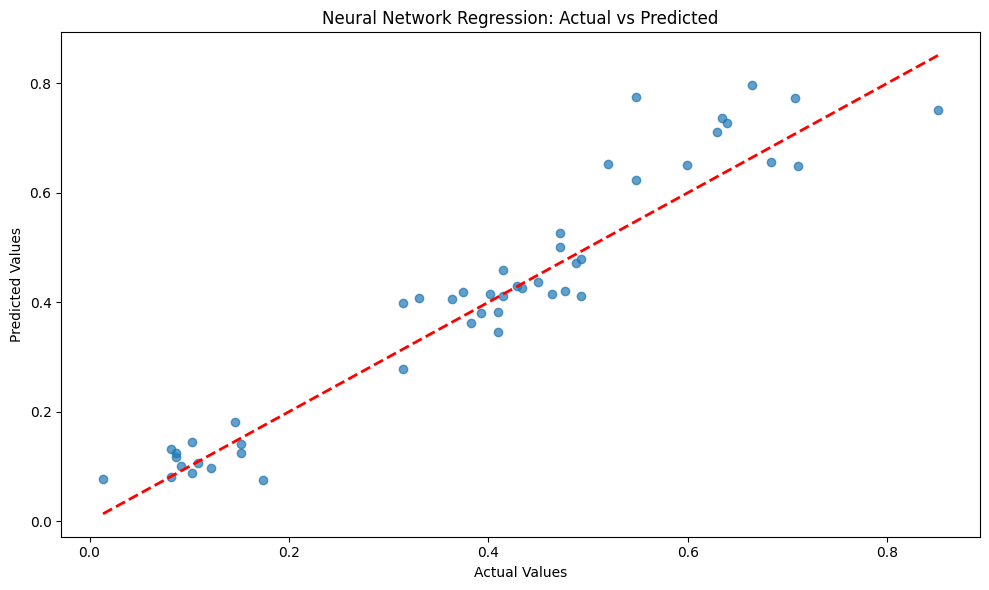

In [23]:
# Create MLPRegressor
mlp = MLPRegressor(max_iter=300, random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(
    estimator=mlp, 
    param_grid=param_grid, 
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,  # Use all available cores
    verbose=2
)

# Fit Grid Search
grid_search.fit(X_train, y_train)

# Prepare tags (optional)
tags = {
    'dataset': 'yield_data',
    'preprocessing': 'MinMax_scaler',
    'model_type': 'mlp_regressor'
}
print("logging")
# Log results with MLflow
log_results(
    grid_search, 
    experiment_name='NN Regression, Yield- exp04', 
    model_name='mlp-yield',
    tags=tags,
    log_only_best=False  # Set to True if you want to log only the best model
)

# Best model details
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (neg MSE):", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on test set
# y_pred_scaled = best_model.predict(X_test_scaled)y
y_pred = best_model.predict(X_test)

# Inverse transform predictions to original scale
# y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
# y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nRegression Metrics:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared Score: {r2:.4f}")

# Visualization of predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         'r--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Neural Network Regression: Actual vs Predicted")
plt.tight_layout()
plt.show()

# Function to create and train a neural network model with best parameters
def create_best_neural_network(X_train, y_train, best_params):
    """
    Create and train a neural network model with the best parameters.
    
    Parameters:
    -----------
    X_train : array-like
        Training feature matrix
    y_train : array-like
        Training target values
    best_params : dict
        Best hyperparameters from GridSearchCV
    
    Returns:
    --------
    MLPRegressor
        Trained neural network model
    """
    # Create MLPRegressor with best parameters
    best_nn = MLPRegressor(
        hidden_layer_sizes=best_params.get('hidden_layer_sizes', (50,)),
        activation=best_params.get('activation', 'relu'),
        solver=best_params.get('solver', 'adam'),
        alpha=best_params.get('alpha', 0.0001),
        learning_rate=best_params.get('learning_rate', 'constant'),
        max_iter=500,
        random_state=42
    )
    
    # Fit the model
    best_nn.fit(X_train, y_train)
    
    return best_nn

# Example of creating the best neural network model
final_model = create_best_neural_network(X_train, y_train, grid_search.best_params_)

In [24]:
y_pred_train= final_model.predict(X_train).flatten()
y_pred_test= final_model.predict(X_test).flatten()

print("Accuracy obtained using x_train and x_val sets from the original x!")

print("Training accuracy: ",r2_score(y_train, y_pred_train))

print("Test accuracy: ",r2_score(y_test, y_pred_test))

print("Test mean-squared error: ",np.sqrt(mean_squared_error(y_test, y_pred_test)))

Accuracy obtained using x_train and x_val sets from the original x!
Training accuracy:  0.9114879692954923
Test accuracy:  0.9018766935223489
Test mean-squared error:  0.06530992735272097


In [27]:
# savinf the model with Pickle
import pickle

# Save the model to a file
rounded_train = round(r2_score(y_train, y_pred_train),4)
rounded_test = round(r2_score(y_test, y_pred_test),4)
name = 'model_train' + str(rounded_train) +'test' + str(rounded_test) + '.pkl'
with open(name, 'wb') as f:
    pickle.dump(final_model, f)

In [26]:
print(grid_search.best_params_)

{'activation': 'relu', 'alpha': 0.04, 'hidden_layer_sizes': [256, 384, 256, 32], 'learning_rate': 'constant', 'solver': 'adam'}


# 5- Inferance using our best model 

In [27]:
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanSquaredError

model_path = "models/model_0.93.h5"

final_model = load_model(model_path, compile=False)  # Load without compiling
final_model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanSquaredError()])


In [28]:
pred_y_test = final_model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step


In [30]:
# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_squared_error

# Accuracy metrics :

y_pred_train= final_model.predict(X_train).flatten()

print("Accuracy obtained using x_train and x_val sets from the original x!")

print("Training accuracy: ",r2_score(y_train, y_pred_train))

print("Test accuracy: ",r2_score(y_test, pred_y_test))

print("Test mean-squared error: ",np.sqrt(mean_squared_error(y_test, pred_y_test)))


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step
Accuracy obtained using x_train and x_val sets from the original x!
Training accuracy:  0.871489664954737
Test accuracy:  0.9272153656475766
Test mean-squared error:  0.05624876167489324


In [33]:
# load the scaler 
scaler = joblib.load('scaler.pkl')

# Revert the scaling
original_predictions = scaler.inverse_transform(pred_y_test)
print(original_predictions)

ValueError: non-broadcastable output operand with shape (48,1) doesn't match the broadcast shape (48,12)

In [35]:
# pred_y_test
